# Data Collection of Music Artist Predictor

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Installation-of-lyricsgenius-by-johnwmillr" data-toc-modified-id="Installation-of-lyricsgenius-by-johnwmillr-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Installation of lyricsgenius by johnwmillr</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Genius-DataFrame-Creation" data-toc-modified-id="Genius-DataFrame-Creation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Genius DataFrame Creation</a></span></li></ul></div>

### Imports

In [1]:
import pandas as pd
import numpy as np
import json
from time import sleep
from random import randint
import requests
import re
import unidecode
from tqdm import tqdm
import pprint

### Installation of lyricsgenius by johnwmillr

Source: https://github.com/johnwmillr/LyricsGenius

The Genius API wrapper was installed by entering the following into the command line/bash:

```pip install lyricsgenius```

This created the lyricsgenius folder in the current working directory. To run the scripts the lyricsgenius folder was moved into the same folder as the jupyter notebook and the working directory changed to that folder.

lyricsgenius was imported into the jupyter notebook as genius and the api object created passing the client_access_token received from the Genius developer account (see below). 

https://genius.com/developers

In [2]:
import lyricsgenius as genius
api = genius.Genius(client_access_token='sgqA4LigelYVYBRGShxuowQJWWxfq5aE8yOTy4dR6ZS15B7V_d2_JcD9554G0RJv')

### Functions

In [3]:
def artist_song_dict(artist_list, spotify):
    '''This function takes a list of music artist and a dataframe containing artist_names and track_names
        and will return a dictionary containing artist names as keys and a list of their songs found in 
        the dataframe as the values. The function excludes any songs which contain the expressions:
        - 'Remastered' or 'Remaster'
        - 'feat' or 'ft.' 
        - 'Remix', 'RMX' or 'Mix'
        - 'Spotify'
        - 'Studios'
        - 'Christmas'
        - 'Single Version', 'Album Version' or 'Version'
        - 'BBC'
        - 'Demo'
        - 'Edition'
        - 'Mono'
        - 'Live from', 'Live At' or 'Live at'
        - 'Soundtrack'
    '''
    artist_dict = {}
    for artist in artist_list:
        songs = []
        for item in spotify.track_name[(spotify.artist_name==artist)&(spotify.track_name.str.contains(r'Remastered|Remaster')==False)&(spotify.track_name.str.contains(r'feat.|ft.')==False)&(spotify.track_name.str.contains(r'Remix|remix|RMX|Mix')==False)&(spotify.track_name.str.contains(r'Spotify|Studios|Soundtrack')==False)&(spotify.track_name.str.contains(r'Christmas')==False)&(spotify.track_name.str.contains(r'Single Version|Album Version|Version|BBC|Demo|Edition|Mono')==False)&(spotify.track_name.str.contains(r'Live from|Live at|Live At|live at')==False)]:
            songs.append(item)
        songs = list(set(songs))
        artist_dict[artist] = songs
    return artist_dict

In [35]:
def missing_songs(artists_list, artist_dict, scraped_dataframe):
    '''This function accepts a created artist list, its derived dictionary with songs, 
        and a lyrics genius dataframe. It returns a dictionary containing the artists and the songs that weren't 
        successfully scraped.'''
    missing_songs_dict = {}
    for artist in artists_list:
        tracks = []
        for item in artist_dict[artist]:
            if item not in list(scraped_dataframe[scraped_dataframe.artist_name==artist].track_name):
                tracks.append(item)
        missing_songs_dict[artist] = tracks
    return missing_songs_dict

In [40]:
def genius_lyrics_dataframe(artist_dict):
    song_titles = []
    song_artists = []
    releases = []
    uris = []
    urls = []
    lyrs = []
    for key in artist_dict.keys():
        for song_title in tqdm(artist_dict[key]):
            try:
                song =api.search_song(song_title, key)

                song_json = song.to_json()

                try:
                    song_titles.append(song.title)
                except:
                    song_titles.append(np.nan)

                try:
                    song_artists.append(song.artist)
                except:
                    song_artists.append(np.nan)

                try:
                    releases.append(song.year)
                except:
                    releases.append(np.nan)

                uri = np.nan
                for i in range(0,len(song.media)):
                    if 'native_uri' in song.media[i].keys():
                        uri = song.media[i]['native_uri']
                    else:
                        pass
                uris.append(uri)


                try:
                    urls.append(song_json['songs'][0]['url'])
                except:
                    urls.append(np.nan)

                try:
                    lyrs.append(song.lyrics)
                except:
                    lyrs.append(np.nan)
            except:
                pass
            
    return pd.DataFrame.from_dict({'track_name': song_titles, 
                                   'artist_name': song_artists, 
                                   'release_year': releases, 
                                    'spotify_uri': uris,
                                   'genius_url':urls, 
                                   'lyrics':lyrs})

### Genius DataFrame Creation

The spotify audio data was retrieved from a Kaggle dataset found in the link below.

https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db

A random set of artists was selected and a list created. This list was later expanded to enrich the dataset. From these artists I extracted their songs form the Kaggle dataset (dataframe --> spotify) with the artist_song_dict( ) function, I created.

In [4]:
spotify = pd.read_csv('/Users/constancemaurer/GA DSI 12/DSI12-lessons/projects/project-capstone/personal-github/Resources/SpotifyFeatures_Kaggle_TracksDB.csv')

In [5]:
spotify.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [6]:
spotify.shape

(232725, 18)

**To start with, the Kaggle dataset has a lot of duplicated entries as a lot of songs fall under multiple genres, hence I dropped these multiple copies of a song and only kept the first instance of each.**

*All duplicated entries:*

In [7]:
len(spotify[spotify.duplicated(['track_name','artist_name'], keep=False)])

91469

*All duplicated entries but excluding their first instance:*

In [8]:
len(spotify[spotify.duplicated(['track_name','artist_name'], keep='first')])

56211

In [9]:
spotify[spotify.duplicated(['track_name','artist_name'])].sort_values(by='track_name').head(5)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
121128,Rap,Rae Sremmurd,"""42"" - From SR3MM",5lf91lPnGKtIqsgmG1z8Ip,53,0.00275,0.968,238020,0.5630,0.000000,C#,0.108,-6.744,Major,0.1250,130.039,4/4,0.3240
166523,Rock,Barns Courtney,"""99""",6YQUuoMnRIMaOmouYoMfQr,69,0.00598,0.552,199413,0.8040,0.000000,G#,0.111,-4.299,Major,0.0303,95.980,4/4,0.7140
77209,Children’s Music,Barns Courtney,"""99""",6YQUuoMnRIMaOmouYoMfQr,69,0.00598,0.552,199413,0.8040,0.000000,G#,0.111,-4.299,Major,0.0303,95.980,4/4,0.7140
199606,Soundtrack,Howard Shore,"""A Far Green Country""",1U5wqqEATmbCpSqADvSqy9,41,0.31400,0.218,87920,0.0832,0.962000,C,0.208,-23.025,Major,0.0366,72.023,4/4,0.0795
121797,Rap,Bone Thugs-N-Harmony,"""Eternal""",14Klge4yTyUeFEn9yvBUjh,48,0.17700,0.818,243920,0.5130,0.000001,C#,0.469,-9.265,Minor,0.1880,80.047,4/4,0.5600


*Drop all copies of songs apart from the first instance. Dropped by index:*

In [10]:
spotify.drop(index=spotify[spotify.duplicated(['artist_name','track_name'], keep='first')].index, inplace=True)

In [11]:
spotify.shape

(176514, 18)

*Curated a list of artist which will be used to train the model:*

In [14]:
artists = ['John Legend','Adele','Frank Ocean','Aretha Franklin','Amy Winehouse','The Rolling Stones',
           'Led Zeppelin','Arctic Monkeys','The Beatles','Queen','Fall Out Boy','Tame Impala','Beach House',
          'Kings of Leon','Radiohead','Red Hot Chilli Peppers','Gorillaz','Linkin Park','The Black Keys','Slipknot',
          'Metallica','Korn','Nirvana','Foo Fighters','The Neighborhood','The Weeknd','Kayne West','Beyoncé',
          'Rihanna','Kendrick Lamar','Florence & The Machine','Tyler, The Creator','A$AP Rocky',
          'Lil Wayne','System Of A Down','Passion Pit','Caribou','Twin Shadow','HAIM','Sister Sledge',
           'Taylor Swift', 'Mac Miller', 'Red Hot Chili Peppers', 'The Weeknd', 'Fleetwood Mac', 'Wiz Khalifa', 
           'Lady Gaga', 'LCD Soundsystem']

*Created a dictionary containing all the artists and their songs from the Spotify dataframe:*

In [15]:
artist_dict = artist_song_dict(artists, spotify)

*The dictionary I created looked something like this:*

```python
pp = pprint.PrettyPrinter(depth=6)
pp.pprint(artist_dict)

{'A$AP Rocky': ['Better Things',
                'Canal St.',
                'Sundress',
                'West Side Highway',
                'Fashion Killa',
                'Wavybone',
                'Tony Tone',
                'Phoenix',
                'Back Home',
                'A$AP Forever',
                'Holy Ghost',
                'Jukebox Joints',
                'Kids Turned Out Fine',
                'Goldie',
                etc...],
 'Adele': ['Love in the Dark',
           'Set Fire to the Rain',
           'Make You Feel My Love',
           'Hiding My Heart',
           'Crazy For You',
           'Rolling in the Deep',
           "Don't You Remember",
           'Daydreamer',
           'Skyfall - Full Length',
           'Send My Love (To Your New Lover)',
           'Melt My Heart To Stone',
           'Hello',
           'Lovesong',
           'Take It All',
           'Sweetest Devotion',
           'Someone Like You',
           etc...],
           etc...}```

In [16]:
artist_dict.keys()

dict_keys(['John Legend', 'Adele', 'Frank Ocean', 'Aretha Franklin', 'Amy Winehouse', 'The Rolling Stones', 'Led Zeppelin', 'Arctic Monkeys', 'The Beatles', 'Queen', 'Fall Out Boy', 'Tame Impala', 'Beach House', 'Kings of Leon', 'Radiohead', 'Red Hot Chilli Peppers', 'Gorillaz', 'Linkin Park', 'The Black Keys', 'Slipknot', 'Metallica', 'Korn', 'Nirvana', 'Foo Fighters', 'The Neighborhood', 'The Weeknd', 'Kayne West', 'Beyoncé', 'Rihanna', 'Kendrick Lamar', 'Florence & The Machine', 'Tyler, The Creator', 'A$AP Rocky', 'Lil Wayne', 'System Of A Down', 'Passion Pit', 'Caribou', 'Twin Shadow', 'HAIM', 'Sister Sledge', 'Taylor Swift', 'Mac Miller', 'Red Hot Chili Peppers', 'Fleetwood Mac', 'Wiz Khalifa', 'Lady Gaga', 'LCD Soundsystem'])

**API call from Genius to gather  song information and webscraping with BeautifulSoup:**

My initial aim was to use Genius' API to retrieve my desired artists' songs as the Kaggle dataset gave me a limitation on which songs were available to me (still plenty). If in particular need I could retrieve more spotify data with their API but to this later more.
My rigorous reseach through Genius' API documentation (https://docs.genius.com/), made me realise that a single API call per artist retrieving ONLY my desired songs (GET /artists/:id/songs) was not possible. The issue was that also songs that were written, produced or merely featuring the artist were returned making the JSON data hard to navigate.
Then I decided to do API calls requesting multiple songs in one go. Neverthless, this is not possible as their API system only allows for singular songs to be within their song API (GET /songs/:id).
This was going to force me to hit their server for each song I had selected instead of retrieving all my information at once.
Unfortunately, I also got aware that the lyrics themselves were not available via the API as the rights to the lyrics are held by the artists. This is paradox as Genius literally displays the lyrics on the website.

I made the attempt to scrap the lyrics directly from the website using the information from my artist dictionary (artist_dict):



```python

import re
import unidecode
from tqdm import tqdm
from time import sleep
from random import randint
#pip install unidecode
song_titles = []
song_artists = []
releases  = []
lyr = []

p=re.compile('@|$|\.|\(|\)')

for key in artist_dict.keys():
    for song_title in tqdm(artist_dict[key]):
        sleep(randint(2,7))
        
        song = p.sub('',unidecode.unidecode(song_title.replace(' ','-').replace('\'','').replace('&','and').replace('$','')))
        artist = p.sub('',unidecode.unidecode(key.replace(' ','-').replace('\'','').replace('&','and').replace('$','')))
        song_url = 'https://genius.com/'+artist+'-'+song+'-lyrics'

        song_titles.append(song_title)
        song_artists.append(key)
        #releases.append(release)
        lyr.append(scrap_song_url(song_url))
        
lyrics_df = pd.DataFrame({'track_name':song_titles,'artist_name':song_artists,'lyrics': lyr})



```



Unfortunately, also this was going to be challenging as each URL was not in the same format as expected, hence to my knowledge not easily callable. 

Desperate times call for desperate measures, so I discovered lyricsgenius by johnwmillr, an Genius API wrapper (https://github.com/johnwmillr/LyricsGenius).
Thank god for smart developers!

All I had to do is setup lyricsgenius by running

    pip install lyricsgenius 

in my Terminal's command line/bash with the directory set to where I wanted the folder to appear.

Going through his documentation throughly, I discovered that he used the same approach I attempted but with one difference. He made the API calls' JSON more navigatable and was able to retrieve the song URL each time to then scrap the lyrics with BeautifulSoup via this URL.
Thank you John Miller !

Now I only had to import lyrics genius into my jupyter notebook and insert my genius TOKEN (provided from my Genius Developer Account).


```python

import lyricsgenius as genius
api = genius.Genius(client_access_token='XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
song = api.search_song({song_title}, {artist_name})


```


**Please see below how I populated my table for my lyrics_df (now as an SQL table: 'genius_lyrics):**

```python
song_titles = []
song_artists = []
releases = []
uris = []
urls = []
lyrs = []
for key in artist_dict.keys():
    for song_title in tqdm(artist_dict[key]):
        try:
            song =api.search_song(song_title, key)
        
            song_json = song.to_json()
        
            try:
                song_titles.append(song.title)
            except:
                song_titles.append(np.nan)

            try:
                song_artists.append(song.artist)
            except:
                song_artists.append(np.nan)

            try:
                releases.append(song.year)
            except:
                releases.append(np.nan)
        
            uri = np.nan
            for i in range(0,len(song.media)):
                if 'native_uri' in song.media[i].keys():
                    uri = song.media[i]['native_uri']
                else:
                    pass
            uris.append(uri)

        
            try:
                urls.append(song_json['songs'][0]['url'])
            except:
                urls.append(np.nan)

            try:
                lyrs.append(song.lyrics)
            except:
                lyrs.append(np.nan)
        except:
            pass```

In [17]:
song_titles = []
song_artists = []
releases = []
uris = []
urls = []
lyrs = []
for key in artist_dict.keys():
    for song_title in tqdm(artist_dict[key]):
        try:
            song =api.search_song(song_title, key)

            song_json = song.to_json()

            try:
                song_titles.append(song.title)
            except:
                song_titles.append(np.nan)

            try:
                song_artists.append(song.artist)
            except:
                song_artists.append(np.nan)

            try:
                releases.append(song.year)
            except:
                releases.append(np.nan)

            uri = np.nan
            for i in range(0,len(song.media)):
                if 'native_uri' in song.media[i].keys():
                    uri = song.media[i]['native_uri']
                else:
                    pass
            uris.append(uri)


            try:
                urls.append(song_json['songs'][0]['url'])
            except:
                urls.append(np.nan)

            try:
                lyrs.append(song.lyrics)
            except:
                lyrs.append(np.nan)
        except:
            pass

  0%|          | 0/72 [00:00<?, ?it/s]

Searching for "Slow Dance" by John Legend...


  1%|▏         | 1/72 [00:05<06:57,  5.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Temporarily Painless" by John Legend...


  3%|▎         | 2/72 [00:11<06:45,  5.80s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Each Day Gets Better" by John Legend...


  4%|▍         | 3/72 [00:20<07:41,  6.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Where Did My Baby Go" by John Legend...


  6%|▌         | 4/72 [00:25<07:05,  6.26s/it]

Done.
Searching for "Wanna Be Loved" by John Legend...


  7%|▋         | 5/72 [00:33<07:27,  6.68s/it]

Done.
Searching for "Penthouse Floor" by John Legend...


  8%|▊         | 6/72 [00:40<07:25,  6.76s/it]

Done.
Searching for "Darkness and Light" by John Legend...


 10%|▉         | 7/72 [00:44<06:36,  6.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Live It Up" by John Legend...


 11%|█         | 8/72 [00:49<06:11,  5.81s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Number One" by John Legend...


 12%|█▎        | 9/72 [00:53<05:31,  5.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Beginning..." by John Legend...


 14%|█▍        | 10/72 [00:58<05:17,  5.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "How Can I Blame You" by John Legend...


 15%|█▌        | 11/72 [01:05<05:43,  5.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Another Again" by John Legend...


 17%|█▋        | 12/72 [01:13<06:24,  6.41s/it]

Done.
Searching for "Open Your Eyes" by John Legend...


 18%|█▊        | 13/72 [01:16<05:22,  5.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "If You're Out There" by John Legend...


 19%|█▉        | 14/72 [01:24<05:50,  6.04s/it]

Done.
Searching for "A Good Night" by John Legend...


 21%|██        | 15/72 [01:30<05:55,  6.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Marching Into the Dark" by John Legend...


 22%|██▏       | 16/72 [01:35<05:26,  5.83s/it]

Done.
Searching for "Everybody Knows" by John Legend...


 24%|██▎       | 17/72 [01:40<05:07,  5.59s/it]

Done.
Searching for "Right By You (for Luna)" by John Legend...


 25%|██▌       | 18/72 [01:47<05:15,  5.84s/it]

Done.
Searching for "Ordinary People" by John Legend...


 26%|██▋       | 19/72 [01:55<05:42,  6.46s/it]

Done.
Searching for "Under the Stars" by John Legend...


 28%|██▊       | 20/72 [02:01<05:39,  6.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Asylum" by John Legend...


 29%|██▉       | 21/72 [02:08<05:39,  6.66s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Used to Love U" by John Legend...


 31%|███       | 22/72 [02:16<05:54,  7.09s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Stay With You" by John Legend...


 32%|███▏      | 23/72 [02:23<05:40,  6.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Show Me" by John Legend...


 33%|███▎      | 24/72 [02:29<05:24,  6.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tomorrow" by John Legend...


 35%|███▍      | 25/72 [02:34<04:43,  6.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Surefire" by John Legend...


 36%|███▌      | 26/72 [02:39<04:28,  5.84s/it]

Done.
Searching for "Purple Snowflakes" by John Legend...


 38%|███▊      | 27/72 [02:45<04:22,  5.84s/it]

Done.
Searching for "For the First Time" by John Legend...


 39%|███▉      | 28/72 [02:53<04:49,  6.59s/it]

Done.
Searching for "Humanity (Love the Way It Should Be)" by John Legend...


 40%|████      | 29/72 [02:58<04:16,  5.98s/it]

Done.
Searching for "Heaven" by John Legend...


 42%|████▏     | 30/72 [03:06<04:37,  6.62s/it]

Done.
Searching for "I Know Better" by John Legend...


 43%|████▎     | 31/72 [03:13<04:36,  6.74s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Start A Fire" by John Legend...


 44%|████▍     | 32/72 [03:18<04:10,  6.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Again" by John Legend...


 46%|████▌     | 33/72 [03:22<03:34,  5.49s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All of Me" by John Legend...


 47%|████▋     | 34/72 [03:29<03:47,  6.00s/it]

Done.
Searching for "Dreams" by John Legend...


 49%|████▊     | 35/72 [03:36<03:52,  6.29s/it]

Done.
Searching for "Love In The Future (Intro)" by John Legend...


 50%|█████     | 36/72 [03:41<03:33,  5.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Alright" by John Legend...


 51%|█████▏    | 37/72 [03:48<03:35,  6.15s/it]

Done.
Searching for "Prelude" by John Legend...


 53%|█████▎    | 38/72 [03:52<03:10,  5.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "This Time" by John Legend...


 54%|█████▍    | 39/72 [03:58<03:11,  5.80s/it]

Done.
Searching for "Save Room" by John Legend...


 56%|█████▌    | 40/72 [04:10<03:59,  7.48s/it]

Done.
Searching for "Take Me Away" by John Legend...


 57%|█████▋    | 41/72 [04:20<04:19,  8.38s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Start" by John Legend...


 58%|█████▊    | 42/72 [04:26<03:45,  7.50s/it]

Done.
Searching for "Bliss" by John Legend...


 60%|█████▉    | 43/72 [04:31<03:21,  6.94s/it]

Done.
Searching for "Bring Me Love" by John Legend...


 61%|██████    | 44/72 [04:37<03:07,  6.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "P.D.A. (We Just Don't Care)" by John Legend...


 62%|██████▎   | 45/72 [04:43<02:49,  6.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Same Old Story" by John Legend...


 64%|██████▍   | 46/72 [04:51<02:57,  6.81s/it]

Done.
Searching for "Hold On Longer" by John Legend...


 65%|██████▌   | 47/72 [04:57<02:44,  6.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You & I (Nobody in the World)" by John Legend...


 67%|██████▋   | 48/72 [05:02<02:27,  6.13s/it]

Done.
Searching for "Refuge (When It's Cold Outside)" by John Legend...


 68%|██████▊   | 49/72 [05:05<02:02,  5.34s/it]

Done.
Searching for "Caught Up" by John Legend...


 69%|██████▉   | 50/72 [05:13<02:13,  6.07s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Save The Night" by John Legend...


 71%|███████   | 51/72 [05:17<01:50,  5.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "She Don't Have to Know" by John Legend...


 72%|███████▏  | 52/72 [05:23<01:54,  5.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sin City" by John Legend...


 74%|███████▎  | 53/72 [05:30<01:52,  5.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Love Me Now" by John Legend...


 75%|███████▌  | 54/72 [05:34<01:39,  5.51s/it]

Done.
Searching for "Stereo" by John Legend...


 76%|███████▋  | 55/72 [05:41<01:41,  5.98s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wrap Me Up in Your Love" by John Legend...


 78%|███████▊  | 56/72 [06:04<02:57, 11.11s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "What You Do to Me" by John Legend...


 79%|███████▉  | 57/72 [06:09<02:16,  9.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "One Woman Man" by John Legend...


 81%|████████  | 58/72 [06:13<01:44,  7.48s/it]

Done.
Searching for "Tonight (Best You Ever Had)" by John Legend...


 82%|████████▏ | 59/72 [06:17<01:25,  6.60s/it]

Done.
Searching for "No Place Like Home" by John Legend...


 83%|████████▎ | 60/72 [06:21<01:10,  5.87s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Preach" by John Legend...


 85%|████████▍ | 61/72 [06:25<00:57,  5.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Good Morning" by John Legend...


 86%|████████▌ | 62/72 [06:30<00:52,  5.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Written In The Stars" by John Legend...


 88%|████████▊ | 63/72 [06:35<00:44,  5.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Who Do We Think We Are" by John Legend...


 89%|████████▉ | 64/72 [06:41<00:43,  5.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Aim High" by John Legend...


 90%|█████████ | 65/72 [06:46<00:36,  5.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "So Gone" by John Legend...


 92%|█████████▏| 66/72 [06:53<00:34,  5.81s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Love, You Love" by John Legend...


 93%|█████████▎| 67/72 [06:57<00:26,  5.22s/it]

Done.
Searching for "Made to Love" by John Legend...


 94%|█████████▍| 68/72 [07:01<00:20,  5.01s/it]

Done.
Searching for "Overload" by John Legend...


 96%|█████████▌| 69/72 [07:06<00:14,  4.87s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "History Has Its Eyes On You" by John Legend...


 97%|█████████▋| 70/72 [07:09<00:08,  4.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Silver Bells" by John Legend...


 99%|█████████▊| 71/72 [07:13<00:04,  4.33s/it]

Done.
Searching for "God Only Knows" by John Legend...


  0%|          | 0/36 [00:00<?, ?it/s]

Done.
Searching for "Water Under the Bridge" by Adele...


  3%|▎         | 1/36 [00:05<03:04,  5.26s/it]

Done.
Searching for "Someone Like You" by Adele...


  6%|▌         | 2/36 [00:11<03:04,  5.42s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Make You Feel My Love" by Adele...


  8%|▊         | 3/36 [00:16<02:57,  5.36s/it]

Done.
Searching for "All I Ask" by Adele...


 11%|█         | 4/36 [00:25<03:25,  6.42s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hometown Glory" by Adele...


 14%|█▍        | 5/36 [00:31<03:16,  6.34s/it]

Done.
Searching for "Crazy For You" by Adele...


 17%|█▋        | 6/36 [00:35<02:50,  5.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Chasing Pavements" by Adele...


 19%|█▉        | 7/36 [00:40<02:41,  5.59s/it]

Done.
Searching for "Remedy" by Adele...


 22%|██▏       | 8/36 [00:48<02:57,  6.33s/it]

Done.
Searching for "Hiding My Heart" by Adele...


 25%|██▌       | 9/36 [00:52<02:27,  5.48s/it]

Done.
Searching for "River Lea" by Adele...


 28%|██▊       | 10/36 [00:58<02:24,  5.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Best For Last" by Adele...


 31%|███       | 11/36 [01:04<02:27,  5.91s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Daydreamer" by Adele...


 33%|███▎      | 12/36 [01:09<02:11,  5.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sweetest Devotion" by Adele...


 36%|███▌      | 13/36 [01:14<02:01,  5.28s/it]

Done.
Searching for "Skyfall - Full Length" by Adele...


 39%|███▉      | 14/36 [01:17<01:42,  4.68s/it]

Done.
Searching for "Rolling in the Deep" by Adele...


 42%|████▏     | 15/36 [01:22<01:41,  4.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rolling In The Deep" by Adele...


 44%|████▍     | 16/36 [01:29<01:49,  5.46s/it]

Done.
Searching for "First Love" by Adele...


 47%|████▋     | 17/36 [01:37<01:57,  6.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "One And Only" by Adele...


 50%|█████     | 18/36 [01:42<01:46,  5.91s/it]

Done.
Searching for "I'll Be Waiting" by Adele...


 53%|█████▎    | 19/36 [01:46<01:28,  5.19s/it]

Done.
Searching for "Hello" by Adele...


 56%|█████▌    | 20/36 [01:50<01:17,  4.84s/it]

Done.
Searching for "Take It All" by Adele...


 58%|█████▊    | 21/36 [01:55<01:14,  4.96s/it]

Done.
Searching for "I Miss You" by Adele...


 61%|██████    | 22/36 [02:05<01:29,  6.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Million Years Ago" by Adele...


 64%|██████▍   | 23/36 [02:10<01:20,  6.21s/it]

Done.
Searching for "He Won't Go" by Adele...


 67%|██████▋   | 24/36 [02:16<01:11,  5.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Send My Love (To Your New Lover)" by Adele...


 69%|██████▉   | 25/36 [02:20<00:59,  5.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Love in the Dark" by Adele...


 72%|███████▏  | 26/36 [02:25<00:52,  5.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tired" by Adele...


 75%|███████▌  | 27/36 [02:31<00:49,  5.45s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lovesong" by Adele...


 78%|███████▊  | 28/36 [02:37<00:46,  5.82s/it]

Done.
Searching for "When We Were Young" by Adele...


 81%|████████  | 29/36 [02:42<00:38,  5.52s/it]

Done.
Searching for "My Same" by Adele...


 83%|████████▎ | 30/36 [02:46<00:30,  5.01s/it]

Done.
Searching for "Melt My Heart To Stone" by Adele...


 86%|████████▌ | 31/36 [02:52<00:26,  5.26s/it]

Done.
Searching for "Don't You Remember" by Adele...


 89%|████████▉ | 32/36 [03:00<00:24,  6.07s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Right As Rain" by Adele...


 92%|█████████▏| 33/36 [03:03<00:15,  5.21s/it]

Done.
Searching for "Set Fire to the Rain" by Adele...


 94%|█████████▍| 34/36 [03:14<00:13,  6.84s/it]

Done.
Searching for "Cold Shoulder" by Adele...


 97%|█████████▋| 35/36 [03:19<00:06,  6.34s/it]

Done.
Searching for "Rumour Has It" by Adele...


  0%|          | 0/39 [00:00<?, ?it/s]

Searching for "Lens" by Frank Ocean...


  3%|▎         | 1/39 [00:08<05:25,  8.56s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pyramids" by Frank Ocean...


  5%|▌         | 2/39 [00:15<05:00,  8.11s/it]

Done.
Searching for "Seigfried" by Frank Ocean...


  8%|▊         | 3/39 [00:23<04:46,  7.95s/it]

Done.
Searching for "Novacane" by Frank Ocean...


 10%|█         | 4/39 [00:33<05:06,  8.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "End" by Frank Ocean...


 13%|█▎        | 5/39 [00:41<04:50,  8.55s/it]

Done.
Searching for "Ivy" by Frank Ocean...


 15%|█▌        | 6/39 [00:48<04:22,  7.95s/it]

Done.
Searching for "Futura Free" by Frank Ocean...


 18%|█▊        | 7/39 [00:56<04:14,  7.95s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Be Yourself" by Frank Ocean...


 21%|██        | 8/39 [01:02<03:45,  7.28s/it]

Done.
Searching for "Moon River" by Frank Ocean...


 23%|██▎       | 9/39 [01:07<03:19,  6.66s/it]

Done.
Searching for "Sweet Life" by Frank Ocean...


 26%|██▌       | 10/39 [01:13<03:11,  6.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Godspeed" by Frank Ocean...


 28%|██▊       | 11/39 [01:21<03:12,  6.88s/it]

Done.
Searching for "Sierra Leone" by Frank Ocean...


 31%|███       | 12/39 [01:26<02:55,  6.51s/it]

Done.
Searching for "Pink + White" by Frank Ocean...


 33%|███▎      | 13/39 [01:33<02:51,  6.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bad Religion" by Frank Ocean...


 36%|███▌      | 14/39 [01:38<02:34,  6.16s/it]

Done.
Searching for "Nikes" by Frank Ocean...


 38%|███▊      | 15/39 [01:49<02:57,  7.38s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lost" by Frank Ocean...


 41%|████      | 16/39 [01:54<02:34,  6.70s/it]

Done.
Searching for "Chanel" by Frank Ocean...


 44%|████▎     | 17/39 [02:01<02:29,  6.81s/it]

Done.
Searching for "Biking" by Frank Ocean...


 46%|████▌     | 18/39 [02:06<02:12,  6.33s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Facebook Story" by Frank Ocean...


 49%|████▊     | 19/39 [02:12<02:02,  6.13s/it]

Done.
Searching for "Skyline To" by Frank Ocean...


 51%|█████▏    | 20/39 [02:17<01:53,  5.98s/it]

Done.
Searching for "Nights" by Frank Ocean...


 54%|█████▍    | 21/39 [02:25<01:57,  6.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Self Control" by Frank Ocean...


 56%|█████▋    | 22/39 [02:32<01:50,  6.51s/it]

Done.
Searching for "Provider" by Frank Ocean...


 59%|█████▉    | 23/39 [02:37<01:38,  6.16s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Good Guy" by Frank Ocean...


 62%|██████▏   | 24/39 [02:42<01:27,  5.81s/it]

Done.
Searching for "Close To You" by Frank Ocean...


 64%|██████▍   | 25/39 [02:48<01:23,  5.97s/it]

Done.
Searching for "Pilot Jones" by Frank Ocean...


 67%|██████▋   | 26/39 [02:54<01:16,  5.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Swim Good" by Frank Ocean...


 69%|██████▉   | 27/39 [02:58<01:04,  5.36s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pretty Sweet" by Frank Ocean...


 72%|███████▏  | 28/39 [03:03<00:58,  5.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fertilizer" by Frank Ocean...


 74%|███████▍  | 29/39 [03:13<01:06,  6.67s/it]

Done.
Searching for "Solo (Reprise)" by Frank Ocean...


 77%|███████▋  | 30/39 [03:18<00:56,  6.28s/it]

Done.
Searching for "Thinkin Bout You" by Frank Ocean...


 79%|███████▉  | 31/39 [03:29<00:59,  7.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Super Rich Kids" by Frank Ocean...


 82%|████████▏ | 32/39 [03:34<00:46,  6.71s/it]

Done.
Searching for "Crack Rock" by Frank Ocean...


 85%|████████▍ | 33/39 [03:39<00:37,  6.30s/it]

Done.
Searching for "Forrest Gump" by Frank Ocean...


 87%|████████▋ | 34/39 [03:45<00:30,  6.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pink Matter" by Frank Ocean...


 90%|████████▉ | 35/39 [03:54<00:28,  7.07s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Solo" by Frank Ocean...


 92%|█████████▏| 36/39 [04:00<00:20,  6.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Biking (Solo)" by Frank Ocean...


 95%|█████████▍| 37/39 [04:05<00:12,  6.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "White Ferrari" by Frank Ocean...


 97%|█████████▋| 38/39 [04:13<00:06,  6.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Monks" by Frank Ocean...


  0%|          | 0/67 [00:00<?, ?it/s]

Done.
Searching for "It Ain't Fair" by Aretha Franklin...


  1%|▏         | 1/67 [00:07<07:58,  7.25s/it]

Done.
Searching for "What a Friend We Have in Jesus" by Aretha Franklin...


  3%|▎         | 2/67 [00:11<06:58,  6.44s/it]

Done.
Searching for "Do Right Woman - Do Right Man" by Aretha Franklin...


  4%|▍         | 3/67 [00:18<07:05,  6.65s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Weight" by Aretha Franklin...


  6%|▌         | 4/67 [00:25<07:06,  6.77s/it]

Done.
Searching for "Hello Sunshine" by Aretha Franklin...


  7%|▋         | 5/67 [00:29<06:05,  5.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bridge over Troubled Water" by Aretha Franklin...


  9%|▉         | 6/67 [00:34<05:30,  5.42s/it]

Done.
Searching for "Until You Come Back to Me (That's What I'm Gonna Do)" by Aretha Franklin...


 10%|█         | 7/67 [00:43<06:33,  6.55s/it]

Done.
Searching for "Mary, Don't You Weep" by Aretha Franklin...


 12%|█▏        | 8/67 [00:48<05:57,  6.06s/it]

Done.
Searching for "You Send Me" by Aretha Franklin...


 13%|█▎        | 9/67 [00:54<05:48,  6.01s/it]

Done.
Searching for "Jump to It" by Aretha Franklin...


 15%|█▍        | 10/67 [00:58<05:06,  5.38s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Call Me" by Aretha Franklin...


 16%|█▋        | 11/67 [01:03<04:55,  5.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Spanish Harlem" by Aretha Franklin...


 18%|█▊        | 12/67 [01:06<04:20,  4.73s/it]

Done.
Searching for "Moon River" by Aretha Franklin...


 19%|█▉        | 13/67 [01:13<04:56,  5.49s/it]

Done.
Searching for "It Hurts Like Hell" by Aretha Franklin...


 21%|██        | 14/67 [01:17<04:22,  4.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Spirit in the Dark" by Aretha Franklin...


 22%|██▏       | 15/67 [01:23<04:40,  5.39s/it]

Done.
Searching for "Walk On By" by Aretha Franklin...


 24%|██▍       | 16/67 [01:28<04:20,  5.11s/it]

Done.
Searching for "You're All I Need to Get By" by Aretha Franklin...


 25%|██▌       | 17/67 [01:34<04:22,  5.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "My Way" by Aretha Franklin...


 27%|██▋       | 18/67 [01:43<05:20,  6.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "(You Make Me Feel Like) a Natural Woman [with the Royal Philharmonic Orchestra]" by Aretha Franklin...


 28%|██▊       | 19/67 [01:44<03:59,  4.98s/it]

No results found for: '(You Make Me Feel Like) a Natural Woman [with the Royal Philharmonic Orchestra] Aretha Franklin'
Searching for "Don't Play That Song" by Aretha Franklin...


 30%|██▉       | 20/67 [01:49<03:42,  4.73s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Say a Little Prayer" by Aretha Franklin...


 31%|███▏      | 21/67 [01:55<03:55,  5.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Respect (with The Royal Philharmonic Orchestra)" by Aretha Franklin...


 33%|███▎      | 22/67 [01:58<03:21,  4.49s/it]

Done.
Searching for "Chain of Fools" by Aretha Franklin...


 34%|███▍      | 23/67 [02:07<04:19,  5.89s/it]

Done.
Searching for "See Saw" by Aretha Franklin...


 36%|███▌      | 24/67 [02:12<04:07,  5.75s/it]

Done.
Searching for "Ain't No Way" by Aretha Franklin...


 37%|███▋      | 25/67 [02:19<04:15,  6.09s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "(You Make Me Feel Like) A Natural Woman" by Aretha Franklin...


 39%|███▉      | 26/67 [02:27<04:29,  6.59s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Do Right Woman, Do Right Man" by Aretha Franklin...


 40%|████      | 27/67 [02:30<03:42,  5.55s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rock Steady" by Aretha Franklin...


 42%|████▏     | 28/67 [02:35<03:26,  5.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You're All I Need to Get By - Take 2" by Aretha Franklin...


 43%|████▎     | 29/67 [02:40<03:24,  5.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dr. Feelgood (Love Is a Serious Business)" by Aretha Franklin...


 45%|████▍     | 30/67 [02:44<03:02,  4.94s/it]

Done.
Searching for "Respect" by Aretha Franklin...


 46%|████▋     | 31/67 [02:55<04:03,  6.76s/it]

Done.
Searching for "Medley: Precious Lord, Take My Hand / You've Got a Friend - Medley" by Aretha Franklin...


 48%|████▊     | 32/67 [02:59<03:22,  5.80s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "At Last" by Aretha Franklin...


 49%|████▉     | 33/67 [03:03<03:02,  5.36s/it]

Done.
Searching for "Soul Serenade" by Aretha Franklin...


 51%|█████     | 34/67 [03:07<02:42,  4.91s/it]

Done.
Searching for "Get It Right" by Aretha Franklin...


 52%|█████▏    | 35/67 [03:18<03:36,  6.78s/it]

Done.
Searching for "Medley: Precious Lord, Take My Hand / You've Got a Friend" by Aretha Franklin...


 54%|█████▎    | 36/67 [03:21<02:57,  5.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Think" by Aretha Franklin...


 55%|█████▌    | 37/67 [03:28<03:03,  6.13s/it]

Done.
Searching for "Baby, Baby, Baby" by Aretha Franklin...


 57%|█████▋    | 38/67 [03:35<03:01,  6.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Change Is Gonna Come" by Aretha Franklin...


 58%|█████▊    | 39/67 [03:40<02:48,  6.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You Keep Me Hangin' On" by Aretha Franklin...


 60%|█████▉    | 40/67 [03:47<02:51,  6.33s/it]

Done.
Searching for "Baby, I Love You" by Aretha Franklin...


 61%|██████    | 41/67 [03:55<02:53,  6.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Oh Happy Day - Live" by Aretha Franklin...


 63%|██████▎   | 42/67 [03:58<02:19,  5.59s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Something He Can Feel" by Aretha Franklin...


 64%|██████▍   | 43/67 [04:04<02:14,  5.60s/it]

Done.
Searching for "I'm Every Woman / Respect" by Aretha Franklin...


 66%|██████▌   | 44/67 [04:07<01:56,  5.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Climbing Higher Mountains" by Aretha Franklin...


 67%|██████▋   | 45/67 [04:12<01:46,  4.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rock-A-Bye Your Baby with a Dixie Melody" by Aretha Franklin...


 69%|██████▊   | 46/67 [04:16<01:36,  4.59s/it]

Done.
Searching for "Let It Be" by Aretha Franklin...


 70%|███████   | 47/67 [04:20<01:30,  4.52s/it]

Done.
Searching for "The Shoop Shoop Song (It's in His Kiss)" by Aretha Franklin...


 72%|███████▏  | 48/67 [04:25<01:30,  4.74s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Drown in My Own Tears" by Aretha Franklin...


 73%|███████▎  | 49/67 [04:30<01:25,  4.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Midnight Train To Georgia" by Aretha Franklin...


 75%|███████▍  | 50/67 [04:34<01:15,  4.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Freeway Of Love" by Aretha Franklin...


 76%|███████▌  | 51/67 [04:38<01:10,  4.39s/it]

Done.
Searching for "Day Dreaming" by Aretha Franklin...


 78%|███████▊  | 52/67 [04:46<01:19,  5.29s/it]

Done.
Searching for "Groovin'" by Aretha Franklin...


 79%|███████▉  | 53/67 [04:52<01:18,  5.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Who's Zoomin' Who?" by Aretha Franklin...


 81%|████████  | 54/67 [04:55<01:03,  4.90s/it]

Done.
Searching for "Nessun Dorma" by Aretha Franklin...


 82%|████████▏ | 55/67 [05:00<00:58,  4.86s/it]

Done.
Searching for "(Sweet Sweet Baby) Since You've Been Gone" by Aretha Franklin...


 84%|████████▎ | 56/67 [05:07<01:02,  5.64s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Night Time Is the Right Time" by Aretha Franklin...


 85%|████████▌ | 57/67 [05:12<00:54,  5.46s/it]

Done.
Searching for "People Get Ready" by Aretha Franklin...


 87%|████████▋ | 58/67 [05:22<00:59,  6.60s/it]

Done.
Searching for "You're All I Need to Get By (with The Royal Philharmonic Orchestra)" by Aretha Franklin...


 88%|████████▊ | 59/67 [05:24<00:42,  5.35s/it]

No results found for: 'You're All I Need to Get By (with The Royal Philharmonic Orchestra) Aretha Franklin'
Searching for "Good Times" by Aretha Franklin...


 90%|████████▉ | 60/67 [05:31<00:39,  5.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Rose Is Still a Rose" by Aretha Franklin...


 91%|█████████ | 61/67 [05:37<00:35,  5.92s/it]

Done.
Searching for "The House That Jack Built" by Aretha Franklin...


 93%|█████████▎| 62/67 [05:43<00:29,  5.86s/it]

Done.
Searching for "Son of a Preacher Man" by Aretha Franklin...


 94%|█████████▍| 63/67 [05:46<00:20,  5.12s/it]

Done.
Searching for "I Never Loved a Man (The Way I Love You)" by Aretha Franklin...


 96%|█████████▌| 64/67 [05:53<00:16,  5.54s/it]

Done.
Searching for "One Step Ahead" by Aretha Franklin...


 97%|█████████▋| 65/67 [05:59<00:11,  5.83s/it]

Done.
Searching for "I Never Loved a Man (The Way I Love You) - Stereo" by Aretha Franklin...


 99%|█████████▊| 66/67 [06:00<00:04,  4.45s/it]

No results found for: 'I Never Loved a Man (The Way I Love You) - Stereo Aretha Franklin'
Searching for "Amazing Grace" by Aretha Franklin...


  0%|          | 0/51 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Monkey Man" by Amy Winehouse...


  2%|▏         | 1/51 [00:04<03:40,  4.41s/it]

Done.
Searching for "(There Is) No Greater Love" by Amy Winehouse...


  4%|▍         | 2/51 [00:11<04:10,  5.12s/it]

Done.
Searching for "Stronger Than Me" by Amy Winehouse...


  6%|▌         | 3/51 [00:16<04:15,  5.32s/it]

Done.
Searching for "Best Friend - Acoustic" by Amy Winehouse...


  8%|▊         | 4/51 [00:21<03:53,  4.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Some Unholy War" by Amy Winehouse...


 10%|▉         | 5/51 [00:25<03:41,  4.82s/it]

Done.
Searching for "Just Friends" by Amy Winehouse...


 12%|█▏        | 6/51 [00:34<04:32,  6.05s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You Sent Me Flying" by Amy Winehouse...


 14%|█▎        | 7/51 [00:44<05:22,  7.33s/it]

Done.
Searching for "Hey Little Rich Girl" by Amy Winehouse...


 16%|█▌        | 8/51 [00:48<04:27,  6.22s/it]

Done.
Searching for "Best Friends, Right?" by Amy Winehouse...


 18%|█▊        | 9/51 [00:53<04:00,  5.73s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Heard Love Is Blind" by Amy Winehouse...


 20%|█▉        | 10/51 [00:56<03:25,  5.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "What Is It About Men" by Amy Winehouse...


 22%|██▏       | 11/51 [01:03<03:45,  5.63s/it]

Done.
Searching for "Know You Now" by Amy Winehouse...


 24%|██▎       | 12/51 [01:07<03:26,  5.28s/it]

Done.
Searching for "Fuck Me Pumps" by Amy Winehouse...


 25%|██▌       | 13/51 [01:12<03:14,  5.11s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Brother" by Amy Winehouse...


 27%|██▋       | 14/51 [01:16<02:50,  4.60s/it]

Done.
Searching for "I Heard Love Is Blind - Live" by Amy Winehouse...


 29%|██▉       | 15/51 [01:20<02:44,  4.56s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Girl From Ipanema" by Amy Winehouse...


 31%|███▏      | 16/51 [01:26<02:49,  4.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Half Time" by Amy Winehouse...


 33%|███▎      | 17/51 [01:30<02:39,  4.69s/it]

Done.
Searching for "In My Bed" by Amy Winehouse...


 35%|███▌      | 18/51 [01:37<02:58,  5.42s/it]

Done.
Searching for "Will You Still Love Me Tomorrow? - 2011" by Amy Winehouse...


 37%|███▋      | 19/51 [01:41<02:41,  5.05s/it]

Done.
Searching for "Moody's Mood For Love / Teo Licks" by Amy Winehouse...


 39%|███▉      | 20/51 [01:47<02:46,  5.36s/it]

Done.
Searching for "Intro / Stronger Than Me" by Amy Winehouse...


 41%|████      | 21/51 [01:52<02:39,  5.30s/it]

Done.
Searching for "Amy Amy Amy" by Amy Winehouse...


 43%|████▎     | 22/51 [01:58<02:40,  5.54s/it]

Done.
Searching for "Rehab - Live On Jools Holland" by Amy Winehouse...


 45%|████▌     | 23/51 [02:06<02:50,  6.11s/it]

Done.
Searching for "October Song" by Amy Winehouse...


 47%|████▋     | 24/51 [02:16<03:15,  7.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mr Magic (Through The Smoke) - Live, Janice Long Session, Miami/2008" by Amy Winehouse...


 49%|████▉     | 25/51 [02:21<02:54,  6.69s/it]

Done.
Searching for "A Song For You" by Amy Winehouse...


 51%|█████     | 26/51 [02:29<02:52,  6.90s/it]

Done.
Searching for "Like Smoke" by Amy Winehouse...


 53%|█████▎    | 27/51 [02:36<02:47,  7.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wake Up Alone - Original Recording" by Amy Winehouse...


 55%|█████▍    | 28/51 [02:41<02:27,  6.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fool's Gold" by Amy Winehouse...


 57%|█████▋    | 29/51 [02:45<02:05,  5.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You're Wondering Now" by Amy Winehouse...


 59%|█████▉    | 30/51 [02:51<02:00,  5.73s/it]

Done.
Searching for "'Round Midnight" by Amy Winehouse...


 61%|██████    | 31/51 [02:56<01:53,  5.65s/it]

Done.
Searching for "Cherry" by Amy Winehouse...


 63%|██████▎   | 32/51 [03:02<01:48,  5.73s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mr Magic (Through The Smoke)" by Amy Winehouse...


 65%|██████▍   | 33/51 [03:07<01:37,  5.43s/it]

Done.
Searching for "Body And Soul" by Amy Winehouse...


 67%|██████▋   | 34/51 [03:11<01:26,  5.06s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Our Day Will Come" by Amy Winehouse...


 69%|██████▊   | 35/51 [03:15<01:15,  4.71s/it]

Done.
Searching for "You Know I'm No Good" by Amy Winehouse...


 71%|███████   | 36/51 [03:19<01:07,  4.48s/it]

Done.
Searching for "Addicted" by Amy Winehouse...


 73%|███████▎  | 37/51 [03:29<01:25,  6.14s/it]

Done.
Searching for "Back To Black" by Amy Winehouse...


 75%|███████▍  | 38/51 [03:38<01:30,  6.96s/it]

Done.
Searching for "He Can Only Hold Her" by Amy Winehouse...


 76%|███████▋  | 39/51 [03:51<01:47,  8.97s/it]

Done.
Searching for "Some Unholy War - Down Tempo" by Amy Winehouse...


 78%|███████▊  | 40/51 [03:55<01:21,  7.42s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Stronger Than Me - Later With Jools Holland, London / 2003" by Amy Winehouse...


 80%|████████  | 41/51 [03:59<01:04,  6.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Moody's Mood For Love" by Amy Winehouse...


 82%|████████▏ | 42/51 [04:07<01:01,  6.83s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Between The Cheats" by Amy Winehouse...


 84%|████████▍ | 43/51 [04:12<00:49,  6.14s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Take The Box" by Amy Winehouse...


 86%|████████▋ | 44/51 [04:15<00:37,  5.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Love Is A Losing Game" by Amy Winehouse...


 88%|████████▊ | 45/51 [04:21<00:33,  5.55s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "To Know Him Is To Love Him - Live" by Amy Winehouse...


 90%|█████████ | 46/51 [04:28<00:30,  6.06s/it]

Done.
Searching for "Tears Dry On Their Own" by Amy Winehouse...


 92%|█████████▏| 47/51 [04:34<00:23,  5.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You Sent Me Flying / Cherry" by Amy Winehouse...


 94%|█████████▍| 48/51 [04:36<00:14,  4.68s/it]

Specified song does not contain lyrics. Rejecting.
Searching for "Wake Up Alone" by Amy Winehouse...


 96%|█████████▌| 49/51 [04:43<00:11,  5.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Me & Mr Jones" by Amy Winehouse...


 98%|█████████▊| 50/51 [04:50<00:05,  5.79s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rehab" by Amy Winehouse...


  0%|          | 0/12 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sweet Virginia" by The Rolling Stones...


  8%|▊         | 1/12 [00:05<01:01,  5.56s/it]

Done.
Searching for "Ruby Tuesday" by The Rolling Stones...


 17%|█▋        | 2/12 [00:12<00:58,  5.87s/it]

Done.
Searching for "Angie" by The Rolling Stones...


 25%|██▌       | 3/12 [00:18<00:53,  5.95s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Doo Doo Doo Doo Doo (Heartbreaker)" by The Rolling Stones...


 33%|███▎      | 4/12 [00:23<00:46,  5.79s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tumbling Dice" by The Rolling Stones...


 42%|████▏     | 5/12 [00:27<00:36,  5.27s/it]

Done.
Searching for "Under My Thumb" by The Rolling Stones...


 50%|█████     | 6/12 [00:34<00:34,  5.72s/it]

Done.
Searching for "Let It Bleed" by The Rolling Stones...


 58%|█████▊    | 7/12 [00:40<00:28,  5.68s/it]

Done.
Searching for "Gimme Shelter" by The Rolling Stones...


 67%|██████▋   | 8/12 [00:46<00:23,  5.77s/it]

Done.
Searching for "Monkey Man" by The Rolling Stones...


 75%|███████▌  | 9/12 [00:54<00:19,  6.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You Can't Always Get What You Want" by The Rolling Stones...


 83%|████████▎ | 10/12 [01:00<00:12,  6.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mother's Little Helper" by The Rolling Stones...


 92%|█████████▏| 11/12 [01:03<00:05,  5.57s/it]

Done.
Searching for "Paint It, Black" by The Rolling Stones...


  0%|          | 0/23 [00:00<?, ?it/s]

Done.
Searching for "Ten Years Gone" by Led Zeppelin...


  4%|▍         | 1/23 [00:03<01:22,  3.74s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "D'yer Mak'er" by Led Zeppelin...


  9%|▊         | 2/23 [00:11<01:42,  4.86s/it]

Done.
Searching for "Kashmir" by Led Zeppelin...


 13%|█▎        | 3/23 [00:18<01:49,  5.47s/it]

Done.
Searching for "Dazed and Confused" by Led Zeppelin...


 17%|█▋        | 4/23 [00:22<01:37,  5.14s/it]

Done.
Searching for "The Song Remains the Same" by Led Zeppelin...


 22%|██▏       | 5/23 [00:28<01:35,  5.30s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Trampled Under Foot" by Led Zeppelin...


 26%|██▌       | 6/23 [00:33<01:29,  5.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Rover" by Led Zeppelin...


 30%|███       | 7/23 [00:41<01:36,  6.03s/it]

Done.
Searching for "Custard Pie" by Led Zeppelin...


 35%|███▍      | 8/23 [00:49<01:41,  6.80s/it]

Done.
Searching for "In the Evening" by Led Zeppelin...


 39%|███▉      | 9/23 [00:52<01:19,  5.65s/it]

Done.
Searching for "Stairway to Heaven" by Led Zeppelin...


 43%|████▎     | 10/23 [00:57<01:09,  5.38s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "In My Time of Dying" by Led Zeppelin...


 48%|████▊     | 11/23 [01:05<01:12,  6.06s/it]

Done.
Searching for "Houses of the Holy" by Led Zeppelin...


 52%|█████▏    | 12/23 [01:11<01:08,  6.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bron-Yr-Aur" by Led Zeppelin...


 57%|█████▋    | 13/23 [01:20<01:10,  7.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Down by the Seaside" by Led Zeppelin...


 61%|██████    | 14/23 [01:25<00:57,  6.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rock and Roll" by Led Zeppelin...


 65%|██████▌   | 15/23 [01:29<00:45,  5.73s/it]

Done.
Searching for "In the Light" by Led Zeppelin...


 70%|██████▉   | 16/23 [01:35<00:40,  5.79s/it]

Done.
Searching for "Black Dog" by Led Zeppelin...


 74%|███████▍  | 17/23 [01:45<00:41,  6.87s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nobody's Fault But Mine" by Led Zeppelin...


 78%|███████▊  | 18/23 [01:58<00:44,  8.98s/it]

Done.
Searching for "Over the Hills and Far Away" by Led Zeppelin...


 83%|████████▎ | 19/23 [02:04<00:31,  7.94s/it]

Done.
Searching for "The Ocean" by Led Zeppelin...


 87%|████████▋ | 20/23 [02:09<00:21,  7.22s/it]

Done.
Searching for "Going to California" by Led Zeppelin...


 91%|█████████▏| 21/23 [02:16<00:14,  7.09s/it]

Done.
Searching for "Fool in the Rain" by Led Zeppelin...


 96%|█████████▌| 22/23 [02:20<00:06,  6.07s/it]

Done.
Searching for "Hey Hey What Can I Do" by Led Zeppelin...


  0%|          | 0/70 [00:00<?, ?it/s]

Done.
Searching for "No. 1 Party Anthem" by Arctic Monkeys...


  1%|▏         | 1/70 [00:03<04:21,  3.80s/it]

Done.
Searching for "Love is a Laserquest" by Arctic Monkeys...


  3%|▎         | 2/70 [00:09<04:53,  4.32s/it]

Done.
Searching for "The World's First Ever Monster Truck Front Flip" by Arctic Monkeys...


  4%|▍         | 3/70 [00:14<05:01,  4.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "If You Were There, Beware" by Arctic Monkeys...


  6%|▌         | 4/70 [00:21<05:54,  5.38s/it]

Done.
Searching for "She's Thunderstorms" by Arctic Monkeys...


  7%|▋         | 5/70 [00:26<05:47,  5.34s/it]

Done.
Searching for "Bigger Boys and Stolen Sweethearts" by Arctic Monkeys...


  9%|▊         | 6/70 [00:33<06:05,  5.71s/it]

Done.
Searching for "Teddy Picker" by Arctic Monkeys...


 10%|█         | 7/70 [00:37<05:27,  5.19s/it]

Done.
Searching for "Leave Before The Lights Come On" by Arctic Monkeys...


 11%|█▏        | 8/70 [00:43<05:30,  5.33s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mardy Bum" by Arctic Monkeys...


 13%|█▎        | 9/70 [00:48<05:27,  5.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Suck It and See" by Arctic Monkeys...


 14%|█▍        | 10/70 [01:06<09:00,  9.01s/it]

Done.
Searching for "Do I Wanna Know?" by Arctic Monkeys...


 16%|█▌        | 11/70 [01:12<08:07,  8.27s/it]

Done.
Searching for "Fake Tales Of San Francisco" by Arctic Monkeys...


 17%|█▋        | 12/70 [01:18<07:14,  7.49s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "D Is For Dangerous" by Arctic Monkeys...


 19%|█▊        | 13/70 [01:27<07:28,  7.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Four Out Of Five" by Arctic Monkeys...


 20%|██        | 14/70 [01:34<07:17,  7.81s/it]

Done.
Searching for "Black Treacle" by Arctic Monkeys...


 21%|██▏       | 15/70 [01:40<06:28,  7.07s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "This House Is A Circus" by Arctic Monkeys...


 23%|██▎       | 16/70 [01:48<06:47,  7.56s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Brianstorm" by Arctic Monkeys...


 24%|██▍       | 17/70 [01:52<05:39,  6.40s/it]

Done.
Searching for "I Bet You Look Good On The Dancefloor" by Arctic Monkeys...


 26%|██▌       | 18/70 [02:00<05:57,  6.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fluorescent Adolescent" by Arctic Monkeys...


 27%|██▋       | 19/70 [02:06<05:39,  6.66s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Certain Romance" by Arctic Monkeys...


 29%|██▊       | 20/70 [02:11<05:13,  6.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Want It All" by Arctic Monkeys...


 30%|███       | 21/70 [02:16<04:34,  5.60s/it]

Done.
Searching for "American Sports" by Arctic Monkeys...


 31%|███▏      | 22/70 [02:21<04:20,  5.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Perhaps Vampires Is A Bit Strong But…" by Arctic Monkeys...


 33%|███▎      | 23/70 [02:25<04:05,  5.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Baby I'm Yours" by Arctic Monkeys...


 34%|███▍      | 24/70 [02:29<03:43,  4.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Who The Fuck Are Arctic Monkeys?" by Arctic Monkeys...


 36%|███▌      | 25/70 [02:34<03:29,  4.67s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "R U Mine?" by Arctic Monkeys...


 37%|███▋      | 26/70 [02:37<03:13,  4.39s/it]

Done.
Searching for "Golden Trunks" by Arctic Monkeys...


 39%|███▊      | 27/70 [02:41<03:05,  4.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Piledriver Waltz" by Arctic Monkeys...


 40%|████      | 28/70 [02:45<02:54,  4.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "My Propeller" by Arctic Monkeys...


 41%|████▏     | 29/70 [02:49<02:46,  4.07s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "From The Ritz To The Rubble" by Arctic Monkeys...


 43%|████▎     | 30/70 [02:55<03:04,  4.61s/it]

Done.
Searching for "One For The Road" by Arctic Monkeys...


 44%|████▍     | 31/70 [02:59<02:53,  4.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Secret Door" by Arctic Monkeys...


 46%|████▌     | 32/70 [03:05<03:01,  4.79s/it]

Done.
Searching for "Still Take You Home" by Arctic Monkeys...


 47%|████▋     | 33/70 [03:09<02:50,  4.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "She Looks Like Fun" by Arctic Monkeys...


 49%|████▊     | 34/70 [03:14<02:53,  4.83s/it]

Done.
Searching for "Fireside" by Arctic Monkeys...


 50%|█████     | 35/70 [03:18<02:38,  4.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "When The Sun Goes Down" by Arctic Monkeys...


 51%|█████▏    | 36/70 [03:23<02:37,  4.64s/it]

Done.
Searching for "The Bad Thing" by Arctic Monkeys...


 53%|█████▎    | 37/70 [03:27<02:28,  4.49s/it]

Done.
Searching for "One Point Perspective" by Arctic Monkeys...


 54%|█████▍    | 38/70 [03:31<02:21,  4.41s/it]

Done.
Searching for "Snap Out Of It" by Arctic Monkeys...


 56%|█████▌    | 39/70 [03:37<02:27,  4.76s/it]

Done.
Searching for "Anyways" by Arctic Monkeys...


 57%|█████▋    | 40/70 [03:40<02:12,  4.40s/it]

Done.
Searching for "You Probably Couldn't See For The Lights But You Were Staring Straight At Me" by Arctic Monkeys...


 59%|█████▊    | 41/70 [03:43<01:51,  3.86s/it]

Done.
Searching for "Pretty Visitors" by Arctic Monkeys...


 60%|██████    | 42/70 [03:47<01:52,  4.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dance Little Liar" by Arctic Monkeys...


 61%|██████▏   | 43/70 [03:53<02:00,  4.47s/it]

Done.
Searching for "Reckless Serenade" by Arctic Monkeys...


 63%|██████▎   | 44/70 [03:58<01:59,  4.61s/it]

Done.
Searching for "Tranquility Base Hotel & Casino" by Arctic Monkeys...


 64%|██████▍   | 45/70 [04:03<02:00,  4.81s/it]

Done.
Searching for "Only Ones Who Know" by Arctic Monkeys...


 66%|██████▌   | 46/70 [04:07<01:52,  4.67s/it]

Done.
Searching for "Stop The World I Wanna Get Off With You" by Arctic Monkeys...


 67%|██████▋   | 47/70 [04:11<01:42,  4.45s/it]

Done.
Searching for "Old Yellow Bricks" by Arctic Monkeys...


 69%|██████▊   | 48/70 [04:17<01:46,  4.84s/it]

Done.
Searching for "No Buses" by Arctic Monkeys...


 70%|███████   | 49/70 [04:20<01:31,  4.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Despair In The Departure Lounge" by Arctic Monkeys...


 71%|███████▏  | 50/70 [04:25<01:27,  4.40s/it]

Done.
Searching for "I Wanna Be Yours" by Arctic Monkeys...


 73%|███████▎  | 51/70 [04:30<01:27,  4.61s/it]

Done.
Searching for "Batphone" by Arctic Monkeys...


 74%|███████▍  | 52/70 [04:34<01:21,  4.55s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mad Sounds" by Arctic Monkeys...


 76%|███████▌  | 53/70 [04:40<01:22,  4.83s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "505" by Arctic Monkeys...


 77%|███████▋  | 54/70 [04:45<01:18,  4.90s/it]

Done.
Searching for "Star Treatment" by Arctic Monkeys...


 79%|███████▊  | 55/70 [04:51<01:17,  5.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Crying Lightning" by Arctic Monkeys...


 80%|████████  | 56/70 [04:56<01:13,  5.23s/it]

Done.
Searching for "The Ultracheese" by Arctic Monkeys...


 81%|████████▏ | 57/70 [05:01<01:06,  5.14s/it]

Done.
Searching for "Dancing Shoes" by Arctic Monkeys...


 83%|████████▎ | 58/70 [05:06<01:00,  5.01s/it]

Done.
Searching for "Don't Sit Down 'Cause I've Moved Your Chair" by Arctic Monkeys...


 84%|████████▍ | 59/70 [05:11<00:54,  4.97s/it]

Done.
Searching for "Dangerous Animals" by Arctic Monkeys...


 86%|████████▌ | 60/70 [05:15<00:48,  4.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Cornerstone" by Arctic Monkeys...


 87%|████████▋ | 61/70 [05:20<00:43,  4.82s/it]

Done.
Searching for "Science Fiction" by Arctic Monkeys...


 89%|████████▊ | 62/70 [05:25<00:38,  4.81s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Balaclava" by Arctic Monkeys...


 90%|█████████ | 63/70 [05:29<00:33,  4.72s/it]

Done.
Searching for "Red Light Indicates Doors Are Secured" by Arctic Monkeys...


 91%|█████████▏| 64/70 [05:33<00:27,  4.54s/it]

Done.
Searching for "Arabella" by Arctic Monkeys...


 93%|█████████▎| 65/70 [05:38<00:22,  4.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Hellcat Spangled Shalalala" by Arctic Monkeys...


 94%|█████████▍| 66/70 [05:42<00:17,  4.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Do Me A Favour" by Arctic Monkeys...


 96%|█████████▌| 67/70 [05:47<00:13,  4.52s/it]

Done.
Searching for "Riot Van" by Arctic Monkeys...


 97%|█████████▋| 68/70 [05:51<00:08,  4.46s/it]

Done.
Searching for "Knee Socks" by Arctic Monkeys...


 99%|█████████▊| 69/70 [05:55<00:04,  4.47s/it]

Done.
Searching for "Why'd You Only Call Me When You're High?" by Arctic Monkeys...


  0%|          | 0/3 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hey Jude" by The Beatles...


 33%|███▎      | 1/3 [00:06<00:12,  6.38s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Getting Better" by The Beatles...


 67%|██████▋   | 2/3 [00:10<00:05,  5.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Yellow Submarine" by The Beatles...


  0%|          | 0/22 [00:00<?, ?it/s]

Done.
Searching for "We Will Rock You" by Queen...
Timeout raised and caught:
HTTPSConnectionPool(host='api.genius.com', port=443): Read timed out. (read timeout=5)


  5%|▍         | 1/22 [00:07<02:36,  7.48s/it]

Searching for "Love Of My Life" by Queen...


  9%|▉         | 2/22 [00:12<02:13,  6.68s/it]

Done.
Searching for "Don't Stop Me Now - …revisited" by Queen...


 14%|█▎        | 3/22 [00:16<01:52,  5.93s/it]

Done.
Searching for "Bohemian Rhapsody" by Queen...


 18%|█▊        | 4/22 [00:23<01:53,  6.33s/it]

Done.
Searching for "Bohemian Rhapsody - Live Aid" by Queen...


 23%|██▎       | 5/22 [00:27<01:34,  5.53s/it]

Done.
Searching for "Fat Bottomed Girls - Live in Paris" by Queen...


 27%|██▋       | 6/22 [00:31<01:19,  4.96s/it]

Done.
Searching for "Keep Yourself Alive" by Queen...


 32%|███▏      | 7/22 [00:35<01:10,  4.72s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Don't Stop Me Now" by Queen...


 36%|███▋      | 8/22 [00:42<01:17,  5.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Want To Break Free" by Queen...


 41%|████      | 9/22 [00:50<01:21,  6.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ay-Oh - Live Aid" by Queen...


 45%|████▌     | 10/22 [00:55<01:09,  5.79s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fat Bottomed Girls" by Queen...


 50%|█████     | 11/22 [01:00<01:02,  5.70s/it]

Done.
Searching for "Radio Ga Ga" by Queen...


 55%|█████▍    | 12/22 [01:05<00:53,  5.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Somebody To Love" by Queen...


 59%|█████▉    | 13/22 [01:09<00:45,  5.09s/it]

Done.
Searching for "Hammer To Fall - Live Aid" by Queen...


 64%|██████▎   | 14/22 [01:14<00:39,  5.00s/it]

Done.
Searching for "No-One But You (Only The Good Die Young)" by Queen...


 68%|██████▊   | 15/22 [01:19<00:34,  4.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hammer To Fall" by Queen...


 73%|███████▎  | 16/22 [01:24<00:29,  4.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "We Are The Champions - Live Aid" by Queen...


 77%|███████▋  | 17/22 [01:30<00:26,  5.21s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Under Pressure" by Queen...


 82%|████████▏ | 18/22 [01:38<00:24,  6.01s/it]

Done.
Searching for "Radio Ga Ga - Live Aid" by Queen...


 86%|████████▋ | 19/22 [01:41<00:15,  5.16s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "We Are The Champions" by Queen...


 91%|█████████ | 20/22 [01:46<00:10,  5.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bicycle Race" by Queen...


 95%|█████████▌| 21/22 [01:51<00:05,  5.03s/it]

Done.
Searching for "Killer Queen" by Queen...


  0%|          | 0/61 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sugar, We're Goin Down" by Fall Out Boy...


  2%|▏         | 1/61 [00:04<04:22,  4.38s/it]

Done.
Searching for "Novocaine" by Fall Out Boy...


  3%|▎         | 2/61 [00:08<04:09,  4.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sunshine Riptide" by Fall Out Boy...


  5%|▍         | 3/61 [00:11<03:51,  3.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fourth Of July" by Fall Out Boy...


  7%|▋         | 4/61 [00:17<04:10,  4.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Disloyal Order Of Water Buffaloes" by Fall Out Boy...


  8%|▊         | 5/61 [00:22<04:22,  4.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tiffany Blews" by Fall Out Boy...


 10%|▉         | 6/61 [00:28<04:33,  4.98s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "She's My Winona" by Fall Out Boy...


 11%|█▏        | 7/61 [00:33<04:37,  5.14s/it]

Done.
Searching for "Death Valley" by Fall Out Boy...


 13%|█▎        | 8/61 [00:38<04:21,  4.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "7 Minutes In Heaven (Atavan Halen)" by Fall Out Boy...


 15%|█▍        | 9/61 [00:42<04:01,  4.65s/it]

Done.
Searching for "The Last Of The Real Ones" by Fall Out Boy...


 16%|█▋        | 10/61 [00:47<04:06,  4.83s/it]

Done.
Searching for "Chicago Is so Two Years Ago" by Fall Out Boy...


 18%|█▊        | 11/61 [00:50<03:44,  4.49s/it]

Done.
Searching for "I Slept With Someone In Fall Out Boy And All I Got Was This Stupid Song Written About Me" by Fall Out Boy...


 20%|█▉        | 12/61 [00:55<03:42,  4.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sophomore Slump Or Comeback Of The Year" by Fall Out Boy...


 21%|██▏       | 13/61 [01:00<03:44,  4.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Mighty Fall" by Fall Out Boy...


 23%|██▎       | 14/61 [01:04<03:34,  4.56s/it]

Done.
Searching for "I'm Like A Lawyer With The Way I'm Always Trying To Get You Off (Me & You)" by Fall Out Boy...


 25%|██▍       | 15/61 [01:08<03:22,  4.40s/it]

Done.
Searching for "Dead on Arrival" by Fall Out Boy...


 26%|██▌       | 16/61 [01:12<03:04,  4.09s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "What A Catch, Donnie" by Fall Out Boy...


 28%|██▊       | 17/61 [01:17<03:15,  4.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "My Songs Know What You Did In The Dark (Light Em Up)" by Fall Out Boy...


 30%|██▉       | 18/61 [01:23<03:24,  4.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Twin Skeleton's (Hotel In NYC)" by Fall Out Boy...


 31%|███       | 19/61 [01:27<03:17,  4.69s/it]

Done.
Searching for "American Beauty/American Psycho" by Fall Out Boy...


 33%|███▎      | 20/61 [01:30<02:54,  4.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Thriller" by Fall Out Boy...


 34%|███▍      | 21/61 [01:35<02:56,  4.42s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wilson (Expensive Mistakes)" by Fall Out Boy...


 36%|███▌      | 22/61 [01:39<02:50,  4.36s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Centuries" by Fall Out Boy...


 38%|███▊      | 23/61 [01:43<02:35,  4.09s/it]

Done.
Searching for "Dance, Dance" by Fall Out Boy...


 39%|███▉      | 24/61 [01:48<02:45,  4.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Immortals" by Fall Out Boy...


 41%|████      | 25/61 [01:52<02:29,  4.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Irresistible" by Fall Out Boy...


 43%|████▎     | 26/61 [01:55<02:19,  3.99s/it]

Done.
Searching for "Jet Pack Blues" by Fall Out Boy...


 44%|████▍     | 27/61 [01:59<02:13,  3.93s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "This Ain't A Scene, It's An Arms Race" by Fall Out Boy...


 46%|████▌     | 28/61 [02:03<02:09,  3.93s/it]

Done.
Searching for "City In A Garden" by Fall Out Boy...


 48%|████▊     | 29/61 [02:07<02:09,  4.04s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Saturday" by Fall Out Boy...


 49%|████▉     | 30/61 [02:12<02:08,  4.16s/it]

Done.
Searching for "Champagne For My Real Friends, Real Pain For My Sham Friends" by Fall Out Boy...


 51%|█████     | 31/61 [02:15<01:55,  3.85s/it]

Done.
Searching for "Thnks fr th Mmrs" by Fall Out Boy...


 52%|█████▏    | 32/61 [02:19<01:57,  4.05s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "HOLD ME TIGHT OR DON’T" by Fall Out Boy...


 54%|█████▍    | 33/61 [02:24<01:58,  4.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Uma Thurman" by Fall Out Boy...


 56%|█████▌    | 34/61 [02:28<01:56,  4.32s/it]

Done.
Searching for "Champion" by Fall Out Boy...


 57%|█████▋    | 35/61 [02:32<01:44,  4.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Our Lawyer Made Us Change The Name Of This Song So We Wouldn't Get Sued" by Fall Out Boy...


 59%|█████▉    | 36/61 [02:36<01:39,  3.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Little Less Sixteen Candles, A Little More "Touch Me"" by Fall Out Boy...


 61%|██████    | 37/61 [02:40<01:38,  4.11s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Of All The Gin Joints In All The World" by Fall Out Boy...


 62%|██████▏   | 38/61 [02:44<01:35,  4.14s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Super Fade" by Fall Out Boy...


 64%|██████▍   | 39/61 [02:48<01:29,  4.06s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Young And Menace" by Fall Out Boy...


 66%|██████▌   | 40/61 [02:54<01:34,  4.51s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bishops Knife Trick" by Fall Out Boy...


 67%|██████▋   | 41/61 [02:58<01:26,  4.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Stay Frosty Royal Milk Tea" by Fall Out Boy...


 69%|██████▉   | 42/61 [03:02<01:20,  4.25s/it]

Done.
Searching for "20 Dollar Nose Bleed" by Fall Out Boy...


 70%|███████   | 43/61 [03:07<01:19,  4.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Church" by Fall Out Boy...


 72%|███████▏  | 44/61 [03:10<01:12,  4.28s/it]

Done.
Searching for "Favorite Record" by Fall Out Boy...


 74%|███████▍  | 45/61 [03:15<01:10,  4.42s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rat A Tat" by Fall Out Boy...


 75%|███████▌  | 46/61 [03:20<01:07,  4.53s/it]

Done.
Searching for "Heaven’s Gate" by Fall Out Boy...


 77%|███████▋  | 47/61 [03:25<01:07,  4.79s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Where Did The Party Go" by Fall Out Boy...


 79%|███████▊  | 48/61 [03:31<01:04,  4.95s/it]

Done.
Searching for "Nobody Puts Baby In The Corner" by Fall Out Boy...


 80%|████████  | 49/61 [03:35<00:58,  4.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Young Volcanoes" by Fall Out Boy...


 82%|████████▏ | 50/61 [03:39<00:50,  4.55s/it]

Done.
Searching for "Alone Together" by Fall Out Boy...


 84%|████████▎ | 51/61 [03:43<00:43,  4.33s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Miss Missing You" by Fall Out Boy...


 85%|████████▌ | 52/61 [03:47<00:39,  4.35s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Phoenix" by Fall Out Boy...


 87%|████████▋ | 53/61 [03:51<00:33,  4.22s/it]

Done.
Searching for "Hum Hallelujah" by Fall Out Boy...


 89%|████████▊ | 54/61 [03:55<00:27,  3.95s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Beat It" by Fall Out Boy...


 90%|█████████ | 55/61 [03:59<00:24,  4.09s/it]

Done.
Searching for "Save Rock And Roll" by Fall Out Boy...


 92%|█████████▏| 56/61 [04:03<00:20,  4.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Kids Aren't Alright" by Fall Out Boy...


 93%|█████████▎| 57/61 [04:09<00:17,  4.49s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for ""The Take Over, The Breaks Over"" by Fall Out Boy...


 95%|█████████▌| 58/61 [04:14<00:14,  4.88s/it]

Done.
Searching for "Just One Yesterday" by Fall Out Boy...


 97%|█████████▋| 59/61 [04:19<00:09,  4.64s/it]

Done.
Searching for "Lake Effect Kid" by Fall Out Boy...


 98%|█████████▊| 60/61 [04:22<00:04,  4.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "America's Suitehearts" by Fall Out Boy...


  0%|          | 0/30 [00:00<?, ?it/s]

Done.
Searching for "Half Full Glass Of Wine" by Tame Impala...


  3%|▎         | 1/30 [00:05<02:47,  5.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Endors Toi" by Tame Impala...


  7%|▋         | 2/30 [00:09<02:21,  5.04s/it]

Done.
Searching for "Past Life" by Tame Impala...


 10%|█         | 3/30 [00:14<02:19,  5.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Love/Paranoia" by Tame Impala...


 13%|█▎        | 4/30 [00:19<02:12,  5.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sundown Syndrome" by Tame Impala...


 17%|█▋        | 5/30 [00:24<02:05,  5.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Why Won't They Talk To Me?" by Tame Impala...


 20%|██        | 6/30 [00:28<01:52,  4.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "It Is Not Meant To Be" by Tame Impala...


 23%|██▎       | 7/30 [00:32<01:41,  4.41s/it]

Done.
Searching for "Keep On Lying" by Tame Impala...


 27%|██▋       | 8/30 [00:36<01:38,  4.47s/it]

Done.
Searching for "Why Won't You Make Up Your Mind?" by Tame Impala...


 30%|███       | 9/30 [00:41<01:34,  4.49s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Powerlines" by Tame Impala...


 33%|███▎      | 10/30 [00:45<01:29,  4.46s/it]

Done.
Searching for "Music To Walk Home By" by Tame Impala...


 37%|███▋      | 11/30 [00:50<01:27,  4.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Disciples" by Tame Impala...


 40%|████      | 12/30 [00:54<01:18,  4.36s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Alter Ego" by Tame Impala...


 43%|████▎     | 13/30 [00:58<01:13,  4.31s/it]

Done.
Searching for "Let It Happen" by Tame Impala...


 47%|████▋     | 14/30 [01:02<01:08,  4.28s/it]

Done.
Searching for "The Moment" by Tame Impala...


 50%|█████     | 15/30 [01:06<00:59,  3.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Eventually" by Tame Impala...


 53%|█████▎    | 16/30 [01:10<00:58,  4.17s/it]

Done.
Searching for "Solitude Is Bliss" by Tame Impala...


 57%|█████▋    | 17/30 [01:15<00:57,  4.45s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nothing That Has Happened So Far Has Been Anything We Could Control" by Tame Impala...


 60%|██████    | 18/30 [01:19<00:52,  4.39s/it]

Done.
Searching for "Elephant" by Tame Impala...


 63%|██████▎   | 19/30 [01:25<00:51,  4.71s/it]

Done.
Searching for "Reality In Motion" by Tame Impala...


 67%|██████▋   | 20/30 [01:28<00:41,  4.20s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Yes I'm Changing" by Tame Impala...


 70%|███████   | 21/30 [01:34<00:42,  4.69s/it]

Done.
Searching for "Feels Like We Only Go Backwards" by Tame Impala...


 73%|███████▎  | 22/30 [01:38<00:35,  4.41s/it]

Done.
Searching for "Apocalypse Dreams" by Tame Impala...


 77%|███████▋  | 23/30 [01:43<00:32,  4.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nangs" by Tame Impala...


 80%|████████  | 24/30 [01:48<00:28,  4.83s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Gossip" by Tame Impala...


 83%|████████▎ | 25/30 [01:52<00:22,  4.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "'Cause I'm A Man" by Tame Impala...


 87%|████████▋ | 26/30 [01:57<00:18,  4.68s/it]

Done.
Searching for "Mind Mischief" by Tame Impala...


 90%|█████████ | 27/30 [02:02<00:14,  4.74s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "New Person, Same Old Mistakes" by Tame Impala...


 93%|█████████▎| 28/30 [02:06<00:09,  4.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "List Of People (To Try And Forget About)" by Tame Impala...


 97%|█████████▋| 29/30 [02:11<00:04,  4.79s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Less I Know The Better" by Tame Impala...


  0%|          | 0/55 [00:00<?, ?it/s]

Done.
Searching for "You Came To Me" by Beach House...


  2%|▏         | 1/55 [00:05<04:57,  5.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lazuli" by Beach House...


  4%|▎         | 2/55 [00:10<04:39,  5.28s/it]

Done.
Searching for "Wild" by Beach House...


  5%|▌         | 3/55 [00:14<04:12,  4.87s/it]

Done.
Searching for "10:37" by Beach House...


  7%|▋         | 4/55 [00:17<03:40,  4.33s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Baseball Diamond" by Beach House...


  9%|▉         | 5/55 [00:20<03:24,  4.09s/it]

Done.
Searching for "Lover of Mine" by Beach House...


 11%|█         | 6/55 [00:25<03:37,  4.43s/it]

Done.
Searching for "Majorette" by Beach House...


 13%|█▎        | 7/55 [00:31<03:41,  4.62s/it]

Done.
Searching for "Master of None" by Beach House...


 15%|█▍        | 8/55 [00:35<03:33,  4.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Real Love" by Beach House...


 16%|█▋        | 9/55 [00:40<03:32,  4.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Turtle Island" by Beach House...


 18%|█▊        | 10/55 [00:44<03:22,  4.49s/it]

Done.
Searching for "Heart of Chambers" by Beach House...


 20%|██        | 11/55 [00:49<03:31,  4.80s/it]

Done.
Searching for "On the Sea" by Beach House...


 22%|██▏       | 12/55 [00:53<03:11,  4.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Better Times" by Beach House...


 24%|██▎       | 13/55 [00:59<03:19,  4.75s/it]

Done.
Searching for "Other People" by Beach House...


 25%|██▌       | 14/55 [01:02<03:03,  4.47s/it]

Done.
Searching for "Norway" by Beach House...


 27%|██▋       | 15/55 [01:07<03:03,  4.59s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Used to Be" by Beach House...


 29%|██▉       | 16/55 [01:10<02:40,  4.12s/it]

Done.
Searching for "Auburn and Ivory" by Beach House...


 31%|███       | 17/55 [01:16<02:54,  4.59s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Saltwater" by Beach House...


 33%|███▎      | 18/55 [01:22<03:06,  5.04s/it]

Done.
Searching for "Drunk In LA" by Beach House...


 35%|███▍      | 19/55 [01:25<02:41,  4.48s/it]

Done.
Searching for "Alien" by Beach House...


 36%|███▋      | 20/55 [01:28<02:23,  4.09s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Walk in the Park" by Beach House...


 38%|███▊      | 21/55 [01:34<02:30,  4.42s/it]

Done.
Searching for "Girl Of The Year" by Beach House...


 40%|████      | 22/55 [01:37<02:18,  4.21s/it]

Done.
Searching for "All Your Yeahs" by Beach House...


 42%|████▏     | 23/55 [01:40<02:02,  3.82s/it]

Done.
Searching for "Wildflower" by Beach House...


 44%|████▎     | 24/55 [01:44<01:58,  3.83s/it]

Done.
Searching for "Beyond Love" by Beach House...


 45%|████▌     | 25/55 [01:47<01:50,  3.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Myth" by Beach House...


 47%|████▋     | 26/55 [01:52<01:56,  4.01s/it]

Done.
Searching for "Days of Candy" by Beach House...


 49%|████▉     | 27/55 [01:57<01:56,  4.16s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "She's So Lovely" by Beach House...


 51%|█████     | 28/55 [02:00<01:45,  3.91s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sparks" by Beach House...


 53%|█████▎    | 29/55 [02:04<01:44,  4.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Woo" by Beach House...


 55%|█████▍    | 30/55 [02:08<01:42,  4.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Troublemaker" by Beach House...


 56%|█████▋    | 31/55 [02:14<01:51,  4.64s/it]

Done.
Searching for "10 Mile Stereo" by Beach House...


 58%|█████▊    | 32/55 [02:18<01:40,  4.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Take Care" by Beach House...


 60%|██████    | 33/55 [02:22<01:31,  4.15s/it]

Done.
Searching for "Elegy to the Void" by Beach House...


 62%|██████▏   | 34/55 [02:25<01:24,  4.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bluebird" by Beach House...


 64%|██████▎   | 35/55 [02:30<01:26,  4.32s/it]

Done.
Searching for "PPP" by Beach House...


 65%|██████▌   | 36/55 [02:34<01:16,  4.00s/it]

Done.
Searching for "L'Inconnue" by Beach House...


 67%|██████▋   | 37/55 [02:39<01:19,  4.43s/it]

Done.
Searching for "Black Car" by Beach House...


 69%|██████▉   | 38/55 [02:44<01:18,  4.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Zebra" by Beach House...


 71%|███████   | 39/55 [02:48<01:09,  4.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Silver Soul" by Beach House...


 73%|███████▎  | 40/55 [02:54<01:12,  4.80s/it]

Done.
Searching for "Chariot" by Beach House...


 75%|███████▍  | 41/55 [02:59<01:09,  4.95s/it]

Done.
Searching for "Equal Mind" by Beach House...


 76%|███████▋  | 42/55 [03:03<00:58,  4.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wishes" by Beach House...


 78%|███████▊  | 43/55 [03:08<00:57,  4.82s/it]

Done.
Searching for "The Hours" by Beach House...


 80%|████████  | 44/55 [03:13<00:53,  4.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "New Year" by Beach House...


 82%|████████▏ | 45/55 [03:19<00:50,  5.09s/it]

Done.
Searching for "Pay No Mind" by Beach House...


 84%|████████▎ | 46/55 [03:24<00:45,  5.01s/it]

Done.
Searching for "Dark Spring" by Beach House...


 85%|████████▌ | 47/55 [03:27<00:36,  4.57s/it]

Done.
Searching for "Dive" by Beach House...


 87%|████████▋ | 48/55 [03:30<00:29,  4.17s/it]

Done.
Searching for "Gila" by Beach House...


 89%|████████▉ | 49/55 [03:35<00:25,  4.21s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Space Song" by Beach House...


 91%|█████████ | 50/55 [03:39<00:20,  4.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lemon Glow" by Beach House...


 93%|█████████▎| 51/55 [03:44<00:18,  4.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Last Ride" by Beach House...


 95%|█████████▍| 52/55 [03:47<00:12,  4.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Somewhere Tonight" by Beach House...


 96%|█████████▋| 53/55 [03:51<00:08,  4.05s/it]

Done.
Searching for "Levitation" by Beach House...


 98%|█████████▊| 54/55 [03:56<00:04,  4.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lose Your Smile" by Beach House...


  0%|          | 0/53 [00:00<?, ?it/s]

Done.
Searching for "Sex on Fire" by Kings of Leon...


  2%|▏         | 1/53 [00:08<07:11,  8.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "King of the Rodeo" by Kings of Leon...


  4%|▍         | 2/53 [00:13<06:08,  7.23s/it]

Done.
Searching for "Mary" by Kings of Leon...


  6%|▌         | 3/53 [00:19<05:45,  6.90s/it]

Done.
Searching for "Closer" by Kings of Leon...


  8%|▊         | 4/53 [00:22<04:44,  5.80s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Waste A Moment" by Kings of Leon...


  9%|▉         | 5/53 [00:27<04:23,  5.49s/it]

Done.
Searching for "Mi Amigo" by Kings of Leon...


 11%|█▏        | 6/53 [00:30<03:53,  4.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Birthday" by Kings of Leon...


 13%|█▎        | 7/53 [00:35<03:36,  4.70s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Want You" by Kings of Leon...


 15%|█▌        | 8/53 [00:38<03:20,  4.45s/it]

Done.
Searching for "Knocked Up" by Kings of Leon...


 17%|█▋        | 9/53 [00:43<03:16,  4.48s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Crawl" by Kings of Leon...


 19%|█▉        | 10/53 [00:47<03:02,  4.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pony Up" by Kings of Leon...


 21%|██        | 11/53 [00:52<03:06,  4.43s/it]

Done.
Searching for "Supersoaker" by Kings of Leon...


 23%|██▎       | 12/53 [01:00<03:57,  5.79s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Revelry" by Kings of Leon...


 25%|██▍       | 13/53 [01:05<03:36,  5.41s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Comeback Story" by Kings of Leon...


 26%|██▋       | 14/53 [01:09<03:10,  4.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Manhattan" by Kings of Leon...


 28%|██▊       | 15/53 [01:14<03:07,  4.94s/it]

Done.
Searching for "Beach Side" by Kings of Leon...


 30%|███       | 16/53 [01:18<02:57,  4.78s/it]

Done.
Searching for "Temple" by Kings of Leon...


 32%|███▏      | 17/53 [01:21<02:32,  4.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "17" by Kings of Leon...


 34%|███▍      | 18/53 [01:26<02:38,  4.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fans" by Kings of Leon...


 36%|███▌      | 19/53 [01:31<02:39,  4.69s/it]

Done.
Searching for "Find Me" by Kings of Leon...


 38%|███▊      | 20/53 [01:35<02:19,  4.23s/it]

Done.
Searching for "The End" by Kings of Leon...


 40%|███▉      | 21/53 [01:40<02:25,  4.56s/it]

Done.
Searching for "Radioactive" by Kings of Leon...


 42%|████▏     | 22/53 [01:45<02:24,  4.67s/it]

Done.
Searching for "Pickup Truck" by Kings of Leon...


 43%|████▎     | 23/53 [01:49<02:16,  4.55s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Notion" by Kings of Leon...


 45%|████▌     | 24/53 [01:53<02:06,  4.36s/it]

Done.
Searching for "The Immortals" by Kings of Leon...


 47%|████▋     | 25/53 [01:59<02:15,  4.83s/it]

Done.
Searching for "Milk" by Kings of Leon...


 49%|████▉     | 26/53 [02:06<02:32,  5.66s/it]

Done.
Searching for "Tonight" by Kings of Leon...


 51%|█████     | 27/53 [02:10<02:14,  5.16s/it]

Done.
Searching for "Pyro" by Kings of Leon...


 53%|█████▎    | 28/53 [02:20<02:42,  6.48s/it]

Done.
Searching for "Cold Desert" by Kings of Leon...


 55%|█████▍    | 29/53 [02:27<02:37,  6.55s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "WALLS" by Kings of Leon...


 57%|█████▋    | 30/53 [02:31<02:11,  5.74s/it]

Done.
Searching for "Taper Jean Girl" by Kings of Leon...


 58%|█████▊    | 31/53 [02:36<02:00,  5.50s/it]

Done.
Searching for "The Face" by Kings of Leon...


 60%|██████    | 32/53 [02:41<01:53,  5.38s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Red Morning Light" by Kings of Leon...


 62%|██████▏   | 33/53 [02:46<01:44,  5.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Over" by Kings of Leon...


 64%|██████▍   | 34/53 [02:51<01:39,  5.22s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Eyes On You" by Kings of Leon...


 66%|██████▌   | 35/53 [02:55<01:31,  5.06s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Beautiful War" by Kings of Leon...


 68%|██████▊   | 36/53 [02:59<01:17,  4.53s/it]

Done.
Searching for "Family Tree" by Kings of Leon...


 70%|██████▉   | 37/53 [03:03<01:13,  4.60s/it]

Done.
Searching for "Reverend" by Kings of Leon...


 72%|███████▏  | 38/53 [03:08<01:06,  4.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Conversation Piece" by Kings of Leon...


 74%|███████▎  | 39/53 [03:13<01:04,  4.61s/it]

Done.
Searching for "Muchacho" by Kings of Leon...


 75%|███████▌  | 40/53 [03:17<00:59,  4.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Use Somebody" by Kings of Leon...


 77%|███████▋  | 41/53 [03:23<01:00,  5.00s/it]

Done.
Searching for "On Call" by Kings of Leon...


 79%|███████▉  | 42/53 [03:28<00:53,  4.91s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Bucket" by Kings of Leon...


 81%|████████  | 43/53 [03:32<00:47,  4.76s/it]

Done.
Searching for "Molly's Chambers" by Kings of Leon...


 83%|████████▎ | 44/53 [03:35<00:38,  4.30s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Arizona" by Kings of Leon...


 85%|████████▍ | 45/53 [03:38<00:31,  3.90s/it]

Done.
Searching for "California Waiting" by Kings of Leon...


 87%|████████▋ | 46/53 [03:43<00:28,  4.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Around The World" by Kings of Leon...


 89%|████████▊ | 47/53 [03:48<00:25,  4.32s/it]

Done.
Searching for "Back Down South" by Kings of Leon...


 91%|█████████ | 48/53 [03:51<00:20,  4.02s/it]

Done.
Searching for "Be Somebody" by Kings of Leon...


 92%|█████████▏| 49/53 [03:56<00:16,  4.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ragoo" by Kings of Leon...


 94%|█████████▍| 50/53 [04:00<00:12,  4.20s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wait for Me" by Kings of Leon...


 96%|█████████▌| 51/53 [04:06<00:09,  4.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rock City" by Kings of Leon...


 98%|█████████▊| 52/53 [04:09<00:04,  4.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "No Money" by Kings of Leon...


  0%|          | 0/67 [00:00<?, ?it/s]

Done.
Searching for "Ful Stop" by Radiohead...


  1%|▏         | 1/67 [00:04<04:29,  4.09s/it]

Done.
Searching for "Codex" by Radiohead...


  3%|▎         | 2/67 [00:10<05:03,  4.66s/it]

Done.
Searching for "Paranoid Android" by Radiohead...


  4%|▍         | 3/67 [00:14<04:51,  4.56s/it]

Done.
Searching for "Sail To The Moon" by Radiohead...


  6%|▌         | 4/67 [00:18<04:35,  4.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Let Down" by Radiohead...


  7%|▋         | 5/67 [00:22<04:35,  4.44s/it]

Done.
Searching for "In Limbo" by Radiohead...


  9%|▉         | 6/67 [00:27<04:38,  4.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You And Whose Army?" by Radiohead...


 10%|█         | 7/67 [00:32<04:36,  4.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Knives Out" by Radiohead...


 12%|█▏        | 8/67 [00:37<04:38,  4.72s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ill Wind" by Radiohead...


 13%|█▎        | 9/67 [00:42<04:37,  4.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "True Love Waits" by Radiohead...


 15%|█▍        | 10/67 [00:48<04:46,  5.03s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "My Iron Lung (2 Meter Session)" by Radiohead...


 16%|█▋        | 11/67 [00:49<03:41,  3.95s/it]

No results found for: 'My Iron Lung (2 Meter Session) Radiohead'
Searching for "Present Tense" by Radiohead...


 18%|█▊        | 12/67 [00:54<03:53,  4.24s/it]

Done.
Searching for "Climbing Up the Walls" by Radiohead...


 19%|█▉        | 13/67 [01:00<04:19,  4.81s/it]

Done.
Searching for "The Numbers" by Radiohead...


 21%|██        | 14/67 [01:05<04:11,  4.74s/it]

Done.
Searching for "Talk Show Host" by Radiohead...


 22%|██▏       | 15/67 [01:10<04:14,  4.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Optimistic" by Radiohead...


 24%|██▍       | 16/67 [01:14<03:59,  4.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Exit Music (For a Film)" by Radiohead...


 25%|██▌       | 17/67 [01:18<03:42,  4.45s/it]

Done.
Searching for "Bullet Proof ... I Wish I Was" by Radiohead...


 27%|██▋       | 18/67 [01:23<03:52,  4.74s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The National Anthem" by Radiohead...


 28%|██▊       | 19/67 [01:28<03:50,  4.81s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "My Iron Lung" by Radiohead...


 30%|██▉       | 20/67 [01:33<03:43,  4.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Idioteque" by Radiohead...


 31%|███▏      | 21/67 [01:38<03:41,  4.81s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sulk" by Radiohead...


 33%|███▎      | 22/67 [01:43<03:38,  4.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Daydreaming" by Radiohead...


 34%|███▍      | 23/67 [01:48<03:32,  4.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lotus Flower" by Radiohead...


 36%|███▌      | 24/67 [01:52<03:16,  4.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Karma Police" by Radiohead...


 37%|███▋      | 25/67 [01:57<03:28,  4.96s/it]

Done.
Searching for "Creep" by Radiohead...


 39%|███▉      | 26/67 [02:07<04:18,  6.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Just" by Radiohead...


 40%|████      | 27/67 [02:13<04:07,  6.19s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Kid A" by Radiohead...


 42%|████▏     | 28/67 [02:16<03:27,  5.31s/it]

Done.
Searching for "Go To Sleep" by Radiohead...


 43%|████▎     | 29/67 [02:21<03:14,  5.12s/it]

Done.
Searching for "Weird Fishes/ Arpeggi" by Radiohead...


 45%|████▍     | 30/67 [02:26<03:09,  5.13s/it]

Done.
Searching for "Airbag" by Radiohead...


 46%|████▋     | 31/67 [02:29<02:45,  4.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Electioneering" by Radiohead...


 48%|████▊     | 32/67 [02:35<02:53,  4.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lucky" by Radiohead...


 49%|████▉     | 33/67 [02:41<02:57,  5.22s/it]

Done.
Searching for "Pyramid Song" by Radiohead...


 51%|█████     | 34/67 [02:45<02:36,  4.74s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All I Need" by Radiohead...


 52%|█████▏    | 35/67 [02:50<02:38,  4.95s/it]

Done.
Searching for "Planet Telex" by Radiohead...


 54%|█████▎    | 36/67 [02:55<02:34,  5.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Faust Arp" by Radiohead...


 55%|█████▌    | 37/67 [03:00<02:26,  4.88s/it]

Done.
Searching for "There, There" by Radiohead...


 57%|█████▋    | 38/67 [03:04<02:16,  4.71s/it]

Done.
Searching for "Spectre" by Radiohead...


 58%|█████▊    | 39/67 [03:07<02:00,  4.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bloom" by Radiohead...


 60%|█████▉    | 40/67 [03:12<01:56,  4.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Jigsaw Falling Into Place" by Radiohead...


 61%|██████    | 41/67 [03:16<01:54,  4.39s/it]

Done.
Searching for "The Bends" by Radiohead...


 63%|██████▎   | 42/67 [03:21<01:55,  4.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Tourist" by Radiohead...


 64%|██████▍   | 43/67 [03:25<01:41,  4.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "15 Step" by Radiohead...


 66%|██████▌   | 44/67 [03:29<01:35,  4.14s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Everything In Its Right Place" by Radiohead...


 67%|██████▋   | 45/67 [03:33<01:33,  4.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Morning Bell" by Radiohead...


 69%|██████▊   | 46/67 [03:39<01:39,  4.72s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Decks Dark" by Radiohead...


 70%|███████   | 47/67 [03:44<01:36,  4.83s/it]

Done.
Searching for "Street Spirit (Fade Out)" by Radiohead...


 72%|███████▏  | 48/67 [03:50<01:39,  5.22s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Man of War" by Radiohead...


 73%|███████▎  | 49/67 [03:54<01:25,  4.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "(Nice Dream)" by Radiohead...


 75%|███████▍  | 50/67 [03:59<01:20,  4.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nude" by Radiohead...


 76%|███████▌  | 51/67 [04:04<01:20,  5.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Reckoner" by Radiohead...


 78%|███████▊  | 52/67 [04:10<01:16,  5.08s/it]

Done.
Searching for "Identikit" by Radiohead...


 79%|███████▉  | 53/67 [04:14<01:10,  5.03s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fake Plastic Trees" by Radiohead...


 81%|████████  | 54/67 [04:19<01:02,  4.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Desert Island Disk" by Radiohead...


 82%|████████▏ | 55/67 [04:23<00:56,  4.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "No Surprises" by Radiohead...


 84%|████████▎ | 56/67 [04:29<00:56,  5.14s/it]

Done.
Searching for "High And Dry" by Radiohead...


 85%|████████▌ | 57/67 [04:34<00:50,  5.09s/it]

Done.
Searching for "How To Disappear Completely" by Radiohead...


 87%|████████▋ | 58/67 [04:40<00:46,  5.22s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Burn the Witch" by Radiohead...


 88%|████████▊ | 59/67 [04:44<00:39,  4.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "2 + 2 = 5" by Radiohead...


 90%|████████▉ | 60/67 [04:49<00:34,  4.89s/it]

Done.
Searching for "Black Star" by Radiohead...


 91%|█████████ | 61/67 [04:55<00:31,  5.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Wolf At the Door" by Radiohead...


 93%|█████████▎| 62/67 [04:58<00:23,  4.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "House Of Cards" by Radiohead...


 94%|█████████▍| 63/67 [05:04<00:20,  5.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Videotape" by Radiohead...


 96%|█████████▌| 64/67 [05:10<00:15,  5.16s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Might Be Wrong" by Radiohead...


 97%|█████████▋| 65/67 [05:14<00:09,  4.93s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Subterranean Homesick Alien" by Radiohead...


 99%|█████████▊| 66/67 [05:20<00:05,  5.14s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bodysnatchers" by Radiohead...


100%|██████████| 67/67 [05:25<00:00,  4.86s/it]
0it [00:00, ?it/s]
  0%|          | 0/48 [00:00<?, ?it/s]

Done.
Searching for "Clint Eastwood" by Gorillaz...


  2%|▏         | 1/48 [00:12<09:35, 12.24s/it]

Done.
Searching for "Revolving Doors" by Gorillaz...


  4%|▍         | 2/48 [00:17<07:52, 10.28s/it]

Done.
Searching for "On Melancholy Hill" by Gorillaz...


  6%|▋         | 3/48 [00:22<06:27,  8.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Slow Country" by Gorillaz...


  8%|▊         | 4/48 [00:27<05:24,  7.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Broken" by Gorillaz...


 10%|█         | 5/48 [00:33<05:03,  7.05s/it]

Done.
Searching for "Sound Check (Gravity)" by Gorillaz...


 12%|█▎        | 6/48 [00:42<05:15,  7.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "19-2000" by Gorillaz...


 15%|█▍        | 7/48 [00:46<04:26,  6.50s/it]

Done.
Searching for "Fire Coming out of the Monkey's Head" by Gorillaz...


 17%|█▋        | 8/48 [00:51<04:08,  6.21s/it]

Done.
Searching for "Punk" by Gorillaz...


 19%|█▉        | 9/48 [00:56<03:46,  5.82s/it]

Done.
Searching for "O Green World" by Gorillaz...


 21%|██        | 10/48 [01:02<03:39,  5.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "M1 A1" by Gorillaz...


 23%|██▎       | 11/48 [01:06<03:21,  5.45s/it]

Done.
Searching for "November Has Come" by Gorillaz...


 25%|██▌       | 12/48 [01:12<03:13,  5.37s/it]

Done.
Searching for "Feel Good Inc" by Gorillaz...


 27%|██▋       | 13/48 [01:18<03:18,  5.68s/it]

Done.
Searching for "Kids With Guns" by Gorillaz...


 29%|██▉       | 14/48 [01:24<03:11,  5.64s/it]

Done.
Searching for "Feel Good Inc." by Gorillaz...


 31%|███▏      | 15/48 [01:27<02:45,  5.03s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tomorrow Comes Today" by Gorillaz...


 33%|███▎      | 16/48 [01:32<02:40,  5.03s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Kansas" by Gorillaz...


 35%|███▌      | 17/48 [01:37<02:31,  4.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lake Zurich" by Gorillaz...


 38%|███▊      | 18/48 [01:42<02:31,  5.05s/it]

Done.
Searching for "Re-Hash" by Gorillaz...


 40%|███▉      | 19/48 [01:47<02:21,  4.87s/it]

Done.
Searching for "Souk Eye" by Gorillaz...


 42%|████▏     | 20/48 [01:52<02:21,  5.05s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Magic City" by Gorillaz...


 44%|████▍     | 21/48 [01:56<02:03,  4.59s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "5/4" by Gorillaz...


 46%|████▌     | 22/48 [02:00<02:01,  4.66s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Latin Simone (Que Pasa Contigo)" by Gorillaz...


 48%|████▊     | 23/48 [02:06<02:03,  4.94s/it]

Done.
Searching for "Fire Flies" by Gorillaz...


 50%|█████     | 24/48 [02:10<01:47,  4.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "DARE" by Gorillaz...


 52%|█████▏    | 25/48 [02:15<01:46,  4.64s/it]

Done.
Searching for "Rock the House" by Gorillaz...


 54%|█████▍    | 26/48 [02:19<01:44,  4.73s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Snake in Dallas" by Gorillaz...


 56%|█████▋    | 27/48 [02:23<01:31,  4.34s/it]

Done.
Searching for "Man Research (Clapper)" by Gorillaz...


 58%|█████▊    | 28/48 [02:28<01:31,  4.56s/it]

Done.
Searching for "Fire Coming Out Of The Monkey's Head" by Gorillaz...


 60%|██████    | 29/48 [02:32<01:25,  4.49s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "White Light" by Gorillaz...


 62%|██████▎   | 30/48 [02:38<01:25,  4.77s/it]

Done.
Searching for "Clint Eastwood - Ed Case / Sweetie Irie Refix" by Gorillaz...


 65%|██████▍   | 31/48 [02:43<01:22,  4.83s/it]

Done.
Searching for "All Alone" by Gorillaz...


 67%|██████▋   | 32/48 [02:46<01:09,  4.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "New Genius (Brother)" by Gorillaz...


 69%|██████▉   | 33/48 [02:52<01:13,  4.87s/it]

Done.
Searching for "Dracula" by Gorillaz...


 71%|███████   | 34/48 [02:57<01:09,  4.98s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Kids with Guns" by Gorillaz...


 73%|███████▎  | 35/48 [03:03<01:06,  5.09s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Every Planet We Reach Is Dead" by Gorillaz...


 75%|███████▌  | 36/48 [03:08<01:02,  5.19s/it]

Done.
Searching for "Starshine" by Gorillaz...


 77%|███████▋  | 37/48 [03:12<00:54,  4.94s/it]

Done.
Searching for "Sorcererz" by Gorillaz...


 79%|███████▉  | 38/48 [03:17<00:47,  4.78s/it]

Done.
Searching for "Pirate Jet" by Gorillaz...


 81%|████████▏ | 39/48 [03:22<00:43,  4.83s/it]

Done.
Searching for "Double Bass" by Gorillaz...


 83%|████████▎ | 40/48 [03:27<00:38,  4.87s/it]

Done.
Searching for "El Manana" by Gorillaz...


 85%|████████▌ | 41/48 [03:32<00:35,  5.03s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Idaho" by Gorillaz...


 88%|████████▊ | 42/48 [03:37<00:30,  5.12s/it]

Done.
Searching for "Tranz" by Gorillaz...


 90%|████████▉ | 43/48 [03:43<00:25,  5.13s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rhinestone Eyes" by Gorillaz...


 92%|█████████▏| 44/48 [03:48<00:20,  5.16s/it]

Done.
Searching for "Sleeping Powder" by Gorillaz...


 94%|█████████▍| 45/48 [03:52<00:14,  4.79s/it]

Done.
Searching for "Last Living Souls" by Gorillaz...


 96%|█████████▌| 46/48 [03:55<00:08,  4.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dirty Harry" by Gorillaz...


 98%|█████████▊| 47/48 [04:00<00:04,  4.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "El Mañana" by Gorillaz...


  0%|          | 0/87 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Until It's Gone" by Linkin Park...


  1%|          | 1/87 [00:03<04:31,  3.16s/it]

Done.
Searching for "Lying from You - Live LP Underground Tour 2003" by Linkin Park...


  2%|▏         | 2/87 [00:04<03:43,  2.63s/it]

No results found for: 'Lying from You - Live LP Underground Tour 2003 Linkin Park'
Searching for "Blackout" by Linkin Park...


  3%|▎         | 3/87 [00:09<04:42,  3.36s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Place for My Head" by Linkin Park...


  5%|▍         | 4/87 [00:14<05:22,  3.88s/it]

Done.
Searching for "CASTLE OF GLASS" by Linkin Park...


  6%|▌         | 5/87 [00:19<05:30,  4.03s/it]

Done.
Searching for "Iridescent" by Linkin Park...


  7%|▋         | 6/87 [00:23<05:24,  4.01s/it]

Done.
Searching for "The Little Things Give You Away" by Linkin Park...


  8%|▊         | 7/87 [00:28<06:01,  4.52s/it]

Done.
Searching for "Valentine's Day" by Linkin Park...


  9%|▉         | 8/87 [00:33<05:57,  4.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Battle Symphony" by Linkin Park...


 10%|█         | 9/87 [00:37<05:37,  4.33s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Waiting For The End" by Linkin Park...


 11%|█▏        | 10/87 [00:43<06:16,  4.89s/it]

Done.
Searching for "Breaking the Habit" by Linkin Park...


 13%|█▎        | 11/87 [00:48<06:18,  4.98s/it]

Done.
Searching for "In Between" by Linkin Park...


 14%|█▍        | 12/87 [00:54<06:32,  5.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hands Held High" by Linkin Park...


 15%|█▍        | 13/87 [01:00<06:54,  5.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "LIES GREED MISERY" by Linkin Park...


 16%|█▌        | 14/87 [01:06<06:41,  5.50s/it]

Done.
Searching for "Given Up" by Linkin Park...


 17%|█▋        | 15/87 [01:11<06:34,  5.48s/it]

Done.
Searching for "BURN IT DOWN" by Linkin Park...


 18%|█▊        | 16/87 [01:15<05:55,  5.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lying from You" by Linkin Park...


 20%|█▉        | 17/87 [01:21<06:05,  5.22s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A LIGHT THAT NEVER COMES" by Linkin Park...


 21%|██        | 18/87 [01:25<05:51,  5.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Waiting for the End" by Linkin Park...


 22%|██▏       | 19/87 [01:28<04:59,  4.40s/it]

Done.
Searching for "In The End" by Linkin Park...


 23%|██▎       | 20/87 [01:33<05:02,  4.52s/it]

Done.
Searching for "By Myself" by Linkin Park...


 24%|██▍       | 21/87 [01:38<05:04,  4.62s/it]

Done.
Searching for "High Voltage" by Linkin Park...


 25%|██▌       | 22/87 [01:43<05:15,  4.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Leave Out All The Rest" by Linkin Park...


 26%|██▋       | 23/87 [01:47<04:56,  4.63s/it]

Done.
Searching for "A Place For My Head" by Linkin Park...


 28%|██▊       | 24/87 [01:50<04:13,  4.03s/it]

Done.
Searching for "Faint" by Linkin Park...


 29%|██▊       | 25/87 [01:54<04:02,  3.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "With You" by Linkin Park...


 30%|██▉       | 26/87 [01:58<04:07,  4.06s/it]

Done.
Searching for "Nobody Can Save Me" by Linkin Park...


 31%|███       | 27/87 [02:05<04:46,  4.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "IN MY REMAINS" by Linkin Park...


 32%|███▏      | 28/87 [02:08<04:14,  4.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Points Of Authority" by Linkin Park...


 33%|███▎      | 29/87 [02:12<04:11,  4.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bleed It Out" by Linkin Park...


 34%|███▍      | 30/87 [02:16<04:04,  4.29s/it]

Done.
Searching for "Shadow Of The Day" by Linkin Park...


 36%|███▌      | 31/87 [02:20<03:44,  4.01s/it]

Done.
Searching for "When They Come For Me" by Linkin Park...


 37%|███▋      | 32/87 [02:24<03:51,  4.21s/it]

Done.
Searching for "P5hng Me Aw*y" by Linkin Park...


 38%|███▊      | 33/87 [02:26<02:59,  3.33s/it]

No results found for: 'P5hng Me Aw*y Linkin Park'
Searching for "Pts.OF.Athrty" by Linkin Park...


 39%|███▉      | 34/87 [02:30<03:11,  3.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Figure.09" by Linkin Park...


 40%|████      | 35/87 [02:35<03:34,  4.13s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Cure For The Itch" by Linkin Park...


 41%|████▏     | 36/87 [02:41<03:59,  4.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "POWERLESS" by Linkin Park...


 43%|████▎     | 37/87 [02:45<03:33,  4.27s/it]

Done.
Searching for "In the End" by Linkin Park...


 44%|████▎     | 38/87 [02:47<03:07,  3.83s/it]

Done.
Searching for "From the Inside" by Linkin Park...


 45%|████▍     | 39/87 [02:53<03:27,  4.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Burning in the Skies" by Linkin Park...


 46%|████▌     | 40/87 [02:57<03:17,  4.21s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Talking to Myself" by Linkin Park...


 47%|████▋     | 41/87 [03:01<03:14,  4.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Runaway" by Linkin Park...


 48%|████▊     | 42/87 [03:04<02:58,  3.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Cure for the Itch" by Linkin Park...


 49%|████▉     | 43/87 [03:09<03:07,  4.25s/it]

Done.
Searching for "Papercut" by Linkin Park...


 51%|█████     | 44/87 [03:13<02:57,  4.13s/it]

Done.
Searching for "Crawling" by Linkin Park...


 52%|█████▏    | 45/87 [03:17<02:49,  4.04s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wretches and Kings" by Linkin Park...


 53%|█████▎    | 46/87 [03:21<02:43,  3.98s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Not Alone" by Linkin Park...


 54%|█████▍    | 47/87 [03:24<02:30,  3.76s/it]

Done.
Searching for "Easier to Run" by Linkin Park...


 55%|█████▌    | 48/87 [03:29<02:42,  4.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wastelands" by Linkin Park...


 56%|█████▋    | 49/87 [03:33<02:32,  4.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Breaking The Habit" by Linkin Park...


 57%|█████▋    | 50/87 [03:35<02:07,  3.44s/it]

Done.
Searching for "I'LL BE GONE" by Linkin Park...


 59%|█████▊    | 51/87 [03:38<02:01,  3.37s/it]

Done.
Searching for "Forgotten" by Linkin Park...


 60%|█████▉    | 52/87 [03:43<02:12,  3.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "ROADS UNTRAVELED" by Linkin Park...


 61%|██████    | 53/87 [03:47<02:10,  3.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Invisible" by Linkin Park...


 62%|██████▏   | 54/87 [03:52<02:19,  4.22s/it]

Done.
Searching for "Numb" by Linkin Park...


 63%|██████▎   | 55/87 [03:57<02:18,  4.32s/it]

Done.
Searching for "One Step Closer" by Linkin Park...


 64%|██████▍   | 56/87 [04:00<02:05,  4.05s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "New Divide" by Linkin Park...


 66%|██████▌   | 57/87 [04:05<02:08,  4.30s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nobody's Listening" by Linkin Park...


 67%|██████▋   | 58/87 [04:11<02:23,  4.94s/it]

Done.
Searching for "LOST IN THE ECHO" by Linkin Park...


 68%|██████▊   | 59/87 [04:16<02:16,  4.87s/it]

Done.
Searching for "Wake" by Linkin Park...


 69%|██████▉   | 60/87 [04:21<02:11,  4.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Session" by Linkin Park...


 70%|███████   | 61/87 [04:26<02:12,  5.08s/it]

Done.
Searching for "Burning In The Skies" by Linkin Park...


 71%|███████▏  | 62/87 [04:30<01:52,  4.50s/it]

Done.
Searching for "1stp Klosr" by Linkin Park...


 72%|███████▏  | 63/87 [04:35<01:52,  4.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Catalyst" by Linkin Park...


 74%|███████▎  | 64/87 [04:38<01:40,  4.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "When They Come for Me" by Linkin Park...


 75%|███████▍  | 65/87 [04:42<01:33,  4.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "What I've Done" by Linkin Park...


 76%|███████▌  | 66/87 [04:46<01:26,  4.13s/it]

Done.
Searching for "Points of Authority" by Linkin Park...


 77%|███████▋  | 67/87 [04:48<01:10,  3.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Halfway Right" by Linkin Park...


 78%|███████▊  | 68/87 [04:53<01:13,  3.89s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "SKIN TO BONE" by Linkin Park...


 79%|███████▉  | 69/87 [04:57<01:11,  3.96s/it]

Done.
Searching for "My December" by Linkin Park...


 80%|████████  | 70/87 [05:02<01:11,  4.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wretches And Kings" by Linkin Park...


 82%|████████▏ | 71/87 [05:05<01:00,  3.79s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Somewhere I Belong" by Linkin Park...


 83%|████████▎ | 72/87 [05:09<00:56,  3.80s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Easier To Run" by Linkin Park...


 84%|████████▍ | 73/87 [05:11<00:48,  3.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Shadow of the Day" by Linkin Park...


 85%|████████▌ | 74/87 [05:15<00:45,  3.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "In Pieces" by Linkin Park...


 86%|████████▌ | 75/87 [05:20<00:48,  4.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lying From You" by Linkin Park...


 87%|████████▋ | 76/87 [05:24<00:44,  4.04s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sharp Edges" by Linkin Park...


 89%|████████▊ | 77/87 [05:30<00:45,  4.54s/it]

Done.
Searching for "No More Sorrow" by Linkin Park...


 90%|████████▉ | 78/87 [05:34<00:41,  4.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sorry for Now" by Linkin Park...


 91%|█████████ | 79/87 [05:42<00:43,  5.48s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Don't Stay" by Linkin Park...


 92%|█████████▏| 80/87 [05:47<00:37,  5.36s/it]

Done.
Searching for "Krwlng" by Linkin Park...


 93%|█████████▎| 81/87 [05:51<00:29,  4.93s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Line In The Sand" by Linkin Park...


 94%|█████████▍| 82/87 [05:54<00:22,  4.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "From The Inside" by Linkin Park...


 95%|█████████▌| 83/87 [05:57<00:16,  4.03s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Final Masquerade" by Linkin Park...


 97%|█████████▋| 84/87 [06:02<00:13,  4.34s/it]

Done.
Searching for "Hit The Floor" by Linkin Park...


 98%|█████████▊| 85/87 [06:08<00:09,  4.59s/it]

Done.
Searching for "Pushing Me Away" by Linkin Park...


 99%|█████████▉| 86/87 [06:13<00:04,  4.69s/it]

Done.
Searching for "TINFOIL" by Linkin Park...


  0%|          | 0/124 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Under The Gun" by The Black Keys...


  1%|          | 1/124 [00:05<10:29,  5.11s/it]

Done.
Searching for "10 A.M. Automatic" by The Black Keys...


  2%|▏         | 2/124 [00:08<09:27,  4.65s/it]

Done.
Searching for "Hurt Like Mine" by The Black Keys...


  2%|▏         | 3/124 [00:12<08:57,  4.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Run Me Down" by The Black Keys...


  3%|▎         | 4/124 [00:17<08:59,  4.49s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lo/Hi" by The Black Keys...


  4%|▍         | 5/124 [00:21<08:51,  4.47s/it]

Done.
Searching for "Black Door" by The Black Keys...


  5%|▍         | 6/124 [00:25<08:22,  4.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Howlin' For You" by The Black Keys...


  6%|▌         | 7/124 [00:29<08:11,  4.20s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Elevator" by The Black Keys...


  6%|▋         | 8/124 [00:32<07:25,  3.84s/it]

Done.
Searching for "Sister" by The Black Keys...


  7%|▋         | 9/124 [00:37<07:56,  4.14s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Modern Times" by The Black Keys...


  8%|▊         | 10/124 [00:42<08:20,  4.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Keep Me" by The Black Keys...


  9%|▉         | 11/124 [00:47<08:53,  4.72s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Just Got to Be" by The Black Keys...


 10%|▉         | 12/124 [00:53<09:12,  4.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All Hands Against His Own" by The Black Keys...


 10%|█         | 13/124 [00:58<09:06,  4.92s/it]

Done.
Searching for "In Our Prime" by The Black Keys...


 11%|█▏        | 14/124 [01:02<08:31,  4.65s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hell of a Season" by The Black Keys...


 12%|█▏        | 15/124 [01:06<08:23,  4.62s/it]

Done.
Searching for "Run Right Back" by The Black Keys...


 13%|█▎        | 16/124 [01:11<08:40,  4.82s/it]

Done.
Searching for "My Mind Is Ramblin" by The Black Keys...


 14%|█▎        | 17/124 [01:15<07:46,  4.36s/it]

Done.
Searching for "The Baddest Man Alive" by The Black Keys...


 15%|█▍        | 18/124 [01:20<07:57,  4.50s/it]

Done.
Searching for "Ohio" by The Black Keys...


 15%|█▌        | 19/124 [01:24<07:45,  4.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Do The Rump" by The Black Keys...


 16%|█▌        | 20/124 [01:31<09:03,  5.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fire Walk With Me" by The Black Keys...


 17%|█▋        | 21/124 [01:36<09:03,  5.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Same Old Thing" by The Black Keys...


 18%|█▊        | 22/124 [01:42<09:05,  5.34s/it]

Done.
Searching for "Just a Little Heat" by The Black Keys...


 19%|█▊        | 23/124 [01:46<08:26,  5.01s/it]

Done.
Searching for "Little Black Submarines - Radio Edit" by The Black Keys...


 19%|█▉        | 24/124 [01:50<07:37,  4.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I'm Not The One" by The Black Keys...


 20%|██        | 25/124 [01:55<07:55,  4.80s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Have Mercy on Me" by The Black Keys...


 21%|██        | 26/124 [01:59<07:40,  4.70s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nobody but You" by The Black Keys...


 22%|██▏       | 27/124 [02:04<07:18,  4.52s/it]

Done.
Searching for "The Only One" by The Black Keys...


 23%|██▎       | 28/124 [02:09<07:38,  4.78s/it]

Done.
Searching for "I Cry Alone" by The Black Keys...


 23%|██▎       | 29/124 [02:13<07:22,  4.66s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lonely Boy" by The Black Keys...


 24%|██▍       | 30/124 [02:18<07:21,  4.70s/it]

Done.
Searching for "Strange Desire" by The Black Keys...


 25%|██▌       | 31/124 [02:23<07:20,  4.74s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Just Couldn't Tie Me Down" by The Black Keys...


 26%|██▌       | 32/124 [02:28<07:37,  4.97s/it]

Done.
Searching for "Everywhere I Go" by The Black Keys...


 27%|██▋       | 33/124 [02:33<07:14,  4.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Everlasting Light" by The Black Keys...


 27%|██▋       | 34/124 [02:37<06:57,  4.64s/it]

Done.
Searching for "Yearnin' (live)" by The Black Keys...


 28%|██▊       | 35/124 [02:41<06:34,  4.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Never Gonna Give You Up" by The Black Keys...


 29%|██▉       | 36/124 [02:46<06:33,  4.48s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Meet Me in the City" by The Black Keys...


 30%|██▉       | 37/124 [02:50<06:29,  4.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Unknown Brother" by The Black Keys...


 31%|███       | 38/124 [02:56<06:57,  4.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Thickfreakness" by The Black Keys...


 31%|███▏      | 39/124 [02:59<06:21,  4.49s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sinister Kid" by The Black Keys...


 32%|███▏      | 40/124 [03:05<06:37,  4.74s/it]

Done.
Searching for "Aeroplane Blues" by The Black Keys...


 33%|███▎      | 41/124 [03:10<06:48,  4.92s/it]

Done.
Searching for "Every Little Thing" by The Black Keys...


 34%|███▍      | 42/124 [03:14<06:18,  4.61s/it]

Done.
Searching for "Tighten Up" by The Black Keys...


 35%|███▍      | 43/124 [03:18<05:57,  4.42s/it]

Done.
Searching for "Money Maker" by The Black Keys...


 35%|███▌      | 44/124 [03:22<05:53,  4.42s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "She's Long Gone" by The Black Keys...


 36%|███▋      | 45/124 [03:27<06:01,  4.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Psychotic Girl" by The Black Keys...


 37%|███▋      | 46/124 [03:33<06:16,  4.82s/it]

Done.
Searching for "Mind Eraser" by The Black Keys...


 38%|███▊      | 47/124 [03:37<06:05,  4.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Work Me" by The Black Keys...


 39%|███▊      | 48/124 [03:40<05:24,  4.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Have Love Will Travel" by The Black Keys...


 40%|███▉      | 49/124 [03:44<05:11,  4.16s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dead and Gone" by The Black Keys...


 40%|████      | 50/124 [03:48<05:04,  4.12s/it]

Done.
Searching for "Little Black Submarines - radio edit" by The Black Keys...


 41%|████      | 51/124 [03:51<04:29,  3.70s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Yearnin'" by The Black Keys...


 42%|████▏     | 52/124 [03:56<04:43,  3.94s/it]

Done.
Searching for "Keep Your Hands off Her" by The Black Keys...


 43%|████▎     | 53/124 [04:00<04:43,  4.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dearest" by The Black Keys...


 44%|████▎     | 54/124 [04:03<04:31,  3.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Got Mine" by The Black Keys...


 44%|████▍     | 55/124 [04:06<04:12,  3.65s/it]

Done.
Searching for "Goodbye Babylon" by The Black Keys...


 45%|████▌     | 56/124 [04:11<04:29,  3.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sit Around And Miss You" by The Black Keys...


 46%|████▌     | 57/124 [04:15<04:15,  3.81s/it]

Done.
Searching for "Hard Row" by The Black Keys...


 47%|████▋     | 58/124 [04:19<04:32,  4.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Your Touch" by The Black Keys...


 48%|████▊     | 59/124 [04:23<04:16,  3.95s/it]

Done.
Searching for "Them Eyes" by The Black Keys...


 48%|████▊     | 60/124 [04:29<04:48,  4.51s/it]

Done.
Searching for "Leavin' Trunk" by The Black Keys...


 49%|████▉     | 61/124 [04:33<04:46,  4.55s/it]

Done.
Searching for "Gotta Get Away" by The Black Keys...


 50%|█████     | 62/124 [04:39<04:56,  4.78s/it]

Done.
Searching for "The Lengths" by The Black Keys...


 51%|█████     | 63/124 [04:43<04:36,  4.54s/it]

Done.
Searching for "Set You Free" by The Black Keys...


 52%|█████▏    | 64/124 [04:49<05:08,  5.14s/it]

Done.
Searching for "So He Won't Break" by The Black Keys...


 52%|█████▏    | 65/124 [04:55<05:15,  5.35s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fever" by The Black Keys...


 53%|█████▎    | 66/124 [05:01<05:24,  5.60s/it]

Done.
Searching for "Act Nice and Gentle" by The Black Keys...


 54%|█████▍    | 67/124 [05:07<05:27,  5.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hold Me in Your Arms" by The Black Keys...


 55%|█████▍    | 68/124 [05:12<05:05,  5.45s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Heavy Soul" by The Black Keys...


 56%|█████▌    | 69/124 [05:17<04:42,  5.13s/it]

Done.
Searching for "Weight of Love" by The Black Keys...


 56%|█████▋    | 70/124 [05:22<04:43,  5.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Go" by The Black Keys...


 57%|█████▋    | 71/124 [05:26<04:13,  4.78s/it]

Done.
Searching for "Tell Me Lies" by The Black Keys...


 58%|█████▊    | 72/124 [05:31<04:08,  4.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Strange Times" by The Black Keys...


 59%|█████▉    | 73/124 [05:36<04:09,  4.88s/it]

Done.
Searching for "Stack Shot Billy" by The Black Keys...


 60%|█████▉    | 74/124 [05:41<04:16,  5.12s/it]

Done.
Searching for "Junior's Instrumental" by The Black Keys...


 60%|██████    | 75/124 [05:43<03:21,  4.12s/it]

Specified song does not contain lyrics. Rejecting.
Searching for "Year in Review" by The Black Keys...


 61%|██████▏   | 76/124 [05:47<03:13,  4.03s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Girl Is on My Mind" by The Black Keys...


 62%|██████▏   | 77/124 [05:52<03:24,  4.35s/it]

Done.
Searching for "Bullet in the Brain" by The Black Keys...


 63%|██████▎   | 78/124 [05:56<03:17,  4.28s/it]

Done.
Searching for "All You Ever Wanted" by The Black Keys...


 64%|██████▎   | 79/124 [05:59<02:59,  3.99s/it]

Done.
Searching for "These Days" by The Black Keys...


 65%|██████▍   | 80/124 [06:03<02:43,  3.71s/it]

Done.
Searching for "Give Your Heart Away" by The Black Keys...


 65%|██████▌   | 81/124 [06:07<02:53,  4.03s/it]

Done.
Searching for "Breaks" by The Black Keys...


 66%|██████▌   | 82/124 [06:13<03:04,  4.39s/it]

Done.
Searching for "Too Afraid To Love You" by The Black Keys...


 67%|██████▋   | 83/124 [06:15<02:41,  3.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Remember When" by The Black Keys...


 68%|██████▊   | 84/124 [06:20<02:50,  4.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Shine A Little Light" by The Black Keys...


 69%|██████▊   | 85/124 [06:26<02:57,  4.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Turn Blue" by The Black Keys...


 69%|██████▉   | 86/124 [06:30<02:53,  4.57s/it]

Done.
Searching for "Next Girl" by The Black Keys...


 70%|███████   | 87/124 [06:35<02:49,  4.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "No Trust" by The Black Keys...


 71%|███████   | 88/124 [06:39<02:40,  4.47s/it]

Done.
Searching for "The Wicked Messenger" by The Black Keys...


 72%|███████▏  | 89/124 [06:45<02:54,  5.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You're the One" by The Black Keys...


 73%|███████▎  | 90/124 [06:50<02:44,  4.83s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Little Black Submarines" by The Black Keys...


 73%|███████▎  | 91/124 [06:55<02:39,  4.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "If You See Me" by The Black Keys...


 74%|███████▍  | 92/124 [07:00<02:37,  4.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ten Cent Pistol" by The Black Keys...


 75%|███████▌  | 93/124 [07:03<02:18,  4.47s/it]

Done.
Searching for "Walk Across The Water" by The Black Keys...


 76%|███████▌  | 94/124 [07:07<02:06,  4.20s/it]

Done.
Searching for "Get Yourself Together" by The Black Keys...


 77%|███████▋  | 95/124 [07:11<01:59,  4.11s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bullet In The Brain" by The Black Keys...


 77%|███████▋  | 96/124 [07:14<01:46,  3.79s/it]

Done.
Searching for "Stop Stop" by The Black Keys...


 78%|███████▊  | 97/124 [07:17<01:37,  3.60s/it]

Done.
Searching for "Things Ain't Like They Used to Be" by The Black Keys...


 79%|███████▉  | 98/124 [07:20<01:31,  3.51s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Till I Get My Way" by The Black Keys...


 80%|███████▉  | 99/124 [07:24<01:28,  3.55s/it]

Done.
Searching for "10 Lovers" by The Black Keys...


 81%|████████  | 100/124 [07:28<01:26,  3.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Brooklyn Bound" by The Black Keys...


 81%|████████▏ | 101/124 [07:32<01:28,  3.83s/it]

Done.
Searching for "Breaking Down" by The Black Keys...


 82%|████████▏ | 102/124 [07:37<01:31,  4.14s/it]

Done.
Searching for "If You Ever Slip" by The Black Keys...


 83%|████████▎ | 103/124 [07:41<01:25,  4.07s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Eagle Birds" by The Black Keys...


 84%|████████▍ | 104/124 [07:46<01:26,  4.34s/it]

Done.
Searching for "The Go Getter" by The Black Keys...


 85%|████████▍ | 105/124 [07:50<01:25,  4.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Can't Find My Mind" by The Black Keys...


 85%|████████▌ | 106/124 [07:55<01:19,  4.41s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Grown so Ugly" by The Black Keys...


 86%|████████▋ | 107/124 [08:00<01:20,  4.72s/it]

Done.
Searching for "Nova Baby" by The Black Keys...


 87%|████████▋ | 108/124 [08:06<01:19,  4.95s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "When the Lights Go Out" by The Black Keys...


 88%|████████▊ | 109/124 [08:13<01:25,  5.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Gold on the Ceiling" by The Black Keys...


 89%|████████▊ | 110/124 [08:19<01:20,  5.75s/it]

Done.
Searching for "The Flame" by The Black Keys...


 90%|████████▉ | 111/124 [08:23<01:08,  5.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Midnight in Her Eyes" by The Black Keys...


 90%|█████████ | 112/124 [08:28<01:01,  5.14s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Oceans & Streams" by The Black Keys...


 91%|█████████ | 113/124 [08:35<01:01,  5.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lies" by The Black Keys...


 92%|█████████▏| 114/124 [08:39<00:52,  5.29s/it]

Done.
Searching for "She Said, She Said" by The Black Keys...


 93%|█████████▎| 115/124 [08:45<00:49,  5.49s/it]

Done.
Searching for "I'll Be Your Man" by The Black Keys...


 94%|█████████▎| 116/124 [08:50<00:41,  5.22s/it]

Done.
Searching for "It's up to You Now" by The Black Keys...


 94%|█████████▍| 117/124 [08:55<00:35,  5.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Countdown" by The Black Keys...


 95%|█████████▌| 118/124 [08:59<00:29,  4.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "In Time" by The Black Keys...


 96%|█████████▌| 119/124 [09:05<00:25,  5.15s/it]

Done.
Searching for "Her Eyes Are a Blue Million Miles" by The Black Keys...


 97%|█████████▋| 120/124 [09:09<00:19,  4.99s/it]

Done.
Searching for "Black Mud" by The Black Keys...


 98%|█████████▊| 121/124 [09:13<00:13,  4.57s/it]

Done.
Searching for "Waiting on Words" by The Black Keys...


 98%|█████████▊| 122/124 [09:17<00:08,  4.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Desperate Man" by The Black Keys...


 99%|█████████▉| 123/124 [09:23<00:04,  4.81s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Busted" by The Black Keys...


  0%|          | 0/57 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "AOV" by Slipknot...


  2%|▏         | 1/57 [00:05<04:54,  5.26s/it]

Done.
Searching for "People = Shit" by Slipknot...


  4%|▎         | 2/57 [00:11<05:08,  5.61s/it]

Done.
Searching for "The Blister Exists" by Slipknot...


  5%|▌         | 3/57 [00:16<04:42,  5.22s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Am Hated" by Slipknot...


  7%|▋         | 4/57 [00:23<05:17,  5.99s/it]

Done.
Searching for "Prosthetics" by Slipknot...


  9%|▉         | 5/57 [00:27<04:38,  5.36s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Goodbye" by Slipknot...


 11%|█         | 6/57 [00:33<04:44,  5.59s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Duality" by Slipknot...


 12%|█▏        | 7/57 [00:43<05:40,  6.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dead Memories" by Slipknot...


 14%|█▍        | 8/57 [00:48<05:04,  6.21s/it]

Done.
Searching for "Killpop" by Slipknot...


 16%|█▌        | 9/57 [00:52<04:27,  5.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Surfacing" by Slipknot...


 18%|█▊        | 10/57 [00:57<04:14,  5.42s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All Hope Is Gone" by Slipknot...


 19%|█▉        | 11/57 [01:03<04:14,  5.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Gently" by Slipknot...


 21%|██        | 12/57 [01:09<04:18,  5.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wherein Lies Continue" by Slipknot...


 23%|██▎       | 13/57 [01:13<03:48,  5.20s/it]

Done.
Searching for "Circle" by Slipknot...


 25%|██▍       | 14/57 [01:17<03:29,  4.88s/it]

Done.
Searching for "The Devil In I" by Slipknot...


 26%|██▋       | 15/57 [01:21<03:10,  4.55s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lech" by Slipknot...


 28%|██▊       | 16/57 [01:27<03:32,  5.18s/it]

Done.
Searching for "Solway Firth" by Slipknot...


 30%|██▉       | 17/57 [01:34<03:39,  5.49s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "No Life" by Slipknot...


 32%|███▏      | 18/57 [01:38<03:20,  5.15s/it]

Done.
Searching for "Be Prepared For Hell" by Slipknot...


 33%|███▎      | 19/57 [01:42<03:04,  4.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Before I Forget" by Slipknot...


 35%|███▌      | 20/57 [01:49<03:24,  5.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tattered & Torn" by Slipknot...


 37%|███▋      | 21/57 [01:55<03:15,  5.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Gematria (The Killing Name)" by Slipknot...


 39%|███▊      | 22/57 [01:59<03:03,  5.25s/it]

Done.
Searching for "If Rain Is What You Want" by Slipknot...


 40%|████      | 23/57 [02:05<03:02,  5.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Vendetta" by Slipknot...


 42%|████▏     | 24/57 [02:09<02:46,  5.04s/it]

Done.
Searching for "My Plague" by Slipknot...


 44%|████▍     | 25/57 [02:15<02:47,  5.24s/it]

Done.
Searching for "The Nameless" by Slipknot...


 46%|████▌     | 26/57 [02:19<02:30,  4.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The One That Kills The Least" by Slipknot...


 47%|████▋     | 27/57 [02:24<02:31,  5.05s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Get This" by Slipknot...


 49%|████▉     | 28/57 [02:29<02:20,  4.85s/it]

Done.
Searching for "Disasterpiece" by Slipknot...


 51%|█████     | 29/57 [02:34<02:22,  5.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Gehenna" by Slipknot...


 53%|█████▎    | 30/57 [02:39<02:16,  5.07s/it]

Done.
Searching for "Nomadic" by Slipknot...


 54%|█████▍    | 31/57 [02:45<02:13,  5.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "'Til We Die" by Slipknot...


 56%|█████▌    | 32/57 [02:50<02:07,  5.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Burden" by Slipknot...


 58%|█████▊    | 33/57 [02:54<01:57,  4.91s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Purity" by Slipknot...


 60%|█████▉    | 34/57 [02:59<01:52,  4.87s/it]

Done.
Searching for "Override" by Slipknot...


 61%|██████▏   | 35/57 [03:04<01:49,  4.97s/it]

Done.
Searching for "Liberate" by Slipknot...


 63%|██████▎   | 36/57 [03:09<01:40,  4.78s/it]

Done.
Searching for "The Heretic Anthem" by Slipknot...


 65%|██████▍   | 37/57 [03:14<01:41,  5.07s/it]

Done.
Searching for "Sarcastrophe" by Slipknot...


 67%|██████▋   | 38/57 [03:19<01:32,  4.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wait and Bleed" by Slipknot...


 68%|██████▊   | 39/57 [03:26<01:39,  5.55s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Everything Ends" by Slipknot...


 70%|███████   | 40/57 [03:32<01:37,  5.75s/it]

Done.
Searching for "Custer" by Slipknot...


 72%|███████▏  | 41/57 [03:38<01:33,  5.83s/it]

Done.
Searching for "Psychosocial" by Slipknot...


 74%|███████▎  | 42/57 [03:45<01:30,  6.03s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Eyeless" by Slipknot...


 75%|███████▌  | 43/57 [03:51<01:24,  6.05s/it]

Done.
Searching for "Spit It Out" by Slipknot...


 77%|███████▋  | 44/57 [03:55<01:12,  5.57s/it]

Done.
Searching for "(sic)" by Slipknot...


 79%|███████▉  | 45/57 [04:02<01:11,  5.98s/it]

Done.
Searching for "Pulse of the Maggots" by Slipknot...


 81%|████████  | 46/57 [04:07<01:03,  5.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Skeptic" by Slipknot...


 82%|████████▏ | 47/57 [04:13<00:56,  5.65s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Negative One" by Slipknot...


 84%|████████▍ | 48/57 [04:19<00:53,  5.96s/it]

Done.
Searching for "XIX" by Slipknot...


 86%|████████▌ | 49/57 [04:25<00:46,  5.87s/it]

Done.
Searching for "Vermilion" by Slipknot...


 88%|████████▊ | 50/57 [04:31<00:40,  5.83s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Snuff" by Slipknot...


 89%|████████▉ | 51/57 [04:37<00:35,  5.85s/it]

Done.
Searching for "The Shape" by Slipknot...


 91%|█████████ | 52/57 [04:41<00:26,  5.32s/it]

Done.
Searching for "Unsainted" by Slipknot...


 93%|█████████▎| 53/57 [04:47<00:22,  5.50s/it]

Done.
Searching for "Vermilion, Pt. 2" by Slipknot...


 95%|█████████▍| 54/57 [04:52<00:16,  5.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All Out Life" by Slipknot...


 96%|█████████▋| 55/57 [04:58<00:10,  5.46s/it]

Done.
Searching for "Opium of the People" by Slipknot...


 98%|█████████▊| 56/57 [05:03<00:05,  5.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sulfur" by Slipknot...


  0%|          | 0/27 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Until It Sleeps" by Metallica...


  4%|▎         | 1/27 [00:05<02:18,  5.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Turn The Page" by Metallica...


  7%|▋         | 2/27 [00:10<02:15,  5.43s/it]

Done.
Searching for "Atlas, Rise!" by Metallica...


 11%|█         | 3/27 [00:15<02:04,  5.21s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Memory Remains" by Metallica...


 15%|█▍        | 4/27 [00:22<02:11,  5.70s/it]

Done.
Searching for "Don't Tread On Me" by Metallica...


 19%|█▊        | 5/27 [00:26<01:55,  5.27s/it]

Done.
Searching for "Whiskey In The Jar" by Metallica...


 22%|██▏       | 6/27 [00:31<01:49,  5.19s/it]

Done.
Searching for "Fuel" by Metallica...


 26%|██▌       | 7/27 [00:36<01:39,  4.95s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "St. Anger" by Metallica...


 30%|██▉       | 8/27 [00:40<01:31,  4.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Holier Than Thou" by Metallica...


 33%|███▎      | 9/27 [00:44<01:19,  4.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Of Wolf And Man" by Metallica...


 37%|███▋      | 10/27 [00:48<01:15,  4.45s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Spit Out the Bone" by Metallica...


 41%|████      | 11/27 [00:54<01:17,  4.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sad But True" by Metallica...


 44%|████▍     | 12/27 [00:59<01:11,  4.76s/it]

Done.
Searching for "The Unforgiven" by Metallica...


 48%|████▊     | 13/27 [01:05<01:13,  5.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wherever I May Roam" by Metallica...


 52%|█████▏    | 14/27 [01:11<01:09,  5.36s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Enter Sandman" by Metallica...


 56%|█████▌    | 15/27 [01:16<01:05,  5.50s/it]

Done.
Searching for "The Unforgiven III" by Metallica...


 59%|█████▉    | 16/27 [01:22<00:59,  5.40s/it]

Done.
Searching for "Moth Into Flame" by Metallica...


 63%|██████▎   | 17/27 [01:26<00:50,  5.07s/it]

Done.
Searching for "Hardwired" by Metallica...


 67%|██████▋   | 18/27 [01:31<00:45,  5.05s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "King Nothing" by Metallica...


 70%|███████   | 19/27 [01:36<00:40,  5.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "My Friend Of Misery" by Metallica...


 74%|███████▍  | 20/27 [01:40<00:33,  4.74s/it]

Done.
Searching for "Nothing Else Matters" by Metallica...


 78%|███████▊  | 21/27 [01:45<00:29,  4.94s/it]

Done.
Searching for "I Disappear" by Metallica...


 81%|████████▏ | 22/27 [01:49<00:22,  4.53s/it]

Done.
Searching for "The Day That Never Comes" by Metallica...


 85%|████████▌ | 23/27 [01:54<00:19,  4.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All Nightmare Long" by Metallica...


 89%|████████▉ | 24/27 [01:59<00:14,  4.89s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Unforgiven II" by Metallica...


 93%|█████████▎| 25/27 [02:04<00:09,  4.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Through The Never" by Metallica...


 96%|█████████▋| 26/27 [02:10<00:05,  5.09s/it]

Done.
Searching for "Now That We're Dead" by Metallica...


  0%|          | 0/43 [00:00<?, ?it/s]

Done.
Searching for "Faget" by Korn...


  2%|▏         | 1/43 [00:04<03:16,  4.68s/it]

Done.
Searching for "Clown" by Korn...


  5%|▍         | 2/43 [00:09<03:18,  4.84s/it]

Done.
Searching for "Right Now" by Korn...


  7%|▋         | 3/43 [00:13<02:57,  4.43s/it]

Done.
Searching for "Children of the Korn" by Korn...


  9%|▉         | 4/43 [00:19<03:17,  5.07s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Evolution" by Korn...


 12%|█▏        | 5/43 [00:25<03:16,  5.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Shoots and Ladders" by Korn...


 14%|█▍        | 6/43 [00:28<02:51,  4.63s/it]

Done.
Searching for "It's On!" by Korn...


 16%|█▋        | 7/43 [00:32<02:40,  4.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Thoughtless" by Korn...


 19%|█▊        | 8/43 [00:37<02:40,  4.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Never Never" by Korn...


 21%|██        | 9/43 [00:42<02:41,  4.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Alone I Break" by Korn...


 23%|██▎       | 10/43 [00:47<02:34,  4.67s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Another Brick in the Wall, Pt. 1, 2, 3" by Korn...


 26%|██▌       | 11/43 [00:52<02:33,  4.81s/it]

Done.
Searching for "Falling Away from Me" by Korn...


 28%|██▊       | 12/43 [00:57<02:32,  4.93s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Liar" by Korn...


 30%|███       | 13/43 [01:02<02:28,  4.96s/it]

Done.
Searching for "Beg for Me" by Korn...


 33%|███▎      | 14/43 [01:05<02:07,  4.40s/it]

Done.
Searching for "Freak On a Leash" by Korn...


 35%|███▍      | 15/43 [01:14<02:41,  5.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Y'all Want a Single" by Korn...


 37%|███▋      | 16/43 [01:19<02:30,  5.56s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ball Tongue" by Korn...


 40%|███▉      | 17/43 [01:23<02:11,  5.06s/it]

Done.
Searching for "Hater" by Korn...


 42%|████▏     | 18/43 [01:28<02:01,  4.87s/it]

Done.
Searching for "Got the Life" by Korn...


 44%|████▍     | 19/43 [01:32<01:55,  4.81s/it]

Done.
Searching for "Twisted Transistor" by Korn...


 47%|████▋     | 20/43 [01:38<01:56,  5.05s/it]

Done.
Searching for "Divine" by Korn...


 49%|████▉     | 21/43 [01:43<01:51,  5.06s/it]

Done.
Searching for "A.D.I.D.A.S." by Korn...


 51%|█████     | 22/43 [01:48<01:49,  5.19s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Here to Stay" by Korn...


 53%|█████▎    | 23/43 [01:53<01:39,  4.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Take Me" by Korn...


 56%|█████▌    | 24/43 [01:57<01:29,  4.73s/it]

Done.
Searching for "Good God" by Korn...


 58%|█████▊    | 25/43 [02:01<01:19,  4.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Make Me Bad" by Korn...


 60%|██████    | 26/43 [02:06<01:17,  4.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You'll Never Find Me" by Korn...


 63%|██████▎   | 27/43 [02:12<01:21,  5.06s/it]

Done.
Searching for "Dead Bodies Everywhere" by Korn...


 65%|██████▌   | 28/43 [02:16<01:11,  4.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Twist" by Korn...


 67%|██████▋   | 29/43 [02:22<01:10,  5.05s/it]

Done.
Searching for "Prey For Me" by Korn...


 70%|██████▉   | 30/43 [02:26<01:04,  4.95s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pretty" by Korn...


 72%|███████▏  | 31/43 [02:31<00:56,  4.73s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Insane" by Korn...


 74%|███████▍  | 32/43 [02:37<00:56,  5.11s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Coming Undone" by Korn...


 77%|███████▋  | 33/43 [02:40<00:45,  4.58s/it]

Done.
Searching for "Did My Time" by Korn...


 79%|███████▉  | 34/43 [02:46<00:44,  4.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Trash" by Korn...


 81%|████████▏ | 35/43 [02:52<00:41,  5.19s/it]

Done.
Searching for "Chi" by Korn...


 84%|████████▎ | 36/43 [02:55<00:33,  4.72s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Somebody Someone" by Korn...


 86%|████████▌ | 37/43 [02:59<00:27,  4.55s/it]

Done.
Searching for "Word Up!" by Korn...


 88%|████████▊ | 38/43 [03:05<00:25,  5.04s/it]

Done.
Searching for "All In the Family" by Korn...


 91%|█████████ | 39/43 [03:11<00:20,  5.15s/it]

Done.
Searching for "Love & Meth" by Korn...


 93%|█████████▎| 40/43 [03:15<00:14,  4.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Blind" by Korn...


 95%|█████████▌| 41/43 [03:22<00:10,  5.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Black Is The Soul" by Korn...


 98%|█████████▊| 42/43 [03:28<00:05,  5.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rotting In Vain" by Korn...


  0%|          | 0/35 [00:00<?, ?it/s]

Done.
Searching for "Dumb" by Nirvana...


  3%|▎         | 1/35 [00:08<04:37,  8.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Where Did You Sleep Last Night" by Nirvana...


  6%|▌         | 2/35 [00:14<04:14,  7.70s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Oh Me" by Nirvana...


  9%|▊         | 3/35 [00:19<03:38,  6.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rape Me" by Nirvana...


 11%|█▏        | 4/35 [00:25<03:21,  6.51s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Here She Comes Now - Smart Sessions" by Nirvana...


 14%|█▍        | 5/35 [00:27<02:33,  5.12s/it]

Specified song does not contain lyrics. Rejecting.
Searching for "Serve The Servants" by Nirvana...


 17%|█▋        | 6/35 [00:32<02:30,  5.20s/it]

Done.
Searching for "About A Girl" by Nirvana...


 20%|██        | 7/35 [00:38<02:34,  5.53s/it]

Done.
Searching for "Tourette's" by Nirvana...


 23%|██▎       | 8/35 [00:43<02:23,  5.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Heart-Shaped Box" by Nirvana...


 26%|██▌       | 9/35 [00:50<02:25,  5.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lithium" by Nirvana...


 29%|██▊       | 10/35 [00:54<02:13,  5.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Man Who Sold The World" by Nirvana...


 31%|███▏      | 11/35 [00:59<02:02,  5.11s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All Apologies" by Nirvana...


 34%|███▍      | 12/35 [01:03<01:53,  4.93s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Stay Away" by Nirvana...


 37%|███▋      | 13/35 [01:10<02:02,  5.56s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pennyroyal Tea" by Nirvana...


 40%|████      | 14/35 [01:15<01:51,  5.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Plateau" by Nirvana...


 43%|████▎     | 15/35 [01:21<01:48,  5.44s/it]

Done.
Searching for "Lake Of Fire" by Nirvana...


 46%|████▌     | 16/35 [01:28<01:51,  5.88s/it]

Done.
Searching for "Very Ape" by Nirvana...


 49%|████▊     | 17/35 [01:33<01:43,  5.74s/it]

Done.
Searching for "Something In The Way" by Nirvana...


 51%|█████▏    | 18/35 [01:37<01:26,  5.06s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Territorial Pissings" by Nirvana...


 54%|█████▍    | 19/35 [01:43<01:29,  5.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Come As You Are" by Nirvana...


 57%|█████▋    | 20/35 [01:48<01:17,  5.16s/it]

Done.
Searching for "The Man Who Sold The World - MTV Unplugged" by Nirvana...


 60%|██████    | 21/35 [01:49<00:57,  4.10s/it]

Specified song does not contain lyrics. Rejecting.
Searching for "Breed" by Nirvana...


 63%|██████▎   | 22/35 [01:55<01:00,  4.62s/it]

Done.
Searching for "Endless, Nameless" by Nirvana...


 66%|██████▌   | 23/35 [02:00<00:57,  4.75s/it]

Done.
Searching for "Sappy" by Nirvana...


 69%|██████▊   | 24/35 [02:05<00:54,  4.91s/it]

Done.
Searching for "Drain You" by Nirvana...


 71%|███████▏  | 25/35 [02:13<00:57,  5.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Frances Farmer Will Have Her Revenge On Seattle" by Nirvana...


 74%|███████▍  | 26/35 [02:19<00:50,  5.66s/it]

Done.
Searching for "Milk It" by Nirvana...


 77%|███████▋  | 27/35 [02:25<00:47,  5.88s/it]

Done.
Searching for "Sliver" by Nirvana...


 80%|████████  | 28/35 [02:30<00:39,  5.67s/it]

Done.
Searching for "Polly" by Nirvana...


 83%|████████▎ | 29/35 [02:35<00:32,  5.40s/it]

Done.
Searching for "You Know You're Right" by Nirvana...


 86%|████████▌ | 30/35 [02:41<00:28,  5.72s/it]

Done.
Searching for "Lounge Act" by Nirvana...


 89%|████████▊ | 31/35 [02:49<00:25,  6.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Scentless Apprentice" by Nirvana...


 91%|█████████▏| 32/35 [02:55<00:18,  6.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "On A Plain" by Nirvana...


 94%|█████████▍| 33/35 [03:01<00:12,  6.05s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Smells Like Teen Spirit" by Nirvana...
Timeout raised and caught:
HTTPSConnectionPool(host='api.genius.com', port=443): Read timed out. (read timeout=5)


 97%|█████████▋| 34/35 [03:08<00:06,  6.37s/it]

Searching for "Jesus Doesn't Want Me For A Sunbeam" by Nirvana...


  0%|          | 0/53 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "My Hero" by Foo Fighters...


  2%|▏         | 1/53 [00:05<05:00,  5.79s/it]

Done.
Searching for "The Pretender" by Foo Fighters...


  4%|▍         | 2/53 [00:11<04:50,  5.70s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Let It Die" by Foo Fighters...


  6%|▌         | 3/53 [00:17<04:45,  5.72s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bridge Burning" by Foo Fighters...


  8%|▊         | 4/53 [00:21<04:26,  5.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Concrete and Gold" by Foo Fighters...


  9%|▉         | 5/53 [00:26<04:08,  5.18s/it]

Done.
Searching for "Stacked Actors" by Foo Fighters...


 11%|█▏        | 6/53 [00:31<03:59,  5.09s/it]

Done.
Searching for "Generator" by Foo Fighters...


 13%|█▎        | 7/53 [00:36<04:01,  5.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "DOA" by Foo Fighters...


 15%|█▌        | 8/53 [00:42<03:55,  5.24s/it]

Done.
Searching for "La Dee Da" by Foo Fighters...


 17%|█▋        | 9/53 [00:47<03:48,  5.20s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Home" by Foo Fighters...


 19%|█▉        | 10/53 [00:51<03:27,  4.82s/it]

Done.
Searching for "Everlong" by Foo Fighters...


 21%|██        | 11/53 [00:57<03:40,  5.25s/it]

Done.
Searching for "The Line" by Foo Fighters...


 23%|██▎       | 12/53 [01:01<03:22,  4.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Breakout" by Foo Fighters...


 25%|██▍       | 13/53 [01:06<03:13,  4.85s/it]

Done.
Searching for "Best of You" by Foo Fighters...


 26%|██▋       | 14/53 [01:11<03:11,  4.92s/it]

Done.
Searching for "Arlandria" by Foo Fighters...


 28%|██▊       | 15/53 [01:15<02:59,  4.73s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Saint Cecilia" by Foo Fighters...


 30%|███       | 16/53 [01:19<02:40,  4.33s/it]

Done.
Searching for "Sunday Rain" by Foo Fighters...


 32%|███▏      | 17/53 [01:22<02:21,  3.93s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rope" by Foo Fighters...


 34%|███▍      | 18/53 [01:27<02:30,  4.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "This Is a Call" by Foo Fighters...


 36%|███▌      | 19/53 [01:32<02:38,  4.66s/it]

Done.
Searching for "Learn to Fly" by Foo Fighters...


 38%|███▊      | 20/53 [01:38<02:49,  5.13s/it]

Done.
Searching for "The Sky Is A Neighborhood" by Foo Fighters...


 40%|███▉      | 21/53 [01:44<02:47,  5.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Big Me" by Foo Fighters...


 42%|████▏     | 22/53 [01:49<02:43,  5.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Long Road To Ruin" by Foo Fighters...


 43%|████▎     | 23/53 [01:54<02:30,  5.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dear Rosemary" by Foo Fighters...


 45%|████▌     | 24/53 [02:00<02:34,  5.33s/it]

Done.
Searching for "Dirty Water" by Foo Fighters...


 47%|████▋     | 25/53 [02:04<02:17,  4.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Arrows" by Foo Fighters...


 49%|████▉     | 26/53 [02:08<02:08,  4.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I'll Stick Around" by Foo Fighters...


 51%|█████     | 27/53 [02:13<02:05,  4.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Congregation" by Foo Fighters...


 53%|█████▎    | 28/53 [02:19<02:08,  5.14s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Run" by Foo Fighters...


 55%|█████▍    | 29/53 [02:24<02:03,  5.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "No Way Back" by Foo Fighters...


 57%|█████▋    | 30/53 [02:29<01:54,  4.97s/it]

Done.
Searching for "T-Shirt" by Foo Fighters...


 58%|█████▊    | 31/53 [02:34<01:50,  5.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wheels" by Foo Fighters...


 60%|██████    | 32/53 [02:38<01:38,  4.71s/it]

Done.
Searching for "Walk" by Foo Fighters...


 62%|██████▏   | 33/53 [02:43<01:37,  4.87s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Monkey Wrench" by Foo Fighters...


 64%|██████▍   | 34/53 [02:48<01:33,  4.95s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All My Life" by Foo Fighters...


 66%|██████▌   | 35/53 [02:53<01:27,  4.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "These Days" by Foo Fighters...


 68%|██████▊   | 36/53 [02:58<01:25,  5.05s/it]

Done.
Searching for "In The Clear" by Foo Fighters...


 70%|██████▉   | 37/53 [03:04<01:23,  5.23s/it]

Done.
Searching for "Come Alive" by Foo Fighters...


 72%|███████▏  | 38/53 [03:09<01:15,  5.03s/it]

Done.
Searching for "Stranger Things Have Happened" by Foo Fighters...


 74%|███████▎  | 39/53 [03:13<01:06,  4.73s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Make It Right" by Foo Fighters...


 75%|███████▌  | 40/53 [03:17<00:58,  4.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Cold Day In The Sun" by Foo Fighters...


 77%|███████▋  | 41/53 [03:24<01:04,  5.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tired Of You" by Foo Fighters...


 79%|███████▉  | 42/53 [03:29<00:58,  5.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Times Like These" by Foo Fighters...


 81%|████████  | 43/53 [03:33<00:48,  4.90s/it]

Done.
Searching for "Hey, Johnny Park!" by Foo Fighters...


 83%|████████▎ | 44/53 [03:37<00:42,  4.74s/it]

Done.
Searching for "Aurora" by Foo Fighters...


 85%|████████▍ | 45/53 [03:44<00:41,  5.20s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Back & Forth" by Foo Fighters...


 87%|████████▋ | 46/53 [03:49<00:36,  5.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Am A River" by Foo Fighters...


 89%|████████▊ | 47/53 [03:54<00:30,  5.03s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Something from Nothing" by Foo Fighters...


 91%|█████████ | 48/53 [03:57<00:23,  4.65s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Feast and The Famine" by Foo Fighters...


 92%|█████████▏| 49/53 [04:03<00:19,  4.81s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "White Limo" by Foo Fighters...


 94%|█████████▍| 50/53 [04:06<00:13,  4.50s/it]

Done.
Searching for "Word Forward" by Foo Fighters...


 96%|█████████▌| 51/53 [04:11<00:09,  4.65s/it]

Done.
Searching for "Come Back" by Foo Fighters...


 98%|█████████▊| 52/53 [04:15<00:04,  4.24s/it]

Done.
Searching for "Outside" by Foo Fighters...


100%|██████████| 53/53 [04:20<00:00,  4.91s/it]
0it [00:00, ?it/s]
  0%|          | 0/75 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pray For Me (with Kendrick Lamar)" by The Weeknd...


  1%|▏         | 1/75 [00:03<03:53,  3.16s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Starboy" by The Weeknd...


  3%|▎         | 2/75 [00:08<04:29,  3.70s/it]

Done.
Searching for "The Fall" by The Weeknd...


  4%|▍         | 3/75 [00:12<04:41,  3.91s/it]

Done.
Searching for "Can't Feel My Face" by The Weeknd...


  5%|▌         | 4/75 [00:16<04:43,  3.99s/it]

Done.
Searching for "Rolling Stone" by The Weeknd...


  7%|▋         | 5/75 [00:22<05:07,  4.39s/it]

Done.
Searching for "The Hills" by The Weeknd...


  8%|▊         | 6/75 [00:27<05:30,  4.78s/it]

Done.
Searching for "Devil May Cry - From “The Hunger Games: Catching Fire” Soundtrack" by The Weeknd...


  9%|▉         | 7/75 [00:28<04:13,  3.73s/it]

No results found for: 'Devil May Cry - From “The Hunger Games: Catching Fire” Soundtrack The Weeknd'
Searching for "The Birds Pt. 1" by The Weeknd...


 11%|█         | 8/75 [00:32<04:02,  3.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tears In The Rain" by The Weeknd...


 12%|█▏        | 9/75 [00:37<04:30,  4.11s/it]

Done.
Searching for "High For This" by The Weeknd...


 13%|█▎        | 10/75 [00:42<04:34,  4.22s/it]

Done.
Searching for "Belong To The World" by The Weeknd...


 15%|█▍        | 11/75 [00:45<04:21,  4.09s/it]

Done.
Searching for "True Colors" by The Weeknd...


 16%|█▌        | 12/75 [00:50<04:31,  4.31s/it]

Done.
Searching for "Nothing Without You" by The Weeknd...


 17%|█▋        | 13/75 [00:54<04:21,  4.22s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Shameless" by The Weeknd...


 19%|█▊        | 14/75 [00:59<04:30,  4.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Feel It Coming" by The Weeknd...


 20%|██        | 15/75 [01:03<04:09,  4.17s/it]

Done.
Searching for "Try Me" by The Weeknd...


 21%|██▏       | 16/75 [01:09<04:44,  4.82s/it]

Done.
Searching for "I Was Never There" by The Weeknd...


 23%|██▎       | 17/75 [01:13<04:33,  4.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Initiation" by The Weeknd...


 24%|██▍       | 18/75 [01:19<04:49,  5.09s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Die For You" by The Weeknd...


 25%|██▌       | 19/75 [01:25<04:53,  5.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wasted Times" by The Weeknd...


 27%|██▋       | 20/75 [01:31<04:55,  5.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Privilege" by The Weeknd...


 28%|██▊       | 21/75 [01:35<04:32,  5.05s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "What You Need" by The Weeknd...


 29%|██▉       | 22/75 [01:38<03:55,  4.45s/it]

Done.
Searching for "The Town" by The Weeknd...


 31%|███       | 23/75 [01:43<04:04,  4.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Reminder" by The Weeknd...


 32%|███▏      | 24/75 [01:47<03:50,  4.52s/it]

Done.
Searching for "False Alarm" by The Weeknd...


 33%|███▎      | 25/75 [01:51<03:36,  4.34s/it]

Done.
Searching for "Angel" by The Weeknd...


 35%|███▍      | 26/75 [01:56<03:41,  4.52s/it]

Done.
Searching for "Losers" by The Weeknd...


 36%|███▌      | 27/75 [02:02<03:48,  4.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lonely Star" by The Weeknd...


 37%|███▋      | 28/75 [02:06<03:34,  4.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Acquainted" by The Weeknd...


 39%|███▊      | 29/75 [02:11<03:40,  4.80s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Morning" by The Weeknd...


 40%|████      | 30/75 [02:17<03:47,  5.07s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Same Old Song" by The Weeknd...


 41%|████▏     | 31/75 [02:22<03:49,  5.21s/it]

Done.
Searching for "All I Know" by The Weeknd...


 43%|████▎     | 32/75 [02:26<03:27,  4.82s/it]

Done.
Searching for "Wanderlust" by The Weeknd...


 44%|████▍     | 33/75 [02:32<03:35,  5.13s/it]

Done.
Searching for "Ordinary Life" by The Weeknd...


 45%|████▌     | 34/75 [02:38<03:39,  5.34s/it]

Done.
Searching for "D.D." by The Weeknd...


 47%|████▋     | 35/75 [02:41<03:08,  4.72s/it]

Done.
Searching for "The Knowing" by The Weeknd...


 48%|████▊     | 36/75 [02:47<03:13,  4.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Attention" by The Weeknd...


 49%|████▉     | 37/75 [02:50<02:48,  4.43s/it]

Done.
Searching for "Kiss Land" by The Weeknd...


 51%|█████     | 38/75 [02:58<03:29,  5.66s/it]

Done.
Searching for "Montreal" by The Weeknd...


 52%|█████▏    | 39/75 [03:03<03:15,  5.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Secrets" by The Weeknd...


 53%|█████▎    | 40/75 [03:10<03:18,  5.67s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Thursday" by The Weeknd...


 55%|█████▍    | 41/75 [03:18<03:39,  6.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Adaptation" by The Weeknd...


 56%|█████▌    | 42/75 [03:24<03:27,  6.30s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Live For" by The Weeknd...


 57%|█████▋    | 43/75 [03:30<03:21,  6.29s/it]

Done.
Searching for "Next" by The Weeknd...


 59%|█████▊    | 44/75 [03:35<03:01,  5.85s/it]

Done.
Searching for "Six Feet Under" by The Weeknd...


 60%|██████    | 45/75 [03:41<02:59,  5.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pretty" by The Weeknd...


 61%|██████▏   | 46/75 [03:47<02:51,  5.92s/it]

Done.
Searching for "Till Dawn (Here Comes The Sun)" by The Weeknd...


 63%|██████▎   | 47/75 [03:53<02:50,  6.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dark Times" by The Weeknd...


 64%|██████▍   | 48/75 [04:01<02:54,  6.47s/it]

Done.
Searching for "Gone" by The Weeknd...


 65%|██████▌   | 49/75 [04:06<02:37,  6.05s/it]

Done.
Searching for "Valerie" by The Weeknd...


 67%|██████▋   | 50/75 [04:13<02:37,  6.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Stargirl Interlude" by The Weeknd...


 68%|██████▊   | 51/75 [04:19<02:31,  6.33s/it]

Done.
Searching for "Love In The Sky" by The Weeknd...


 69%|██████▉   | 52/75 [04:25<02:24,  6.29s/it]

Done.
Searching for "Rockin’" by The Weeknd...


 71%|███████   | 53/75 [04:31<02:16,  6.22s/it]

Searching for "Love To Lay" by The Weeknd...


 72%|███████▏  | 54/75 [04:35<01:52,  5.35s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Call Out My Name" by The Weeknd...


 73%|███████▎  | 55/75 [04:43<02:02,  6.14s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Twenty Eight" by The Weeknd...


 75%|███████▍  | 56/75 [04:49<01:56,  6.16s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sidewalks" by The Weeknd...


 76%|███████▌  | 57/75 [04:56<01:53,  6.32s/it]

Done.
Searching for "Hurt You" by The Weeknd...


 77%|███████▋  | 58/75 [05:02<01:47,  6.35s/it]

Done.
Searching for "Tell Your Friends" by The Weeknd...


 79%|███████▊  | 59/75 [05:09<01:43,  6.44s/it]

Done.
Searching for "As You Are" by The Weeknd...


 80%|████████  | 60/75 [05:20<01:56,  7.79s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Prisoner" by The Weeknd...


 81%|████████▏ | 61/75 [05:25<01:38,  7.03s/it]

Done.
Searching for "XO / The Host" by The Weeknd...


 83%|████████▎ | 62/75 [05:30<01:25,  6.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Party Monster" by The Weeknd...


 84%|████████▍ | 63/75 [05:36<01:15,  6.26s/it]

Done.
Searching for "In The Night" by The Weeknd...


 85%|████████▌ | 64/75 [05:41<01:04,  5.89s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Professional" by The Weeknd...


 87%|████████▋ | 65/75 [05:49<01:03,  6.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Lonely Night" by The Weeknd...


 88%|████████▊ | 66/75 [05:54<00:54,  6.07s/it]

Done.
Searching for "The Birds Pt. 2" by The Weeknd...


 89%|████████▉ | 67/75 [06:01<00:50,  6.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Life Of The Party" by The Weeknd...


 91%|█████████ | 68/75 [06:09<00:47,  6.80s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wicked Games" by The Weeknd...


 92%|█████████▏| 69/75 [06:16<00:41,  6.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Coming Down" by The Weeknd...


 93%|█████████▎| 70/75 [06:22<00:33,  6.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "House Of Balloons / Glass Table Girls" by The Weeknd...


 95%|█████████▍| 71/75 [06:28<00:26,  6.58s/it]

Done.
Searching for "The Zone" by The Weeknd...


 96%|█████████▌| 72/75 [06:34<00:18,  6.21s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Real Life" by The Weeknd...


 97%|█████████▋| 73/75 [06:38<00:11,  5.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Outside" by The Weeknd...


 99%|█████████▊| 74/75 [06:43<00:05,  5.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Heaven Or Las Vegas" by The Weeknd...


100%|██████████| 75/75 [06:48<00:00,  5.44s/it]
0it [00:00, ?it/s]
  0%|          | 0/69 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "1+1" by Beyoncé...


  1%|▏         | 1/69 [00:05<06:01,  5.32s/it]

Done.
Searching for "Superpower" by Beyoncé...


  3%|▎         | 2/69 [00:13<06:55,  6.20s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I'd Rather Go Blind" by Beyoncé...


  4%|▍         | 3/69 [00:18<06:27,  5.87s/it]

Done.
Searching for "7/11" by Beyoncé...


  6%|▌         | 4/69 [00:24<06:20,  5.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Love On Top" by Beyoncé...


  7%|▋         | 5/69 [00:32<06:47,  6.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ring The Alarm" by Beyoncé...


  9%|▊         | 6/69 [00:37<06:19,  6.02s/it]

Done.
Searching for "Dance for You" by Beyoncé...


 10%|█         | 7/69 [00:48<07:44,  7.49s/it]

Done.
Searching for "Irreplaceable" by Beyoncé...


 12%|█▏        | 8/69 [00:56<07:46,  7.65s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Partition" by Beyoncé...


 13%|█▎        | 9/69 [01:03<07:28,  7.48s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rocket" by Beyoncé...


 14%|█▍        | 10/69 [01:10<07:08,  7.27s/it]

Done.
Searching for "Ring Off" by Beyoncé...


 16%|█▌        | 11/69 [01:15<06:27,  6.67s/it]

Done.
Searching for "Drunk in Love" by Beyoncé...


 17%|█▋        | 12/69 [01:23<06:40,  7.02s/it]

Done.
Searching for "Smash Into You" by Beyoncé...


 19%|█▉        | 13/69 [01:29<06:19,  6.78s/it]

Done.
Searching for "Run the World (Girls)" by Beyoncé...


 20%|██        | 14/69 [01:34<05:48,  6.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Halo" by Beyoncé...


 22%|██▏       | 15/69 [01:43<06:17,  6.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dangerously In Love" by Beyoncé...


 23%|██▎       | 16/69 [01:49<05:54,  6.70s/it]

Done.
Searching for "Pretty Hurts" by Beyoncé...


 25%|██▍       | 17/69 [01:52<05:02,  5.81s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Speechless" by Beyoncé...


 26%|██▌       | 18/69 [01:58<04:48,  5.66s/it]

Done.
Searching for "Jealous" by Beyoncé...


 28%|██▊       | 19/69 [02:04<04:49,  5.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Freakum Dress" by Beyoncé...


 29%|██▉       | 20/69 [02:08<04:26,  5.43s/it]

Done.
Searching for "Get Me Bodied" by Beyoncé...


 30%|███       | 21/69 [02:13<04:12,  5.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rather Die Young" by Beyoncé...


 32%|███▏      | 22/69 [02:20<04:25,  5.66s/it]

Done.
Searching for "Kitty Kat" by Beyoncé...


 33%|███▎      | 23/69 [02:24<04:03,  5.30s/it]

Done.
Searching for "If I Were a Boy" by Beyoncé...


 35%|███▍      | 24/69 [02:31<04:12,  5.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "That's How You Like It" by Beyoncé...


 36%|███▌      | 25/69 [02:37<04:18,  5.89s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Diva" by Beyoncé...


 38%|███▊      | 26/69 [02:42<03:56,  5.51s/it]

Done.
Searching for "I Care" by Beyoncé...


 39%|███▉      | 27/69 [02:45<03:26,  4.91s/it]

Done.
Searching for "Haunted" by Beyoncé...


 41%|████      | 28/69 [02:49<03:08,  4.59s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Broken-Hearted Girl" by Beyoncé...


 42%|████▏     | 29/69 [02:55<03:12,  4.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ave Maria" by Beyoncé...


 43%|████▎     | 30/69 [03:00<03:10,  4.88s/it]

Done.
Searching for "Listen (From the Motion Picture "Dreamgirls")" by Beyoncé...


 45%|████▍     | 31/69 [03:01<02:26,  3.85s/it]

No results found for: 'Listen (From the Motion Picture "Dreamgirls") Beyoncé'
Searching for "Start Over" by Beyoncé...


 46%|████▋     | 32/69 [03:06<02:34,  4.16s/it]

Done.
Searching for "Blow" by Beyoncé...


 48%|████▊     | 33/69 [03:12<02:49,  4.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Upgrade U" by Beyoncé...


 49%|████▉     | 34/69 [03:17<02:48,  4.80s/it]

Done.
Searching for "Mine" by Beyoncé...


 51%|█████     | 35/69 [03:21<02:37,  4.62s/it]

Done.
Searching for "Hello" by Beyoncé...


 52%|█████▏    | 36/69 [03:26<02:35,  4.73s/it]

Done.
Searching for "Resentment" by Beyoncé...


 54%|█████▎    | 37/69 [03:31<02:31,  4.72s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sweet Dreams" by Beyoncé...


 55%|█████▌    | 38/69 [03:36<02:29,  4.81s/it]

Done.
Searching for "I Was Here" by Beyoncé...


 57%|█████▋    | 39/69 [03:40<02:17,  4.60s/it]

Done.
Searching for "Daddy Lessons" by Beyoncé...


 58%|█████▊    | 40/69 [03:46<02:28,  5.13s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Miss You" by Beyoncé...


 59%|█████▉    | 41/69 [03:52<02:26,  5.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All I Could Do Was Cry" by Beyoncé...


 61%|██████    | 42/69 [03:57<02:20,  5.19s/it]

Done.
Searching for "Flaws and All" by Beyoncé...


 62%|██████▏   | 43/69 [04:03<02:20,  5.40s/it]

Done.
Searching for "Schoolin' Life" by Beyoncé...


 64%|██████▍   | 44/69 [04:08<02:13,  5.34s/it]

Done.
Searching for "Countdown" by Beyoncé...


 65%|██████▌   | 45/69 [04:14<02:11,  5.49s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "No Angel" by Beyoncé...


 67%|██████▋   | 46/69 [04:20<02:09,  5.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "XO" by Beyoncé...


 68%|██████▊   | 47/69 [04:25<02:01,  5.51s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Me, Myself and I" by Beyoncé...


 70%|██████▉   | 48/69 [04:31<02:00,  5.73s/it]

Done.
Searching for "End of Time" by Beyoncé...


 71%|███████   | 49/69 [04:37<01:54,  5.73s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Yes" by Beyoncé...


 72%|███████▏  | 50/69 [04:42<01:43,  5.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Be With You" by Beyoncé...


 74%|███████▍  | 51/69 [04:48<01:42,  5.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Single Ladies (Put a Ring on It)" by Beyoncé...


 75%|███████▌  | 52/69 [04:57<01:54,  6.72s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "***Flawless" by Beyoncé...


 77%|███████▋  | 53/69 [05:04<01:47,  6.70s/it]

Done.
Searching for "Party" by Beyoncé...


 78%|███████▊  | 54/69 [05:12<01:48,  7.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Radio" by Beyoncé...


 80%|███████▉  | 55/69 [05:17<01:30,  6.49s/it]

Done.
Searching for "Best Thing I Never Had" by Beyoncé...


 81%|████████  | 56/69 [05:21<01:13,  5.64s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ego" by Beyoncé...


 83%|████████▎ | 57/69 [05:27<01:11,  5.98s/it]

Done.
Searching for "Green Light" by Beyoncé...


 84%|████████▍ | 58/69 [05:32<00:59,  5.44s/it]

Done.
Searching for "Crazy In Love - Live" by Beyoncé...


 86%|████████▌ | 59/69 [05:36<00:50,  5.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Video Phone" by Beyoncé...


 87%|████████▋ | 60/69 [05:40<00:44,  4.91s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Crazy In Love" by Beyoncé...


 88%|████████▊ | 61/69 [05:50<00:49,  6.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Naughty Girl" by Beyoncé...


 90%|████████▉ | 62/69 [05:55<00:41,  6.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Beautiful Liar" by Beyoncé...


 91%|█████████▏| 63/69 [06:01<00:36,  6.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Baby Boy" by Beyoncé...


 93%|█████████▎| 64/69 [06:08<00:31,  6.27s/it]

Done.
Searching for "Deja Vu" by Beyoncé...


 94%|█████████▍| 65/69 [06:12<00:22,  5.70s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Disappear" by Beyoncé...


 96%|█████████▌| 66/69 [06:17<00:16,  5.45s/it]

Done.
Searching for "Blue" by Beyoncé...


 97%|█████████▋| 67/69 [06:23<00:10,  5.49s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Why Don't You Love Me" by Beyoncé...


 99%|█████████▊| 68/69 [06:29<00:05,  5.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Scared of Lonely" by Beyoncé...


  0%|          | 0/77 [00:00<?, ?it/s]

Done.
Searching for "Loveeeeeee Song" by Rihanna...


  1%|▏         | 1/77 [00:04<06:17,  4.97s/it]

Done.
Searching for "We Found Love" by Rihanna...


  3%|▎         | 2/77 [00:10<06:26,  5.16s/it]

Done.
Searching for "Same Ol’ Mistakes" by Rihanna...


  4%|▍         | 3/77 [00:16<06:28,  5.25s/it]

Done.
Searching for "Hate That I Love You" by Rihanna...


  5%|▌         | 4/77 [00:21<06:35,  5.42s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sex With Me" by Rihanna...


  6%|▋         | 5/77 [00:29<07:09,  5.96s/it]

Done.
Searching for "Cheers (Drink To That)" by Rihanna...


  8%|▊         | 6/77 [00:35<07:23,  6.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Break It Off" by Rihanna...


  9%|▉         | 7/77 [00:39<06:26,  5.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "If It's Lovin' That You Want" by Rihanna...


 10%|█         | 8/77 [00:44<06:04,  5.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "What's My Name?" by Rihanna...


 12%|█▏        | 9/77 [00:48<05:29,  4.84s/it]

Done.
Searching for "Pon de Replay" by Rihanna...


 13%|█▎        | 10/77 [00:54<05:43,  5.13s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pose" by Rihanna...


 14%|█▍        | 11/77 [01:00<06:05,  5.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Where Have You Been" by Rihanna...


 16%|█▌        | 12/77 [01:03<05:17,  4.88s/it]

Done.
Searching for "Shut Up And Drive" by Rihanna...


 17%|█▋        | 13/77 [01:08<05:10,  4.84s/it]

Done.
Searching for "Stupid In Love" by Rihanna...


 18%|█▊        | 14/77 [01:13<04:59,  4.76s/it]

Done.
Searching for "Desperado" by Rihanna...


 19%|█▉        | 15/77 [01:18<04:54,  4.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Diamonds" by Rihanna...


 21%|██        | 16/77 [01:24<05:28,  5.38s/it]

Done.
Searching for "Good Girl Gone Bad" by Rihanna...


 22%|██▏       | 17/77 [01:31<05:51,  5.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pour It Up" by Rihanna...


 23%|██▎       | 18/77 [01:37<05:42,  5.80s/it]

Done.
Searching for "Russian Roulette" by Rihanna...


 25%|██▍       | 19/77 [01:43<05:43,  5.93s/it]

Done.
Searching for "Towards The Sun - From The "Home" Soundtrack" by Rihanna...


 26%|██▌       | 20/77 [01:45<04:24,  4.64s/it]

No results found for: 'Towards The Sun - From The "Home" Soundtrack Rihanna'
Searching for "Don't Stop The Music" by Rihanna...


 27%|██▋       | 21/77 [01:48<04:02,  4.33s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Red Lipstick" by Rihanna...


 29%|██▊       | 22/77 [01:54<04:10,  4.55s/it]

Done.
Searching for "P.S. (I'm Still Not Over You)" by Rihanna...


 30%|██▉       | 23/77 [01:57<03:48,  4.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rehab" by Rihanna...


 31%|███       | 24/77 [02:03<04:07,  4.67s/it]

Done.
Searching for "Only Girl (In The World)" by Rihanna...


 32%|███▏      | 25/77 [02:08<04:08,  4.77s/it]

Done.
Searching for "Right Now" by Rihanna...


 34%|███▍      | 26/77 [02:17<05:05,  5.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Unfaithful" by Rihanna...


 35%|███▌      | 27/77 [02:21<04:33,  5.46s/it]

Done.
Searching for "California King Bed" by Rihanna...


 36%|███▋      | 28/77 [02:27<04:39,  5.71s/it]

Done.
Searching for "Drunk On Love" by Rihanna...


 38%|███▊      | 29/77 [02:32<04:15,  5.33s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Work" by Rihanna...


 39%|███▉      | 30/77 [02:37<04:15,  5.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nobody's Business" by Rihanna...


 40%|████      | 31/77 [02:42<03:54,  5.10s/it]

Done.
Searching for "Man Down" by Rihanna...


 42%|████▏     | 32/77 [02:49<04:24,  5.88s/it]

Done.
Searching for "FourFiveSeconds" by Rihanna...


 43%|████▎     | 33/77 [02:55<04:18,  5.88s/it]

Done.
Searching for "Never Ending" by Rihanna...


 44%|████▍     | 34/77 [02:59<03:45,  5.25s/it]

Done.
Searching for "Cockiness (Love It)" by Rihanna...


 45%|████▌     | 35/77 [03:03<03:30,  5.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Do Ya Thang" by Rihanna...


 47%|████▋     | 36/77 [03:07<03:12,  4.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Talk That Talk" by Rihanna...


 48%|████▊     | 37/77 [03:13<03:14,  4.86s/it]

Done.
Searching for "Jump" by Rihanna...


 49%|████▉     | 38/77 [03:16<02:55,  4.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "S&M" by Rihanna...


 51%|█████     | 39/77 [03:21<02:57,  4.67s/it]

Done.
Searching for "Dancing In The Dark - From The "Home" Soundtrack" by Rihanna...


 52%|█████▏    | 40/77 [03:23<02:20,  3.79s/it]

No results found for: 'Dancing In The Dark - From The "Home" Soundtrack Rihanna'
Searching for "Lost In Paradise" by Rihanna...


 53%|█████▎    | 41/77 [03:28<02:30,  4.19s/it]

Done.
Searching for "Woo" by Rihanna...


 55%|█████▍    | 42/77 [03:34<02:48,  4.81s/it]

Done.
Searching for "Fading" by Rihanna...


 56%|█████▌    | 43/77 [03:38<02:33,  4.53s/it]

Done.
Searching for "Phresh Out The Runway" by Rihanna...


 57%|█████▋    | 44/77 [03:43<02:32,  4.64s/it]

Done.
Searching for "Yeah, I Said It" by Rihanna...


 58%|█████▊    | 45/77 [03:49<02:39,  5.00s/it]

Done.
Searching for "SOS" by Rihanna...


 60%|█████▉    | 46/77 [03:53<02:24,  4.66s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Love On The Brain" by Rihanna...


 61%|██████    | 47/77 [03:58<02:24,  4.83s/it]

Done.
Searching for "Goodnight Gotham" by Rihanna...


 62%|██████▏   | 48/77 [04:02<02:12,  4.57s/it]

Done.
Searching for "Bitch Better Have My Money" by Rihanna...


 64%|██████▎   | 49/77 [04:10<02:39,  5.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "No Love Allowed" by Rihanna...


 65%|██████▍   | 50/77 [04:15<02:21,  5.25s/it]

Done.
Searching for "Stay" by Rihanna...


 66%|██████▌   | 51/77 [04:22<02:30,  5.78s/it]

Done.
Searching for "Watch n' Learn" by Rihanna...


 68%|██████▊   | 52/77 [04:27<02:20,  5.63s/it]

Done.
Searching for "Disturbia" by Rihanna...


 69%|██████▉   | 53/77 [04:34<02:23,  5.99s/it]

Done.
Searching for "Numb" by Rihanna...


 70%|███████   | 54/77 [04:37<02:02,  5.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Skin" by Rihanna...


 71%|███████▏  | 55/77 [04:43<01:58,  5.39s/it]

Done.
Searching for "Umbrella" by Rihanna...


 73%|███████▎  | 56/77 [04:51<02:08,  6.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Love Without Tragedy / Mother Mary" by Rihanna...


 74%|███████▍  | 57/77 [04:55<01:50,  5.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Take A Bow" by Rihanna...


 75%|███████▌  | 58/77 [05:00<01:43,  5.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Birthday Cake" by Rihanna...


 77%|███████▋  | 59/77 [05:05<01:33,  5.19s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Complicated" by Rihanna...


 78%|███████▊  | 60/77 [05:10<01:30,  5.33s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You Da One" by Rihanna...


 79%|███████▉  | 61/77 [05:16<01:26,  5.43s/it]

Done.
Searching for "Raining Men" by Rihanna...


 81%|████████  | 62/77 [05:21<01:18,  5.23s/it]

Done.
Searching for "Sledgehammer - From The Motion Picture "Star Trek Beyond"" by Rihanna...


 82%|████████▏ | 63/77 [05:22<00:55,  4.00s/it]

No results found for: 'Sledgehammer - From The Motion Picture "Star Trek Beyond" Rihanna'
Searching for "American Oxygen" by Rihanna...


 83%|████████▎ | 64/77 [05:26<00:53,  4.13s/it]

Done.
Searching for "Kiss It Better" by Rihanna...


 84%|████████▍ | 65/77 [05:33<00:58,  4.83s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "ROCKSTAR 101" by Rihanna...


 86%|████████▌ | 66/77 [05:39<00:58,  5.28s/it]

Done.
Searching for "Breakin' Dishes" by Rihanna...


 87%|████████▋ | 67/77 [05:44<00:50,  5.05s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Love The Way You Lie (Part II) - Pt. 2" by Rihanna...


 88%|████████▊ | 68/77 [05:48<00:43,  4.85s/it]

Done.
Searching for "Consideration" by Rihanna...


 90%|████████▉ | 69/77 [05:55<00:43,  5.43s/it]

Done.
Searching for "Rude Boy" by Rihanna...


 91%|█████████ | 70/77 [06:01<00:39,  5.71s/it]

Done.
Searching for "Half Of Me" by Rihanna...


 92%|█████████▏| 71/77 [06:06<00:33,  5.50s/it]

Done.
Searching for "We Ride" by Rihanna...


 94%|█████████▎| 72/77 [06:12<00:27,  5.42s/it]

Done.
Searching for "Te Amo" by Rihanna...


 95%|█████████▍| 73/77 [06:18<00:22,  5.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Higher" by Rihanna...


 96%|█████████▌| 74/77 [06:22<00:15,  5.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Needed Me" by Rihanna...


 97%|█████████▋| 75/77 [06:28<00:11,  5.57s/it]

Done.
Searching for "Hard" by Rihanna...


 99%|█████████▊| 76/77 [06:35<00:06,  6.02s/it]

Done.
Searching for "What Now" by Rihanna...


  0%|          | 0/75 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "FEAR." by Kendrick Lamar...


  1%|▏         | 1/75 [00:07<08:50,  7.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Growing Apart (To Get Closer)" by Kendrick Lamar...


  3%|▎         | 2/75 [00:11<07:44,  6.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Institutionalized" by Kendrick Lamar...


  4%|▍         | 3/75 [00:17<07:17,  6.07s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Kush & Corinthians" by Kendrick Lamar...


  5%|▌         | 4/75 [00:22<07:07,  6.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Big Shot (with Travis Scott)" by Kendrick Lamar...


  7%|▋         | 5/75 [00:27<06:28,  5.55s/it]

Done.
Searching for "PRIDE." by Kendrick Lamar...


  8%|▊         | 6/75 [00:33<06:36,  5.74s/it]

Done.
Searching for "good kid" by Kendrick Lamar...


  9%|▉         | 7/75 [00:40<06:50,  6.04s/it]

Done.
Searching for "How Much A Dollar Cost" by Kendrick Lamar...


 11%|█         | 8/75 [00:43<05:55,  5.30s/it]

Done.
Searching for "untitled 03 | 05.28.2013." by Kendrick Lamar...


 12%|█▏        | 9/75 [00:50<06:10,  5.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "untitled 07 | 2014 - 2016" by Kendrick Lamar...


 13%|█▎        | 10/75 [00:55<06:06,  5.64s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "untitled 05 | 09.21.2014." by Kendrick Lamar...


 15%|█▍        | 11/75 [01:01<05:54,  5.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "i" by Kendrick Lamar...


 16%|█▌        | 12/75 [01:05<05:25,  5.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Spiteful Chant" by Kendrick Lamar...


 17%|█▋        | 13/75 [01:10<05:25,  5.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mortal Man" by Kendrick Lamar...


 19%|█▊        | 14/75 [01:16<05:21,  5.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "XXX. FEAT. U2." by Kendrick Lamar...


 20%|██        | 15/75 [01:21<05:15,  5.25s/it]

Done.
Searching for "Keisha's Song (Her Pain)" by Kendrick Lamar...


 21%|██▏       | 16/75 [01:26<05:07,  5.21s/it]

Done.
Searching for "Black Boy Fly - Bonus Track" by Kendrick Lamar...


 23%|██▎       | 17/75 [01:30<04:46,  4.95s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "YAH." by Kendrick Lamar...


 24%|██▍       | 18/75 [01:37<05:11,  5.46s/it]

Done.
Searching for "Swimming Pools (Drank)" by Kendrick Lamar...


 25%|██▌       | 19/75 [01:43<05:09,  5.53s/it]

Done.
Searching for "Poetic Justice" by Kendrick Lamar...


 27%|██▋       | 20/75 [01:49<05:08,  5.60s/it]

Done.
Searching for "Wesley's Theory" by Kendrick Lamar...


 28%|██▊       | 21/75 [02:00<06:42,  7.45s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Blow My High (Members Only)" by Kendrick Lamar...


 29%|██▉       | 22/75 [02:06<06:00,  6.80s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Backseat Freestyle" by Kendrick Lamar...


 31%|███       | 23/75 [02:13<06:03,  7.00s/it]

Done.
Searching for "Rigamortus" by Kendrick Lamar...


 32%|███▏      | 24/75 [02:19<05:37,  6.61s/it]

Done.
Searching for "untitled 02 | 06.23.2014." by Kendrick Lamar...


 33%|███▎      | 25/75 [02:26<05:36,  6.73s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Art of Peer Pressure" by Kendrick Lamar...


 35%|███▍      | 26/75 [02:33<05:35,  6.86s/it]

Done.
Searching for "Real" by Kendrick Lamar...


 36%|███▌      | 27/75 [02:40<05:26,  6.80s/it]

Done.
Searching for "DUCKWORTH." by Kendrick Lamar...


 37%|███▋      | 28/75 [02:45<05:05,  6.51s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "For Free? - Interlude" by Kendrick Lamar...


 39%|███▊      | 29/75 [02:50<04:38,  6.05s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "untitled 07 | levitate" by Kendrick Lamar...


 40%|████      | 30/75 [02:57<04:34,  6.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sing About Me, I'm Dying Of Thirst" by Kendrick Lamar...


 41%|████▏     | 31/75 [03:03<04:35,  6.27s/it]

Done.
Searching for "ELEMENT." by Kendrick Lamar...


 43%|████▎     | 32/75 [03:11<04:52,  6.80s/it]

Done.
Searching for "HiiiPower" by Kendrick Lamar...


 44%|████▍     | 33/75 [03:16<04:18,  6.16s/it]

Done.
Searching for "These Walls" by Kendrick Lamar...


 45%|████▌     | 34/75 [03:23<04:25,  6.47s/it]

Done.
Searching for "Chapter Six" by Kendrick Lamar...


 47%|████▋     | 35/75 [03:30<04:21,  6.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "m.A.A.d city" by Kendrick Lamar...


 48%|████▊     | 36/75 [03:37<04:17,  6.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hol' Up" by Kendrick Lamar...


 49%|████▉     | 37/75 [03:42<03:52,  6.13s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "GOD." by Kendrick Lamar...


 51%|█████     | 38/75 [03:48<03:46,  6.12s/it]

Done.
Searching for "You Ain't Gotta Lie (Momma Said)" by Kendrick Lamar...


 52%|█████▏    | 39/75 [03:53<03:34,  5.97s/it]

Done.
Searching for "Alright" by Kendrick Lamar...


 53%|█████▎    | 40/75 [03:59<03:22,  5.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "untitled 08 | 09.06.2014." by Kendrick Lamar...


 55%|█████▍    | 41/75 [04:03<02:58,  5.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bitch, Don’t Kill My Vibe" by Kendrick Lamar...


 56%|█████▌    | 42/75 [04:08<02:54,  5.30s/it]

Done.
Searching for "Momma" by Kendrick Lamar...


 57%|█████▋    | 43/75 [04:14<02:50,  5.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "P&P 1.5" by Kendrick Lamar...


 59%|█████▊    | 44/75 [04:18<02:38,  5.11s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "No Make-Up (Her Vice)" by Kendrick Lamar...


 60%|██████    | 45/75 [04:24<02:37,  5.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Complexion (A Zulu Love)" by Kendrick Lamar...


 61%|██████▏   | 46/75 [04:30<02:36,  5.41s/it]

Done.
Searching for "Black Panther" by Kendrick Lamar...


 63%|██████▎   | 47/75 [04:36<02:40,  5.74s/it]

Done.
Searching for "BLOOD." by Kendrick Lamar...


 64%|██████▍   | 48/75 [04:40<02:20,  5.22s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tammy's Song (Her Evils)" by Kendrick Lamar...


 65%|██████▌   | 49/75 [04:44<02:03,  4.76s/it]

Done.
Searching for "The Recipe - Bonus Track" by Kendrick Lamar...


 67%|██████▋   | 50/75 [04:47<01:48,  4.35s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Compton" by Kendrick Lamar...


 68%|██████▊   | 51/75 [04:53<01:57,  4.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "For Sale? - Interlude" by Kendrick Lamar...


 69%|██████▉   | 52/75 [04:59<01:55,  5.03s/it]

Done.
Searching for "FEEL." by Kendrick Lamar...


 71%|███████   | 53/75 [05:06<02:05,  5.68s/it]

Done.
Searching for "Now Or Never - Bonus Track" by Kendrick Lamar...


 72%|███████▏  | 54/75 [05:11<01:53,  5.38s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Poe Mans Dreams (His Vice)" by Kendrick Lamar...


 73%|███████▎  | 55/75 [05:16<01:49,  5.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "DNA." by Kendrick Lamar...


 75%|███████▍  | 56/75 [05:22<01:47,  5.67s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "LUST." by Kendrick Lamar...


 76%|███████▌  | 57/75 [05:30<01:53,  6.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "untitled 06 | 06.30.2014." by Kendrick Lamar...


 77%|███████▋  | 58/75 [05:36<01:44,  6.14s/it]

Done.
Searching for "untitled 01 | 08.19.2014." by Kendrick Lamar...


 79%|███████▊  | 59/75 [05:41<01:34,  5.92s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hood Politics" by Kendrick Lamar...


 80%|████████  | 60/75 [05:48<01:32,  6.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ronald Reagan Era" by Kendrick Lamar...


 81%|████████▏ | 61/75 [05:54<01:24,  6.04s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ignorance Is Bliss" by Kendrick Lamar...


 83%|████████▎ | 62/75 [06:00<01:17,  5.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "LOYALTY. FEAT. RIHANNA." by Kendrick Lamar...


 84%|████████▍ | 63/75 [06:04<01:07,  5.65s/it]

Done.
Searching for "LOVE. FEAT. ZACARI." by Kendrick Lamar...


 85%|████████▌ | 64/75 [06:09<00:58,  5.35s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "F*ck Your Ethnicity" by Kendrick Lamar...


 87%|████████▋ | 65/75 [06:11<00:43,  4.32s/it]

No results found for: 'F*ck Your Ethnicity Kendrick Lamar'
Searching for "A.D.H.D" by Kendrick Lamar...


 88%|████████▊ | 66/75 [06:17<00:42,  4.76s/it]

Done.
Searching for "u" by Kendrick Lamar...


 89%|████████▉ | 67/75 [06:22<00:38,  4.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sherane a.k.a Master Splinter’s Daughter" by Kendrick Lamar...


 91%|█████████ | 68/75 [06:27<00:33,  4.85s/it]

Done.
Searching for "King Kunta" by Kendrick Lamar...


 92%|█████████▏| 69/75 [06:33<00:32,  5.37s/it]

Done.
Searching for "HUMBLE." by Kendrick Lamar...


 93%|█████████▎| 70/75 [06:41<00:29,  5.95s/it]

Done.
Searching for "Money Trees" by Kendrick Lamar...


 95%|█████████▍| 71/75 [06:46<00:23,  5.83s/it]

Done.
Searching for "The Blacker The Berry" by Kendrick Lamar...


 96%|█████████▌| 72/75 [06:56<00:20,  7.00s/it]

Done.
Searching for "Opposites Attract (Tomorrow W/O Her)" by Kendrick Lamar...


 97%|█████████▋| 73/75 [07:01<00:12,  6.45s/it]

Done.
Searching for "LOVE." by Kendrick Lamar...


 99%|█████████▊| 74/75 [07:11<00:07,  7.36s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All The Stars (with SZA)" by Kendrick Lamar...


100%|██████████| 75/75 [07:16<00:00,  5.82s/it]
0it [00:00, ?it/s]
  0%|          | 0/49 [00:00<?, ?it/s]

Done.
Searching for "Tron Cat" by Tyler, The Creator...


  2%|▏         | 1/49 [00:05<04:46,  5.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tamale" by Tyler, The Creator...


  4%|▍         | 2/49 [00:11<04:35,  5.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Garbage" by Tyler, The Creator...


  6%|▌         | 3/49 [00:15<04:06,  5.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Parking Lot" by Tyler, The Creator...


  8%|▊         | 4/49 [00:21<04:00,  5.34s/it]

Done.
Searching for "Nightmare" by Tyler, The Creator...


 10%|█         | 5/49 [00:26<03:52,  5.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Goblin" by Tyler, The Creator...


 12%|█▏        | 6/49 [00:29<03:25,  4.79s/it]

Done.
Searching for "Boredom" by Tyler, The Creator...


 14%|█▍        | 7/49 [00:35<03:34,  5.11s/it]

Done.
Searching for "You're A Mean One, Mr. Grinch" by Tyler, The Creator...


 16%|█▋        | 8/49 [00:39<03:17,  4.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "November" by Tyler, The Creator...


 18%|█▊        | 9/49 [00:46<03:29,  5.23s/it]

Done.
Searching for "435" by Tyler, The Creator...


 20%|██        | 10/49 [00:50<03:18,  5.08s/it]

Done.
Searching for "Domo23" by Tyler, The Creator...


 22%|██▏       | 11/49 [00:56<03:23,  5.36s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Ain't Got Time!" by Tyler, The Creator...


 24%|██▍       | 12/49 [01:01<03:09,  5.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pigs" by Tyler, The Creator...


 27%|██▋       | 13/49 [01:06<03:06,  5.18s/it]

Done.
Searching for "Sandwitches (Featuring Hodgy Beats)" by Tyler, The Creator...


 29%|██▊       | 14/49 [01:10<02:51,  4.91s/it]

Done.
Searching for "Trashwang" by Tyler, The Creator...


 31%|███       | 15/49 [01:16<02:53,  5.10s/it]

Done.
Searching for "Transylvania" by Tyler, The Creator...


 33%|███▎      | 16/49 [01:20<02:41,  4.89s/it]

Done.
Searching for "Bastard" by Tyler, The Creator...


 35%|███▍      | 17/49 [01:25<02:32,  4.78s/it]

Done.
Searching for "Droppin' Seeds" by Tyler, The Creator...


 37%|███▋      | 18/49 [01:29<02:21,  4.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "DEATHCAMP" by Tyler, The Creator...


 39%|███▉      | 19/49 [01:35<02:28,  4.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "911 / Mr. Lonely" by Tyler, The Creator...


 41%|████      | 20/49 [01:40<02:22,  4.91s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Radicals" by Tyler, The Creator...


 43%|████▎     | 21/49 [01:45<02:17,  4.92s/it]

Done.
Searching for "Pothole" by Tyler, The Creator...


 45%|████▍     | 22/49 [01:51<02:24,  5.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Analog (Featuring Hodgy Beats)" by Tyler, The Creator...


 47%|████▋     | 23/49 [01:56<02:18,  5.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "She (Featuring Frank Ocean)" by Tyler, The Creator...


 49%|████▉     | 24/49 [02:01<02:07,  5.10s/it]

Done.
Searching for "Potato Salad" by Tyler, The Creator...


 51%|█████     | 25/49 [02:09<02:24,  6.00s/it]

Done.
Searching for "OKRA" by Tyler, The Creator...


 53%|█████▎    | 26/49 [02:15<02:18,  6.00s/it]

Done.
Searching for "Her" by Tyler, The Creator...


 55%|█████▌    | 27/49 [02:20<02:05,  5.71s/it]

Done.
Searching for "IFHY" by Tyler, The Creator...


 57%|█████▋    | 28/49 [02:25<01:56,  5.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "PartyIsntOver/Campfire/Bimmer" by Tyler, The Creator...


 59%|█████▉    | 29/49 [02:31<01:50,  5.53s/it]

Done.
Searching for "Jamba" by Tyler, The Creator...


 61%|██████    | 30/49 [02:36<01:45,  5.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Yonkers" by Tyler, The Creator...


 63%|██████▎   | 31/49 [02:42<01:38,  5.48s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Slater" by Tyler, The Creator...


 65%|██████▌   | 32/49 [02:47<01:30,  5.35s/it]

Done.
Searching for "Big Bag" by Tyler, The Creator...


 67%|██████▋   | 33/49 [02:52<01:26,  5.43s/it]

Done.
Searching for "Colossus" by Tyler, The Creator...


 69%|██████▉   | 34/49 [02:59<01:27,  5.80s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Garden Shed" by Tyler, The Creator...


 71%|███████▏  | 35/49 [03:05<01:20,  5.77s/it]

Done.
Searching for "Where This Flower Blooms" by Tyler, The Creator...


 73%|███████▎  | 36/49 [03:11<01:16,  5.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Foreword" by Tyler, The Creator...


 76%|███████▌  | 37/49 [03:17<01:12,  6.01s/it]

Done.
Searching for "Rusty" by Tyler, The Creator...


 78%|███████▊  | 38/49 [03:24<01:07,  6.17s/it]

Done.
Searching for "Glitter" by Tyler, The Creator...


 80%|███████▉  | 39/49 [03:28<00:57,  5.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "SMUCKERS" by Tyler, The Creator...


 82%|████████▏ | 40/49 [03:35<00:53,  5.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Treehome95" by Tyler, The Creator...


 84%|████████▎ | 41/49 [03:38<00:41,  5.22s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Answer" by Tyler, The Creator...


 86%|████████▌ | 42/49 [03:44<00:37,  5.30s/it]

Done.
Searching for "Awkward" by Tyler, The Creator...


 88%|████████▊ | 43/49 [03:49<00:31,  5.31s/it]

Done.
Searching for "Who Dat Boy" by Tyler, The Creator...


 90%|████████▉ | 44/49 [03:55<00:28,  5.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Peach Fuzz" by Tyler, The Creator...


 92%|█████████▏| 45/49 [03:59<00:20,  5.07s/it]

Done.
Searching for "See You Again" by Tyler, The Creator...


 94%|█████████▍| 46/49 [04:03<00:14,  4.78s/it]

Done.
Searching for "Cowboy" by Tyler, The Creator...


 96%|█████████▌| 47/49 [04:09<00:10,  5.03s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "WOLF" by Tyler, The Creator...


 98%|█████████▊| 48/49 [04:13<00:04,  4.87s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "48" by Tyler, The Creator...


  0%|          | 0/43 [00:00<?, ?it/s]

Done.
Searching for "Jukebox Joints" by A$AP Rocky...


  2%|▏         | 1/43 [00:05<03:55,  5.60s/it]

Done.
Searching for "West Side Highway" by A$AP Rocky...


  5%|▍         | 2/43 [00:12<04:03,  5.93s/it]

Done.
Searching for "Max B" by A$AP Rocky...


  7%|▋         | 3/43 [00:16<03:30,  5.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sundress" by A$AP Rocky...


  9%|▉         | 4/43 [00:22<03:43,  5.72s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A$AP Forever" by A$AP Rocky...


 12%|█▏        | 5/43 [00:26<03:18,  5.21s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "1Train" by A$AP Rocky...


 14%|█▍        | 6/43 [00:33<03:26,  5.57s/it]

Done.
Searching for "Holy Ghost" by A$AP Rocky...


 16%|█▋        | 7/43 [00:37<03:03,  5.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fashion Killa" by A$AP Rocky...


 19%|█▊        | 8/43 [00:43<03:11,  5.48s/it]

Done.
Searching for "Fukk Sleep" by A$AP Rocky...


 21%|██        | 9/43 [00:47<02:51,  5.03s/it]

Done.
Searching for "LVL" by A$AP Rocky...


 23%|██▎       | 10/43 [00:51<02:34,  4.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Goldie" by A$AP Rocky...


 26%|██▌       | 11/43 [00:56<02:33,  4.80s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Brotha Man" by A$AP Rocky...


 28%|██▊       | 12/43 [01:00<02:20,  4.52s/it]

Done.
Searching for "Dreams (Interlude)" by A$AP Rocky...


 30%|███       | 13/43 [01:04<02:13,  4.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "JD" by A$AP Rocky...


 33%|███▎      | 14/43 [01:10<02:18,  4.77s/it]

Done.
Searching for "Suddenly" by A$AP Rocky...


 35%|███▍      | 15/43 [01:15<02:15,  4.83s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "OG Beeper" by A$AP Rocky...


 37%|███▋      | 16/43 [01:18<02:00,  4.48s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Peso" by A$AP Rocky...


 40%|███▉      | 17/43 [01:23<01:54,  4.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hun43rd" by A$AP Rocky...


 42%|████▏     | 18/43 [01:28<01:55,  4.62s/it]

Done.
Searching for "Electric Body" by A$AP Rocky...


 44%|████▍     | 19/43 [01:33<01:55,  4.81s/it]

Done.
Searching for "Ghetto Symphony" by A$AP Rocky...


 47%|████▋     | 20/43 [01:37<01:45,  4.57s/it]

Done.
Searching for "Kids Turned Out Fine" by A$AP Rocky...


 49%|████▉     | 21/43 [01:43<01:49,  4.99s/it]

Done.
Searching for "Lord Pretty Flacko Jodye 2 (LPFJ2)" by A$AP Rocky...


 51%|█████     | 22/43 [01:49<01:50,  5.24s/it]

Done.
Searching for "Distorted Records" by A$AP Rocky...


 53%|█████▎    | 23/43 [01:54<01:44,  5.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Canal St." by A$AP Rocky...


 56%|█████▌    | 24/43 [01:59<01:39,  5.26s/it]

Done.
Searching for "A$AP Forever REMIX" by A$AP Rocky...


 58%|█████▊    | 25/43 [02:04<01:30,  5.05s/it]

Done.
Searching for "Multiply" by A$AP Rocky...


 60%|██████    | 26/43 [02:10<01:33,  5.52s/it]

Done.
Searching for "Gunz N Butter" by A$AP Rocky...


 63%|██████▎   | 27/43 [02:16<01:28,  5.56s/it]

Done.
Searching for "Excuse Me" by A$AP Rocky...


 65%|██████▌   | 28/43 [02:21<01:21,  5.46s/it]

Done.
Searching for "Phoenix" by A$AP Rocky...


 67%|██████▋   | 29/43 [02:26<01:11,  5.07s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Angels" by A$AP Rocky...


 70%|██████▉   | 30/43 [02:31<01:07,  5.16s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wavybone" by A$AP Rocky...


 72%|███████▏  | 31/43 [02:35<00:59,  4.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Purple Swag" by A$AP Rocky...


 74%|███████▍  | 32/43 [02:40<00:53,  4.90s/it]

Done.
Searching for "L$D" by A$AP Rocky...


 77%|███████▋  | 33/43 [02:47<00:56,  5.62s/it]

Done.
Searching for "Better Things" by A$AP Rocky...


 79%|███████▉  | 34/43 [02:52<00:47,  5.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Back Home" by A$AP Rocky...


 81%|████████▏ | 35/43 [02:56<00:39,  4.89s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tony Tone" by A$AP Rocky...


 84%|████████▎ | 36/43 [03:01<00:35,  5.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Jodye" by A$AP Rocky...


 86%|████████▌ | 37/43 [03:06<00:29,  4.85s/it]

Done.
Searching for "Long Live A$AP" by A$AP Rocky...


 88%|████████▊ | 38/43 [03:13<00:28,  5.63s/it]

Done.
Searching for "Everyday" by A$AP Rocky...


 91%|█████████ | 39/43 [03:20<00:24,  6.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Buck Shots" by A$AP Rocky...


 93%|█████████▎| 40/43 [03:26<00:17,  5.87s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "r - Cali" by A$AP Rocky...


 95%|█████████▌| 41/43 [03:30<00:10,  5.30s/it]

Done.
Searching for "Black Tux, White Collar" by A$AP Rocky...


 98%|█████████▊| 42/43 [03:33<00:04,  4.79s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Changes" by A$AP Rocky...


  0%|          | 0/63 [00:00<?, ?it/s]

Done.
Searching for "Used 2" by Lil Wayne...


  2%|▏         | 1/63 [00:04<04:22,  4.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Trigger Finger" by Lil Wayne...


  3%|▎         | 2/63 [00:10<04:56,  4.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Milli" by Lil Wayne...


  5%|▍         | 3/63 [00:21<06:34,  6.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tie My Hands" by Lil Wayne...


  6%|▋         | 4/63 [00:26<06:13,  6.34s/it]

Done.
Searching for "Uproar" by Lil Wayne...


  8%|▊         | 5/63 [00:32<05:47,  5.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Grindin'" by Lil Wayne...


 10%|▉         | 6/63 [00:37<05:26,  5.73s/it]

Done.
Searching for "Phone Home" by Lil Wayne...


 11%|█         | 7/63 [00:43<05:24,  5.80s/it]

Done.
Searching for "It's Good" by Lil Wayne...


 13%|█▎        | 8/63 [00:49<05:28,  5.97s/it]

Done.
Searching for "Took His Time" by Lil Wayne...


 14%|█▍        | 9/63 [00:53<04:46,  5.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You Ain't Got Nuthin" by Lil Wayne...


 16%|█▌        | 10/63 [00:58<04:44,  5.37s/it]

Done.
Searching for "No Worries" by Lil Wayne...


 17%|█▋        | 11/63 [01:04<04:38,  5.36s/it]

Done.
Searching for "Fireman - Main" by Lil Wayne...


 19%|█▉        | 12/63 [01:08<04:21,  5.13s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Right Above It" by Lil Wayne...


 21%|██        | 13/63 [01:12<03:59,  4.80s/it]

Done.
Searching for "Problems" by Lil Wayne...


 22%|██▏       | 14/63 [01:17<03:56,  4.83s/it]

Done.
Searching for "Love Me" by Lil Wayne...


 24%|██▍       | 15/63 [01:22<03:52,  4.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Perfect Strangers" by Lil Wayne...


 25%|██▌       | 16/63 [01:26<03:39,  4.67s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Got Money" by Lil Wayne...


 27%|██▋       | 17/63 [01:32<03:53,  5.08s/it]

Done.
Searching for "Mrs. Officer" by Lil Wayne...


 29%|██▊       | 18/63 [01:38<03:50,  5.12s/it]

Done.
Searching for "Open Safe" by Lil Wayne...


 30%|███       | 19/63 [01:44<03:57,  5.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dedicate" by Lil Wayne...


 32%|███▏      | 20/63 [01:49<03:56,  5.51s/it]

Done.
Searching for "Bill Gates" by Lil Wayne...


 33%|███▎      | 21/63 [01:55<03:53,  5.55s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Money On My Mind" by Lil Wayne...


 35%|███▍      | 22/63 [02:02<04:01,  5.90s/it]

Done.
Searching for "Nothing but Trouble - Instagram Models" by Lil Wayne...


 37%|███▋      | 23/63 [02:06<03:35,  5.38s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Go DJ" by Lil Wayne...


 38%|███▊      | 24/63 [02:10<03:14,  4.98s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Comfortable" by Lil Wayne...


 40%|███▉      | 25/63 [02:16<03:18,  5.23s/it]

Done.
Searching for "How To Hate" by Lil Wayne...


 41%|████▏     | 26/63 [02:22<03:26,  5.57s/it]

Done.
Searching for "Can't Be Broken" by Lil Wayne...


 43%|████▎     | 27/63 [02:30<03:42,  6.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Interlude" by Lil Wayne...


 44%|████▍     | 28/63 [02:36<03:37,  6.22s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hustler Musik" by Lil Wayne...


 46%|████▌     | 29/63 [02:41<03:19,  5.88s/it]

Done.
Searching for "DontGetIt" by Lil Wayne...


 48%|████▊     | 30/63 [02:46<03:06,  5.65s/it]

Done.
Searching for "Mess" by Lil Wayne...


 49%|████▉     | 31/63 [02:52<03:06,  5.83s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "6 Foot 7 Foot" by Lil Wayne...


 51%|█████     | 32/63 [02:57<02:52,  5.57s/it]

Done.
Searching for "Blunt Blowin" by Lil Wayne...


 52%|█████▏    | 33/63 [03:03<02:49,  5.66s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I'm Single" by Lil Wayne...


 54%|█████▍    | 34/63 [03:08<02:39,  5.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "So Special" by Lil Wayne...


 56%|█████▌    | 35/63 [03:14<02:31,  5.41s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Shoot Me Down" by Lil Wayne...


 57%|█████▋    | 36/63 [03:19<02:26,  5.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "John" by Lil Wayne...


 59%|█████▊    | 37/63 [03:26<02:33,  5.89s/it]

Done.
Searching for "3 Peat" by Lil Wayne...


 60%|██████    | 38/63 [03:31<02:23,  5.73s/it]

Done.
Searching for "Drop The World" by Lil Wayne...


 62%|██████▏   | 39/63 [03:37<02:19,  5.80s/it]

Done.
Searching for "Let It All Work Out" by Lil Wayne...


 63%|██████▎   | 40/63 [03:44<02:17,  5.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "How To Love" by Lil Wayne...


 65%|██████▌   | 41/63 [03:50<02:13,  6.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "She Will" by Lil Wayne...


 67%|██████▋   | 42/63 [03:56<02:08,  6.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "President Carter" by Lil Wayne...


 68%|██████▊   | 43/63 [04:04<02:11,  6.58s/it]

Done.
Searching for "La La" by Lil Wayne...


 70%|██████▉   | 44/63 [04:12<02:10,  6.88s/it]

Done.
Searching for "I'm Me" by Lil Wayne...


 71%|███████▏  | 45/63 [04:16<01:48,  6.05s/it]

Done.
Searching for "Mr. Carter" by Lil Wayne...


 73%|███████▎  | 46/63 [04:22<01:46,  6.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "MegaMan" by Lil Wayne...


 75%|███████▍  | 47/63 [04:27<01:31,  5.73s/it]

Done.
Searching for "Tha Mobb" by Lil Wayne...


 76%|███████▌  | 48/63 [04:31<01:20,  5.35s/it]

Done.
Searching for "Krazy" by Lil Wayne...


 78%|███████▊  | 49/63 [04:35<01:07,  4.81s/it]

Done.
Searching for "My Homies Still" by Lil Wayne...


 79%|███████▉  | 50/63 [04:39<01:00,  4.66s/it]

Done.
Searching for "Rich As Fuck" by Lil Wayne...


 81%|████████  | 51/63 [04:45<00:58,  4.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Gunwalk" by Lil Wayne...


 83%|████████▎ | 52/63 [04:50<00:56,  5.11s/it]

Done.
Searching for "Trippy" by Lil Wayne...


 84%|████████▍ | 53/63 [04:55<00:50,  5.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Gonorrhea" by Lil Wayne...


 86%|████████▌ | 54/63 [05:00<00:45,  5.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Open Letter" by Lil Wayne...


 87%|████████▋ | 55/63 [05:05<00:39,  4.95s/it]

Done.
Searching for "Hittas" by Lil Wayne...


 89%|████████▉ | 56/63 [05:09<00:32,  4.67s/it]

Done.
Searching for "Nightmares Of The Bottom" by Lil Wayne...


 90%|█████████ | 57/63 [05:14<00:28,  4.81s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Knockout" by Lil Wayne...


 92%|█████████▏| 58/63 [05:18<00:23,  4.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Let The Beat Build" by Lil Wayne...


 94%|█████████▎| 59/63 [05:24<00:19,  4.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hasta La Vista" by Lil Wayne...


 95%|█████████▌| 60/63 [05:28<00:13,  4.59s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lollipop" by Lil Wayne...


 97%|█████████▋| 61/63 [05:33<00:09,  4.64s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Best Rapper Alive" by Lil Wayne...


 98%|█████████▊| 62/63 [05:39<00:05,  5.14s/it]

Done.
Searching for "Believe Me" by Lil Wayne...


  0%|          | 0/55 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "U-Fig" by System Of A Down...


  2%|▏         | 1/55 [00:05<04:48,  5.34s/it]

Done.
Searching for "DDevil" by System Of A Down...


  4%|▎         | 2/55 [00:09<04:22,  4.95s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Innervision" by System Of A Down...


  5%|▌         | 3/55 [00:12<03:50,  4.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Jet Pilot" by System Of A Down...


  7%|▋         | 4/55 [00:17<03:59,  4.70s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Highway Song" by System Of A Down...


  9%|▉         | 5/55 [00:22<03:46,  4.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Needles" by System Of A Down...


 11%|█         | 6/55 [00:27<03:56,  4.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Radio/Video" by System Of A Down...


 13%|█▎        | 7/55 [00:33<04:14,  5.31s/it]

Done.
Searching for "Soil" by System Of A Down...


 15%|█▍        | 8/55 [00:39<04:05,  5.23s/it]

Done.
Searching for "Chop Suey!" by System Of A Down...


 16%|█▋        | 9/55 [00:47<04:51,  6.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lonely Day" by System Of A Down...


 18%|█▊        | 10/55 [00:53<04:27,  5.96s/it]

Done.
Searching for "Roulette" by System Of A Down...


 20%|██        | 11/55 [00:58<04:13,  5.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "F**k The System" by System Of A Down...


 22%|██▏       | 12/55 [01:02<03:41,  5.14s/it]

Done.
Searching for "Vicinity Of Obscenity" by System Of A Down...


 24%|██▎       | 13/55 [01:07<03:36,  5.16s/it]

Done.
Searching for "War?" by System Of A Down...


 25%|██▌       | 14/55 [01:12<03:32,  5.19s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sugar" by System Of A Down...


 27%|██▋       | 15/55 [01:18<03:33,  5.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Soldier Side" by System Of A Down...


 29%|██▉       | 16/55 [01:23<03:25,  5.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Old School Hollywood" by System Of A Down...


 31%|███       | 17/55 [01:26<03:00,  4.75s/it]

Done.
Searching for "Know" by System Of A Down...


 33%|███▎      | 18/55 [01:32<03:03,  4.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Violent Pornography" by System Of A Down...


 35%|███▍      | 19/55 [01:36<02:54,  4.85s/it]

Done.
Searching for "Revenga" by System Of A Down...


 36%|███▋      | 20/55 [01:41<02:42,  4.65s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Science" by System Of A Down...


 38%|███▊      | 21/55 [01:45<02:37,  4.64s/it]

Done.
Searching for "Pictures" by System Of A Down...


 40%|████      | 22/55 [01:49<02:22,  4.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Streamline" by System Of A Down...


 42%|████▏     | 23/55 [01:53<02:20,  4.39s/it]

Done.
Searching for "Psycho" by System Of A Down...


 44%|████▎     | 24/55 [01:57<02:14,  4.33s/it]

Done.
Searching for "Shimmy" by System Of A Down...


 45%|████▌     | 25/55 [02:02<02:13,  4.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Question!" by System Of A Down...


 47%|████▋     | 26/55 [02:07<02:14,  4.62s/it]

Done.
Searching for "Hypnotize" by System Of A Down...


 49%|████▉     | 27/55 [02:14<02:23,  5.12s/it]

Done.
Searching for "A.D.D. (American Dream Denial)" by System Of A Down...


 51%|█████     | 28/55 [02:18<02:13,  4.96s/it]

Done.
Searching for "Toxicity" by System Of A Down...


 53%|█████▎    | 29/55 [02:24<02:15,  5.22s/it]

Done.
Searching for "Cigaro" by System Of A Down...


 55%|█████▍    | 30/55 [02:29<02:07,  5.09s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tentative" by System Of A Down...


 56%|█████▋    | 31/55 [02:34<02:02,  5.10s/it]

Done.
Searching for "Deer Dance" by System Of A Down...


 58%|█████▊    | 32/55 [02:38<01:53,  4.96s/it]

Done.
Searching for "Attack" by System Of A Down...


 60%|██████    | 33/55 [02:43<01:49,  4.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "B.Y.O.B." by System Of A Down...


 62%|██████▏   | 34/55 [02:47<01:34,  4.51s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lost In Hollywood" by System Of A Down...


 64%|██████▎   | 35/55 [02:52<01:34,  4.71s/it]

Done.
Searching for "Chic 'N' Stu" by System Of A Down...


 65%|██████▌   | 36/55 [02:57<01:30,  4.78s/it]

Done.
Searching for "Bubbles" by System Of A Down...


 67%|██████▋   | 37/55 [03:03<01:30,  5.04s/it]

Done.
Searching for "ATWA" by System Of A Down...


 69%|██████▉   | 38/55 [03:08<01:25,  5.04s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Forest" by System Of A Down...


 71%|███████   | 39/55 [03:13<01:22,  5.16s/it]

Done.
Searching for "Suite-Pee" by System Of A Down...


 73%|███████▎  | 40/55 [03:18<01:17,  5.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dreaming" by System Of A Down...


 75%|███████▍  | 41/55 [03:23<01:09,  4.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sad Statue" by System Of A Down...


 76%|███████▋  | 42/55 [03:28<01:04,  4.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Boom!" by System Of A Down...


 78%|███████▊  | 43/55 [03:33<01:00,  5.07s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nüguns" by System Of A Down...


 80%|████████  | 44/55 [03:36<00:49,  4.49s/it]

Done.
Searching for "Mr. Jack" by System Of A Down...


 82%|████████▏ | 45/55 [03:41<00:46,  4.66s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I-E-A-I-A-I-O" by System Of A Down...


 84%|████████▎ | 46/55 [03:47<00:45,  5.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ego Brain" by System Of A Down...


 85%|████████▌ | 47/55 [03:52<00:39,  4.92s/it]

Done.
Searching for "Bounce" by System Of A Down...


 87%|████████▋ | 48/55 [03:57<00:34,  4.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Prison Song" by System Of A Down...


 89%|████████▉ | 49/55 [04:03<00:32,  5.35s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Suggestions" by System Of A Down...


 91%|█████████ | 50/55 [04:07<00:25,  5.02s/it]

Done.
Searching for "Holy Mountains" by System Of A Down...


 93%|█████████▎| 51/55 [04:13<00:21,  5.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Spiders" by System Of A Down...


 95%|█████████▍| 52/55 [04:18<00:15,  5.14s/it]

Done.
Searching for "This Cocaine Makes Me Feel Like I'm On This Song" by System Of A Down...


 96%|█████████▋| 53/55 [04:23<00:10,  5.14s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Aerials" by System Of A Down...


 98%|█████████▊| 54/55 [04:27<00:04,  4.84s/it]

Done.
Searching for "X" by System Of A Down...


  0%|          | 0/24 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I'll Be Alright" by Passion Pit...


  4%|▍         | 1/24 [00:06<02:29,  6.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sleepyhead" by Passion Pit...


  8%|▊         | 2/24 [00:11<02:13,  6.06s/it]

Done.
Searching for "Carried Away" by Passion Pit...


 12%|█▎        | 3/24 [00:16<01:58,  5.63s/it]

Done.
Searching for "Swimming In The Flood" by Passion Pit...


 17%|█▋        | 4/24 [00:19<01:40,  5.02s/it]

Done.
Searching for "Where the Sky Hangs" by Passion Pit...


 21%|██        | 5/24 [00:23<01:26,  4.53s/it]

Done.
Searching for "Cry Like A Ghost" by Passion Pit...


 25%|██▌       | 6/24 [00:26<01:15,  4.21s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "To Kingdom Come" by Passion Pit...


 29%|██▉       | 7/24 [00:31<01:13,  4.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Take a Walk" by Passion Pit...


 33%|███▎      | 8/24 [00:35<01:08,  4.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Where I Come From" by Passion Pit...


 38%|███▊      | 9/24 [00:40<01:07,  4.48s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hey K" by Passion Pit...


 42%|████▏     | 10/24 [00:45<01:05,  4.66s/it]

Done.
Searching for "Constant Conversations" by Passion Pit...


 46%|████▌     | 11/24 [00:50<01:03,  4.86s/it]

Done.
Searching for "Dreams" by Passion Pit...


 50%|█████     | 12/24 [00:56<01:01,  5.09s/it]

Done.
Searching for "Make Light" by Passion Pit...


 54%|█████▍    | 13/24 [01:01<00:55,  5.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Moth's Wings" by Passion Pit...


 58%|█████▊    | 14/24 [01:04<00:45,  4.51s/it]

Done.
Searching for "For Sondra (It Means the World to Me)" by Passion Pit...


 62%|██████▎   | 15/24 [01:08<00:40,  4.48s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Looks Like Rain" by Passion Pit...


 67%|██████▋   | 16/24 [01:13<00:36,  4.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Reeling" by Passion Pit...


 71%|███████   | 17/24 [01:18<00:32,  4.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Little Secrets" by Passion Pit...


 75%|███████▌  | 18/24 [01:24<00:30,  5.01s/it]

Done.
Searching for "Whole Life Story" by Passion Pit...


 79%|███████▉  | 19/24 [01:29<00:25,  5.17s/it]

Done.
Searching for "I Found U" by Passion Pit...


 83%|████████▎ | 20/24 [01:34<00:20,  5.04s/it]

Done.
Searching for "All I Want" by Passion Pit...


 88%|████████▊ | 21/24 [01:39<00:14,  4.92s/it]

Done.
Searching for "It's Not My Fault, I'm Happy" by Passion Pit...


 92%|█████████▏| 22/24 [01:43<00:09,  4.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Eyes As Candles" by Passion Pit...


 96%|█████████▌| 23/24 [01:48<00:04,  4.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Let Your Love Grow Tall" by Passion Pit...


  0%|          | 0/22 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Leave House" by Caribou...


  5%|▍         | 1/22 [00:08<02:48,  8.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "People Eating Fruit" by Caribou...


  9%|▉         | 2/22 [00:09<02:01,  6.07s/it]

No results found for: 'People Eating Fruit Caribou'
Searching for "Odessa" by Caribou...


 14%|█▎        | 3/22 [00:14<01:49,  5.77s/it]

Done.
Searching for "Anna & Nina" by Caribou...


 18%|█▊        | 4/22 [00:18<01:36,  5.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dundas, Ontario" by Caribou...


 23%|██▎       | 5/22 [00:21<01:15,  4.44s/it]

No results found for: 'Dundas, Ontario Caribou'
Searching for "Silver" by Caribou...


 27%|██▋       | 6/22 [00:28<01:25,  5.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Melody Day" by Caribou...


 32%|███▏      | 7/22 [00:35<01:28,  5.92s/it]

Done.
Searching for "Irene" by Caribou...


 36%|███▋      | 8/22 [00:43<01:28,  6.35s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sun" by Caribou...


 41%|████      | 9/22 [00:47<01:13,  5.65s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Our Love" by Caribou...


 45%|████▌     | 10/22 [00:51<01:02,  5.22s/it]

Done.
Searching for "Hannibal" by Caribou...


 50%|█████     | 11/22 [00:57<01:00,  5.52s/it]

Done.
Searching for "Bowls" by Caribou...


 55%|█████▍    | 12/22 [01:04<00:57,  5.74s/it]

Done.
Searching for "Jamelia" by Caribou...


 59%|█████▉    | 13/22 [01:08<00:47,  5.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Found Out" by Caribou...


 64%|██████▎   | 14/22 [01:13<00:42,  5.35s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All I Ever Need" by Caribou...


 68%|██████▊   | 15/22 [01:19<00:38,  5.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pelican Narrows" by Caribou...


 73%|███████▎  | 16/22 [01:23<00:30,  5.12s/it]

Done.
Searching for "Hello Hammerheads" by Caribou...


 77%|███████▋  | 17/22 [01:27<00:23,  4.68s/it]

Done.
Searching for "Can't Do Without You" by Caribou...


 82%|████████▏ | 18/22 [01:32<00:19,  4.85s/it]

Done.
Searching for "Mars" by Caribou...


 86%|████████▋ | 19/22 [01:40<00:17,  5.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dive" by Caribou...


 91%|█████████ | 20/22 [01:46<00:11,  5.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Back Home" by Caribou...


 95%|█████████▌| 21/22 [01:51<00:05,  5.56s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bees" by Caribou...


  0%|          | 0/3 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Broken Horses - Santo Domingo Edit" by Twin Shadow...


 33%|███▎      | 1/3 [00:05<00:10,  5.17s/it]

Done.
Searching for "Only for the Broken-Hearted" by Twin Shadow...


 67%|██████▋   | 2/3 [00:11<00:05,  5.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Half Life" by Twin Shadow...


  0%|          | 0/19 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Falling" by HAIM...


  5%|▌         | 1/19 [00:08<02:32,  8.50s/it]

Done.
Searching for "The Wire" by HAIM...


 11%|█         | 2/19 [00:16<02:21,  8.31s/it]

Done.
Searching for "Right Now" by HAIM...


 16%|█▌        | 3/19 [00:24<02:09,  8.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Something To Tell You" by HAIM...


 21%|██        | 4/19 [00:28<01:47,  7.14s/it]

Done.
Searching for "Ready For You" by HAIM...


 26%|██▋       | 5/19 [00:34<01:33,  6.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Walking Away" by HAIM...


 32%|███▏      | 6/19 [00:39<01:19,  6.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Forever" by HAIM...


 37%|███▋      | 7/19 [00:44<01:10,  5.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Kept Me Crying" by HAIM...


 42%|████▏     | 8/19 [00:49<01:02,  5.66s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "My Song 5" by HAIM...


 47%|████▋     | 9/19 [00:53<00:51,  5.14s/it]

Done.
Searching for "Night So Long" by HAIM...


 53%|█████▎    | 10/19 [00:58<00:44,  4.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You Never Knew" by HAIM...


 58%|█████▊    | 11/19 [01:01<00:36,  4.57s/it]

Done.
Searching for "Little of Your Love" by HAIM...


 63%|██████▎   | 12/19 [01:06<00:32,  4.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Days Are Gone" by HAIM...


 68%|██████▊   | 13/19 [01:11<00:28,  4.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Honey & I" by HAIM...


 74%|███████▎  | 14/19 [01:18<00:26,  5.35s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Found It In Silence" by HAIM...


 79%|███████▉  | 15/19 [01:25<00:23,  5.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "If I Could Change Your Mind" by HAIM...


 84%|████████▍ | 16/19 [01:29<00:15,  5.21s/it]

Done.
Searching for "Don't Save Me" by HAIM...


 89%|████████▉ | 17/19 [01:36<00:11,  5.85s/it]

Done.
Searching for "Nothing's Wrong" by HAIM...


 95%|█████████▍| 18/19 [01:41<00:05,  5.60s/it]

Done.
Searching for "Want You Back" by HAIM...


  0%|          | 0/8 [00:00<?, ?it/s]

Done.
Searching for "Got to Love Somebody" by Sister Sledge...


 12%|█▎        | 1/8 [00:03<00:26,  3.86s/it]

Done.
Searching for "Pretty Baby" by Sister Sledge...


 25%|██▌       | 2/8 [00:08<00:24,  4.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All American Girls" by Sister Sledge...


 38%|███▊      | 3/8 [00:12<00:20,  4.19s/it]

Done.
Searching for "He's the Greatest Dancer" by Sister Sledge...


 50%|█████     | 4/8 [00:17<00:16,  4.22s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Easier to Love" by Sister Sledge...


 62%|██████▎   | 5/8 [00:21<00:13,  4.35s/it]

Done.
Searching for "Lost in Music" by Sister Sledge...


 75%|███████▌  | 6/8 [00:26<00:08,  4.42s/it]

Done.
Searching for "Thinking of You" by Sister Sledge...


 88%|████████▊ | 7/8 [00:33<00:05,  5.22s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "We Are Family" by Sister Sledge...


  0%|          | 0/100 [00:00<?, ?it/s]

Done.
Searching for "Ours" by Taylor Swift...


  1%|          | 1/100 [00:03<05:56,  3.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Enchanted" by Taylor Swift...


  2%|▏         | 2/100 [00:07<06:12,  3.80s/it]

Done.
Searching for "Sparks Fly" by Taylor Swift...


  3%|▎         | 3/100 [00:13<07:11,  4.45s/it]

Done.
Searching for "The Story Of Us" by Taylor Swift...


  4%|▍         | 4/100 [00:19<07:42,  4.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Wish You Would" by Taylor Swift...


  5%|▌         | 5/100 [00:23<07:05,  4.48s/it]

Done.
Searching for "Look What You Made Me Do" by Taylor Swift...


  6%|▌         | 6/100 [00:28<07:27,  4.76s/it]

Done.
Searching for "Girl At Home" by Taylor Swift...


  7%|▋         | 7/100 [00:33<07:25,  4.79s/it]

Done.
Searching for "You Belong With Me" by Taylor Swift...


  8%|▊         | 8/100 [00:39<07:54,  5.16s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Gorgeous" by Taylor Swift...


  9%|▉         | 9/100 [00:44<07:35,  5.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Innocent" by Taylor Swift...


 10%|█         | 10/100 [00:47<06:56,  4.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Superman" by Taylor Swift...


 11%|█         | 11/100 [00:52<06:43,  4.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Delicate - Recorded at The Tracking Room Nashville" by Taylor Swift...


 12%|█▏        | 12/100 [00:57<06:57,  4.74s/it]

Done.
Searching for "Dear John" by Taylor Swift...


 13%|█▎        | 13/100 [01:03<07:34,  5.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Our Song" by Taylor Swift...


 14%|█▍        | 14/100 [01:09<07:50,  5.48s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You're Not Sorry" by Taylor Swift...


 15%|█▌        | 15/100 [01:13<07:05,  5.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Outside" by Taylor Swift...


 16%|█▌        | 16/100 [01:17<06:39,  4.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "...Ready For It?" by Taylor Swift...


 17%|█▋        | 17/100 [01:25<07:45,  5.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hey Stephen" by Taylor Swift...


 18%|█▊        | 18/100 [01:30<07:16,  5.32s/it]

Done.
Searching for "Love Story" by Taylor Swift...


 19%|█▉        | 19/100 [01:34<06:40,  4.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tied Together with a Smile" by Taylor Swift...


 20%|██        | 20/100 [01:39<06:48,  5.11s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Moment I Knew" by Taylor Swift...


 21%|██        | 21/100 [01:45<06:56,  5.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wonderland" by Taylor Swift...


 22%|██▏       | 22/100 [01:49<06:20,  4.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Call It What You Want" by Taylor Swift...


 23%|██▎       | 23/100 [01:53<05:55,  4.62s/it]

Done.
Searching for "Starlight" by Taylor Swift...


 24%|██▍       | 24/100 [01:57<05:34,  4.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Almost Do" by Taylor Swift...


 25%|██▌       | 25/100 [02:03<06:02,  4.84s/it]

Done.
Searching for "The Last Time" by Taylor Swift...


 26%|██▌       | 26/100 [02:09<06:33,  5.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Come Back...Be Here" by Taylor Swift...


 27%|██▋       | 27/100 [02:15<06:44,  5.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dancing With Our Hands Tied" by Taylor Swift...


 28%|██▊       | 28/100 [02:21<06:43,  5.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Stay Stay Stay" by Taylor Swift...


 29%|██▉       | 29/100 [02:25<06:00,  5.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mary's Song (Oh My My My)" by Taylor Swift...


 30%|███       | 30/100 [02:29<05:45,  4.94s/it]

Done.
Searching for "Out Of The Woods" by Taylor Swift...


 31%|███       | 31/100 [02:33<05:18,  4.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Cold As You" by Taylor Swift...


 32%|███▏      | 32/100 [02:40<05:55,  5.23s/it]

Done.
Searching for "Treacherous" by Taylor Swift...


 33%|███▎      | 33/100 [02:45<05:55,  5.30s/it]

Done.
Searching for "The Best Day" by Taylor Swift...


 34%|███▍      | 34/100 [02:50<05:34,  5.07s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Style" by Taylor Swift...


 35%|███▌      | 35/100 [02:56<05:44,  5.31s/it]

Done.
Searching for "Speak Now" by Taylor Swift...


 36%|███▌      | 36/100 [02:59<05:02,  4.73s/it]

Done.
Searching for "Untouchable" by Taylor Swift...


 37%|███▋      | 37/100 [03:03<04:43,  4.51s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mine" by Taylor Swift...


 38%|███▊      | 38/100 [03:08<04:38,  4.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Today Was A Fairytale" by Taylor Swift...


 39%|███▉      | 39/100 [03:13<04:53,  4.81s/it]

Done.
Searching for "Begin Again" by Taylor Swift...


 40%|████      | 40/100 [03:18<04:53,  4.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You Are In Love" by Taylor Swift...


 41%|████      | 41/100 [03:24<05:00,  5.09s/it]

Done.
Searching for "New Romantics" by Taylor Swift...


 42%|████▏     | 42/100 [03:29<04:54,  5.09s/it]

Done.
Searching for "This Love" by Taylor Swift...


 43%|████▎     | 43/100 [03:32<04:23,  4.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Back To December" by Taylor Swift...


 44%|████▍     | 44/100 [03:38<04:33,  4.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Jump Then Fall" by Taylor Swift...


 45%|████▌     | 45/100 [03:42<04:13,  4.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Come In With The Rain" by Taylor Swift...


 46%|████▌     | 46/100 [03:48<04:37,  5.13s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Knew You Were Trouble." by Taylor Swift...


 47%|████▋     | 47/100 [03:54<04:38,  5.26s/it]

Done.
Searching for "End Game" by Taylor Swift...


 48%|████▊     | 48/100 [04:00<04:50,  5.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "State Of Grace" by Taylor Swift...


 49%|████▉     | 49/100 [04:07<05:09,  6.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Better Than Revenge" by Taylor Swift...


 50%|█████     | 50/100 [04:11<04:29,  5.39s/it]

Done.
Searching for "Holy Ground" by Taylor Swift...


 51%|█████     | 51/100 [04:17<04:26,  5.44s/it]

Done.
Searching for "We Are Never Ever Getting Back Together" by Taylor Swift...


 52%|█████▏    | 52/100 [04:23<04:36,  5.77s/it]

Done.
Searching for "September - Recorded at The Tracking Room Nashville" by Taylor Swift...


 53%|█████▎    | 53/100 [04:26<03:55,  5.01s/it]

Done.
Searching for "Delicate" by Taylor Swift...


 54%|█████▍    | 54/100 [04:34<04:28,  5.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Did Something Bad" by Taylor Swift...


 55%|█████▌    | 55/100 [04:40<04:24,  5.87s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Stay Beautiful" by Taylor Swift...


 56%|█████▌    | 56/100 [04:49<04:56,  6.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "SuperStar" by Taylor Swift...


 57%|█████▋    | 57/100 [04:54<04:29,  6.28s/it]

Done.
Searching for "Welcome To New York" by Taylor Swift...


 58%|█████▊    | 58/100 [04:59<04:06,  5.87s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "This Is Why We Can’t Have Nice Things" by Taylor Swift...


 59%|█████▉    | 59/100 [05:05<03:56,  5.76s/it]

Done.
Searching for "So It Goes..." by Taylor Swift...


 60%|██████    | 60/100 [05:11<03:53,  5.84s/it]

Done.
Searching for "Haunted" by Taylor Swift...


 61%|██████    | 61/100 [05:20<04:29,  6.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Way I Loved You" by Taylor Swift...


 62%|██████▏   | 62/100 [05:25<04:05,  6.45s/it]

Done.
Searching for "Eyes Open" by Taylor Swift...


 63%|██████▎   | 63/100 [05:32<03:58,  6.46s/it]

Done.
Searching for "Blank Space" by Taylor Swift...


 64%|██████▍   | 64/100 [05:36<03:23,  5.65s/it]

Done.
Searching for "Tell Me Why" by Taylor Swift...


 65%|██████▌   | 65/100 [05:43<03:37,  6.22s/it]

Done.
Searching for "A Perfectly Good Heart" by Taylor Swift...


 66%|██████▌   | 66/100 [05:48<03:19,  5.87s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Shake It Off" by Taylor Swift...


 67%|██████▋   | 67/100 [05:57<03:38,  6.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "22" by Taylor Swift...


 68%|██████▊   | 68/100 [06:03<03:27,  6.48s/it]

Done.
Searching for "Invisible" by Taylor Swift...


 69%|██████▉   | 69/100 [06:07<03:04,  5.95s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "How You Get The Girl" by Taylor Swift...


 70%|███████   | 70/100 [06:14<03:08,  6.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Know Places" by Taylor Swift...


 71%|███████   | 71/100 [06:19<02:45,  5.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Crazier" by Taylor Swift...


 72%|███████▏  | 72/100 [06:28<03:09,  6.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dress" by Taylor Swift...


 73%|███████▎  | 73/100 [06:34<02:52,  6.41s/it]

Done.
Searching for "Long Live" by Taylor Swift...


 74%|███████▍  | 74/100 [06:40<02:45,  6.36s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "If This Was A Movie" by Taylor Swift...


 75%|███████▌  | 75/100 [06:45<02:26,  5.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Other Side Of The Door" by Taylor Swift...


 76%|███████▌  | 76/100 [06:50<02:18,  5.78s/it]

Done.
Searching for "Mean" by Taylor Swift...


 77%|███████▋  | 77/100 [06:57<02:20,  6.13s/it]

Done.
Searching for "Breathe" by Taylor Swift...


 78%|███████▊  | 78/100 [07:03<02:10,  5.94s/it]

Done.
Searching for "Picture To Burn" by Taylor Swift...


 79%|███████▉  | 79/100 [07:09<02:04,  5.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "White Horse" by Taylor Swift...


 80%|████████  | 80/100 [07:14<01:53,  5.66s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sad Beautiful Tragic" by Taylor Swift...


 81%|████████  | 81/100 [07:18<01:38,  5.16s/it]

Done.
Searching for "Forever & Always" by Taylor Swift...


 82%|████████▏ | 82/100 [07:21<01:25,  4.73s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tim McGraw" by Taylor Swift...


 83%|████████▎ | 83/100 [07:27<01:26,  5.09s/it]

Done.
Searching for "Should've Said No" by Taylor Swift...


 84%|████████▍ | 84/100 [07:33<01:26,  5.44s/it]

Done.
Searching for "Getaway Car" by Taylor Swift...


 85%|████████▌ | 85/100 [07:40<01:27,  5.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Never Grow Up" by Taylor Swift...


 86%|████████▌ | 86/100 [07:43<01:10,  5.03s/it]

Done.
Searching for "Change" by Taylor Swift...


 87%|████████▋ | 87/100 [07:47<01:01,  4.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wildest Dreams" by Taylor Swift...


 88%|████████▊ | 88/100 [07:53<00:59,  4.97s/it]

Done.
Searching for "A Place in this World" by Taylor Swift...


 89%|████████▉ | 89/100 [07:57<00:51,  4.64s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Don’t Blame Me" by Taylor Swift...


 90%|█████████ | 90/100 [08:01<00:46,  4.60s/it]

Done.
Searching for "King Of My Heart" by Taylor Swift...


 91%|█████████ | 91/100 [08:06<00:42,  4.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I'm Only Me When I'm With You" by Taylor Swift...


 92%|█████████▏| 92/100 [08:11<00:36,  4.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All You Had To Do Was Stay" by Taylor Swift...


 93%|█████████▎| 93/100 [08:14<00:30,  4.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All Too Well" by Taylor Swift...


 94%|█████████▍| 94/100 [08:18<00:25,  4.21s/it]

Done.
Searching for "The Lucky One" by Taylor Swift...


 95%|█████████▌| 95/100 [08:23<00:21,  4.30s/it]

Done.
Searching for "Fearless" by Taylor Swift...


 96%|█████████▌| 96/100 [08:27<00:17,  4.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Everything Has Changed" by Taylor Swift...


 97%|█████████▋| 97/100 [08:32<00:13,  4.60s/it]

Done.
Searching for "Red" by Taylor Swift...


 98%|█████████▊| 98/100 [08:36<00:08,  4.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bad Blood" by Taylor Swift...


 99%|█████████▉| 99/100 [08:42<00:04,  4.72s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Clean" by Taylor Swift...


  0%|          | 0/84 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Kool Aid and Frozen Pizza" by Mac Miller...


  1%|          | 1/84 [00:06<08:23,  6.06s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Aquarium" by Mac Miller...


  2%|▏         | 2/84 [00:11<07:52,  5.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Someone Like You" by Mac Miller...


  4%|▎         | 3/84 [00:15<07:07,  5.28s/it]

Done.
Searching for "Dunno" by Mac Miller...


  5%|▍         | 4/84 [00:19<06:46,  5.08s/it]

Done.
Searching for "When In Rome" by Mac Miller...


  6%|▌         | 5/84 [00:28<07:53,  6.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Remember" by Mac Miller...


  7%|▋         | 6/84 [00:34<08:00,  6.16s/it]

Done.
Searching for "2009" by Mac Miller...


  8%|▊         | 7/84 [00:41<08:02,  6.27s/it]

Done.
Searching for "Conversation Pt. 1" by Mac Miller...


 10%|▉         | 8/84 [00:46<07:44,  6.12s/it]

Done.
Searching for "Avian" by Mac Miller...


 11%|█         | 9/84 [00:51<07:16,  5.82s/it]

Done.
Searching for "Desperado" by Mac Miller...


 12%|█▏        | 10/84 [00:57<07:14,  5.87s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Play Ya Cards" by Mac Miller...


 13%|█▎        | 11/84 [01:04<07:12,  5.92s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Oy Vey" by Mac Miller...


 14%|█▍        | 12/84 [01:13<08:24,  7.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Soulmate" by Mac Miller...


 15%|█▌        | 13/84 [01:19<07:53,  6.66s/it]

Done.
Searching for "I'll Be There" by Mac Miller...


 17%|█▋        | 14/84 [01:24<07:06,  6.09s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Life Ain't Easy" by Mac Miller...


 18%|█▊        | 15/84 [01:28<06:19,  5.49s/it]

Done.
Searching for "Frick Park Market" by Mac Miller...


 19%|█▉        | 16/84 [01:33<06:01,  5.31s/it]

Done.
Searching for "Perfect Circle / God Speed" by Mac Miller...


 20%|██        | 17/84 [01:38<05:57,  5.34s/it]

Done.
Searching for "In The Bag" by Mac Miller...


 21%|██▏       | 18/84 [01:43<05:47,  5.27s/it]

Done.
Searching for "In The Air" by Mac Miller...


 23%|██▎       | 19/84 [01:48<05:40,  5.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "100 Grandkids" by Mac Miller...


 24%|██▍       | 20/84 [01:52<05:12,  4.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Down The Rabbit Hole" by Mac Miller...


 25%|██▌       | 21/84 [01:57<05:11,  4.94s/it]

Done.
Searching for "Fight the Feeling" by Mac Miller...


 26%|██▌       | 22/84 [02:02<04:59,  4.83s/it]

Done.
Searching for "My Favorite Part" by Mac Miller...


 27%|██▋       | 23/84 [02:07<05:04,  4.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Senior Skip Day" by Mac Miller...


 29%|██▊       | 24/84 [02:11<04:42,  4.72s/it]

Done.
Searching for "BDE Bonus" by Mac Miller...


 30%|██▉       | 25/84 [02:16<04:33,  4.63s/it]

Done.
Searching for "Small Worlds" by Mac Miller...


 31%|███       | 26/84 [02:21<04:35,  4.74s/it]

Done.
Searching for "Live Free" by Mac Miller...


 32%|███▏      | 27/84 [02:25<04:22,  4.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "What's the Use?" by Mac Miller...


 33%|███▎      | 28/84 [02:30<04:23,  4.70s/it]

Done.
Searching for "Wear My Hat" by Mac Miller...


 35%|███▍      | 29/84 [02:33<03:53,  4.24s/it]

Done.
Searching for "Keep Floatin'" by Mac Miller...


 36%|███▌      | 30/84 [02:38<03:59,  4.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Clarity" by Mac Miller...


 37%|███▋      | 31/84 [02:43<04:01,  4.56s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "America" by Mac Miller...


 38%|███▊      | 32/84 [02:48<04:00,  4.63s/it]

Done.
Searching for "Clubhouse" by Mac Miller...


 39%|███▉      | 33/84 [02:55<04:36,  5.42s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Self Care" by Mac Miller...


 40%|████      | 34/84 [03:00<04:18,  5.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Loud" by Mac Miller...


 42%|████▏     | 35/84 [03:09<05:09,  6.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Of The Soul" by Mac Miller...


 43%|████▎     | 36/84 [03:14<04:54,  6.13s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Star Room" by Mac Miller...


 44%|████▍     | 37/84 [03:22<05:10,  6.60s/it]

Done.
Searching for "Blue Slide Park" by Mac Miller...


 45%|████▌     | 38/84 [03:31<05:41,  7.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Thoughts from a Balcony" by Mac Miller...


 46%|████▋     | 39/84 [03:38<05:28,  7.30s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Another Night" by Mac Miller...


 48%|████▊     | 40/84 [03:45<05:05,  6.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Programs" by Mac Miller...


 49%|████▉     | 41/84 [03:51<04:55,  6.87s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Under The Weather" by Mac Miller...


 50%|█████     | 42/84 [03:59<05:04,  7.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Aliens Fighting Robots" by Mac Miller...


 51%|█████     | 43/84 [04:03<04:15,  6.22s/it]

Done.
Searching for "Wake Up" by Mac Miller...


 52%|█████▏    | 44/84 [04:11<04:22,  6.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Jump" by Mac Miller...


 54%|█████▎    | 45/84 [04:18<04:28,  6.89s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "S.D.S." by Mac Miller...


 55%|█████▍    | 46/84 [04:25<04:23,  6.93s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ascension" by Mac Miller...


 56%|█████▌    | 47/84 [04:31<03:59,  6.47s/it]

Done.
Searching for "Snooze" by Mac Miller...


 57%|█████▋    | 48/84 [04:40<04:19,  7.21s/it]

Done.
Searching for "Break The Law" by Mac Miller...


 58%|█████▊    | 49/84 [04:45<03:56,  6.76s/it]

Done.
Searching for "Goosebumpz (Bonus Track)" by Mac Miller...


 60%|█████▉    | 50/84 [04:49<03:18,  5.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Perfecto" by Mac Miller...


 61%|██████    | 51/84 [04:56<03:27,  6.29s/it]

Done.
Searching for "She Said" by Mac Miller...


 62%|██████▏   | 52/84 [05:01<03:05,  5.79s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Stay" by Mac Miller...


 63%|██████▎   | 53/84 [05:07<03:03,  5.93s/it]

Done.
Searching for "Watching Movies" by Mac Miller...


 64%|██████▍   | 54/84 [05:15<03:13,  6.45s/it]

Done.
Searching for "Angels (When She Shuts Her Eyes)" by Mac Miller...


 65%|██████▌   | 55/84 [05:19<02:51,  5.91s/it]

Done.
Searching for "Diamonds & Gold" by Mac Miller...


 67%|██████▋   | 56/84 [05:25<02:41,  5.77s/it]

Done.
Searching for "Skin" by Mac Miller...


 68%|██████▊   | 57/84 [05:29<02:22,  5.29s/it]

Done.
Searching for "PA Nights" by Mac Miller...


 69%|██████▉   | 58/84 [05:34<02:14,  5.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Jet Fuel" by Mac Miller...


 70%|███████   | 59/84 [05:39<02:05,  5.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Knock Knock" by Mac Miller...


 71%|███████▏  | 60/84 [05:44<02:00,  5.00s/it]

Done.
Searching for "Up All Night" by Mac Miller...


 73%|███████▎  | 61/84 [05:48<01:53,  4.93s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Buttons" by Mac Miller...


 74%|███████▍  | 62/84 [05:53<01:43,  4.70s/it]

Done.
Searching for "Smile Back" by Mac Miller...


 75%|███████▌  | 63/84 [05:58<01:46,  5.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Get Up" by Mac Miller...


 76%|███████▌  | 64/84 [06:04<01:44,  5.21s/it]

Done.
Searching for "So It Goes" by Mac Miller...


 77%|███████▋  | 65/84 [06:12<01:52,  5.91s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Donald Trump" by Mac Miller...


 79%|███████▊  | 66/84 [06:16<01:38,  5.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "ROS" by Mac Miller...


 80%|███████▉  | 67/84 [06:21<01:30,  5.35s/it]

Done.
Searching for "Lucky Ass Bitch" by Mac Miller...


 81%|████████  | 68/84 [06:25<01:18,  4.93s/it]

Done.
Searching for "Rush Hour" by Mac Miller...


 82%|████████▏ | 69/84 [06:30<01:13,  4.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "One Last Thing" by Mac Miller...


 83%|████████▎ | 70/84 [06:34<01:07,  4.81s/it]

Done.
Searching for "Suplexes Inside of Complexes and Duplexes" by Mac Miller...


 85%|████████▍ | 71/84 [06:40<01:04,  4.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Missed Calls" by Mac Miller...


 86%|████████▌ | 72/84 [06:45<00:59,  4.96s/it]

Done.
Searching for "Objects in the Mirror" by Mac Miller...


 87%|████████▋ | 73/84 [06:52<01:02,  5.70s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ladders" by Mac Miller...


 88%|████████▊ | 74/84 [07:01<01:07,  6.74s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "1 Threw 8" by Mac Miller...


 89%|████████▉ | 75/84 [07:08<00:59,  6.59s/it]

Done.
Searching for "Hurt Feelings" by Mac Miller...


 90%|█████████ | 76/84 [07:13<00:49,  6.14s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Man In The Hat" by Mac Miller...


 92%|█████████▏| 77/84 [07:20<00:45,  6.46s/it]

Done.
Searching for "All Around The World" by Mac Miller...


 93%|█████████▎| 78/84 [07:27<00:39,  6.53s/it]

Done.
Searching for "Bird Call" by Mac Miller...


 94%|█████████▍| 79/84 [07:33<00:33,  6.65s/it]

Done.
Searching for "Brand Name" by Mac Miller...


 95%|█████████▌| 80/84 [07:39<00:25,  6.41s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wings" by Mac Miller...


 96%|█████████▋| 81/84 [07:45<00:18,  6.14s/it]

Done.
Searching for "The Question" by Mac Miller...


 98%|█████████▊| 82/84 [07:53<00:13,  6.83s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nike's on My Feet" by Mac Miller...


 99%|█████████▉| 83/84 [08:00<00:06,  6.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Vitamins" by Mac Miller...


  0%|          | 0/88 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "By The Way" by Red Hot Chili Peppers...


  1%|          | 1/88 [00:06<09:43,  6.70s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Suck My Kiss" by Red Hot Chili Peppers...


  2%|▏         | 2/88 [00:13<09:41,  6.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dark Necessities" by Red Hot Chili Peppers...


  3%|▎         | 3/88 [00:20<09:31,  6.73s/it]

Done.
Searching for "Warlocks" by Red Hot Chili Peppers...


  5%|▍         | 4/88 [00:24<08:26,  6.03s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Slow Cheetah" by Red Hot Chili Peppers...


  6%|▌         | 5/88 [00:29<08:02,  5.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Turn It Again" by Red Hot Chili Peppers...


  7%|▋         | 6/88 [00:39<09:27,  6.92s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Can't Stop" by Red Hot Chili Peppers...


  8%|▊         | 7/88 [00:45<08:55,  6.61s/it]

Done.
Searching for "Throw Away Your Television" by Red Hot Chili Peppers...


  9%|▉         | 8/88 [00:50<08:12,  6.16s/it]

Searching for "Hard To Concentrate" by Red Hot Chili Peppers...


 10%|█         | 9/88 [00:55<07:36,  5.77s/it]

Done.
Searching for "Hard to Concentrate" by Red Hot Chili Peppers...


 11%|█▏        | 10/88 [00:58<06:21,  4.89s/it]

Done.
Searching for "Hump de Bump" by Red Hot Chili Peppers...


 12%|█▎        | 11/88 [01:07<08:06,  6.32s/it]

Done.
Searching for "Death Of A Martian" by Red Hot Chili Peppers...


 14%|█▎        | 12/88 [01:18<09:49,  7.76s/it]

Done.
Searching for "Road Trippin'" by Red Hot Chili Peppers...


 15%|█▍        | 13/88 [01:29<10:46,  8.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dani California" by Red Hot Chili Peppers...


 16%|█▌        | 14/88 [01:34<09:06,  7.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "C'mon Girl" by Red Hot Chili Peppers...


 17%|█▋        | 15/88 [01:40<08:40,  7.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Get on Top" by Red Hot Chili Peppers...


 18%|█▊        | 16/88 [01:47<08:37,  7.19s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "We Turn Red" by Red Hot Chili Peppers...


 19%|█▉        | 17/88 [01:56<08:54,  7.53s/it]

Done.
Searching for "The Power of Equality" by Red Hot Chili Peppers...


 20%|██        | 18/88 [02:02<08:09,  7.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wet Sand" by Red Hot Chili Peppers...


 22%|██▏       | 19/88 [02:06<07:11,  6.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Hunter" by Red Hot Chili Peppers...


 23%|██▎       | 20/88 [02:11<06:30,  5.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "This Ticonderoga" by Red Hot Chili Peppers...


 24%|██▍       | 21/88 [02:15<05:50,  5.24s/it]

Done.
Searching for "Factory of Faith" by Red Hot Chili Peppers...


 25%|██▌       | 22/88 [02:20<05:46,  5.25s/it]

Done.
Searching for "I Could Die for You" by Red Hot Chili Peppers...


 26%|██▌       | 23/88 [02:24<05:25,  5.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "21st Century" by Red Hot Chili Peppers...


 27%|██▋       | 24/88 [02:29<05:20,  5.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Parallel Universe" by Red Hot Chili Peppers...


 28%|██▊       | 25/88 [02:35<05:19,  5.07s/it]

Done.
Searching for "Me And My Friends" by Red Hot Chili Peppers...


 30%|██▉       | 26/88 [02:36<04:12,  4.08s/it]

Specified song does not contain lyrics. Rejecting.
Searching for "Under the Bridge" by Red Hot Chili Peppers...


 31%|███       | 27/88 [02:42<04:36,  4.53s/it]

Done.
Searching for "Breaking the Girl" by Red Hot Chili Peppers...


 32%|███▏      | 28/88 [02:47<04:47,  4.79s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Midnight" by Red Hot Chili Peppers...


 33%|███▎      | 29/88 [02:55<05:28,  5.56s/it]

Done.
Searching for "The Longest Wave" by Red Hot Chili Peppers...


 34%|███▍      | 30/88 [03:00<05:21,  5.54s/it]

Done.
Searching for "Blood Sugar Sex Magik" by Red Hot Chili Peppers...


 35%|███▌      | 31/88 [03:06<05:28,  5.76s/it]

Done.
Searching for "Stadium Arcadium" by Red Hot Chili Peppers...


 36%|███▋      | 32/88 [03:13<05:28,  5.87s/it]

Done.
Searching for "Around the World" by Red Hot Chili Peppers...


 38%|███▊      | 33/88 [03:18<05:22,  5.87s/it]

Done.
Searching for "Dosed" by Red Hot Chili Peppers...


 39%|███▊      | 34/88 [03:24<05:14,  5.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "She's Only 18" by Red Hot Chili Peppers...


 40%|███▉      | 35/88 [03:31<05:26,  6.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Look Around" by Red Hot Chili Peppers...


 41%|████      | 36/88 [03:36<04:58,  5.74s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "This Is the Place" by Red Hot Chili Peppers...


 42%|████▏     | 37/88 [03:42<04:52,  5.73s/it]

Done.
Searching for "Readymade" by Red Hot Chili Peppers...


 43%|████▎     | 38/88 [03:48<04:51,  5.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Warped" by Red Hot Chili Peppers...


 44%|████▍     | 39/88 [03:55<05:06,  6.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Otherside" by Red Hot Chili Peppers...


 45%|████▌     | 40/88 [04:00<04:44,  5.93s/it]

Done.
Searching for "Brendan's Death Song" by Red Hot Chili Peppers...


 47%|████▋     | 41/88 [04:05<04:20,  5.53s/it]

Done.
Searching for "Sick Love" by Red Hot Chili Peppers...


 48%|████▊     | 42/88 [04:10<04:15,  5.56s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Don't Forget Me" by Red Hot Chili Peppers...


 49%|████▉     | 43/88 [04:16<04:05,  5.45s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Breaking The Girl" by Red Hot Chili Peppers...


 50%|█████     | 44/88 [04:20<03:46,  5.14s/it]

Done.
Searching for "Charlie" by Red Hot Chili Peppers...


 51%|█████     | 45/88 [04:24<03:31,  4.92s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Californication" by Red Hot Chili Peppers...


 52%|█████▏    | 46/88 [04:30<03:31,  5.04s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Scar Tissue" by Red Hot Chili Peppers...


 53%|█████▎    | 47/88 [04:38<04:04,  5.98s/it]

Done.
Searching for "The Adventures of Rain Dance Maggie" by Red Hot Chili Peppers...


 55%|█████▍    | 48/88 [04:46<04:27,  6.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fortune Faded" by Red Hot Chili Peppers...


 56%|█████▌    | 49/88 [04:51<03:56,  6.06s/it]

Done.
Searching for "Tell Me Baby" by Red Hot Chili Peppers...


 57%|█████▋    | 50/88 [04:55<03:25,  5.41s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "By the Way" by Red Hot Chili Peppers...


 58%|█████▊    | 51/88 [04:58<02:58,  4.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Porcelain" by Red Hot Chili Peppers...


 59%|█████▉    | 52/88 [05:03<02:54,  4.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Get On Top" by Red Hot Chili Peppers...


 60%|██████    | 53/88 [05:06<02:33,  4.40s/it]

Done.
Searching for "Animal Bar" by Red Hot Chili Peppers...


 61%|██████▏   | 54/88 [05:10<02:20,  4.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Encore" by Red Hot Chili Peppers...


 62%|██████▎   | 55/88 [05:15<02:27,  4.47s/it]

Done.
Searching for "If" by Red Hot Chili Peppers...


 64%|██████▎   | 56/88 [05:19<02:15,  4.24s/it]

Done.
Searching for "Soul To Squeeze" by Red Hot Chili Peppers...


 65%|██████▍   | 57/88 [05:23<02:09,  4.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Under The Bridge" by Red Hot Chili Peppers...


 66%|██████▌   | 58/88 [05:28<02:15,  4.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "She Looks To Me" by Red Hot Chili Peppers...


 67%|██████▋   | 59/88 [05:32<02:08,  4.44s/it]

Done.
Searching for "Police Station" by Red Hot Chili Peppers...


 68%|██████▊   | 60/88 [05:40<02:26,  5.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Especially in Michigan" by Red Hot Chili Peppers...


 69%|██████▉   | 61/88 [05:44<02:13,  4.94s/it]

Done.
Searching for "She Looks to Me" by Red Hot Chili Peppers...


 70%|███████   | 62/88 [05:49<02:10,  5.04s/it]

Done.
Searching for "Desecration Smile" by Red Hot Chili Peppers...


 72%|███████▏  | 63/88 [06:01<02:55,  7.02s/it]

Done.
Searching for "Detroit" by Red Hot Chili Peppers...


 73%|███████▎  | 64/88 [06:07<02:42,  6.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Funky Monks" by Red Hot Chili Peppers...


 74%|███████▍  | 65/88 [06:12<02:26,  6.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Snow (Hey Oh)" by Red Hot Chili Peppers...


 75%|███████▌  | 66/88 [06:17<02:10,  5.93s/it]

Done.
Searching for "Feasting on the Flowers" by Red Hot Chili Peppers...


 76%|███████▌  | 67/88 [06:22<01:56,  5.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Soul to Squeeze" by Red Hot Chili Peppers...


 77%|███████▋  | 68/88 [06:25<01:39,  4.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Getaway" by Red Hot Chili Peppers...


 78%|███████▊  | 69/88 [06:30<01:31,  4.82s/it]

Done.
Searching for "My Friends" by Red Hot Chili Peppers...


 80%|███████▉  | 70/88 [06:33<01:18,  4.35s/it]

Done.
Searching for "The Adventures Of Rain Dance Maggie" by Red Hot Chili Peppers...


 81%|████████  | 71/88 [06:37<01:09,  4.08s/it]

Done.
Searching for "I Could Die For You" by Red Hot Chili Peppers...


 82%|████████▏ | 72/88 [06:43<01:14,  4.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Torture Me" by Red Hot Chili Peppers...


 83%|████████▎ | 73/88 [06:48<01:14,  4.97s/it]

Done.
Searching for "Strip My Mind" by Red Hot Chili Peppers...


 84%|████████▍ | 74/88 [06:52<01:06,  4.72s/it]

Done.
Searching for "The Zephyr Song" by Red Hot Chili Peppers...


 85%|████████▌ | 75/88 [06:59<01:09,  5.36s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dreams of a Samurai" by Red Hot Chili Peppers...


 86%|████████▋ | 76/88 [07:05<01:04,  5.41s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Death of a Martian" by Red Hot Chili Peppers...


 88%|████████▊ | 77/88 [07:09<00:55,  5.05s/it]

Done.
Searching for "Goodbye Angels" by Red Hot Chili Peppers...


 89%|████████▊ | 78/88 [07:15<00:53,  5.33s/it]

Done.
Searching for "Give It Away" by Red Hot Chili Peppers...


 90%|████████▉ | 79/88 [07:26<01:02,  6.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Universally Speaking" by Red Hot Chili Peppers...


 91%|█████████ | 80/88 [07:32<00:53,  6.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "This Velvet Glove" by Red Hot Chili Peppers...


 92%|█████████▏| 81/88 [07:39<00:47,  6.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Easily" by Red Hot Chili Peppers...


 93%|█████████▎| 82/88 [07:45<00:39,  6.52s/it]

Done.
Searching for "Make You Feel Better" by Red Hot Chili Peppers...


 94%|█████████▍| 83/88 [07:49<00:29,  5.98s/it]

Done.
Searching for "Hey" by Red Hot Chili Peppers...


 95%|█████████▌| 84/88 [07:54<00:22,  5.60s/it]

Done.
Searching for "Especially In Michigan" by Red Hot Chili Peppers...


 97%|█████████▋| 85/88 [07:59<00:16,  5.51s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Around The World" by Red Hot Chili Peppers...


 98%|█████████▊| 86/88 [08:06<00:11,  5.74s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Aeroplane" by Red Hot Chili Peppers...


 99%|█████████▉| 87/88 [08:11<00:05,  5.50s/it]

Done.
Searching for "I Could Have Lied" by Red Hot Chili Peppers...


  0%|          | 0/14 [00:00<?, ?it/s]

Done.
Searching for "Little Lies" by Fleetwood Mac...


  7%|▋         | 1/14 [00:08<01:51,  8.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Over My Head" by Fleetwood Mac...


 14%|█▍        | 2/14 [00:14<01:33,  7.76s/it]

Done.
Searching for "Dreams" by Fleetwood Mac...


 21%|██▏       | 3/14 [00:22<01:24,  7.70s/it]

Done.
Searching for "Gypsy" by Fleetwood Mac...


 29%|██▊       | 4/14 [00:33<01:26,  8.69s/it]

Done.
Searching for "Go Your Own Way" by Fleetwood Mac...


 36%|███▌      | 5/14 [00:38<01:08,  7.57s/it]

Done.
Searching for "Rhiannon" by Fleetwood Mac...


 43%|████▎     | 6/14 [00:46<01:02,  7.77s/it]

Done.
Searching for "Hold Me" by Fleetwood Mac...


 50%|█████     | 7/14 [00:51<00:49,  7.14s/it]

Done.
Searching for "Monday Morning" by Fleetwood Mac...


 57%|█████▋    | 8/14 [00:57<00:39,  6.53s/it]

Done.
Searching for "Landslide" by Fleetwood Mac...


 64%|██████▍   | 9/14 [01:04<00:33,  6.70s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You Make Loving Fun" by Fleetwood Mac...


 71%|███████▏  | 10/14 [01:12<00:28,  7.14s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Black Magic Woman" by Fleetwood Mac...


 79%|███████▊  | 11/14 [01:19<00:21,  7.06s/it]

Done.
Searching for "Sara" by Fleetwood Mac...


 86%|████████▌ | 12/14 [01:26<00:14,  7.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "World Turning" by Fleetwood Mac...


 93%|█████████▎| 13/14 [01:32<00:06,  6.93s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Say You Love Me" by Fleetwood Mac...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.
Searching for "Hopes & Dreams" by Wiz Khalifa...


  2%|▏         | 1/50 [00:04<03:33,  4.36s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Late Night Messages" by Wiz Khalifa...


  4%|▍         | 2/50 [00:11<04:13,  5.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "We Dem Boyz" by Wiz Khalifa...


  6%|▌         | 3/50 [00:17<04:16,  5.45s/it]

Done.
Searching for "Stoned Gentleman" by Wiz Khalifa...


  8%|▊         | 4/50 [00:22<03:58,  5.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Promises" by Wiz Khalifa...


 10%|█         | 5/50 [00:30<04:40,  6.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wake Up" by Wiz Khalifa...


 12%|█▏        | 6/50 [00:37<04:37,  6.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "King" by Wiz Khalifa...


 14%|█▍        | 7/50 [00:42<04:19,  6.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mezmorized" by Wiz Khalifa...


 16%|█▌        | 8/50 [00:47<03:55,  5.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Work Hard, Play Hard" by Wiz Khalifa...


 18%|█▊        | 9/50 [00:57<04:44,  6.95s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Life" by Wiz Khalifa...


 20%|██        | 10/50 [01:02<04:18,  6.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "B Ok" by Wiz Khalifa...


 22%|██▏       | 11/50 [01:10<04:32,  6.98s/it]

Done.
Searching for "Ass Drop" by Wiz Khalifa...


 24%|██▍       | 12/50 [01:16<04:06,  6.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Paperbond" by Wiz Khalifa...


 26%|██▌       | 13/50 [01:22<03:58,  6.46s/it]

Done.
Searching for "Cameras" by Wiz Khalifa...


 28%|██▊       | 14/50 [01:29<03:57,  6.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "10 Piece" by Wiz Khalifa...


 30%|███       | 15/50 [01:36<03:48,  6.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "No Sleep" by Wiz Khalifa...


 32%|███▏      | 16/50 [01:40<03:20,  5.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Plot Twist" by Wiz Khalifa...


 34%|███▍      | 17/50 [01:47<03:25,  6.22s/it]

Done.
Searching for "King Of Everything" by Wiz Khalifa...


 36%|███▌      | 18/50 [01:53<03:15,  6.11s/it]

Done.
Searching for "420 Freestyle" by Wiz Khalifa...


 38%|███▊      | 19/50 [01:58<03:05,  6.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Go Hard or Go Home" by Wiz Khalifa...


 40%|████      | 20/50 [02:05<03:05,  6.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Roll Up" by Wiz Khalifa...


 42%|████▏     | 21/50 [02:09<02:41,  5.58s/it]

Done.
Searching for "Most of Us" by Wiz Khalifa...


 44%|████▍     | 22/50 [02:14<02:32,  5.46s/it]

Done.
Searching for "This Plane" by Wiz Khalifa...


 46%|████▌     | 23/50 [02:21<02:35,  5.75s/it]

Done.
Searching for "Bootsy Bellows" by Wiz Khalifa...


 48%|████▊     | 24/50 [02:29<02:45,  6.36s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "No Clout Chasin" by Wiz Khalifa...


 50%|█████     | 25/50 [02:36<02:44,  6.57s/it]

Done.
Searching for "First Or Last" by Wiz Khalifa...


 52%|█████▏    | 26/50 [02:42<02:37,  6.54s/it]

Done.
Searching for "Eastside" by Wiz Khalifa...


 54%|█████▍    | 27/50 [02:47<02:15,  5.89s/it]

Done.
Searching for "Hot Now" by Wiz Khalifa...


 56%|█████▌    | 28/50 [02:50<01:53,  5.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Stayin out All Night" by Wiz Khalifa...


 58%|█████▊    | 29/50 [02:55<01:46,  5.09s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Car Service" by Wiz Khalifa...


 60%|██████    | 30/50 [02:58<01:32,  4.63s/it]

Done.
Searching for "It's on You" by Wiz Khalifa...


 62%|██████▏   | 31/50 [03:02<01:22,  4.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Race" by Wiz Khalifa...


 64%|██████▍   | 32/50 [03:06<01:16,  4.24s/it]

Done.
Searching for "When I'm Gone" by Wiz Khalifa...


 66%|██████▌   | 33/50 [03:10<01:12,  4.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Say Yeah" by Wiz Khalifa...


 68%|██████▊   | 34/50 [03:16<01:12,  4.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Goin Hard" by Wiz Khalifa...


 70%|███████   | 35/50 [03:21<01:11,  4.74s/it]

Done.
Searching for "Ocean" by Wiz Khalifa...


 72%|███████▏  | 36/50 [03:25<01:03,  4.55s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bottle Poppers" by Wiz Khalifa...


 74%|███████▍  | 37/50 [03:29<00:57,  4.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Letterman" by Wiz Khalifa...


 76%|███████▌  | 38/50 [03:33<00:50,  4.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Find A Way" by Wiz Khalifa...


 78%|███████▊  | 39/50 [03:39<00:51,  4.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "From The Start" by Wiz Khalifa...


 80%|████████  | 40/50 [03:44<00:49,  4.92s/it]

Done.
Searching for "Rolling Papers 2" by Wiz Khalifa...


 82%|████████▏ | 41/50 [03:49<00:44,  4.95s/it]

Done.
Searching for "Black and Yellow" by Wiz Khalifa...


 84%|████████▍ | 42/50 [03:55<00:41,  5.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fly Solo" by Wiz Khalifa...


 86%|████████▌ | 43/50 [04:00<00:35,  5.11s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Cowboy" by Wiz Khalifa...


 88%|████████▊ | 44/50 [04:05<00:30,  5.11s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Garage Talk" by Wiz Khalifa...


 90%|█████████ | 45/50 [04:08<00:23,  4.66s/it]

Done.
Searching for "Forever Ball" by Wiz Khalifa...


 92%|█████████▏| 46/50 [04:11<00:16,  4.16s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Still Blazin" by Wiz Khalifa...


 94%|█████████▍| 47/50 [04:15<00:12,  4.05s/it]

Done.
Searching for "Holyfield" by Wiz Khalifa...


 96%|█████████▌| 48/50 [04:19<00:07,  3.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Very Special" by Wiz Khalifa...


 98%|█████████▊| 49/50 [04:25<00:04,  4.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Studio Lovin’" by Wiz Khalifa...


  0%|          | 0/75 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Born This Way" by Lady Gaga...


  1%|▏         | 1/75 [00:06<08:31,  6.91s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You And I" by Lady Gaga...


  3%|▎         | 2/75 [00:11<07:27,  6.14s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Venus" by Lady Gaga...


  4%|▍         | 3/75 [00:15<06:50,  5.70s/it]

Done.
Searching for "Look What I Found" by Lady Gaga...


  5%|▌         | 4/75 [00:20<06:25,  5.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Perfect Illusion" by Lady Gaga...


  7%|▋         | 5/75 [00:26<06:27,  5.54s/it]

Done.
Searching for "Joanne" by Lady Gaga...


  8%|▊         | 6/75 [00:29<05:23,  4.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Judas" by Lady Gaga...


  9%|▉         | 7/75 [00:36<06:03,  5.34s/it]

Done.
Searching for "ARTPOP" by Lady Gaga...


 11%|█         | 8/75 [00:41<05:54,  5.28s/it]

Done.
Searching for "Angel Down - Work Tape" by Lady Gaga...


 12%|█▏        | 9/75 [00:46<05:51,  5.33s/it]

Done.
Searching for "Alejandro" by Lady Gaga...


 13%|█▎        | 10/75 [00:50<05:26,  5.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Before I Cry" by Lady Gaga...


 15%|█▍        | 11/75 [00:55<05:18,  4.98s/it]

Done.
Searching for "Diggin' My Grave" by Lady Gaga...


 16%|█▌        | 12/75 [01:00<05:05,  4.84s/it]

Done.
Searching for "The Fame" by Lady Gaga...


 17%|█▋        | 13/75 [01:05<04:58,  4.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Eh, Eh (Nothing Else I Can Say)" by Lady Gaga...


 19%|█▊        | 14/75 [01:08<04:20,  4.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Paper Gangsta" by Lady Gaga...


 20%|██        | 15/75 [01:12<04:19,  4.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Teeth" by Lady Gaga...


 21%|██▏       | 16/75 [01:17<04:17,  4.36s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Come To Mama" by Lady Gaga...


 23%|██▎       | 17/75 [01:22<04:25,  4.58s/it]

Done.
Searching for "Brown Eyes" by Lady Gaga...


 24%|██▍       | 18/75 [01:25<04:09,  4.37s/it]

Done.
Searching for "Just Another Day" by Lady Gaga...


 25%|██▌       | 19/75 [01:32<04:41,  5.03s/it]

Done.
Searching for "The Cure" by Lady Gaga...


 27%|██▋       | 20/75 [01:37<04:33,  4.98s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hair Body Face" by Lady Gaga...


 28%|██▊       | 21/75 [01:43<04:44,  5.26s/it]

Done.
Searching for "ScheiBe" by Lady Gaga...


 29%|██▉       | 22/75 [01:47<04:25,  5.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sinner's Prayer" by Lady Gaga...


 31%|███       | 23/75 [01:52<04:23,  5.07s/it]

Done.
Searching for "Applause" by Lady Gaga...


 32%|███▏      | 24/75 [01:57<04:12,  4.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Marry The Night" by Lady Gaga...


 33%|███▎      | 25/75 [02:02<04:03,  4.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Summerboy" by Lady Gaga...


 35%|███▍      | 26/75 [02:05<03:38,  4.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "John Wayne" by Lady Gaga...


 36%|███▌      | 27/75 [02:11<03:58,  4.96s/it]

Done.
Searching for "Million Reasons" by Lady Gaga...


 37%|███▋      | 28/75 [02:17<04:07,  5.27s/it]

Done.
Searching for "Shallow - Radio Edit" by Lady Gaga...


 39%|███▊      | 29/75 [02:23<04:11,  5.46s/it]

Done.
Searching for "Shallow" by Lady Gaga...


 40%|████      | 30/75 [02:31<04:28,  5.97s/it]

Done.
Searching for "Paparazzi" by Lady Gaga...


 41%|████▏     | 31/75 [02:37<04:23,  5.98s/it]

Done.
Searching for "So Happy I Could Die" by Lady Gaga...


 43%|████▎     | 32/75 [02:41<03:57,  5.53s/it]

Done.
Searching for "Gypsy" by Lady Gaga...


 44%|████▍     | 33/75 [02:47<03:59,  5.71s/it]

Done.
Searching for "Beautiful, Dirty, Rich" by Lady Gaga...


 45%|████▌     | 34/75 [02:51<03:27,  5.07s/it]

Done.
Searching for "Heavy Metal Lover" by Lady Gaga...


 47%|████▋     | 35/75 [02:56<03:23,  5.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mary Jane Holland" by Lady Gaga...


 48%|████▊     | 36/75 [03:01<03:20,  5.15s/it]

Done.
Searching for "Hey Girl" by Lady Gaga...


 49%|████▉     | 37/75 [03:06<03:11,  5.05s/it]

Done.
Searching for "LoveGame" by Lady Gaga...


 51%|█████     | 38/75 [03:18<04:25,  7.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Telephone" by Lady Gaga...


 52%|█████▏    | 39/75 [03:23<03:51,  6.44s/it]

Done.
Searching for "Heal Me" by Lady Gaga...


 53%|█████▎    | 40/75 [03:27<03:26,  5.91s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dance In The Dark" by Lady Gaga...


 55%|█████▍    | 41/75 [03:31<02:57,  5.22s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "MANiCURE" by Lady Gaga...


 56%|█████▌    | 42/75 [03:35<02:37,  4.79s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Scheiße" by Lady Gaga...


 57%|█████▋    | 43/75 [03:40<02:34,  4.82s/it]

Done.
Searching for "Always Remember Us This Way" by Lady Gaga...


 59%|█████▊    | 44/75 [03:44<02:22,  4.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Music To My Eyes" by Lady Gaga...


 60%|██████    | 45/75 [03:47<02:07,  4.23s/it]

Done.
Searching for "Your Song" by Lady Gaga...


 61%|██████▏   | 46/75 [03:53<02:17,  4.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hair" by Lady Gaga...


 63%|██████▎   | 47/75 [03:58<02:16,  4.86s/it]

Done.
Searching for "Dancin' In Circles" by Lady Gaga...


 64%|██████▍   | 48/75 [04:03<02:12,  4.91s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "G.U.Y." by Lady Gaga...


 65%|██████▌   | 49/75 [04:09<02:10,  5.01s/it]

Done.
Searching for "Donatella" by Lady Gaga...


 67%|██████▋   | 50/75 [04:14<02:09,  5.20s/it]

Done.
Searching for "Boys Boys Boys" by Lady Gaga...


 68%|██████▊   | 51/75 [04:18<01:56,  4.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Edge Of Glory" by Lady Gaga...


 69%|██████▉   | 52/75 [04:25<02:03,  5.37s/it]

Done.
Searching for "Poker Face" by Lady Gaga...


 71%|███████   | 53/75 [04:29<01:48,  4.95s/it]

Done.
Searching for "Do What U Want" by Lady Gaga...


 72%|███████▏  | 54/75 [04:35<01:52,  5.35s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Swine" by Lady Gaga...


 73%|███████▎  | 55/75 [04:40<01:42,  5.13s/it]

Done.
Searching for "Why Did You Do That?" by Lady Gaga...


 75%|███████▍  | 56/75 [04:44<01:30,  4.79s/it]

Done.
Searching for "I Don't Know What Love Is" by Lady Gaga...


 76%|███████▌  | 57/75 [04:48<01:22,  4.59s/it]

Done.
Searching for "Grigio Girls" by Lady Gaga...


 77%|███████▋  | 58/75 [04:53<01:20,  4.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Government Hooker" by Lady Gaga...


 79%|███████▊  | 59/75 [04:58<01:16,  4.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Like It Rough" by Lady Gaga...


 80%|████████  | 60/75 [05:02<01:11,  4.76s/it]

Done.
Searching for "Fashion!" by Lady Gaga...


 81%|████████▏ | 61/75 [05:08<01:11,  5.09s/it]

Done.
Searching for "A-YO" by Lady Gaga...


 83%|████████▎ | 62/75 [05:13<01:04,  4.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Monster" by Lady Gaga...


 84%|████████▍ | 63/75 [05:16<00:53,  4.43s/it]

Done.
Searching for "Starstruck" by Lady Gaga...


 85%|████████▌ | 64/75 [05:19<00:45,  4.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Til It Happens To You" by Lady Gaga...


 87%|████████▋ | 65/75 [05:25<00:43,  4.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bad Kids" by Lady Gaga...


 88%|████████▊ | 66/75 [05:30<00:42,  4.77s/it]

Done.
Searching for "Bloody Mary" by Lady Gaga...


 89%|████████▉ | 67/75 [05:36<00:40,  5.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Diamond Heart" by Lady Gaga...


 91%|█████████ | 68/75 [05:41<00:35,  5.10s/it]

Done.
Searching for "Just Dance" by Lady Gaga...


 92%|█████████▏| 69/75 [05:46<00:30,  5.03s/it]

Done.
Searching for "Speechless" by Lady Gaga...


 93%|█████████▎| 70/75 [05:50<00:24,  4.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Americano" by Lady Gaga...


 95%|█████████▍| 71/75 [05:55<00:19,  4.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sexxx Dreams" by Lady Gaga...


 96%|█████████▌| 72/75 [06:00<00:14,  4.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Money Honey" by Lady Gaga...


 97%|█████████▋| 73/75 [06:04<00:09,  4.65s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Aura" by Lady Gaga...


 99%|█████████▊| 74/75 [06:09<00:04,  4.64s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bad Romance" by Lady Gaga...


  0%|          | 0/58 [00:00<?, ?it/s]

Done.
Searching for "I Can Change" by LCD Soundsystem...


  2%|▏         | 1/58 [00:03<03:47,  3.99s/it]

Done.
Searching for "New York, I Love You But You're Bringing Me Down" by LCD Soundsystem...


  3%|▎         | 2/58 [00:08<03:52,  4.16s/it]

Done.
Searching for "Losing My Edge" by LCD Soundsystem...


  5%|▌         | 3/58 [00:13<04:07,  4.49s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "change yr mind" by LCD Soundsystem...


  7%|▋         | 4/58 [00:18<03:59,  4.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "oh baby - electric lady sessions" by LCD Soundsystem...


  9%|▊         | 5/58 [00:22<03:50,  4.35s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Disco Infiltrator" by LCD Soundsystem...


 10%|█         | 6/58 [00:26<03:45,  4.33s/it]

Done.
Searching for "Yr City's A Sucker" by LCD Soundsystem...


 12%|█▏        | 7/58 [00:30<03:35,  4.22s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Somebody's Calling Me" by LCD Soundsystem...


 14%|█▍        | 8/58 [00:35<03:36,  4.32s/it]

Done.
Searching for "emotional haircut" by LCD Soundsystem...


 16%|█▌        | 9/58 [00:39<03:35,  4.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "black screen" by LCD Soundsystem...


 17%|█▋        | 10/58 [00:43<03:29,  4.37s/it]

Done.
Searching for "You Wanted A Hit" by LCD Soundsystem...


 19%|█▉        | 11/58 [00:47<03:17,  4.19s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "american dream - electric lady sessions" by LCD Soundsystem...


 21%|██        | 12/58 [00:52<03:25,  4.48s/it]

Done.
Searching for "other voices" by LCD Soundsystem...


 22%|██▏       | 13/58 [00:57<03:25,  4.57s/it]

Done.
Searching for "Home" by LCD Soundsystem...


 24%|██▍       | 14/58 [01:03<03:44,  5.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Give It Up" by LCD Soundsystem...


 26%|██▌       | 15/58 [01:08<03:31,  4.92s/it]

Done.
Searching for "pulse (v.1)" by LCD Soundsystem...


 28%|██▊       | 16/58 [01:13<03:26,  4.93s/it]

Done.
Searching for "i used to - electric lady sessions" by LCD Soundsystem...


 29%|██▉       | 17/58 [01:18<03:21,  4.90s/it]

Done.
Searching for "45:33" by LCD Soundsystem...


 31%|███       | 18/58 [01:23<03:24,  5.12s/it]

Done.
Searching for "Great Release" by LCD Soundsystem...


 33%|███▎      | 19/58 [01:28<03:18,  5.09s/it]

Done.
Searching for "Never As Tired As When I'm Waking Up" by LCD Soundsystem...


 34%|███▍      | 20/58 [01:34<03:15,  5.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Beat Connection" by LCD Soundsystem...


 36%|███▌      | 21/58 [01:38<02:58,  4.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Someone Great" by LCD Soundsystem...


 38%|███▊      | 22/58 [01:43<02:54,  4.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sound Of Silver" by LCD Soundsystem...


 40%|███▉      | 23/58 [01:48<02:57,  5.07s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "get innocuous - electric lady sessions" by LCD Soundsystem...


 41%|████▏     | 24/58 [01:52<02:40,  4.72s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Freak Out/Starry Eyes" by LCD Soundsystem...


 43%|████▎     | 25/58 [01:56<02:26,  4.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Watch The Tapes" by LCD Soundsystem...


 45%|████▍     | 26/58 [02:00<02:20,  4.40s/it]

Done.
Searching for "Pow Pow" by LCD Soundsystem...


 47%|████▋     | 27/58 [02:05<02:20,  4.55s/it]

Done.
Searching for "oh baby" by LCD Soundsystem...


 48%|████▊     | 28/58 [02:10<02:18,  4.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "On Repeat" by LCD Soundsystem...


 50%|█████     | 29/58 [02:19<02:48,  5.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Get Innocuous!" by LCD Soundsystem...


 52%|█████▏    | 30/58 [02:25<02:46,  5.96s/it]

Done.
Searching for "call the police - electric lady sessions" by LCD Soundsystem...


 53%|█████▎    | 31/58 [02:31<02:42,  6.04s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Too Much Love" by LCD Soundsystem...


 55%|█████▌    | 32/58 [02:34<02:15,  5.20s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "New York, I Love You but You're Bringing Me Down" by LCD Soundsystem...


 57%|█████▋    | 33/58 [02:37<01:53,  4.54s/it]

Done.
Searching for "All My Friends (Edit)" by LCD Soundsystem...


 59%|█████▊    | 34/58 [02:42<01:47,  4.47s/it]

Done.
Searching for "Movement" by LCD Soundsystem...


 60%|██████    | 35/58 [02:45<01:34,  4.13s/it]

Done.
Searching for "i used to" by LCD Soundsystem...


 62%|██████▏   | 36/58 [02:50<01:39,  4.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Seconds - electric lady sessions" by LCD Soundsystem...


 64%|██████▍   | 37/58 [02:56<01:39,  4.73s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "tonite" by LCD Soundsystem...


 66%|██████▌   | 38/58 [03:00<01:32,  4.61s/it]

Done.
Searching for "Us V Them" by LCD Soundsystem...


 67%|██████▋   | 39/58 [03:06<01:35,  5.00s/it]

Done.
Searching for "Dance Yrself Clean" by LCD Soundsystem...


 69%|██████▉   | 40/58 [03:11<01:29,  4.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "you wanted a hit - electric lady sessions" by LCD Soundsystem...


 71%|███████   | 41/58 [03:21<01:51,  6.54s/it]

Done.
Searching for "All My Friends" by LCD Soundsystem...


 72%|███████▏  | 42/58 [03:25<01:34,  5.88s/it]

Done.
Searching for "Drunk Girls" by LCD Soundsystem...


 74%|███████▍  | 43/58 [03:32<01:32,  6.16s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "i used to - dixon retouch" by LCD Soundsystem...


 76%|███████▌  | 44/58 [03:35<01:13,  5.25s/it]

No results found for: 'i used to - dixon retouch LCD Soundsystem'
Searching for "I Want Your Love - electric lady sessions" by LCD Soundsystem...


 78%|███████▊  | 45/58 [03:39<01:03,  4.91s/it]

Done.
Searching for "call the police" by LCD Soundsystem...


 79%|███████▉  | 46/58 [03:44<00:59,  4.92s/it]

Done.
Searching for "emotional haircut - electric lady sessions" by LCD Soundsystem...


 81%|████████  | 47/58 [03:52<01:03,  5.73s/it]

Done.
Searching for "Time To Get Away" by LCD Soundsystem...


 83%|████████▎ | 48/58 [03:59<01:02,  6.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "how do you sleep?" by LCD Soundsystem...


 84%|████████▍ | 49/58 [04:04<00:52,  5.80s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "tonite - electric lady sessions" by LCD Soundsystem...


 86%|████████▌ | 50/58 [04:11<00:49,  6.17s/it]

Done.
Searching for "One Touch" by LCD Soundsystem...


 88%|████████▊ | 51/58 [04:15<00:38,  5.54s/it]

Done.
Searching for "(We Don't Need This) Fascist Groove Thang - electric lady sessions" by LCD Soundsystem...


 90%|████████▉ | 52/58 [04:22<00:35,  5.86s/it]

Done.
Searching for "Thrills" by LCD Soundsystem...


 91%|█████████▏| 53/58 [04:26<00:26,  5.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tribulations" by LCD Soundsystem...


 93%|█████████▎| 54/58 [04:32<00:21,  5.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All I Want" by LCD Soundsystem...


 95%|█████████▍| 55/58 [04:37<00:15,  5.30s/it]

Done.
Searching for "american dream" by LCD Soundsystem...


 97%|█████████▋| 56/58 [04:42<00:10,  5.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "home - electric lady sessions" by LCD Soundsystem...


 98%|█████████▊| 57/58 [04:50<00:06,  6.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "North American Scum" by LCD Soundsystem...


100%|██████████| 58/58 [04:53<00:00,  5.06s/it]

Done.


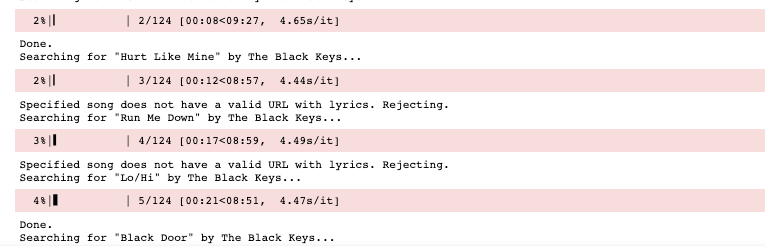

*I had to run the cell multiple times and concatinate onto a dataframe as the Genius server was timing out a lot,
hence the two dataframes below:*

In [18]:
lyrics_df = pd.DataFrame.from_dict({'track_name': song_titles, 'artist_name': song_artists, 'release_year': releases, 
                                    'spotify_uri': uris,'genius_url':urls, 'lyrics':lyrs})

In [19]:
lyrics_df

,track_name,artist_name,release_year,spotify_uri,genius_url,lyrics
0,Where Did My Baby Go?,John Legend,None,spotify:track:0BeszcgF5pRvIpBG23SY54,NaN,[Hook]\nWhere did my baby go?\nI wonder where ...
1,Wanna Be Loved,John Legend,2013-08-30,spotify:track:1FGINGTZ23XJRf68sN60T9,NaN,[Produced by Ali Shaheed Muhammad & Doc McKinn...
2,Penthouse Floor,John Legend,2016-11-16,spotify:track:4bCqxEfZ0i6Oz6I0hpfM7a,NaN,[Verse 1: John Legend]\nAll this trouble in th...
3,Another Again,John Legend,2007-01-09,spotify:track:3RosKiBPZx5vDEbkpIi5bH,NaN,[Verse 1]\nSo we did it again\nKnowing we shou...
4,If You’re Out There,John Legend,2008-10-28,spotify:track:4jWNwr5r9emJVwNeYCgJY7,NaN,"If you hear this message, wherever you stand\n..."
...,...,...,...,...,...,...
1059,​tonite (electric lady sessions),LCD Soundsystem,2018-09-12,NaN,NaN,"[Verse 1]\nYeah, everybody's singing the same ..."
1060,One Touch,LCD Soundsystem,2010-05-17,spotify:track:6nlmCGmPBYfdKnMpavObQm,NaN,I don't think that we will be pleased with thi...
1061,(we don’t need this) fascist groove thang (ele...,LCD Soundsystem,2018-11-02,NaN,NaN,[Intro]\nEverybody move to prove the groove\nE...
1062,All I Want,LCD Soundsystem,2010-05-17,spotify:track:4Cy0NHJ8Gh0xMdwyM9RkQm,NaN,[Verse 1]\nWait for the day you come home from...


In [31]:
missing_songs_dict = missing_songs(artists, artist_dict, lyrics_df)
missing_songs_dict

{'John Legend': ['Slow Dance',
  'Temporarily Painless',
  'Each Day Gets Better',
  'Where Did My Baby Go',
  'Darkness and Light',
  'Live It Up',
  'Number One',
  'The Beginning...',
  'How Can I Blame You',
  'Open Your Eyes',
  "If You're Out There",
  'A Good Night',
  'Under the Stars',
  'Asylum',
  'Used to Love U',
  'Stay With You',
  'Show Me',
  'Tomorrow',
  'For the First Time',
  'Humanity (Love the Way It Should Be)',
  'I Know Better',
  'Start A Fire',
  'Again',
  'Love In The Future (Intro)',
  'Prelude',
  'Take Me Away',
  'Bliss',
  'Bring Me Love',
  "P.D.A. (We Just Don't Care)",
  'Hold On Longer',
  "Refuge (When It's Cold Outside)",
  'Caught Up',
  'Save The Night',
  "She Don't Have to Know",
  'Sin City',
  'Stereo',
  'Wrap Me Up in Your Love',
  'What You Do to Me',
  'No Place Like Home',
  'Preach',
  'Good Morning',
  'Written In The Stars',
  'Who Do We Think We Are',
  'Aim High',
  'So Gone',
  'Overload',
  'History Has Its Eyes On You',
  'God

In [32]:
song_titles = []
song_artists = []
releases = []
uris = []
urls = []
lyrs = []
for key in missing_songs_dict.keys():
    for song_title in tqdm(missing_songs_dict[key]):
        try:
            song =api.search_song(song_title, key)

            song_json = song.to_json()

            try:
                song_titles.append(song.title)
            except:
                song_titles.append(np.nan)

            try:
                song_artists.append(song.artist)
            except:
                song_artists.append(np.nan)

            try:
                releases.append(song.year)
            except:
                releases.append(np.nan)

            uri = np.nan
            for i in range(0,len(song.media)):
                if 'native_uri' in song.media[i].keys():
                    uri = song.media[i]['native_uri']
                else:
                    pass
            uris.append(uri)


            try:
                urls.append(song_json['songs'][0]['url'])
            except:
                urls.append(np.nan)

            try:
                lyrs.append(song.lyrics)
            except:
                lyrs.append(np.nan)
        except:
            pass

  0%|          | 0/48 [00:00<?, ?it/s]

Searching for "Slow Dance" by John Legend...


  2%|▏         | 1/48 [00:01<01:08,  1.45s/it]

Searching for "Temporarily Painless" by John Legend...


  4%|▍         | 2/48 [00:06<01:54,  2.49s/it]

Done.
Searching for "Each Day Gets Better" by John Legend...


  6%|▋         | 3/48 [00:07<01:37,  2.17s/it]

Searching for "Where Did My Baby Go" by John Legend...


  8%|▊         | 4/48 [00:11<01:58,  2.68s/it]

Done.
Searching for "Darkness and Light" by John Legend...


 10%|█         | 5/48 [00:14<02:02,  2.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Live It Up" by John Legend...


 12%|█▎        | 6/48 [00:16<01:42,  2.45s/it]

Searching for "Number One" by John Legend...


 15%|█▍        | 7/48 [00:21<02:09,  3.17s/it]

Done.
Searching for "The Beginning..." by John Legend...


 17%|█▋        | 8/48 [00:24<02:06,  3.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "How Can I Blame You" by John Legend...


 19%|█▉        | 9/48 [00:28<02:16,  3.51s/it]

Done.
Searching for "Open Your Eyes" by John Legend...


 21%|██        | 10/48 [00:30<01:48,  2.87s/it]

Searching for "If You're Out There" by John Legend...


 23%|██▎       | 11/48 [00:34<01:58,  3.21s/it]

Done.
Searching for "A Good Night" by John Legend...


 25%|██▌       | 12/48 [00:35<01:37,  2.71s/it]

Searching for "Under the Stars" by John Legend...


 27%|██▋       | 13/48 [00:39<01:49,  3.14s/it]

Done.
Searching for "Asylum" by John Legend...


 29%|██▉       | 14/48 [00:44<01:57,  3.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Used to Love U" by John Legend...


 31%|███▏      | 15/48 [00:45<01:37,  2.96s/it]

Searching for "Stay With You" by John Legend...


 33%|███▎      | 16/48 [00:50<01:54,  3.58s/it]

Done.
Searching for "Show Me" by John Legend...


 35%|███▌      | 17/48 [00:57<02:16,  4.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tomorrow" by John Legend...


 38%|███▊      | 18/48 [00:58<01:44,  3.47s/it]

Searching for "For the First Time" by John Legend...


 40%|███▉      | 19/48 [01:03<01:52,  3.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Humanity (Love the Way It Should Be)" by John Legend...


 42%|████▏     | 20/48 [01:08<01:56,  4.16s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Know Better" by John Legend...


 44%|████▍     | 21/48 [01:09<01:32,  3.42s/it]

Searching for "Start A Fire" by John Legend...


 46%|████▌     | 22/48 [01:14<01:36,  3.69s/it]

Done.
Searching for "Again" by John Legend...


 48%|████▊     | 23/48 [01:19<01:44,  4.18s/it]

Done.
Searching for "Love In The Future (Intro)" by John Legend...


 50%|█████     | 24/48 [01:24<01:43,  4.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Prelude" by John Legend...


 52%|█████▏    | 25/48 [01:27<01:33,  4.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Take Me Away" by John Legend...


 54%|█████▍    | 26/48 [01:32<01:33,  4.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bliss" by John Legend...


 56%|█████▋    | 27/48 [01:38<01:40,  4.79s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bring Me Love" by John Legend...


 58%|█████▊    | 28/48 [01:42<01:29,  4.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "P.D.A. (We Just Don't Care)" by John Legend...


 60%|██████    | 29/48 [01:47<01:29,  4.73s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hold On Longer" by John Legend...


 62%|██████▎   | 30/48 [01:53<01:30,  5.02s/it]

Done.
Searching for "Refuge (When It's Cold Outside)" by John Legend...


 65%|██████▍   | 31/48 [01:54<01:08,  4.01s/it]

Searching for "Caught Up" by John Legend...


 67%|██████▋   | 32/48 [01:55<00:51,  3.19s/it]

Searching for "Save The Night" by John Legend...


 69%|██████▉   | 33/48 [01:57<00:39,  2.66s/it]

Searching for "She Don't Have to Know" by John Legend...


 71%|███████   | 34/48 [01:58<00:31,  2.24s/it]

Searching for "Sin City" by John Legend...


 73%|███████▎  | 35/48 [02:03<00:40,  3.10s/it]

Done.
Searching for "Stereo" by John Legend...


 75%|███████▌  | 36/48 [02:08<00:42,  3.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wrap Me Up in Your Love" by John Legend...


 77%|███████▋  | 37/48 [02:12<00:42,  3.86s/it]

Done.
Searching for "What You Do to Me" by John Legend...


 79%|███████▉  | 38/48 [02:18<00:43,  4.32s/it]

Done.
Searching for "No Place Like Home" by John Legend...


 81%|████████▏ | 39/48 [02:19<00:31,  3.47s/it]

Searching for "Preach" by John Legend...


 83%|████████▎ | 40/48 [02:23<00:29,  3.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Good Morning" by John Legend...


 85%|████████▌ | 41/48 [02:25<00:21,  3.03s/it]

Searching for "Written In The Stars" by John Legend...


 88%|████████▊ | 42/48 [02:29<00:20,  3.40s/it]

Done.
Searching for "Who Do We Think We Are" by John Legend...


 90%|████████▉ | 43/48 [02:35<00:20,  4.01s/it]

Done.
Searching for "Aim High" by John Legend...


 92%|█████████▏| 44/48 [02:40<00:18,  4.51s/it]

Done.
Searching for "So Gone" by John Legend...


 94%|█████████▍| 45/48 [02:44<00:12,  4.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Overload" by John Legend...


 96%|█████████▌| 46/48 [02:46<00:06,  3.45s/it]

Searching for "History Has Its Eyes On You" by John Legend...


 98%|█████████▊| 47/48 [02:47<00:02,  2.84s/it]

Searching for "God Only Knows" by John Legend...


  0%|          | 0/20 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Someone Like You" by Adele...


  5%|▌         | 1/20 [00:03<01:08,  3.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All I Ask" by Adele...


 10%|█         | 2/20 [00:07<01:04,  3.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Crazy For You" by Adele...


 15%|█▌        | 3/20 [00:08<00:49,  2.93s/it]

Searching for "River Lea" by Adele...


 20%|██        | 4/20 [00:13<00:58,  3.65s/it]

Done.
Searching for "Best For Last" by Adele...


 25%|██▌       | 5/20 [00:18<00:58,  3.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Daydreamer" by Adele...


 30%|███       | 6/20 [00:24<01:05,  4.69s/it]

Done.
Searching for "Skyfall - Full Length" by Adele...


 35%|███▌      | 7/20 [00:28<00:57,  4.39s/it]

Done.
Searching for "Rolling In The Deep" by Adele...


 40%|████      | 8/20 [00:30<00:42,  3.52s/it]

Searching for "First Love" by Adele...


 45%|████▌     | 9/20 [00:34<00:42,  3.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "One And Only" by Adele...


 50%|█████     | 10/20 [00:39<00:40,  4.01s/it]

Done.
Searching for "I'll Be Waiting" by Adele...


 55%|█████▌    | 11/20 [00:40<00:29,  3.25s/it]

Searching for "I Miss You" by Adele...


 60%|██████    | 12/20 [00:44<00:27,  3.45s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "He Won't Go" by Adele...


 65%|██████▌   | 13/20 [00:47<00:23,  3.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Send My Love (To Your New Lover)" by Adele...


 70%|███████   | 14/20 [00:51<00:21,  3.56s/it]

Done.
Searching for "Love in the Dark" by Adele...


 75%|███████▌  | 15/20 [00:53<00:14,  2.95s/it]

Searching for "Tired" by Adele...


 80%|████████  | 16/20 [00:57<00:13,  3.28s/it]

Done.
Searching for "Melt My Heart To Stone" by Adele...


 85%|████████▌ | 17/20 [01:01<00:10,  3.44s/it]

Done.
Searching for "Don't You Remember" by Adele...


 90%|█████████ | 18/20 [01:06<00:08,  4.12s/it]

Done.
Searching for "Right As Rain" by Adele...


 95%|█████████▌| 19/20 [01:08<00:03,  3.31s/it]

Searching for "Rumour Has It" by Adele...


  0%|          | 0/20 [00:00<?, ?it/s]

Searching for "Lens" by Frank Ocean...


  5%|▌         | 1/20 [00:05<01:41,  5.35s/it]

Done.
Searching for "Novacane" by Frank Ocean...


 10%|█         | 2/20 [00:06<01:14,  4.15s/it]

Searching for "End" by Frank Ocean...


 15%|█▌        | 3/20 [00:11<01:12,  4.28s/it]

Done.
Searching for "Futura Free" by Frank Ocean...


 20%|██        | 4/20 [00:16<01:13,  4.61s/it]

Done.
Searching for "Sweet Life" by Frank Ocean...


 25%|██▌       | 5/20 [00:21<01:12,  4.80s/it]

Done.
Searching for "Pink + White" by Frank Ocean...


 30%|███       | 6/20 [00:23<00:52,  3.78s/it]

Searching for "Nikes" by Frank Ocean...


 35%|███▌      | 7/20 [00:24<00:39,  3.04s/it]

Searching for "Biking" by Frank Ocean...


 40%|████      | 8/20 [00:28<00:41,  3.42s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nights" by Frank Ocean...


 45%|████▌     | 9/20 [00:36<00:49,  4.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Provider" by Frank Ocean...


 50%|█████     | 10/20 [00:37<00:35,  3.60s/it]

Searching for "Close To You" by Frank Ocean...


 55%|█████▌    | 11/20 [00:41<00:34,  3.85s/it]

Done.
Searching for "Pilot Jones" by Frank Ocean...


 60%|██████    | 12/20 [00:43<00:24,  3.10s/it]

Searching for "Swim Good" by Frank Ocean...


 65%|██████▌   | 13/20 [00:48<00:26,  3.81s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pretty Sweet" by Frank Ocean...


 70%|███████   | 14/20 [00:50<00:18,  3.10s/it]

Searching for "Thinkin Bout You" by Frank Ocean...


 75%|███████▌  | 15/20 [00:56<00:19,  3.95s/it]

Done.
Searching for "Forrest Gump" by Frank Ocean...


 80%|████████  | 16/20 [01:02<00:19,  4.80s/it]

Done.
Searching for "Pink Matter" by Frank Ocean...


 85%|████████▌ | 17/20 [01:07<00:14,  4.89s/it]

Done.
Searching for "Solo" by Frank Ocean...


 90%|█████████ | 18/20 [01:12<00:09,  4.79s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Biking (Solo)" by Frank Ocean...


 95%|█████████▌| 19/20 [01:13<00:03,  3.77s/it]

Searching for "White Ferrari" by Frank Ocean...


  0%|          | 0/48 [00:00<?, ?it/s]

Searching for "It Ain't Fair" by Aretha Franklin...


  2%|▏         | 1/48 [00:03<03:00,  3.83s/it]

Done.
Searching for "What a Friend We Have in Jesus" by Aretha Franklin...


  4%|▍         | 2/48 [00:05<02:25,  3.15s/it]

Searching for "Do Right Woman - Do Right Man" by Aretha Franklin...


  6%|▋         | 3/48 [00:09<02:35,  3.47s/it]

Done.
Searching for "Hello Sunshine" by Aretha Franklin...


  8%|▊         | 4/48 [00:13<02:40,  3.65s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bridge over Troubled Water" by Aretha Franklin...


 10%|█         | 5/48 [00:15<02:07,  2.97s/it]

Searching for "Until You Come Back to Me (That's What I'm Gonna Do)" by Aretha Franklin...


 12%|█▎        | 6/48 [00:16<01:43,  2.47s/it]

Searching for "Mary, Don't You Weep" by Aretha Franklin...


 15%|█▍        | 7/48 [00:17<01:28,  2.16s/it]

Searching for "Jump to It" by Aretha Franklin...


 17%|█▋        | 8/48 [00:21<01:42,  2.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Call Me" by Aretha Franklin...


 19%|█▉        | 9/48 [00:25<01:55,  2.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "It Hurts Like Hell" by Aretha Franklin...


 21%|██        | 10/48 [00:27<01:39,  2.63s/it]

Searching for "Spirit in the Dark" by Aretha Franklin...


 23%|██▎       | 11/48 [00:28<01:25,  2.32s/it]

Searching for "You're All I Need to Get By" by Aretha Franklin...


 25%|██▌       | 12/48 [00:33<01:49,  3.03s/it]

Done.
Searching for "My Way" by Aretha Franklin...


 27%|██▋       | 13/48 [00:37<02:00,  3.45s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "(You Make Me Feel Like) a Natural Woman [with the Royal Philharmonic Orchestra]" by Aretha Franklin...


 29%|██▉       | 14/48 [00:39<01:34,  2.79s/it]

No results found for: '(You Make Me Feel Like) a Natural Woman [with the Royal Philharmonic Orchestra] Aretha Franklin'
Searching for "Don't Play That Song" by Aretha Franklin...


 31%|███▏      | 15/48 [00:43<01:49,  3.30s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Say a Little Prayer" by Aretha Franklin...


 33%|███▎      | 16/48 [00:48<02:01,  3.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Respect (with The Royal Philharmonic Orchestra)" by Aretha Franklin...


 35%|███▌      | 17/48 [00:51<01:52,  3.61s/it]

Done.
Searching for "Chain of Fools" by Aretha Franklin...


 38%|███▊      | 18/48 [00:57<02:04,  4.15s/it]

Done.
Searching for "Ain't No Way" by Aretha Franklin...


 40%|███▉      | 19/48 [00:59<01:45,  3.64s/it]

Searching for "(You Make Me Feel Like) A Natural Woman" by Aretha Franklin...


 42%|████▏     | 20/48 [01:00<01:22,  2.94s/it]

Searching for "Do Right Woman, Do Right Man" by Aretha Franklin...


 44%|████▍     | 21/48 [01:04<01:28,  3.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rock Steady" by Aretha Franklin...


 46%|████▌     | 22/48 [01:11<01:51,  4.30s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You're All I Need to Get By - Take 2" by Aretha Franklin...


 48%|████▊     | 23/48 [01:16<01:48,  4.35s/it]

Done.
Searching for "Dr. Feelgood (Love Is a Serious Business)" by Aretha Franklin...


 50%|█████     | 24/48 [01:20<01:45,  4.41s/it]

Done.
Searching for "Medley: Precious Lord, Take My Hand / You've Got a Friend - Medley" by Aretha Franklin...


 52%|█████▏    | 25/48 [01:24<01:34,  4.13s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Medley: Precious Lord, Take My Hand / You've Got a Friend" by Aretha Franklin...


 54%|█████▍    | 26/48 [01:27<01:25,  3.87s/it]

Done.
Searching for "Baby, Baby, Baby" by Aretha Franklin...


 56%|█████▋    | 27/48 [01:32<01:30,  4.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Change Is Gonna Come" by Aretha Franklin...


 58%|█████▊    | 28/48 [01:34<01:08,  3.42s/it]

Searching for "You Keep Me Hangin' On" by Aretha Franklin...


 60%|██████    | 29/48 [01:37<01:06,  3.51s/it]

Done.
Searching for "Baby, I Love You" by Aretha Franklin...


 62%|██████▎   | 30/48 [01:41<01:02,  3.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Oh Happy Day - Live" by Aretha Franklin...


 65%|██████▍   | 31/48 [01:43<00:51,  3.05s/it]

Done.
Searching for "I'm Every Woman / Respect" by Aretha Franklin...


 67%|██████▋   | 32/48 [01:49<01:06,  4.16s/it]

Done.
Searching for "Climbing Higher Mountains" by Aretha Franklin...


 69%|██████▉   | 33/48 [01:52<00:55,  3.73s/it]

Searching for "Rock-A-Bye Your Baby with a Dixie Melody" by Aretha Franklin...


 71%|███████   | 34/48 [01:54<00:42,  3.04s/it]

Searching for "The Shoop Shoop Song (It's in His Kiss)" by Aretha Franklin...


 73%|███████▎  | 35/48 [02:00<00:51,  3.98s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Drown in My Own Tears" by Aretha Franklin...


 75%|███████▌  | 36/48 [02:03<00:46,  3.91s/it]

Done.
Searching for "Midnight Train To Georgia" by Aretha Franklin...


 77%|███████▋  | 37/48 [02:08<00:45,  4.18s/it]

Done.
Searching for "Groovin'" by Aretha Franklin...


 79%|███████▉  | 38/48 [02:14<00:45,  4.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Who's Zoomin' Who?" by Aretha Franklin...


 81%|████████▏ | 39/48 [02:19<00:41,  4.66s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "(Sweet Sweet Baby) Since You've Been Gone" by Aretha Franklin...


 83%|████████▎ | 40/48 [02:22<00:33,  4.24s/it]

Done.
Searching for "Night Time Is the Right Time" by Aretha Franklin...


 85%|████████▌ | 41/48 [02:26<00:28,  4.07s/it]

Done.
Searching for "You're All I Need to Get By (with The Royal Philharmonic Orchestra)" by Aretha Franklin...


 88%|████████▊ | 42/48 [02:27<00:19,  3.21s/it]

No results found for: 'You're All I Need to Get By (with The Royal Philharmonic Orchestra) Aretha Franklin'
Searching for "Good Times" by Aretha Franklin...


 90%|████████▉ | 43/48 [02:31<00:17,  3.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Rose Is Still a Rose" by Aretha Franklin...


 92%|█████████▏| 44/48 [02:34<00:14,  3.50s/it]

Done.
Searching for "Son of a Preacher Man" by Aretha Franklin...


 94%|█████████▍| 45/48 [02:38<00:10,  3.41s/it]

Done.
Searching for "I Never Loved a Man (The Way I Love You)" by Aretha Franklin...


 96%|█████████▌| 46/48 [02:44<00:08,  4.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Never Loved a Man (The Way I Love You) - Stereo" by Aretha Franklin...


 98%|█████████▊| 47/48 [02:45<00:03,  3.36s/it]

No results found for: 'I Never Loved a Man (The Way I Love You) - Stereo Aretha Franklin'
Searching for "Amazing Grace" by Aretha Franklin...


  0%|          | 0/35 [00:00<?, ?it/s]

Searching for "Best Friend - Acoustic" by Amy Winehouse...


  3%|▎         | 1/35 [00:01<00:44,  1.32s/it]

Searching for "Just Friends" by Amy Winehouse...


  6%|▌         | 2/35 [00:07<01:29,  2.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Best Friends, Right?" by Amy Winehouse...


  9%|▊         | 3/35 [00:08<01:13,  2.31s/it]

Searching for "I Heard Love Is Blind" by Amy Winehouse...


 11%|█▏        | 4/35 [00:10<01:02,  2.03s/it]

Searching for "Fuck Me Pumps" by Amy Winehouse...


 14%|█▍        | 5/35 [00:13<01:17,  2.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Heard Love Is Blind - Live" by Amy Winehouse...


 17%|█▋        | 6/35 [00:15<01:05,  2.28s/it]

Searching for "The Girl From Ipanema" by Amy Winehouse...


 20%|██        | 7/35 [00:19<01:22,  2.93s/it]

Done.
Searching for "Will You Still Love Me Tomorrow? - 2011" by Amy Winehouse...


 23%|██▎       | 8/35 [00:22<01:19,  2.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Moody's Mood For Love / Teo Licks" by Amy Winehouse...


 26%|██▌       | 9/35 [00:24<01:04,  2.48s/it]

Searching for "Rehab - Live On Jools Holland" by Amy Winehouse...


 29%|██▊       | 10/35 [00:27<01:08,  2.75s/it]

Done.
Searching for "October Song" by Amy Winehouse...


 31%|███▏      | 11/35 [00:29<00:58,  2.43s/it]

Searching for "Mr Magic (Through The Smoke) - Live, Janice Long Session, Miami/2008" by Amy Winehouse...


 34%|███▍      | 12/35 [00:32<01:02,  2.70s/it]

Done.
Searching for "A Song For You" by Amy Winehouse...


 37%|███▋      | 13/35 [00:37<01:13,  3.35s/it]

Done.
Searching for "Like Smoke" by Amy Winehouse...


 40%|████      | 14/35 [00:44<01:30,  4.30s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wake Up Alone - Original Recording" by Amy Winehouse...


 43%|████▎     | 15/35 [00:45<01:09,  3.46s/it]

Searching for "Fool's Gold" by Amy Winehouse...


 46%|████▌     | 16/35 [00:48<00:59,  3.15s/it]

Searching for "You're Wondering Now" by Amy Winehouse...


 49%|████▊     | 17/35 [00:53<01:06,  3.72s/it]

Done.
Searching for "'Round Midnight" by Amy Winehouse...


 51%|█████▏    | 18/35 [00:54<00:53,  3.17s/it]

Searching for "Cherry" by Amy Winehouse...


 54%|█████▍    | 19/35 [00:57<00:48,  3.02s/it]

Searching for "Mr Magic (Through The Smoke)" by Amy Winehouse...


 57%|█████▋    | 20/35 [01:02<00:53,  3.55s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Body And Soul" by Amy Winehouse...


 60%|██████    | 21/35 [01:08<00:58,  4.19s/it]

Done.
Searching for "You Know I'm No Good" by Amy Winehouse...


 63%|██████▎   | 22/35 [01:16<01:12,  5.55s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Back To Black" by Amy Winehouse...


 66%|██████▌   | 23/35 [01:24<01:13,  6.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Some Unholy War - Down Tempo" by Amy Winehouse...


 69%|██████▊   | 24/35 [01:27<00:57,  5.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Stronger Than Me - Later With Jools Holland, London / 2003" by Amy Winehouse...


 71%|███████▏  | 25/35 [01:30<00:46,  4.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Moody's Mood For Love" by Amy Winehouse...


 74%|███████▍  | 26/35 [01:31<00:32,  3.64s/it]

Searching for "Between The Cheats" by Amy Winehouse...


 77%|███████▋  | 27/35 [01:38<00:35,  4.39s/it]

Done.
Searching for "Take The Box" by Amy Winehouse...


 80%|████████  | 28/35 [01:41<00:28,  4.08s/it]

Searching for "Love Is A Losing Game" by Amy Winehouse...


 83%|████████▎ | 29/35 [01:52<00:36,  6.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "To Know Him Is To Love Him - Live" by Amy Winehouse...


 86%|████████▌ | 30/35 [01:56<00:28,  5.67s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tears Dry On Their Own" by Amy Winehouse...


 89%|████████▊ | 31/35 [02:02<00:22,  5.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You Sent Me Flying / Cherry" by Amy Winehouse...


 91%|█████████▏| 32/35 [02:03<00:12,  4.28s/it]

Specified song does not contain lyrics. Rejecting.
Searching for "Wake Up Alone" by Amy Winehouse...


 94%|█████████▍| 33/35 [02:09<00:09,  4.84s/it]

Done.
Searching for "Me & Mr Jones" by Amy Winehouse...


 97%|█████████▋| 34/35 [02:14<00:04,  4.85s/it]

Done.
Searching for "Rehab" by Amy Winehouse...


  0%|          | 0/5 [00:00<?, ?it/s]

Searching for "Angie" by The Rolling Stones...


 20%|██        | 1/5 [00:06<00:26,  6.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Doo Doo Doo Doo Doo (Heartbreaker)" by The Rolling Stones...


 40%|████      | 2/5 [00:11<00:18,  6.21s/it]

Done.
Searching for "Monkey Man" by The Rolling Stones...


 60%|██████    | 3/5 [00:15<00:10,  5.30s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You Can't Always Get What You Want" by The Rolling Stones...


 80%|████████  | 4/5 [00:17<00:04,  4.41s/it]

Searching for "Mother's Little Helper" by The Rolling Stones...


  0%|          | 0/13 [00:00<?, ?it/s]

Done.
Searching for "Ten Years Gone" by Led Zeppelin...


  8%|▊         | 1/13 [00:01<00:20,  1.68s/it]

Searching for "D'yer Mak'er" by Led Zeppelin...


 15%|█▌        | 2/13 [00:07<00:31,  2.87s/it]

Done.
Searching for "The Song Remains the Same" by Led Zeppelin...


 23%|██▎       | 3/13 [00:13<00:37,  3.74s/it]

Done.
Searching for "Trampled Under Foot" by Led Zeppelin...


 31%|███       | 4/13 [00:14<00:28,  3.18s/it]

Searching for "In the Evening" by Led Zeppelin...


 38%|███▊      | 5/13 [00:16<00:21,  2.64s/it]

Searching for "Stairway to Heaven" by Led Zeppelin...


 46%|████▌     | 6/13 [00:23<00:28,  4.06s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Houses of the Holy" by Led Zeppelin...


 54%|█████▍    | 7/13 [00:32<00:32,  5.38s/it]

Done.
Searching for "Bron-Yr-Aur" by Led Zeppelin...


 62%|██████▏   | 8/13 [00:35<00:24,  4.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Down by the Seaside" by Led Zeppelin...


 69%|██████▉   | 9/13 [00:42<00:21,  5.32s/it]

Done.
Searching for "Black Dog" by Led Zeppelin...


 77%|███████▋  | 10/13 [00:48<00:16,  5.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nobody's Fault But Mine" by Led Zeppelin...


 85%|████████▍ | 11/13 [00:49<00:08,  4.26s/it]

Searching for "Fool in the Rain" by Led Zeppelin...


 92%|█████████▏| 12/13 [00:52<00:03,  3.98s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hey Hey What Can I Do" by Led Zeppelin...


  0%|          | 0/41 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Love is a Laserquest" by Arctic Monkeys...


  2%|▏         | 1/41 [00:05<03:23,  5.09s/it]

Done.
Searching for "The World's First Ever Monster Truck Front Flip" by Arctic Monkeys...


  5%|▍         | 2/41 [00:09<03:14,  4.99s/it]

Done.
Searching for "She's Thunderstorms" by Arctic Monkeys...


  7%|▋         | 3/41 [00:11<02:30,  3.96s/it]

Searching for "Leave Before The Lights Come On" by Arctic Monkeys...


 10%|▉         | 4/41 [00:19<03:08,  5.10s/it]

Done.
Searching for "Mardy Bum" by Arctic Monkeys...


 12%|█▏        | 5/41 [00:29<03:58,  6.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fake Tales Of San Francisco" by Arctic Monkeys...


 15%|█▍        | 6/41 [00:34<03:41,  6.32s/it]

Done.
Searching for "D Is For Dangerous" by Arctic Monkeys...


 17%|█▋        | 7/41 [00:42<03:43,  6.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Four Out Of Five" by Arctic Monkeys...


 20%|█▉        | 8/41 [00:48<03:32,  6.44s/it]

Done.
Searching for "Black Treacle" by Arctic Monkeys...


 22%|██▏       | 9/41 [00:50<02:46,  5.21s/it]

Searching for "This House Is A Circus" by Arctic Monkeys...


 24%|██▍       | 10/41 [00:56<02:47,  5.41s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Bet You Look Good On The Dancefloor" by Arctic Monkeys...


 27%|██▋       | 11/41 [01:00<02:29,  4.98s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fluorescent Adolescent" by Arctic Monkeys...


 29%|██▉       | 12/41 [01:07<02:43,  5.65s/it]

Done.
Searching for "A Certain Romance" by Arctic Monkeys...


 32%|███▏      | 13/41 [01:09<02:03,  4.40s/it]

Searching for "American Sports" by Arctic Monkeys...


 34%|███▍      | 14/41 [01:13<01:55,  4.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Perhaps Vampires Is A Bit Strong But…" by Arctic Monkeys...


 37%|███▋      | 15/41 [01:23<02:39,  6.14s/it]

Done.
Searching for "Baby I'm Yours" by Arctic Monkeys...


 39%|███▉      | 16/41 [01:25<01:58,  4.74s/it]

Searching for "Who The Fuck Are Arctic Monkeys?" by Arctic Monkeys...


 41%|████▏     | 17/41 [01:29<01:48,  4.52s/it]

Done.
Searching for "Golden Trunks" by Arctic Monkeys...


 44%|████▍     | 18/41 [01:30<01:23,  3.64s/it]

Searching for "Piledriver Waltz" by Arctic Monkeys...


 46%|████▋     | 19/41 [01:32<01:05,  2.96s/it]

Searching for "My Propeller" by Arctic Monkeys...


 49%|████▉     | 20/41 [01:33<00:52,  2.50s/it]

Searching for "From The Ritz To The Rubble" by Arctic Monkeys...


 51%|█████     | 21/41 [01:39<01:10,  3.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "One For The Road" by Arctic Monkeys...


 54%|█████▎    | 22/41 [01:41<00:56,  2.97s/it]

Searching for "Still Take You Home" by Arctic Monkeys...


 56%|█████▌    | 23/41 [01:42<00:45,  2.51s/it]

Searching for "Fireside" by Arctic Monkeys...


 59%|█████▊    | 24/41 [01:46<00:51,  3.05s/it]

Done.
Searching for "When The Sun Goes Down" by Arctic Monkeys...


 61%|██████    | 25/41 [01:50<00:50,  3.18s/it]

Done.
Searching for "Snap Out Of It" by Arctic Monkeys...


 63%|██████▎   | 26/41 [01:55<00:56,  3.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You Probably Couldn't See For The Lights But You Were Staring Straight At Me" by Arctic Monkeys...


 66%|██████▌   | 27/41 [02:00<00:57,  4.14s/it]

Done.
Searching for "Pretty Visitors" by Arctic Monkeys...


 68%|██████▊   | 28/41 [02:04<00:54,  4.16s/it]

Done.
Searching for "Stop The World I Wanna Get Off With You" by Arctic Monkeys...


 71%|███████   | 29/41 [02:07<00:45,  3.81s/it]

Done.
Searching for "No Buses" by Arctic Monkeys...


 73%|███████▎  | 30/41 [02:10<00:39,  3.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Despair In The Departure Lounge" by Arctic Monkeys...


 76%|███████▌  | 31/41 [02:14<00:36,  3.64s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Batphone" by Arctic Monkeys...


 78%|███████▊  | 32/41 [02:15<00:26,  2.94s/it]

Searching for "Mad Sounds" by Arctic Monkeys...


 80%|████████  | 33/41 [02:20<00:26,  3.31s/it]

Done.
Searching for "Star Treatment" by Arctic Monkeys...


 83%|████████▎ | 34/41 [02:24<00:25,  3.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Don't Sit Down 'Cause I've Moved Your Chair" by Arctic Monkeys...


 85%|████████▌ | 35/41 [02:28<00:22,  3.79s/it]

Done.
Searching for "Dangerous Animals" by Arctic Monkeys...


 88%|████████▊ | 36/41 [02:32<00:18,  3.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Science Fiction" by Arctic Monkeys...


 90%|█████████ | 37/41 [02:35<00:14,  3.73s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Arabella" by Arctic Monkeys...


 93%|█████████▎| 38/41 [02:37<00:09,  3.18s/it]

Searching for "The Hellcat Spangled Shalalala" by Arctic Monkeys...


 95%|█████████▌| 39/41 [02:42<00:07,  3.67s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Do Me A Favour" by Arctic Monkeys...


 98%|█████████▊| 40/41 [02:43<00:02,  2.96s/it]

Searching for "Why'd You Only Call Me When You're High?" by Arctic Monkeys...


  0%|          | 0/2 [00:00<?, ?it/s]

Done.
Searching for "Hey Jude" by The Beatles...


 50%|█████     | 1/2 [00:06<00:06,  6.50s/it]

Done.
Searching for "Getting Better" by The Beatles...


  0%|          | 0/19 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "We Will Rock You" by Queen...


  5%|▌         | 1/19 [00:09<02:56,  9.82s/it]

Done.
Searching for "Love Of My Life" by Queen...


 11%|█         | 2/19 [00:14<02:18,  8.13s/it]

Done.
Searching for "Don't Stop Me Now - …revisited" by Queen...


 16%|█▌        | 3/19 [00:17<01:49,  6.82s/it]

Done.
Searching for "Bohemian Rhapsody - Live Aid" by Queen...


 21%|██        | 4/19 [00:22<01:32,  6.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fat Bottomed Girls - Live in Paris" by Queen...


 26%|██▋       | 5/19 [00:24<01:07,  4.82s/it]

Searching for "Keep Yourself Alive" by Queen...


 32%|███▏      | 6/19 [00:28<01:02,  4.80s/it]

Done.
Searching for "Don't Stop Me Now" by Queen...


 37%|███▋      | 7/19 [00:37<01:10,  5.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Want To Break Free" by Queen...


 42%|████▏     | 8/19 [00:38<00:50,  4.56s/it]

Searching for "Ay-Oh - Live Aid" by Queen...


 47%|████▋     | 9/19 [00:44<00:48,  4.87s/it]

Done.
Searching for "Radio Ga Ga" by Queen...


 53%|█████▎    | 10/19 [00:45<00:34,  3.85s/it]

Searching for "Somebody To Love" by Queen...


 58%|█████▊    | 11/19 [00:50<00:33,  4.20s/it]

Done.
Searching for "Hammer To Fall - Live Aid" by Queen...


 63%|██████▎   | 12/19 [00:53<00:27,  3.87s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "No-One But You (Only The Good Die Young)" by Queen...


 68%|██████▊   | 13/19 [00:55<00:18,  3.11s/it]

Searching for "Hammer To Fall" by Queen...


 74%|███████▎  | 14/19 [01:01<00:20,  4.04s/it]

Done.
Searching for "We Are The Champions - Live Aid" by Queen...


 79%|███████▉  | 15/19 [01:07<00:18,  4.63s/it]

Done.
Searching for "Under Pressure" by Queen...


 84%|████████▍ | 16/19 [01:13<00:15,  5.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Radio Ga Ga - Live Aid" by Queen...


 89%|████████▉ | 17/19 [01:16<00:08,  4.32s/it]

Searching for "We Are The Champions" by Queen...


 95%|█████████▍| 18/19 [01:18<00:03,  3.72s/it]

Searching for "Killer Queen" by Queen...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.
Searching for "Sugar, We're Goin Down" by Fall Out Boy...


  2%|▏         | 1/50 [00:05<04:44,  5.80s/it]

Done.
Searching for "Novocaine" by Fall Out Boy...


  4%|▍         | 2/50 [00:07<03:35,  4.49s/it]

Searching for "Sunshine Riptide" by Fall Out Boy...


  6%|▌         | 3/50 [00:12<03:35,  4.58s/it]

Done.
Searching for "Fourth Of July" by Fall Out Boy...


  8%|▊         | 4/50 [00:13<02:46,  3.61s/it]

Searching for "Disloyal Order Of Water Buffaloes" by Fall Out Boy...


 10%|█         | 5/50 [00:17<02:52,  3.83s/it]

Done.
Searching for "Tiffany Blews" by Fall Out Boy...


 12%|█▏        | 6/50 [00:23<03:15,  4.45s/it]

Done.
Searching for "She's My Winona" by Fall Out Boy...


 14%|█▍        | 7/50 [00:26<02:44,  3.83s/it]

Searching for "Death Valley" by Fall Out Boy...


 16%|█▌        | 8/50 [00:32<03:13,  4.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "7 Minutes In Heaven (Atavan Halen)" by Fall Out Boy...


 18%|█▊        | 9/50 [00:37<03:17,  4.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Last Of The Real Ones" by Fall Out Boy...


 20%|██        | 10/50 [00:41<02:58,  4.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Chicago Is so Two Years Ago" by Fall Out Boy...


 22%|██▏       | 11/50 [00:46<03:05,  4.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Slept With Someone In Fall Out Boy And All I Got Was This Stupid Song Written About Me" by Fall Out Boy...


 24%|██▍       | 12/50 [00:51<03:03,  4.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sophomore Slump Or Comeback Of The Year" by Fall Out Boy...


 26%|██▌       | 13/50 [00:58<03:19,  5.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I'm Like A Lawyer With The Way I'm Always Trying To Get You Off (Me & You)" by Fall Out Boy...


 28%|██▊       | 14/50 [01:01<02:51,  4.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dead on Arrival" by Fall Out Boy...


 30%|███       | 15/50 [01:03<02:10,  3.74s/it]

Searching for "What A Catch, Donnie" by Fall Out Boy...


 32%|███▏      | 16/50 [01:04<01:42,  3.03s/it]

Searching for "My Songs Know What You Did In The Dark (Light Em Up)" by Fall Out Boy...


 34%|███▍      | 17/50 [01:09<01:58,  3.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Twin Skeleton's (Hotel In NYC)" by Fall Out Boy...


 36%|███▌      | 18/50 [01:15<02:19,  4.36s/it]

Done.
Searching for "American Beauty/American Psycho" by Fall Out Boy...


 38%|███▊      | 19/50 [01:19<02:11,  4.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Thriller" by Fall Out Boy...


 40%|████      | 20/50 [01:25<02:26,  4.90s/it]

Done.
Searching for "Wilson (Expensive Mistakes)" by Fall Out Boy...


 42%|████▏     | 21/50 [01:29<02:08,  4.43s/it]

Searching for "Dance, Dance" by Fall Out Boy...


 44%|████▍     | 22/50 [01:32<01:56,  4.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Immortals" by Fall Out Boy...


 46%|████▌     | 23/50 [01:37<02:00,  4.46s/it]

Done.
Searching for "Jet Pack Blues" by Fall Out Boy...


 48%|████▊     | 24/50 [01:42<01:52,  4.34s/it]

Done.
Searching for "This Ain't A Scene, It's An Arms Race" by Fall Out Boy...


 50%|█████     | 25/50 [01:46<01:50,  4.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "City In A Garden" by Fall Out Boy...


 52%|█████▏    | 26/50 [01:52<01:56,  4.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Champagne For My Real Friends, Real Pain For My Sham Friends" by Fall Out Boy...


 54%|█████▍    | 27/50 [01:57<01:53,  4.91s/it]

Done.
Searching for "Thnks fr th Mmrs" by Fall Out Boy...


 56%|█████▌    | 28/50 [01:59<01:25,  3.88s/it]

Searching for "HOLD ME TIGHT OR DON’T" by Fall Out Boy...


 58%|█████▊    | 29/50 [02:03<01:23,  3.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Champion" by Fall Out Boy...


 60%|██████    | 30/50 [02:08<01:24,  4.21s/it]

Done.
Searching for "Our Lawyer Made Us Change The Name Of This Song So We Wouldn't Get Sued" by Fall Out Boy...


 62%|██████▏   | 31/50 [02:14<01:33,  4.93s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Little Less Sixteen Candles, A Little More "Touch Me"" by Fall Out Boy...


 64%|██████▍   | 32/50 [02:19<01:28,  4.94s/it]

Done.
Searching for "Of All The Gin Joints In All The World" by Fall Out Boy...


 66%|██████▌   | 33/50 [02:23<01:17,  4.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Super Fade" by Fall Out Boy...


 68%|██████▊   | 34/50 [02:24<00:58,  3.65s/it]

Searching for "Young And Menace" by Fall Out Boy...


 70%|███████   | 35/50 [02:28<00:53,  3.59s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bishops Knife Trick" by Fall Out Boy...


 72%|███████▏  | 36/50 [02:33<00:57,  4.13s/it]

Done.
Searching for "20 Dollar Nose Bleed" by Fall Out Boy...


 74%|███████▍  | 37/50 [02:39<01:01,  4.75s/it]

Done.
Searching for "Favorite Record" by Fall Out Boy...


 76%|███████▌  | 38/50 [02:46<01:02,  5.20s/it]

Done.
Searching for "Rat A Tat" by Fall Out Boy...


 78%|███████▊  | 39/50 [02:52<01:02,  5.72s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Heaven’s Gate" by Fall Out Boy...


 80%|████████  | 40/50 [02:57<00:52,  5.24s/it]

Done.
Searching for "Where Did The Party Go" by Fall Out Boy...


 82%|████████▏ | 41/50 [03:00<00:43,  4.83s/it]

Done.
Searching for "Nobody Puts Baby In The Corner" by Fall Out Boy...


 84%|████████▍ | 42/50 [03:06<00:39,  4.96s/it]

Done.
Searching for "Alone Together" by Fall Out Boy...


 86%|████████▌ | 43/50 [03:12<00:36,  5.23s/it]

Done.
Searching for "Miss Missing You" by Fall Out Boy...


 88%|████████▊ | 44/50 [03:15<00:28,  4.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hum Hallelujah" by Fall Out Boy...


 90%|█████████ | 45/50 [03:20<00:23,  4.76s/it]

Done.
Searching for "Save Rock And Roll" by Fall Out Boy...


 92%|█████████▏| 46/50 [03:25<00:19,  4.91s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Kids Aren't Alright" by Fall Out Boy...


 94%|█████████▍| 47/50 [03:27<00:11,  4.00s/it]

Searching for ""The Take Over, The Breaks Over"" by Fall Out Boy...


 96%|█████████▌| 48/50 [03:32<00:08,  4.32s/it]

Done.
Searching for "Lake Effect Kid" by Fall Out Boy...


 98%|█████████▊| 49/50 [03:34<00:03,  3.52s/it]

Searching for "America's Suitehearts" by Fall Out Boy...


  0%|          | 0/20 [00:00<?, ?it/s]

Searching for "Half Full Glass Of Wine" by Tame Impala...


  5%|▌         | 1/20 [00:04<01:30,  4.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Past Life" by Tame Impala...


 10%|█         | 2/20 [00:08<01:19,  4.41s/it]

Done.
Searching for "Love/Paranoia" by Tame Impala...


 15%|█▌        | 3/20 [00:12<01:15,  4.46s/it]

Done.
Searching for "Sundown Syndrome" by Tame Impala...


 20%|██        | 4/20 [00:21<01:32,  5.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Why Won't They Talk To Me?" by Tame Impala...


 25%|██▌       | 5/20 [00:24<01:14,  4.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Why Won't You Make Up Your Mind?" by Tame Impala...


 30%|███       | 6/20 [00:30<01:10,  5.04s/it]

Done.
Searching for "Music To Walk Home By" by Tame Impala...


 35%|███▌      | 7/20 [00:34<01:04,  4.94s/it]

Done.
Searching for "Disciples" by Tame Impala...


 40%|████      | 8/20 [00:40<01:00,  5.03s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Moment" by Tame Impala...


 45%|████▌     | 9/20 [00:41<00:43,  3.95s/it]

Searching for "Solitude Is Bliss" by Tame Impala...


 50%|█████     | 10/20 [00:42<00:31,  3.18s/it]

Searching for "Reality In Motion" by Tame Impala...


 55%|█████▌    | 11/20 [00:47<00:33,  3.77s/it]

Done.
Searching for "Yes I'm Changing" by Tame Impala...


 60%|██████    | 12/20 [00:49<00:24,  3.05s/it]

Searching for "Apocalypse Dreams" by Tame Impala...


 65%|██████▌   | 13/20 [00:53<00:23,  3.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nangs" by Tame Impala...


 70%|███████   | 14/20 [00:57<00:20,  3.49s/it]

Done.
Searching for "Gossip" by Tame Impala...


 75%|███████▌  | 15/20 [01:01<00:19,  3.81s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "'Cause I'm A Man" by Tame Impala...


 80%|████████  | 16/20 [01:03<00:12,  3.08s/it]

Searching for "Mind Mischief" by Tame Impala...


 85%|████████▌ | 17/20 [01:06<00:09,  3.22s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "New Person, Same Old Mistakes" by Tame Impala...


 90%|█████████ | 18/20 [01:10<00:06,  3.45s/it]

Done.
Searching for "List Of People (To Try And Forget About)" by Tame Impala...


 95%|█████████▌| 19/20 [01:12<00:02,  2.83s/it]

Searching for "The Less I Know The Better" by Tame Impala...


  0%|          | 0/27 [00:00<?, ?it/s]

Done.
Searching for "You Came To Me" by Beach House...


  4%|▎         | 1/27 [00:03<01:36,  3.72s/it]

Done.
Searching for "10:37" by Beach House...


  7%|▋         | 2/27 [00:07<01:30,  3.60s/it]

Searching for "Master of None" by Beach House...


 11%|█         | 3/27 [00:11<01:30,  3.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Real Love" by Beach House...


 15%|█▍        | 4/27 [00:14<01:26,  3.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "On the Sea" by Beach House...


 19%|█▊        | 5/27 [00:19<01:28,  4.02s/it]

Done.
Searching for "Norway" by Beach House...


 22%|██▏       | 6/27 [00:21<01:09,  3.32s/it]

Searching for "Auburn and Ivory" by Beach House...


 26%|██▌       | 7/27 [00:24<01:08,  3.42s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Drunk In LA" by Beach House...


 30%|██▉       | 8/27 [00:28<01:06,  3.52s/it]

Done.
Searching for "Alien" by Beach House...


 33%|███▎      | 9/27 [00:30<00:51,  2.87s/it]

Searching for "Girl Of The Year" by Beach House...


 37%|███▋      | 10/27 [00:35<01:02,  3.68s/it]

Done.
Searching for "Beyond Love" by Beach House...


 41%|████      | 11/27 [00:40<01:04,  4.02s/it]

Done.
Searching for "Days of Candy" by Beach House...


 44%|████▍     | 12/27 [00:44<00:58,  3.93s/it]

Done.
Searching for "She's So Lovely" by Beach House...


 48%|████▊     | 13/27 [00:47<00:50,  3.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sparks" by Beach House...


 52%|█████▏    | 14/27 [00:51<00:50,  3.87s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Woo" by Beach House...


 56%|█████▌    | 15/27 [00:57<00:52,  4.38s/it]

Done.
Searching for "10 Mile Stereo" by Beach House...


 59%|█████▉    | 16/27 [01:04<00:59,  5.36s/it]

Done.
Searching for "Elegy to the Void" by Beach House...


 63%|██████▎   | 17/27 [01:08<00:50,  5.01s/it]

Done.
Searching for "L'Inconnue" by Beach House...


 67%|██████▋   | 18/27 [01:12<00:40,  4.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Black Car" by Beach House...


 70%|███████   | 19/27 [01:16<00:35,  4.39s/it]

Done.
Searching for "Zebra" by Beach House...


 74%|███████▍  | 20/27 [01:23<00:35,  5.08s/it]

Done.
Searching for "Equal Mind" by Beach House...


 78%|███████▊  | 21/27 [01:26<00:27,  4.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Hours" by Beach House...


 81%|████████▏ | 22/27 [01:31<00:22,  4.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Gila" by Beach House...


 85%|████████▌ | 23/27 [01:34<00:16,  4.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Space Song" by Beach House...


 89%|████████▉ | 24/27 [01:36<00:10,  3.61s/it]

Searching for "Lemon Glow" by Beach House...


 93%|█████████▎| 25/27 [01:40<00:07,  3.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Last Ride" by Beach House...


 96%|█████████▋| 26/27 [01:43<00:03,  3.55s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Levitation" by Beach House...


  0%|          | 0/28 [00:00<?, ?it/s]

Done.
Searching for "Sex on Fire" by Kings of Leon...


  4%|▎         | 1/28 [00:05<02:36,  5.81s/it]

Done.
Searching for "Closer" by Kings of Leon...


  7%|▋         | 2/28 [00:09<02:12,  5.11s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Waste A Moment" by Kings of Leon...


 11%|█         | 3/28 [00:14<02:09,  5.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mi Amigo" by Kings of Leon...


 14%|█▍        | 4/28 [00:20<02:09,  5.38s/it]

Done.
Searching for "Birthday" by Kings of Leon...


 18%|█▊        | 5/28 [00:22<01:37,  4.25s/it]

Searching for "Knocked Up" by Kings of Leon...


 21%|██▏       | 6/28 [00:26<01:34,  4.31s/it]

Done.
Searching for "Crawl" by Kings of Leon...


 25%|██▌       | 7/28 [00:30<01:26,  4.12s/it]

Done.
Searching for "Supersoaker" by Kings of Leon...


 29%|██▊       | 8/28 [00:34<01:21,  4.07s/it]

Done.
Searching for "Revelry" by Kings of Leon...


 32%|███▏      | 9/28 [00:38<01:18,  4.15s/it]

Done.
Searching for "Comeback Story" by Kings of Leon...


 36%|███▌      | 10/28 [00:44<01:25,  4.77s/it]

Done.
Searching for "Temple" by Kings of Leon...


 39%|███▉      | 11/28 [00:52<01:35,  5.60s/it]

Done.
Searching for "17" by Kings of Leon...


 43%|████▎     | 12/28 [00:54<01:14,  4.63s/it]

Searching for "Pickup Truck" by Kings of Leon...


 46%|████▋     | 13/28 [01:00<01:16,  5.09s/it]

Done.
Searching for "Cold Desert" by Kings of Leon...


 50%|█████     | 14/28 [01:06<01:11,  5.14s/it]

Done.
Searching for "The Face" by Kings of Leon...


 54%|█████▎    | 15/28 [01:09<01:01,  4.70s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Red Morning Light" by Kings of Leon...


 57%|█████▋    | 16/28 [01:13<00:53,  4.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Over" by Kings of Leon...


 61%|██████    | 17/28 [01:17<00:46,  4.18s/it]

Done.
Searching for "Eyes On You" by Kings of Leon...


 64%|██████▍   | 18/28 [01:18<00:33,  3.36s/it]

Searching for "Reverend" by Kings of Leon...


 68%|██████▊   | 19/28 [01:26<00:42,  4.71s/it]

Done.
Searching for "Muchacho" by Kings of Leon...


 71%|███████▏  | 20/28 [01:27<00:29,  3.70s/it]

Searching for "On Call" by Kings of Leon...


 75%|███████▌  | 21/28 [01:31<00:25,  3.65s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Molly's Chambers" by Kings of Leon...


 79%|███████▊  | 22/28 [01:32<00:18,  3.00s/it]

Searching for "California Waiting" by Kings of Leon...


 82%|████████▏ | 23/28 [01:36<00:16,  3.21s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Around The World" by Kings of Leon...


 86%|████████▌ | 24/28 [01:37<00:10,  2.68s/it]

Searching for "Be Somebody" by Kings of Leon...


 89%|████████▉ | 25/28 [01:42<00:09,  3.28s/it]

Done.
Searching for "Ragoo" by Kings of Leon...


 93%|█████████▎| 26/28 [01:46<00:06,  3.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wait for Me" by Kings of Leon...


 96%|█████████▋| 27/28 [01:49<00:03,  3.44s/it]

Done.
Searching for "Rock City" by Kings of Leon...


  0%|          | 0/48 [00:00<?, ?it/s]

Done.
Searching for "Sail To The Moon" by Radiohead...


  2%|▏         | 1/48 [00:04<03:12,  4.10s/it]

Done.
Searching for "In Limbo" by Radiohead...


  4%|▍         | 2/48 [00:09<03:29,  4.55s/it]

Done.
Searching for "You And Whose Army?" by Radiohead...


  6%|▋         | 3/48 [00:11<02:47,  3.73s/it]

Searching for "Knives Out" by Radiohead...


  8%|▊         | 4/48 [00:15<02:47,  3.80s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ill Wind" by Radiohead...


 10%|█         | 5/48 [00:16<02:06,  2.95s/it]

Searching for "True Love Waits" by Radiohead...


 12%|█▎        | 6/48 [00:20<02:13,  3.17s/it]

Searching for "My Iron Lung (2 Meter Session)" by Radiohead...


 15%|█▍        | 7/48 [00:21<01:48,  2.65s/it]

Searching for "Talk Show Host" by Radiohead...


 17%|█▋        | 8/48 [00:26<02:09,  3.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Optimistic" by Radiohead...


 19%|█▉        | 9/48 [00:31<02:26,  3.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Exit Music (For a Film)" by Radiohead...


 21%|██        | 10/48 [00:35<02:32,  4.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bullet Proof ... I Wish I Was" by Radiohead...


 23%|██▎       | 11/48 [00:41<02:47,  4.54s/it]

Done.
Searching for "The National Anthem" by Radiohead...


 25%|██▌       | 12/48 [00:43<02:12,  3.67s/it]

Searching for "My Iron Lung" by Radiohead...


 27%|██▋       | 13/48 [00:47<02:18,  3.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Idioteque" by Radiohead...


 29%|██▉       | 14/48 [00:51<02:15,  3.98s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sulk" by Radiohead...


 31%|███▏      | 15/48 [00:53<01:45,  3.19s/it]

Searching for "Daydreaming" by Radiohead...


 33%|███▎      | 16/48 [00:54<01:28,  2.76s/it]

Searching for "Lotus Flower" by Radiohead...


 35%|███▌      | 17/48 [00:58<01:29,  2.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Creep" by Radiohead...


 38%|███▊      | 18/48 [01:09<02:41,  5.39s/it]

Done.
Searching for "Just" by Radiohead...


 40%|███▉      | 19/48 [01:13<02:28,  5.11s/it]

Done.
Searching for "Go To Sleep" by Radiohead...


 42%|████▏     | 20/48 [01:19<02:28,  5.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Weird Fishes/ Arpeggi" by Radiohead...


 44%|████▍     | 21/48 [01:25<02:25,  5.37s/it]

Done.
Searching for "Airbag" by Radiohead...


 46%|████▌     | 22/48 [01:26<01:50,  4.26s/it]

Searching for "Electioneering" by Radiohead...


 48%|████▊     | 23/48 [01:32<01:54,  4.56s/it]

Done.
Searching for "Pyramid Song" by Radiohead...


 50%|█████     | 24/48 [01:37<01:57,  4.90s/it]

Done.
Searching for "Planet Telex" by Radiohead...


 52%|█████▏    | 25/48 [01:39<01:29,  3.91s/it]

Searching for "Spectre" by Radiohead...


 54%|█████▍    | 26/48 [01:43<01:30,  4.12s/it]

Done.
Searching for "Bloom" by Radiohead...


 56%|█████▋    | 27/48 [01:46<01:13,  3.52s/it]

Searching for "The Bends" by Radiohead...


 58%|█████▊    | 28/48 [01:47<00:58,  2.92s/it]

Searching for "The Tourist" by Radiohead...


 60%|██████    | 29/48 [01:51<00:59,  3.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "15 Step" by Radiohead...


 62%|██████▎   | 30/48 [01:56<01:10,  3.90s/it]

Done.
Searching for "Everything In Its Right Place" by Radiohead...


 65%|██████▍   | 31/48 [02:02<01:16,  4.48s/it]

Done.
Searching for "Morning Bell" by Radiohead...


 67%|██████▋   | 32/48 [02:07<01:13,  4.57s/it]

Done.
Searching for "Street Spirit (Fade Out)" by Radiohead...


 69%|██████▉   | 33/48 [02:09<00:55,  3.68s/it]

Searching for "Man of War" by Radiohead...


 71%|███████   | 34/48 [02:10<00:41,  3.00s/it]

Searching for "(Nice Dream)" by Radiohead...


 73%|███████▎  | 35/48 [02:14<00:43,  3.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nude" by Radiohead...


 75%|███████▌  | 36/48 [02:20<00:48,  4.02s/it]

Done.
Searching for "Identikit" by Radiohead...


 77%|███████▋  | 37/48 [02:25<00:47,  4.31s/it]

Done.
Searching for "Fake Plastic Trees" by Radiohead...


 79%|███████▉  | 38/48 [02:30<00:46,  4.68s/it]

Done.
Searching for "Desert Island Disk" by Radiohead...


 81%|████████▏ | 39/48 [02:34<00:39,  4.34s/it]

Done.
Searching for "High And Dry" by Radiohead...


 83%|████████▎ | 40/48 [02:35<00:27,  3.47s/it]

Searching for "How To Disappear Completely" by Radiohead...


 85%|████████▌ | 41/48 [02:40<00:26,  3.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Burn the Witch" by Radiohead...


 88%|████████▊ | 42/48 [02:41<00:18,  3.06s/it]

Searching for "Black Star" by Radiohead...


 90%|████████▉ | 43/48 [02:46<00:17,  3.59s/it]

Done.
Searching for "A Wolf At the Door" by Radiohead...


 92%|█████████▏| 44/48 [02:51<00:15,  3.90s/it]

Done.
Searching for "House Of Cards" by Radiohead...


 94%|█████████▍| 45/48 [02:56<00:12,  4.20s/it]

Done.
Searching for "Videotape" by Radiohead...


 96%|█████████▌| 46/48 [02:57<00:06,  3.45s/it]

Searching for "I Might Be Wrong" by Radiohead...


 98%|█████████▊| 47/48 [02:59<00:02,  2.80s/it]

Searching for "Subterranean Homesick Alien" by Radiohead...


100%|██████████| 48/48 [03:03<00:00,  3.82s/it]
0it [00:00, ?it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "On Melancholy Hill" by Gorillaz...


  4%|▍         | 1/24 [00:01<00:35,  1.55s/it]

Searching for "Slow Country" by Gorillaz...


  8%|▊         | 2/24 [00:06<00:55,  2.54s/it]

Done.
Searching for "Sound Check (Gravity)" by Gorillaz...


 12%|█▎        | 3/24 [00:12<01:13,  3.51s/it]

Done.
Searching for "Fire Coming out of the Monkey's Head" by Gorillaz...


 17%|█▋        | 4/24 [00:13<00:58,  2.90s/it]

Searching for "O Green World" by Gorillaz...


 21%|██        | 5/24 [00:18<01:08,  3.63s/it]

Done.
Searching for "Feel Good Inc" by Gorillaz...


 25%|██▌       | 6/24 [00:25<01:19,  4.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Kids With Guns" by Gorillaz...


 29%|██▉       | 7/24 [00:28<01:11,  4.19s/it]

Done.
Searching for "Tomorrow Comes Today" by Gorillaz...


 33%|███▎      | 8/24 [00:33<01:08,  4.31s/it]

Done.
Searching for "Kansas" by Gorillaz...


 38%|███▊      | 9/24 [00:35<00:52,  3.49s/it]

Searching for "Souk Eye" by Gorillaz...


 42%|████▏     | 10/24 [00:38<00:49,  3.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Magic City" by Gorillaz...


 46%|████▌     | 11/24 [00:40<00:38,  2.98s/it]

Searching for "5/4" by Gorillaz...


 50%|█████     | 12/24 [00:41<00:30,  2.52s/it]

Searching for "Latin Simone (Que Pasa Contigo)" by Gorillaz...


 54%|█████▍    | 13/24 [00:43<00:23,  2.14s/it]

Searching for "Fire Flies" by Gorillaz...


 58%|█████▊    | 14/24 [00:46<00:25,  2.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rock the House" by Gorillaz...


 62%|██████▎   | 15/24 [00:48<00:20,  2.22s/it]

Searching for "Fire Coming Out Of The Monkey's Head" by Gorillaz...


 67%|██████▋   | 16/24 [00:51<00:20,  2.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Clint Eastwood - Ed Case / Sweetie Irie Refix" by Gorillaz...


 71%|███████   | 17/24 [00:56<00:23,  3.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All Alone" by Gorillaz...


 75%|███████▌  | 18/24 [01:01<00:22,  3.72s/it]

Done.
Searching for "Dracula" by Gorillaz...


 79%|███████▉  | 19/24 [01:05<00:19,  3.91s/it]

Done.
Searching for "El Manana" by Gorillaz...


 83%|████████▎ | 20/24 [01:08<00:15,  3.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tranz" by Gorillaz...


 88%|████████▊ | 21/24 [01:13<00:11,  3.96s/it]

Done.
Searching for "Last Living Souls" by Gorillaz...


 92%|█████████▏| 22/24 [01:14<00:06,  3.19s/it]

Searching for "Dirty Harry" by Gorillaz...


 96%|█████████▌| 23/24 [01:18<00:03,  3.41s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "El Mañana" by Gorillaz...


  0%|          | 0/60 [00:00<?, ?it/s]

Done.
Searching for "Until It's Gone" by Linkin Park...


  2%|▏         | 1/60 [00:01<01:36,  1.63s/it]

Searching for "Lying from You - Live LP Underground Tour 2003" by Linkin Park...


  3%|▎         | 2/60 [00:03<01:33,  1.62s/it]

No results found for: 'Lying from You - Live LP Underground Tour 2003 Linkin Park'
Searching for "Blackout" by Linkin Park...


  5%|▌         | 3/60 [00:06<02:04,  2.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Valentine's Day" by Linkin Park...


  7%|▋         | 4/60 [00:08<01:52,  2.00s/it]

Searching for "Battle Symphony" by Linkin Park...


  8%|▊         | 5/60 [00:11<02:18,  2.51s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Waiting For The End" by Linkin Park...


 10%|█         | 6/60 [00:16<02:45,  3.06s/it]

Done.
Searching for "In Between" by Linkin Park...


 12%|█▏        | 7/60 [00:20<02:53,  3.28s/it]

Done.
Searching for "Hands Held High" by Linkin Park...


 13%|█▎        | 8/60 [00:23<02:52,  3.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "BURN IT DOWN" by Linkin Park...


 15%|█▌        | 9/60 [00:25<02:22,  2.79s/it]

Searching for "Lying from You" by Linkin Park...


 17%|█▋        | 10/60 [00:29<02:48,  3.37s/it]

Done.
Searching for "A LIGHT THAT NEVER COMES" by Linkin Park...


 18%|█▊        | 11/60 [00:34<03:07,  3.84s/it]

Done.
Searching for "In The End" by Linkin Park...


 20%|██        | 12/60 [00:40<03:37,  4.53s/it]

Done.
Searching for "High Voltage" by Linkin Park...


 22%|██▏       | 13/60 [00:45<03:37,  4.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Leave Out All The Rest" by Linkin Park...


 23%|██▎       | 14/60 [00:51<03:49,  4.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Place For My Head" by Linkin Park...


 25%|██▌       | 15/60 [00:56<03:48,  5.07s/it]

Done.
Searching for "Faint" by Linkin Park...


 27%|██▋       | 16/60 [00:58<02:53,  3.95s/it]

Searching for "Nobody Can Save Me" by Linkin Park...


 28%|██▊       | 17/60 [01:01<02:47,  3.89s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "IN MY REMAINS" by Linkin Park...


 30%|███       | 18/60 [01:06<02:49,  4.04s/it]

Done.
Searching for "Points Of Authority" by Linkin Park...


 32%|███▏      | 19/60 [01:10<02:44,  4.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Shadow Of The Day" by Linkin Park...


 33%|███▎      | 20/60 [01:14<02:39,  3.98s/it]

Done.
Searching for "When They Come For Me" by Linkin Park...


 35%|███▌      | 21/60 [01:17<02:32,  3.91s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "P5hng Me Aw*y" by Linkin Park...


 37%|███▋      | 22/60 [01:19<02:01,  3.21s/it]

No results found for: 'P5hng Me Aw*y Linkin Park'
Searching for "Pts.OF.Athrty" by Linkin Park...


 38%|███▊      | 23/60 [01:24<02:19,  3.77s/it]

Done.
Searching for "Figure.09" by Linkin Park...


 40%|████      | 24/60 [01:29<02:28,  4.12s/it]

Done.
Searching for "Cure For The Itch" by Linkin Park...


 42%|████▏     | 25/60 [01:30<01:54,  3.29s/it]

Searching for "From the Inside" by Linkin Park...


 43%|████▎     | 26/60 [01:32<01:33,  2.76s/it]

Searching for "Talking to Myself" by Linkin Park...


 45%|████▌     | 27/60 [01:38<02:04,  3.76s/it]

Done.
Searching for "Runaway" by Linkin Park...


 47%|████▋     | 28/60 [01:42<02:05,  3.91s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Crawling" by Linkin Park...


 48%|████▊     | 29/60 [01:47<02:12,  4.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wretches and Kings" by Linkin Park...


 50%|█████     | 30/60 [01:49<01:42,  3.43s/it]

Searching for "Easier to Run" by Linkin Park...


 52%|█████▏    | 31/60 [01:52<01:39,  3.42s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wastelands" by Linkin Park...


 53%|█████▎    | 32/60 [01:54<01:18,  2.81s/it]

Searching for "Breaking The Habit" by Linkin Park...


 55%|█████▌    | 33/60 [01:55<01:03,  2.35s/it]

Searching for "I'LL BE GONE" by Linkin Park...


 57%|█████▋    | 34/60 [01:56<00:55,  2.14s/it]

Searching for "Forgotten" by Linkin Park...


 58%|█████▊    | 35/60 [01:58<00:48,  1.94s/it]

Searching for "ROADS UNTRAVELED" by Linkin Park...


 60%|██████    | 36/60 [01:59<00:42,  1.76s/it]

Searching for "One Step Closer" by Linkin Park...


 62%|██████▏   | 37/60 [02:05<01:08,  2.97s/it]

Done.
Searching for "New Divide" by Linkin Park...


 63%|██████▎   | 38/60 [02:07<00:57,  2.61s/it]

Searching for "Nobody's Listening" by Linkin Park...


 65%|██████▌   | 39/60 [02:11<01:02,  2.98s/it]

Done.
Searching for "Wake" by Linkin Park...


 67%|██████▋   | 40/60 [02:15<01:05,  3.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Burning In The Skies" by Linkin Park...


 68%|██████▊   | 41/60 [02:18<01:04,  3.41s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "1stp Klosr" by Linkin Park...


 70%|███████   | 42/60 [02:23<01:09,  3.84s/it]

Done.
Searching for "The Catalyst" by Linkin Park...


 72%|███████▏  | 43/60 [02:28<01:07,  3.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "What I've Done" by Linkin Park...


 73%|███████▎  | 44/60 [02:29<00:51,  3.22s/it]

Searching for "Points of Authority" by Linkin Park...


 75%|███████▌  | 45/60 [02:32<00:46,  3.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Halfway Right" by Linkin Park...


 77%|███████▋  | 46/60 [02:37<00:51,  3.68s/it]

Done.
Searching for "My December" by Linkin Park...


 78%|███████▊  | 47/60 [02:42<00:53,  4.11s/it]

Done.
Searching for "Wretches And Kings" by Linkin Park...


 80%|████████  | 48/60 [02:44<00:40,  3.38s/it]

Searching for "Somewhere I Belong" by Linkin Park...


 82%|████████▏ | 49/60 [02:45<00:30,  2.81s/it]

Searching for "Easier To Run" by Linkin Park...


 83%|████████▎ | 50/60 [02:48<00:29,  2.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "In Pieces" by Linkin Park...


 85%|████████▌ | 51/60 [02:53<00:32,  3.59s/it]

Done.
Searching for "Lying From You" by Linkin Park...


 87%|████████▋ | 52/60 [02:57<00:27,  3.46s/it]

Done.
Searching for "No More Sorrow" by Linkin Park...


 88%|████████▊ | 53/60 [03:00<00:23,  3.38s/it]

Done.
Searching for "Sorry for Now" by Linkin Park...


 90%|█████████ | 54/60 [03:01<00:17,  2.84s/it]

Searching for "Don't Stay" by Linkin Park...


 92%|█████████▏| 55/60 [03:05<00:15,  3.01s/it]

Done.
Searching for "Krwlng" by Linkin Park...


 93%|█████████▎| 56/60 [03:10<00:14,  3.55s/it]

Done.
Searching for "A Line In The Sand" by Linkin Park...


 95%|█████████▌| 57/60 [03:11<00:08,  2.91s/it]

Searching for "From The Inside" by Linkin Park...


 97%|█████████▋| 58/60 [03:14<00:05,  2.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hit The Floor" by Linkin Park...


 98%|█████████▊| 59/60 [03:18<00:03,  3.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "TINFOIL" by Linkin Park...


  0%|          | 0/78 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Under The Gun" by The Black Keys...


  1%|▏         | 1/78 [00:03<04:29,  3.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hurt Like Mine" by The Black Keys...


  3%|▎         | 2/78 [00:06<04:18,  3.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Run Me Down" by The Black Keys...


  4%|▍         | 3/78 [00:10<04:18,  3.45s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Black Door" by The Black Keys...


  5%|▌         | 4/78 [00:14<04:37,  3.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Howlin' For You" by The Black Keys...


  6%|▋         | 5/78 [00:18<04:30,  3.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sister" by The Black Keys...


  8%|▊         | 6/78 [00:21<04:23,  3.66s/it]

Done.
Searching for "Modern Times" by The Black Keys...


  9%|▉         | 7/78 [00:26<04:34,  3.87s/it]

Done.
Searching for "Keep Me" by The Black Keys...


 10%|█         | 8/78 [00:30<04:34,  3.92s/it]

Done.
Searching for "Just Got to Be" by The Black Keys...


 12%|█▏        | 9/78 [00:34<04:27,  3.88s/it]

Done.
Searching for "In Our Prime" by The Black Keys...


 13%|█▎        | 10/78 [00:39<04:48,  4.25s/it]

Done.
Searching for "My Mind Is Ramblin" by The Black Keys...


 14%|█▍        | 11/78 [00:40<03:52,  3.47s/it]

Searching for "The Baddest Man Alive" by The Black Keys...


 15%|█▌        | 12/78 [00:44<03:45,  3.42s/it]

Done.
Searching for "Ohio" by The Black Keys...


 17%|█▋        | 13/78 [00:47<03:49,  3.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Do The Rump" by The Black Keys...


 18%|█▊        | 14/78 [00:52<04:02,  3.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fire Walk With Me" by The Black Keys...


 19%|█▉        | 15/78 [00:56<03:59,  3.81s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Little Black Submarines - Radio Edit" by The Black Keys...


 21%|██        | 16/78 [00:59<03:45,  3.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I'm Not The One" by The Black Keys...


 22%|██▏       | 17/78 [01:01<03:05,  3.05s/it]

Searching for "Have Mercy on Me" by The Black Keys...


 23%|██▎       | 18/78 [01:02<02:32,  2.55s/it]

Searching for "Nobody but You" by The Black Keys...


 24%|██▍       | 19/78 [01:06<02:51,  2.90s/it]

Done.
Searching for "I Cry Alone" by The Black Keys...


 26%|██▌       | 20/78 [01:07<02:30,  2.59s/it]

Searching for "Strange Desire" by The Black Keys...


 27%|██▋       | 21/78 [01:11<02:42,  2.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Just Couldn't Tie Me Down" by The Black Keys...


 28%|██▊       | 22/78 [01:15<03:01,  3.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Everywhere I Go" by The Black Keys...


 29%|██▉       | 23/78 [01:21<03:47,  4.14s/it]

Done.
Searching for "Yearnin' (live)" by The Black Keys...


 31%|███       | 24/78 [01:27<04:05,  4.55s/it]

Done.
Searching for "Never Gonna Give You Up" by The Black Keys...


 32%|███▏      | 25/78 [01:30<03:39,  4.15s/it]

Done.
Searching for "Meet Me in the City" by The Black Keys...


 33%|███▎      | 26/78 [01:34<03:29,  4.04s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Unknown Brother" by The Black Keys...


 35%|███▍      | 27/78 [01:38<03:23,  4.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Thickfreakness" by The Black Keys...


 36%|███▌      | 28/78 [01:43<03:33,  4.28s/it]

Done.
Searching for "Money Maker" by The Black Keys...


 37%|███▋      | 29/78 [01:47<03:31,  4.31s/it]

Done.
Searching for "She's Long Gone" by The Black Keys...


 38%|███▊      | 30/78 [01:51<03:19,  4.16s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mind Eraser" by The Black Keys...


 40%|███▉      | 31/78 [01:56<03:24,  4.34s/it]

Done.
Searching for "Work Me" by The Black Keys...


 41%|████      | 32/78 [01:57<02:43,  3.55s/it]

Searching for "Have Love Will Travel" by The Black Keys...


 42%|████▏     | 33/78 [02:00<02:34,  3.42s/it]

Done.
Searching for "Little Black Submarines - radio edit" by The Black Keys...


 44%|████▎     | 34/78 [02:05<02:42,  3.69s/it]

Done.
Searching for "Yearnin'" by The Black Keys...


 45%|████▍     | 35/78 [02:09<02:49,  3.93s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Keep Your Hands off Her" by The Black Keys...


 46%|████▌     | 36/78 [02:14<02:55,  4.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dearest" by The Black Keys...


 47%|████▋     | 37/78 [02:18<02:48,  4.11s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Goodbye Babylon" by The Black Keys...


 49%|████▊     | 38/78 [02:21<02:35,  3.89s/it]

Done.
Searching for "Sit Around And Miss You" by The Black Keys...


 50%|█████     | 39/78 [02:25<02:23,  3.68s/it]

Done.
Searching for "Hard Row" by The Black Keys...


 51%|█████▏    | 40/78 [02:26<01:52,  2.97s/it]

Searching for "Leavin' Trunk" by The Black Keys...


 53%|█████▎    | 41/78 [02:28<01:42,  2.78s/it]

Searching for "So He Won't Break" by The Black Keys...


 54%|█████▍    | 42/78 [02:32<01:52,  3.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Act Nice and Gentle" by The Black Keys...


 55%|█████▌    | 43/78 [02:35<01:49,  3.14s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hold Me in Your Arms" by The Black Keys...


 56%|█████▋    | 44/78 [02:39<01:48,  3.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Weight of Love" by The Black Keys...


 58%|█████▊    | 45/78 [02:42<01:52,  3.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tell Me Lies" by The Black Keys...


 59%|█████▉    | 46/78 [02:47<02:01,  3.81s/it]

Done.
Searching for "Junior's Instrumental" by The Black Keys...


 60%|██████    | 47/78 [02:49<01:34,  3.06s/it]

Specified song does not contain lyrics. Rejecting.
Searching for "Year in Review" by The Black Keys...


 62%|██████▏   | 48/78 [02:54<01:50,  3.69s/it]

Done.
Searching for "Girl Is on My Mind" by The Black Keys...


 63%|██████▎   | 49/78 [02:55<01:26,  2.98s/it]

Searching for "Breaks" by The Black Keys...


 64%|██████▍   | 50/78 [02:59<01:30,  3.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Too Afraid To Love You" by The Black Keys...


 65%|██████▌   | 51/78 [03:01<01:21,  3.01s/it]

Searching for "Remember When" by The Black Keys...


 67%|██████▋   | 52/78 [03:03<01:05,  2.52s/it]

Searching for "Shine A Little Light" by The Black Keys...


 68%|██████▊   | 53/78 [03:06<01:09,  2.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Next Girl" by The Black Keys...


 69%|██████▉   | 54/78 [03:12<01:26,  3.58s/it]

Done.
Searching for "The Wicked Messenger" by The Black Keys...


 71%|███████   | 55/78 [03:15<01:21,  3.54s/it]

Done.
Searching for "You're the One" by The Black Keys...


 72%|███████▏  | 56/78 [03:18<01:14,  3.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Little Black Submarines" by The Black Keys...


 73%|███████▎  | 57/78 [03:26<01:37,  4.67s/it]

Done.
Searching for "If You See Me" by The Black Keys...


 74%|███████▍  | 58/78 [03:30<01:30,  4.50s/it]

Done.
Searching for "Walk Across The Water" by The Black Keys...


 76%|███████▌  | 59/78 [03:34<01:22,  4.33s/it]

Done.
Searching for "Get Yourself Together" by The Black Keys...


 77%|███████▋  | 60/78 [03:37<01:14,  4.14s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bullet In The Brain" by The Black Keys...


 78%|███████▊  | 61/78 [03:42<01:11,  4.19s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Things Ain't Like They Used to Be" by The Black Keys...


 79%|███████▉  | 62/78 [03:43<00:53,  3.35s/it]

Searching for "10 Lovers" by The Black Keys...


 81%|████████  | 63/78 [03:44<00:41,  2.74s/it]

Searching for "If You Ever Slip" by The Black Keys...


 82%|████████▏ | 64/78 [03:50<00:48,  3.45s/it]

Done.
Searching for "The Go Getter" by The Black Keys...


 83%|████████▎ | 65/78 [03:53<00:45,  3.52s/it]

Done.
Searching for "Can't Find My Mind" by The Black Keys...


 85%|████████▍ | 66/78 [03:59<00:49,  4.08s/it]

Done.
Searching for "Grown so Ugly" by The Black Keys...


 86%|████████▌ | 67/78 [04:00<00:35,  3.27s/it]

Searching for "Nova Baby" by The Black Keys...


 87%|████████▋ | 68/78 [04:01<00:26,  2.69s/it]

Searching for "When the Lights Go Out" by The Black Keys...


 88%|████████▊ | 69/78 [04:05<00:26,  3.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Flame" by The Black Keys...


 90%|████████▉ | 70/78 [04:08<00:24,  3.04s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Midnight in Her Eyes" by The Black Keys...


 91%|█████████ | 71/78 [04:10<00:17,  2.53s/it]

Searching for "Oceans & Streams" by The Black Keys...


 92%|█████████▏| 72/78 [04:14<00:18,  3.14s/it]

Done.
Searching for "I'll Be Your Man" by The Black Keys...


 94%|█████████▎| 73/78 [04:16<00:13,  2.71s/it]

Searching for "It's up to You Now" by The Black Keys...


 95%|█████████▍| 74/78 [04:17<00:09,  2.35s/it]

Searching for "Countdown" by The Black Keys...


 96%|█████████▌| 75/78 [04:22<00:09,  3.03s/it]

Done.
Searching for "Waiting on Words" by The Black Keys...


 97%|█████████▋| 76/78 [04:27<00:07,  3.57s/it]

Done.
Searching for "The Desperate Man" by The Black Keys...


 99%|█████████▊| 77/78 [04:32<00:04,  4.02s/it]

Done.
Searching for "Busted" by The Black Keys...


  0%|          | 0/29 [00:00<?, ?it/s]

Done.
Searching for "The Blister Exists" by Slipknot...


  3%|▎         | 1/29 [00:03<01:32,  3.30s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Prosthetics" by Slipknot...


  7%|▋         | 2/29 [00:08<01:45,  3.91s/it]

Done.
Searching for "Goodbye" by Slipknot...


 10%|█         | 3/29 [00:12<01:44,  4.01s/it]

Done.
Searching for "Duality" by Slipknot...


 14%|█▍        | 4/29 [00:18<01:52,  4.50s/it]

Done.
Searching for "Killpop" by Slipknot...


 17%|█▋        | 5/29 [00:23<01:50,  4.61s/it]

Done.
Searching for "Surfacing" by Slipknot...


 21%|██        | 6/29 [00:28<01:51,  4.84s/it]

Done.
Searching for "All Hope Is Gone" by Slipknot...


 24%|██▍       | 7/29 [00:34<01:52,  5.13s/it]

Done.
Searching for "Gently" by Slipknot...


 28%|██▊       | 8/29 [00:38<01:41,  4.83s/it]

Done.
Searching for "The Devil In I" by Slipknot...


 31%|███       | 9/29 [00:43<01:35,  4.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Solway Firth" by Slipknot...


 34%|███▍      | 10/29 [00:48<01:32,  4.85s/it]

Done.
Searching for "Be Prepared For Hell" by Slipknot...


 38%|███▊      | 11/29 [00:53<01:29,  4.95s/it]

Done.
Searching for "Before I Forget" by Slipknot...


 41%|████▏     | 12/29 [01:03<01:47,  6.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tattered & Torn" by Slipknot...


 45%|████▍     | 13/29 [01:04<01:17,  4.85s/it]

Searching for "If Rain Is What You Want" by Slipknot...


 48%|████▊     | 14/29 [01:09<01:13,  4.92s/it]

Done.
Searching for "The Nameless" by Slipknot...


 52%|█████▏    | 15/29 [01:13<01:03,  4.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The One That Kills The Least" by Slipknot...


 55%|█████▌    | 16/29 [01:17<00:56,  4.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Disasterpiece" by Slipknot...


 59%|█████▊    | 17/29 [01:23<01:01,  5.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nomadic" by Slipknot...


 62%|██████▏   | 18/29 [01:27<00:50,  4.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "'Til We Die" by Slipknot...


 66%|██████▌   | 19/29 [01:28<00:36,  3.62s/it]

Searching for "The Burden" by Slipknot...


 69%|██████▉   | 20/29 [01:32<00:33,  3.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sarcastrophe" by Slipknot...


 72%|███████▏  | 21/29 [01:37<00:32,  4.05s/it]

Done.
Searching for "Wait and Bleed" by Slipknot...


 76%|███████▌  | 22/29 [01:42<00:29,  4.20s/it]

Done.
Searching for "Psychosocial" by Slipknot...


 79%|███████▉  | 23/29 [01:43<00:19,  3.33s/it]

Searching for "Pulse of the Maggots" by Slipknot...


 83%|████████▎ | 24/29 [01:44<00:13,  2.72s/it]

Searching for "Skeptic" by Slipknot...


 86%|████████▌ | 25/29 [01:48<00:12,  3.03s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Vermilion" by Slipknot...


 90%|████████▉ | 26/29 [01:54<00:11,  3.98s/it]

Done.
Searching for "Vermilion, Pt. 2" by Slipknot...


 93%|█████████▎| 27/29 [01:59<00:08,  4.26s/it]

Done.
Searching for "Opium of the People" by Slipknot...


 97%|█████████▋| 28/29 [02:02<00:04,  4.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sulfur" by Slipknot...


  0%|          | 0/20 [00:00<?, ?it/s]

Searching for "Until It Sleeps" by Metallica...


  5%|▌         | 1/20 [00:05<01:36,  5.06s/it]

Done.
Searching for "Turn The Page" by Metallica...


 10%|█         | 2/20 [00:08<01:23,  4.65s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Atlas, Rise!" by Metallica...


 15%|█▌        | 3/20 [00:10<01:03,  3.74s/it]

Searching for "Don't Tread On Me" by Metallica...


 20%|██        | 4/20 [00:14<01:01,  3.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Whiskey In The Jar" by Metallica...


 25%|██▌       | 5/20 [00:18<00:58,  3.92s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fuel" by Metallica...


 30%|███       | 6/20 [00:22<00:53,  3.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "St. Anger" by Metallica...


 35%|███▌      | 7/20 [00:26<00:50,  3.88s/it]

Done.
Searching for "Holier Than Thou" by Metallica...


 40%|████      | 8/20 [00:30<00:47,  3.93s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Of Wolf And Man" by Metallica...


 45%|████▌     | 9/20 [00:35<00:47,  4.32s/it]

Done.
Searching for "Spit Out the Bone" by Metallica...


 50%|█████     | 10/20 [00:36<00:34,  3.44s/it]

Searching for "The Unforgiven" by Metallica...


 55%|█████▌    | 11/20 [00:41<00:34,  3.88s/it]

Done.
Searching for "Wherever I May Roam" by Metallica...


 60%|██████    | 12/20 [00:43<00:25,  3.18s/it]

Searching for "Hardwired" by Metallica...


 65%|██████▌   | 13/20 [00:48<00:26,  3.83s/it]

Done.
Searching for "King Nothing" by Metallica...


 70%|███████   | 14/20 [00:52<00:23,  3.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "My Friend Of Misery" by Metallica...


 75%|███████▌  | 15/20 [00:57<00:21,  4.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Day That Never Comes" by Metallica...


 80%|████████  | 16/20 [01:02<00:18,  4.53s/it]

Done.
Searching for "All Nightmare Long" by Metallica...


 85%|████████▌ | 17/20 [01:04<00:10,  3.62s/it]

Searching for "The Unforgiven II" by Metallica...


 90%|█████████ | 18/20 [01:08<00:07,  3.87s/it]

Done.
Searching for "Through The Never" by Metallica...


 95%|█████████▌| 19/20 [01:13<00:03,  4.00s/it]

Done.
Searching for "Now That We're Dead" by Metallica...


  0%|          | 0/26 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Children of the Korn" by Korn...


  4%|▍         | 1/26 [00:01<00:39,  1.58s/it]

Searching for "Evolution" by Korn...


  8%|▊         | 2/26 [00:03<00:36,  1.54s/it]

Searching for "Shoots and Ladders" by Korn...


 12%|█▏        | 3/26 [00:04<00:33,  1.46s/it]

Searching for "It's On!" by Korn...


 15%|█▌        | 4/26 [00:07<00:46,  2.12s/it]

Done.
Searching for "Thoughtless" by Korn...


 19%|█▉        | 5/26 [00:13<01:04,  3.05s/it]

Done.
Searching for "Never Never" by Korn...


 23%|██▎       | 6/26 [00:19<01:23,  4.18s/it]

Done.
Searching for "Alone I Break" by Korn...


 27%|██▋       | 7/26 [00:24<01:22,  4.33s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Falling Away from Me" by Korn...


 31%|███       | 8/26 [00:30<01:25,  4.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Freak On a Leash" by Korn...


 35%|███▍      | 9/26 [00:35<01:21,  4.79s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Y'all Want a Single" by Korn...


 38%|███▊      | 10/26 [00:40<01:16,  4.77s/it]

Done.
Searching for "A.D.I.D.A.S." by Korn...


 42%|████▏     | 11/26 [00:43<01:05,  4.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Here to Stay" by Korn...


 46%|████▌     | 12/26 [00:48<01:05,  4.66s/it]

Done.
Searching for "Good God" by Korn...


 50%|█████     | 13/26 [00:51<00:54,  4.20s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Make Me Bad" by Korn...


 54%|█████▍    | 14/26 [00:55<00:47,  3.92s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You'll Never Find Me" by Korn...


 58%|█████▊    | 15/26 [01:00<00:47,  4.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dead Bodies Everywhere" by Korn...


 62%|██████▏   | 16/26 [01:04<00:43,  4.34s/it]

Done.
Searching for "Prey For Me" by Korn...


 65%|██████▌   | 17/26 [01:07<00:34,  3.85s/it]

Done.
Searching for "Pretty" by Korn...


 69%|██████▉   | 18/26 [01:11<00:30,  3.83s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Insane" by Korn...


 73%|███████▎  | 19/26 [01:15<00:27,  3.87s/it]

Done.
Searching for "Did My Time" by Korn...


 77%|███████▋  | 20/26 [01:16<00:18,  3.11s/it]

Searching for "Chi" by Korn...


 81%|████████  | 21/26 [01:18<00:13,  2.70s/it]

Searching for "All In the Family" by Korn...


 85%|████████▍ | 22/26 [01:20<00:10,  2.51s/it]

Searching for "Love & Meth" by Korn...


 88%|████████▊ | 23/26 [01:21<00:06,  2.15s/it]

Searching for "Blind" by Korn...


 92%|█████████▏| 24/26 [01:25<00:05,  2.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Black Is The Soul" by Korn...


 96%|█████████▌| 25/26 [01:29<00:02,  2.87s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rotting In Vain" by Korn...


  0%|          | 0/26 [00:00<?, ?it/s]

Done.
Searching for "Dumb" by Nirvana...


  4%|▍         | 1/26 [00:03<01:33,  3.73s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Where Did You Sleep Last Night" by Nirvana...


  8%|▊         | 2/26 [00:05<01:12,  3.02s/it]

Searching for "Oh Me" by Nirvana...


 12%|█▏        | 3/26 [00:08<01:15,  3.28s/it]

Done.
Searching for "Rape Me" by Nirvana...


 15%|█▌        | 4/26 [00:14<01:28,  4.01s/it]

Done.
Searching for "Here She Comes Now - Smart Sessions" by Nirvana...


 19%|█▉        | 5/26 [00:15<01:05,  3.10s/it]

Specified song does not contain lyrics. Rejecting.
Searching for "Serve The Servants" by Nirvana...


 23%|██▎       | 6/26 [00:17<00:51,  2.58s/it]

Searching for "About A Girl" by Nirvana...


 27%|██▋       | 7/26 [00:22<01:06,  3.48s/it]

Done.
Searching for "Tourette's" by Nirvana...


 31%|███       | 8/26 [00:27<01:10,  3.90s/it]

Done.
Searching for "Heart-Shaped Box" by Nirvana...


 35%|███▍      | 9/26 [00:34<01:20,  4.72s/it]

Done.
Searching for "Lithium" by Nirvana...


 38%|███▊      | 10/26 [00:41<01:28,  5.53s/it]

Done.
Searching for "The Man Who Sold The World" by Nirvana...


 42%|████▏     | 11/26 [00:43<01:05,  4.37s/it]

Searching for "All Apologies" by Nirvana...


 46%|████▌     | 12/26 [00:49<01:08,  4.90s/it]

Done.
Searching for "Stay Away" by Nirvana...


 50%|█████     | 13/26 [00:53<01:01,  4.76s/it]

Done.
Searching for "Pennyroyal Tea" by Nirvana...


 54%|█████▍    | 14/26 [00:59<01:00,  5.01s/it]

Done.
Searching for "Lake Of Fire" by Nirvana...


 58%|█████▊    | 15/26 [01:02<00:50,  4.59s/it]

Done.
Searching for "Something In The Way" by Nirvana...


 62%|██████▏   | 16/26 [01:08<00:49,  4.93s/it]

Done.
Searching for "Territorial Pissings" by Nirvana...


 65%|██████▌   | 17/26 [01:12<00:41,  4.56s/it]

Done.
Searching for "The Man Who Sold The World - MTV Unplugged" by Nirvana...


 69%|██████▉   | 18/26 [01:13<00:28,  3.52s/it]

Specified song does not contain lyrics. Rejecting.
Searching for "Drain You" by Nirvana...


 73%|███████▎  | 19/26 [01:18<00:28,  4.08s/it]

Done.
Searching for "Frances Farmer Will Have Her Revenge On Seattle" by Nirvana...


 77%|███████▋  | 20/26 [01:23<00:24,  4.14s/it]

Done.
Searching for "You Know You're Right" by Nirvana...


 81%|████████  | 21/26 [01:28<00:21,  4.35s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lounge Act" by Nirvana...


 85%|████████▍ | 22/26 [01:33<00:18,  4.62s/it]

Done.
Searching for "Scentless Apprentice" by Nirvana...


 88%|████████▊ | 23/26 [01:37<00:13,  4.58s/it]

Done.
Searching for "On A Plain" by Nirvana...


 92%|█████████▏| 24/26 [01:39<00:07,  3.66s/it]

Searching for "Smells Like Teen Spirit" by Nirvana...


 96%|█████████▌| 25/26 [01:49<00:05,  5.69s/it]

Done.
Searching for "Jesus Doesn't Want Me For A Sunbeam" by Nirvana...


  0%|          | 0/31 [00:00<?, ?it/s]

Searching for "The Pretender" by Foo Fighters...


  3%|▎         | 1/31 [00:03<01:55,  3.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Let It Die" by Foo Fighters...


  6%|▋         | 2/31 [00:07<01:48,  3.74s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bridge Burning" by Foo Fighters...


 10%|▉         | 3/31 [00:12<01:56,  4.16s/it]

Done.
Searching for "Generator" by Foo Fighters...


 13%|█▎        | 4/31 [00:15<01:46,  3.95s/it]

Done.
Searching for "La Dee Da" by Foo Fighters...


 16%|█▌        | 5/31 [00:17<01:26,  3.34s/it]

Searching for "The Line" by Foo Fighters...


 19%|█▉        | 6/31 [00:19<01:08,  2.75s/it]

Searching for "Arlandria" by Foo Fighters...


 23%|██▎       | 7/31 [00:24<01:25,  3.58s/it]

Done.
Searching for "Sunday Rain" by Foo Fighters...


 26%|██▌       | 8/31 [00:26<01:07,  2.92s/it]

Searching for "Rope" by Foo Fighters...


 29%|██▉       | 9/31 [00:30<01:12,  3.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Sky Is A Neighborhood" by Foo Fighters...


 32%|███▏      | 10/31 [00:31<00:57,  2.74s/it]

Searching for "Big Me" by Foo Fighters...


 35%|███▌      | 11/31 [00:36<01:06,  3.31s/it]

Done.
Searching for "Long Road To Ruin" by Foo Fighters...


 39%|███▊      | 12/31 [00:42<01:17,  4.07s/it]

Done.
Searching for "Dirty Water" by Foo Fighters...


 42%|████▏     | 13/31 [00:47<01:20,  4.49s/it]

Done.
Searching for "Arrows" by Foo Fighters...


 45%|████▌     | 14/31 [00:51<01:13,  4.33s/it]

Done.
Searching for "I'll Stick Around" by Foo Fighters...


 48%|████▊     | 15/31 [00:55<01:07,  4.21s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Congregation" by Foo Fighters...


 52%|█████▏    | 16/31 [00:59<01:03,  4.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Run" by Foo Fighters...


 55%|█████▍    | 17/31 [01:04<01:02,  4.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "T-Shirt" by Foo Fighters...


 58%|█████▊    | 18/31 [01:09<01:00,  4.64s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Walk" by Foo Fighters...


 61%|██████▏   | 19/31 [01:15<00:59,  4.92s/it]

Done.
Searching for "Monkey Wrench" by Foo Fighters...


 65%|██████▍   | 20/31 [01:21<00:56,  5.13s/it]

Done.
Searching for "All My Life" by Foo Fighters...


 68%|██████▊   | 21/31 [01:27<00:55,  5.51s/it]

Done.
Searching for "Stranger Things Have Happened" by Foo Fighters...


 71%|███████   | 22/31 [01:29<00:41,  4.59s/it]

Searching for "Make It Right" by Foo Fighters...


 74%|███████▍  | 23/31 [01:36<00:40,  5.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Cold Day In The Sun" by Foo Fighters...


 77%|███████▋  | 24/31 [01:40<00:33,  4.72s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tired Of You" by Foo Fighters...


 81%|████████  | 25/31 [01:45<00:29,  4.84s/it]

Done.
Searching for "Aurora" by Foo Fighters...


 84%|████████▍ | 26/31 [01:50<00:24,  4.91s/it]

Done.
Searching for "Back & Forth" by Foo Fighters...


 87%|████████▋ | 27/31 [01:53<00:17,  4.46s/it]

Done.
Searching for "I Am A River" by Foo Fighters...


 90%|█████████ | 28/31 [01:58<00:13,  4.53s/it]

Done.
Searching for "Something from Nothing" by Foo Fighters...


 94%|█████████▎| 29/31 [02:00<00:07,  3.93s/it]

Searching for "The Feast and The Famine" by Foo Fighters...


 97%|█████████▋| 30/31 [02:03<00:03,  3.63s/it]

Done.
Searching for "Outside" by Foo Fighters...


100%|██████████| 31/31 [02:05<00:00,  4.05s/it]
0it [00:00, ?it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Searching for "Pray For Me (with Kendrick Lamar)" by The Weeknd...


  2%|▏         | 1/46 [00:07<05:28,  7.30s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Can't Feel My Face" by The Weeknd...


  4%|▍         | 2/46 [00:15<05:31,  7.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Devil May Cry - From “The Hunger Games: Catching Fire” Soundtrack" by The Weeknd...


  7%|▋         | 3/46 [00:16<04:02,  5.63s/it]

No results found for: 'Devil May Cry - From “The Hunger Games: Catching Fire” Soundtrack The Weeknd'
Searching for "The Birds Pt. 1" by The Weeknd...


  9%|▊         | 4/46 [00:23<04:11,  5.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tears In The Rain" by The Weeknd...


 11%|█         | 5/46 [00:29<04:01,  5.89s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "High For This" by The Weeknd...


 13%|█▎        | 6/46 [00:31<03:12,  4.81s/it]

Searching for "Nothing Without You" by The Weeknd...


 15%|█▌        | 7/46 [00:37<03:29,  5.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Shameless" by The Weeknd...


 17%|█▋        | 8/46 [00:39<02:38,  4.16s/it]

Searching for "I Was Never There" by The Weeknd...


 20%|█▉        | 9/46 [00:41<02:13,  3.61s/it]

Searching for "Initiation" by The Weeknd...


 22%|██▏       | 10/46 [00:45<02:11,  3.64s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Die For You" by The Weeknd...


 24%|██▍       | 11/46 [00:50<02:24,  4.13s/it]

Done.
Searching for "Wasted Times" by The Weeknd...


 26%|██▌       | 12/46 [00:57<02:47,  4.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Privilege" by The Weeknd...


 28%|██▊       | 13/46 [01:02<02:47,  5.08s/it]

Done.
Searching for "The Town" by The Weeknd...


 30%|███       | 14/46 [01:09<02:56,  5.52s/it]

Done.
Searching for "Losers" by The Weeknd...


 33%|███▎      | 15/46 [01:14<02:48,  5.45s/it]

Done.
Searching for "Lonely Star" by The Weeknd...


 35%|███▍      | 16/46 [01:20<02:49,  5.66s/it]

Done.
Searching for "Acquainted" by The Weeknd...


 37%|███▋      | 17/46 [01:25<02:37,  5.41s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Morning" by The Weeknd...


 39%|███▉      | 18/46 [01:29<02:18,  4.95s/it]

Done.
Searching for "The Knowing" by The Weeknd...


 41%|████▏     | 19/46 [01:31<01:52,  4.17s/it]

Searching for "Montreal" by The Weeknd...


 43%|████▎     | 20/46 [01:35<01:47,  4.12s/it]

Done.
Searching for "Secrets" by The Weeknd...


 46%|████▌     | 21/46 [01:42<02:04,  4.98s/it]

Done.
Searching for "Thursday" by The Weeknd...


 48%|████▊     | 22/46 [01:49<02:09,  5.40s/it]

Done.
Searching for "Adaptation" by The Weeknd...


 50%|█████     | 23/46 [01:52<01:49,  4.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Six Feet Under" by The Weeknd...


 52%|█████▏    | 24/46 [01:54<01:29,  4.05s/it]

Searching for "Till Dawn (Here Comes The Sun)" by The Weeknd...


 54%|█████▍    | 25/46 [01:57<01:14,  3.54s/it]

Searching for "Valerie" by The Weeknd...


 57%|█████▋    | 26/46 [02:01<01:12,  3.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rockin’" by The Weeknd...


 59%|█████▊    | 27/46 [02:03<01:03,  3.35s/it]

Searching for "Love To Lay" by The Weeknd...


 61%|██████    | 28/46 [02:08<01:09,  3.88s/it]

Done.
Searching for "Call Out My Name" by The Weeknd...


 63%|██████▎   | 29/46 [02:15<01:18,  4.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Twenty Eight" by The Weeknd...


 65%|██████▌   | 30/46 [02:19<01:12,  4.56s/it]

Searching for "Hurt You" by The Weeknd...


 67%|██████▋   | 31/46 [02:24<01:07,  4.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "As You Are" by The Weeknd...


 70%|██████▉   | 32/46 [02:25<00:51,  3.67s/it]

Searching for "Prisoner" by The Weeknd...


 72%|███████▏  | 33/46 [02:29<00:45,  3.53s/it]

Done.
Searching for "XO / The Host" by The Weeknd...


 74%|███████▍  | 34/46 [02:36<00:55,  4.62s/it]

Done.
Searching for "In The Night" by The Weeknd...


 76%|███████▌  | 35/46 [02:41<00:54,  4.93s/it]

Done.
Searching for "Professional" by The Weeknd...


 78%|███████▊  | 36/46 [02:47<00:51,  5.18s/it]

Done.
Searching for "A Lonely Night" by The Weeknd...


 80%|████████  | 37/46 [02:53<00:47,  5.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Birds Pt. 2" by The Weeknd...


 83%|████████▎ | 38/46 [02:57<00:40,  5.04s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Life Of The Party" by The Weeknd...


 85%|████████▍ | 39/46 [02:59<00:27,  3.97s/it]

Searching for "Wicked Games" by The Weeknd...


 87%|████████▋ | 40/46 [03:05<00:28,  4.76s/it]

Done.
Searching for "Coming Down" by The Weeknd...


 89%|████████▉ | 41/46 [03:09<00:21,  4.38s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "House Of Balloons / Glass Table Girls" by The Weeknd...


 91%|█████████▏| 42/46 [03:15<00:20,  5.06s/it]

Done.
Searching for "The Zone" by The Weeknd...


 93%|█████████▎| 43/46 [03:22<00:16,  5.65s/it]

Done.
Searching for "Real Life" by The Weeknd...


 96%|█████████▌| 44/46 [03:24<00:09,  4.51s/it]

Searching for "Outside" by The Weeknd...


 98%|█████████▊| 45/46 [03:26<00:03,  3.58s/it]

Searching for "Heaven Or Las Vegas" by The Weeknd...


100%|██████████| 46/46 [03:29<00:00,  4.56s/it]
0it [00:00, ?it/s]
  0%|          | 0/40 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Superpower" by Beyoncé...


  2%|▎         | 1/40 [00:05<03:38,  5.61s/it]

Done.
Searching for "I'd Rather Go Blind" by Beyoncé...


  5%|▌         | 2/40 [00:10<03:25,  5.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "7/11" by Beyoncé...


  8%|▊         | 3/40 [00:11<02:35,  4.21s/it]

Searching for "Love On Top" by Beyoncé...


 10%|█         | 4/40 [00:21<03:29,  5.82s/it]

Done.
Searching for "Ring The Alarm" by Beyoncé...


 12%|█▎        | 5/40 [00:27<03:21,  5.76s/it]

Done.
Searching for "Irreplaceable" by Beyoncé...


 15%|█▌        | 6/40 [00:31<02:56,  5.20s/it]

Done.
Searching for "Partition" by Beyoncé...


 18%|█▊        | 7/40 [00:38<03:12,  5.84s/it]

Done.
Searching for "Run the World (Girls)" by Beyoncé...


 20%|██        | 8/40 [00:39<02:25,  4.56s/it]

Searching for "Halo" by Beyoncé...


 22%|██▎       | 9/40 [00:47<02:45,  5.35s/it]

Done.
Searching for "Dangerously In Love" by Beyoncé...


 25%|██▌       | 10/40 [00:52<02:37,  5.26s/it]

Done.
Searching for "Pretty Hurts" by Beyoncé...


 28%|██▊       | 11/40 [00:57<02:33,  5.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Jealous" by Beyoncé...


 30%|███       | 12/40 [01:02<02:28,  5.29s/it]

Done.
Searching for "Get Me Bodied" by Beyoncé...


 32%|███▎      | 13/40 [01:04<01:52,  4.16s/it]

Searching for "If I Were a Boy" by Beyoncé...


 35%|███▌      | 14/40 [01:10<02:03,  4.73s/it]

Done.
Searching for "That's How You Like It" by Beyoncé...


 38%|███▊      | 15/40 [01:14<01:51,  4.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Haunted" by Beyoncé...


 40%|████      | 16/40 [01:15<01:25,  3.58s/it]

Searching for "Broken-Hearted Girl" by Beyoncé...


 42%|████▎     | 17/40 [01:19<01:24,  3.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Listen (From the Motion Picture "Dreamgirls")" by Beyoncé...


 45%|████▌     | 18/40 [01:23<01:24,  3.85s/it]

No results found for: 'Listen (From the Motion Picture "Dreamgirls") Beyoncé'
Searching for "Blow" by Beyoncé...


 48%|████▊     | 19/40 [01:25<01:05,  3.12s/it]

Searching for "Resentment" by Beyoncé...


 50%|█████     | 20/40 [01:30<01:11,  3.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Daddy Lessons" by Beyoncé...


 52%|█████▎    | 21/40 [01:35<01:16,  4.03s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Miss You" by Beyoncé...


 55%|█████▌    | 22/40 [01:36<00:57,  3.20s/it]

Searching for "Schoolin' Life" by Beyoncé...


 57%|█████▊    | 23/40 [01:41<01:02,  3.67s/it]

Done.
Searching for "Countdown" by Beyoncé...


 60%|██████    | 24/40 [01:42<00:48,  3.05s/it]

Searching for "No Angel" by Beyoncé...


 62%|██████▎   | 25/40 [01:48<00:56,  3.74s/it]

Done.
Searching for "XO" by Beyoncé...


 65%|██████▌   | 26/40 [01:53<01:01,  4.39s/it]

Done.
Searching for "End of Time" by Beyoncé...


 68%|██████▊   | 27/40 [01:58<00:56,  4.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Yes" by Beyoncé...


 70%|███████   | 28/40 [02:03<00:54,  4.55s/it]

Done.
Searching for "Be With You" by Beyoncé...


 72%|███████▎  | 29/40 [02:04<00:39,  3.60s/it]

Searching for "Single Ladies (Put a Ring on It)" by Beyoncé...


 75%|███████▌  | 30/40 [02:09<00:40,  4.04s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Party" by Beyoncé...


 78%|███████▊  | 31/40 [02:17<00:45,  5.05s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Best Thing I Never Had" by Beyoncé...


 80%|████████  | 32/40 [02:19<00:33,  4.14s/it]

Searching for "Crazy In Love - Live" by Beyoncé...


 82%|████████▎ | 33/40 [02:22<00:28,  4.04s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Video Phone" by Beyoncé...


 85%|████████▌ | 34/40 [02:26<00:23,  3.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Crazy In Love" by Beyoncé...


 88%|████████▊ | 35/40 [02:33<00:24,  4.92s/it]

Done.
Searching for "Naughty Girl" by Beyoncé...


 90%|█████████ | 36/40 [02:38<00:19,  4.96s/it]

Done.
Searching for "Beautiful Liar" by Beyoncé...


 92%|█████████▎| 37/40 [02:43<00:14,  4.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Deja Vu" by Beyoncé...


 95%|█████████▌| 38/40 [02:47<00:09,  4.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Blue" by Beyoncé...


 98%|█████████▊| 39/40 [02:49<00:03,  3.72s/it]

Searching for "Why Don't You Love Me" by Beyoncé...


  0%|          | 0/44 [00:00<?, ?it/s]

Done.
Searching for "Hate That I Love You" by Rihanna...


  2%|▏         | 1/44 [00:06<04:46,  6.67s/it]

Done.
Searching for "Sex With Me" by Rihanna...


  5%|▍         | 2/44 [00:12<04:29,  6.42s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Cheers (Drink To That)" by Rihanna...


  7%|▋         | 3/44 [00:18<04:15,  6.24s/it]

Done.
Searching for "Break It Off" by Rihanna...


  9%|▉         | 4/44 [00:23<03:57,  5.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "If It's Lovin' That You Want" by Rihanna...


 11%|█▏        | 5/44 [00:28<03:37,  5.56s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "What's My Name?" by Rihanna...


 14%|█▎        | 6/44 [00:34<03:34,  5.64s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pon de Replay" by Rihanna...


 16%|█▌        | 7/44 [00:39<03:22,  5.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pose" by Rihanna...


 18%|█▊        | 8/44 [00:43<03:09,  5.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Shut Up And Drive" by Rihanna...


 20%|██        | 9/44 [00:45<02:22,  4.08s/it]

Searching for "Desperado" by Rihanna...


 23%|██▎       | 10/44 [00:50<02:30,  4.42s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Good Girl Gone Bad" by Rihanna...


 25%|██▌       | 11/44 [00:55<02:33,  4.65s/it]

Done.
Searching for "Towards The Sun - From The "Home" Soundtrack" by Rihanna...


 27%|██▋       | 12/44 [00:56<01:55,  3.61s/it]

No results found for: 'Towards The Sun - From The "Home" Soundtrack Rihanna'
Searching for "Don't Stop The Music" by Rihanna...


 30%|██▉       | 13/44 [00:58<01:32,  2.98s/it]

Searching for "P.S. (I'm Still Not Over You)" by Rihanna...


 32%|███▏      | 14/44 [00:59<01:15,  2.53s/it]

Searching for "Only Girl (In The World)" by Rihanna...


 34%|███▍      | 15/44 [01:07<01:54,  3.93s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Right Now" by Rihanna...


 36%|███▋      | 16/44 [01:08<01:27,  3.13s/it]

Searching for "Drunk On Love" by Rihanna...


 39%|███▊      | 17/44 [01:12<01:30,  3.36s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Work" by Rihanna...


 41%|████      | 18/44 [01:18<01:53,  4.38s/it]

Done.
Searching for "Nobody's Business" by Rihanna...


 43%|████▎     | 19/44 [01:20<01:29,  3.57s/it]

Searching for "FourFiveSeconds" by Rihanna...


 45%|████▌     | 20/44 [01:24<01:26,  3.62s/it]

Done.
Searching for "Cockiness (Love It)" by Rihanna...


 48%|████▊     | 21/44 [01:26<01:11,  3.09s/it]

Searching for "Do Ya Thang" by Rihanna...


 50%|█████     | 22/44 [01:30<01:15,  3.42s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Jump" by Rihanna...


 52%|█████▏    | 23/44 [01:34<01:18,  3.74s/it]

Done.
Searching for "Dancing In The Dark - From The "Home" Soundtrack" by Rihanna...


 55%|█████▍    | 24/44 [01:36<00:59,  2.99s/it]

Searching for "Lost In Paradise" by Rihanna...


 57%|█████▋    | 25/44 [01:39<00:57,  3.02s/it]

Done.
Searching for "Phresh Out The Runway" by Rihanna...


 59%|█████▉    | 26/44 [01:42<00:54,  3.05s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "SOS" by Rihanna...


 61%|██████▏   | 27/44 [01:46<00:55,  3.24s/it]

Done.
Searching for "Love On The Brain" by Rihanna...


 64%|██████▎   | 28/44 [01:50<00:55,  3.48s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bitch Better Have My Money" by Rihanna...


 66%|██████▌   | 29/44 [01:54<00:56,  3.77s/it]

Done.
Searching for "Watch n' Learn" by Rihanna...


 68%|██████▊   | 30/44 [01:58<00:53,  3.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Numb" by Rihanna...


 70%|███████   | 31/44 [01:59<00:40,  3.09s/it]

Searching for "Umbrella" by Rihanna...


 73%|███████▎  | 32/44 [02:07<00:54,  4.56s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Love Without Tragedy / Mother Mary" by Rihanna...


 75%|███████▌  | 33/44 [02:11<00:48,  4.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Take A Bow" by Rihanna...


 77%|███████▋  | 34/44 [02:17<00:46,  4.64s/it]

Done.
Searching for "Birthday Cake" by Rihanna...


 80%|███████▉  | 35/44 [02:21<00:40,  4.55s/it]

Done.
Searching for "Complicated" by Rihanna...


 82%|████████▏ | 36/44 [02:24<00:32,  4.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sledgehammer - From The Motion Picture "Star Trek Beyond"" by Rihanna...


 84%|████████▍ | 37/44 [02:28<00:27,  3.94s/it]

Searching for "Kiss It Better" by Rihanna...


 86%|████████▋ | 38/44 [02:29<00:19,  3.18s/it]

Searching for "Breakin' Dishes" by Rihanna...


 89%|████████▊ | 39/44 [02:34<00:18,  3.66s/it]

Done.
Searching for "Love The Way You Lie (Part II) - Pt. 2" by Rihanna...


 91%|█████████ | 40/44 [02:38<00:15,  3.89s/it]

Done.
Searching for "Half Of Me" by Rihanna...


 93%|█████████▎| 41/44 [02:43<00:12,  4.05s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Te Amo" by Rihanna...


 95%|█████████▌| 42/44 [02:47<00:08,  4.03s/it]

Done.
Searching for "Higher" by Rihanna...


 98%|█████████▊| 43/44 [02:50<00:03,  3.98s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "What Now" by Rihanna...


  0%|          | 0/56 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "FEAR." by Kendrick Lamar...


  2%|▏         | 1/56 [00:05<05:04,  5.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Growing Apart (To Get Closer)" by Kendrick Lamar...


  4%|▎         | 2/56 [00:11<05:07,  5.69s/it]

Done.
Searching for "Institutionalized" by Kendrick Lamar...


  5%|▌         | 3/56 [00:16<04:48,  5.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Kush & Corinthians" by Kendrick Lamar...


  7%|▋         | 4/56 [00:23<05:12,  6.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Big Shot (with Travis Scott)" by Kendrick Lamar...


  9%|▉         | 5/56 [00:30<05:20,  6.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "good kid" by Kendrick Lamar...


 11%|█         | 6/56 [00:37<05:20,  6.40s/it]

Done.
Searching for "How Much A Dollar Cost" by Kendrick Lamar...


 12%|█▎        | 7/56 [00:44<05:21,  6.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "untitled 03 | 05.28.2013." by Kendrick Lamar...


 14%|█▍        | 8/56 [00:46<04:14,  5.30s/it]

Searching for "untitled 07 | 2014 - 2016" by Kendrick Lamar...


 16%|█▌        | 9/56 [00:52<04:16,  5.45s/it]

Done.
Searching for "untitled 05 | 09.21.2014." by Kendrick Lamar...


 18%|█▊        | 10/56 [00:54<03:29,  4.55s/it]

Searching for "i" by Kendrick Lamar...


 20%|█▉        | 11/56 [00:59<03:24,  4.56s/it]

Done.
Searching for "The Spiteful Chant" by Kendrick Lamar...


 21%|██▏       | 12/56 [01:00<02:39,  3.63s/it]

Searching for "Mortal Man" by Kendrick Lamar...


 23%|██▎       | 13/56 [01:08<03:25,  4.79s/it]

Done.
Searching for "XXX. FEAT. U2." by Kendrick Lamar...


 25%|██▌       | 14/56 [01:14<03:31,  5.04s/it]

Done.
Searching for "Keisha's Song (Her Pain)" by Kendrick Lamar...


 27%|██▋       | 15/56 [01:20<03:37,  5.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Black Boy Fly - Bonus Track" by Kendrick Lamar...


 29%|██▊       | 16/56 [01:28<04:07,  6.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wesley's Theory" by Kendrick Lamar...


 30%|███       | 17/56 [01:34<03:58,  6.11s/it]

Done.
Searching for "Blow My High (Members Only)" by Kendrick Lamar...


 32%|███▏      | 18/56 [01:35<02:57,  4.68s/it]

Searching for "Rigamortus" by Kendrick Lamar...


 34%|███▍      | 19/56 [01:36<02:16,  3.68s/it]

Searching for "untitled 02 | 06.23.2014." by Kendrick Lamar...


 36%|███▌      | 20/56 [01:43<02:41,  4.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "DUCKWORTH." by Kendrick Lamar...


 38%|███▊      | 21/56 [01:51<03:11,  5.48s/it]

Done.
Searching for "For Free? - Interlude" by Kendrick Lamar...


 39%|███▉      | 22/56 [01:54<02:44,  4.85s/it]

Searching for "untitled 07 | levitate" by Kendrick Lamar...


 41%|████      | 23/56 [02:02<03:07,  5.67s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sing About Me, I'm Dying Of Thirst" by Kendrick Lamar...


 43%|████▎     | 24/56 [02:10<03:26,  6.44s/it]

Done.
Searching for "HiiiPower" by Kendrick Lamar...


 45%|████▍     | 25/56 [02:17<03:29,  6.75s/it]

Done.
Searching for "Chapter Six" by Kendrick Lamar...


 46%|████▋     | 26/56 [02:21<02:58,  5.96s/it]

Done.
Searching for "m.A.A.d city" by Kendrick Lamar...


 48%|████▊     | 27/56 [02:26<02:44,  5.67s/it]

Done.
Searching for "Hol' Up" by Kendrick Lamar...


 50%|█████     | 28/56 [02:34<02:52,  6.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You Ain't Gotta Lie (Momma Said)" by Kendrick Lamar...


 52%|█████▏    | 29/56 [02:39<02:43,  6.07s/it]

Done.
Searching for "Alright" by Kendrick Lamar...


 54%|█████▎    | 30/56 [02:42<02:09,  4.99s/it]

Searching for "untitled 08 | 09.06.2014." by Kendrick Lamar...


 55%|█████▌    | 31/56 [02:45<01:52,  4.49s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Momma" by Kendrick Lamar...


 57%|█████▋    | 32/56 [02:50<01:48,  4.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "P&P 1.5" by Kendrick Lamar...


 59%|█████▉    | 33/56 [02:56<01:53,  4.93s/it]

Done.
Searching for "No Make-Up (Her Vice)" by Kendrick Lamar...


 61%|██████    | 34/56 [02:59<01:40,  4.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "BLOOD." by Kendrick Lamar...


 62%|██████▎   | 35/56 [03:03<01:28,  4.21s/it]

Searching for "Tammy's Song (Her Evils)" by Kendrick Lamar...


 64%|██████▍   | 36/56 [03:06<01:20,  4.04s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Recipe - Bonus Track" by Kendrick Lamar...


 66%|██████▌   | 37/56 [03:14<01:34,  5.00s/it]

Done.
Searching for "Compton" by Kendrick Lamar...


 68%|██████▊   | 38/56 [03:18<01:25,  4.73s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "For Sale? - Interlude" by Kendrick Lamar...


 70%|██████▉   | 39/56 [03:24<01:26,  5.10s/it]

Done.
Searching for "Now Or Never - Bonus Track" by Kendrick Lamar...


 71%|███████▏  | 40/56 [03:28<01:19,  4.95s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Poe Mans Dreams (His Vice)" by Kendrick Lamar...


 73%|███████▎  | 41/56 [03:30<00:59,  3.94s/it]

Searching for "DNA." by Kendrick Lamar...


 75%|███████▌  | 42/56 [03:40<01:19,  5.66s/it]

Done.
Searching for "LUST." by Kendrick Lamar...


 77%|███████▋  | 43/56 [03:47<01:19,  6.11s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "untitled 06 | 06.30.2014." by Kendrick Lamar...


 79%|███████▊  | 44/56 [03:51<01:05,  5.48s/it]

Done.
Searching for "untitled 01 | 08.19.2014." by Kendrick Lamar...


 80%|████████  | 45/56 [03:55<00:54,  4.98s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hood Politics" by Kendrick Lamar...


 82%|████████▏ | 46/56 [04:01<00:54,  5.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ronald Reagan Era" by Kendrick Lamar...


 84%|████████▍ | 47/56 [04:07<00:48,  5.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ignorance Is Bliss" by Kendrick Lamar...


 86%|████████▌ | 48/56 [04:09<00:35,  4.49s/it]

Searching for "LOYALTY. FEAT. RIHANNA." by Kendrick Lamar...


 88%|████████▊ | 49/56 [04:13<00:31,  4.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "LOVE. FEAT. ZACARI." by Kendrick Lamar...


 89%|████████▉ | 50/56 [04:19<00:28,  4.75s/it]

Done.
Searching for "F*ck Your Ethnicity" by Kendrick Lamar...


 91%|█████████ | 51/56 [04:20<00:18,  3.68s/it]

No results found for: 'F*ck Your Ethnicity Kendrick Lamar'
Searching for "A.D.H.D" by Kendrick Lamar...


 93%|█████████▎| 52/56 [04:24<00:15,  3.78s/it]

Done.
Searching for "u" by Kendrick Lamar...


 95%|█████████▍| 53/56 [04:29<00:12,  4.10s/it]

Done.
Searching for "The Blacker The Berry" by Kendrick Lamar...


 96%|█████████▋| 54/56 [04:34<00:09,  4.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "LOVE." by Kendrick Lamar...


 98%|█████████▊| 55/56 [04:36<00:03,  3.59s/it]

Searching for "All The Stars (with SZA)" by Kendrick Lamar...


100%|██████████| 56/56 [04:39<00:00,  4.98s/it]
0it [00:00, ?it/s]
  0%|          | 0/27 [00:00<?, ?it/s]

Done.
Searching for "Tron Cat" by Tyler, The Creator...


  4%|▎         | 1/27 [00:03<01:24,  3.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tamale" by Tyler, The Creator...


  7%|▋         | 2/27 [00:04<01:08,  2.73s/it]

Searching for "Garbage" by Tyler, The Creator...


 11%|█         | 3/27 [00:09<01:20,  3.34s/it]

Done.
Searching for "Nightmare" by Tyler, The Creator...


 15%|█▍        | 4/27 [00:13<01:18,  3.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You're A Mean One, Mr. Grinch" by Tyler, The Creator...


 19%|█▊        | 5/27 [00:18<01:30,  4.13s/it]

Done.
Searching for "Domo23" by Tyler, The Creator...


 22%|██▏       | 6/27 [00:20<01:10,  3.37s/it]

Searching for "I Ain't Got Time!" by Tyler, The Creator...


 26%|██▌       | 7/27 [00:25<01:15,  3.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sandwitches (Featuring Hodgy Beats)" by Tyler, The Creator...


 30%|██▉       | 8/27 [00:30<01:22,  4.36s/it]

Done.
Searching for "Droppin' Seeds" by Tyler, The Creator...


 33%|███▎      | 9/27 [00:35<01:20,  4.48s/it]

Done.
Searching for "DEATHCAMP" by Tyler, The Creator...


 37%|███▋      | 10/27 [00:39<01:12,  4.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "911 / Mr. Lonely" by Tyler, The Creator...


 41%|████      | 11/27 [00:43<01:06,  4.14s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pothole" by Tyler, The Creator...


 44%|████▍     | 12/27 [00:44<00:49,  3.28s/it]

Searching for "Analog (Featuring Hodgy Beats)" by Tyler, The Creator...


 48%|████▊     | 13/27 [00:48<00:48,  3.49s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "She (Featuring Frank Ocean)" by Tyler, The Creator...


 52%|█████▏    | 14/27 [00:52<00:48,  3.71s/it]

Done.
Searching for "Potato Salad" by Tyler, The Creator...


 56%|█████▌    | 15/27 [00:57<00:46,  3.87s/it]

Done.
Searching for "IFHY" by Tyler, The Creator...


 59%|█████▉    | 16/27 [01:03<00:49,  4.50s/it]

Done.
Searching for "Jamba" by Tyler, The Creator...


 63%|██████▎   | 17/27 [01:06<00:41,  4.14s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Yonkers" by Tyler, The Creator...


 67%|██████▋   | 18/27 [01:07<00:29,  3.28s/it]

Searching for "Colossus" by Tyler, The Creator...


 70%|███████   | 19/27 [01:11<00:27,  3.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Where This Flower Blooms" by Tyler, The Creator...


 74%|███████▍  | 20/27 [01:16<00:26,  3.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Glitter" by Tyler, The Creator...


 78%|███████▊  | 21/27 [01:22<00:26,  4.49s/it]

Done.
Searching for "SMUCKERS" by Tyler, The Creator...


 81%|████████▏ | 22/27 [01:27<00:23,  4.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Treehome95" by Tyler, The Creator...


 85%|████████▌ | 23/27 [01:32<00:19,  4.80s/it]

Done.
Searching for "Who Dat Boy" by Tyler, The Creator...


 89%|████████▉ | 24/27 [01:38<00:15,  5.06s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Peach Fuzz" by Tyler, The Creator...


 93%|█████████▎| 25/27 [01:42<00:09,  4.88s/it]

Done.
Searching for "Cowboy" by Tyler, The Creator...


 96%|█████████▋| 26/27 [01:46<00:04,  4.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "WOLF" by Tyler, The Creator...


  0%|          | 0/21 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Max B" by A$AP Rocky...


  5%|▍         | 1/21 [00:06<02:16,  6.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sundress" by A$AP Rocky...


 10%|▉         | 2/21 [00:12<02:03,  6.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A$AP Forever" by A$AP Rocky...


 14%|█▍        | 3/21 [00:14<01:31,  5.07s/it]

Searching for "Holy Ghost" by A$AP Rocky...


 19%|█▉        | 4/21 [00:20<01:29,  5.27s/it]

Done.
Searching for "LVL" by A$AP Rocky...


 24%|██▍       | 5/21 [00:25<01:25,  5.35s/it]

Done.
Searching for "Goldie" by A$AP Rocky...


 29%|██▊       | 6/21 [00:31<01:21,  5.45s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dreams (Interlude)" by A$AP Rocky...


 33%|███▎      | 7/21 [00:37<01:19,  5.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Suddenly" by A$AP Rocky...


 38%|███▊      | 8/21 [00:42<01:10,  5.43s/it]

Done.
Searching for "OG Beeper" by A$AP Rocky...


 43%|████▎     | 9/21 [00:46<01:02,  5.18s/it]

Done.
Searching for "Peso" by A$AP Rocky...


 48%|████▊     | 10/21 [00:51<00:53,  4.87s/it]

Done.
Searching for "Distorted Records" by A$AP Rocky...


 52%|█████▏    | 11/21 [00:56<00:50,  5.02s/it]

Done.
Searching for "Phoenix" by A$AP Rocky...


 57%|█████▋    | 12/21 [00:58<00:36,  4.02s/it]

Searching for "Angels" by A$AP Rocky...


 62%|██████▏   | 13/21 [01:02<00:33,  4.18s/it]

Done.
Searching for "Wavybone" by A$AP Rocky...


 67%|██████▋   | 14/21 [01:08<00:32,  4.63s/it]

Done.
Searching for "Better Things" by A$AP Rocky...


 71%|███████▏  | 15/21 [01:13<00:29,  4.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Back Home" by A$AP Rocky...


 76%|███████▌  | 16/21 [01:18<00:23,  4.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tony Tone" by A$AP Rocky...


 81%|████████  | 17/21 [01:23<00:19,  4.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Everyday" by A$AP Rocky...


 86%|████████▌ | 18/21 [01:25<00:11,  3.91s/it]

Searching for "Buck Shots" by A$AP Rocky...


 90%|█████████ | 19/21 [01:26<00:06,  3.20s/it]

Searching for "r - Cali" by A$AP Rocky...


 95%|█████████▌| 20/21 [01:32<00:03,  3.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Black Tux, White Collar" by A$AP Rocky...


  0%|          | 0/41 [00:00<?, ?it/s]

Done.
Searching for "Used 2" by Lil Wayne...


  2%|▏         | 1/41 [00:04<03:11,  4.79s/it]

Done.
Searching for "Trigger Finger" by Lil Wayne...


  5%|▍         | 2/41 [00:09<03:03,  4.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Milli" by Lil Wayne...


  7%|▋         | 3/41 [00:16<03:28,  5.48s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Uproar" by Lil Wayne...


 10%|▉         | 4/41 [00:23<03:38,  5.90s/it]

Done.
Searching for "Grindin'" by Lil Wayne...


 12%|█▏        | 5/41 [00:27<03:10,  5.30s/it]

Done.
Searching for "It's Good" by Lil Wayne...


 15%|█▍        | 6/41 [00:32<03:04,  5.28s/it]

Done.
Searching for "Took His Time" by Lil Wayne...


 17%|█▋        | 7/41 [00:38<03:06,  5.50s/it]

Done.
Searching for "You Ain't Got Nuthin" by Lil Wayne...


 20%|█▉        | 8/41 [00:40<02:22,  4.32s/it]

Searching for "Fireman - Main" by Lil Wayne...


 22%|██▏       | 9/41 [00:45<02:31,  4.73s/it]

Done.
Searching for "Love Me" by Lil Wayne...


 24%|██▍       | 10/41 [00:50<02:24,  4.67s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Perfect Strangers" by Lil Wayne...


 27%|██▋       | 11/41 [00:59<03:03,  6.11s/it]

Done.
Searching for "Open Safe" by Lil Wayne...


 29%|██▉       | 12/41 [01:04<02:40,  5.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bill Gates" by Lil Wayne...


 32%|███▏      | 13/41 [01:09<02:38,  5.65s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Money On My Mind" by Lil Wayne...


 34%|███▍      | 14/41 [01:15<02:27,  5.48s/it]

Done.
Searching for "Nothing but Trouble - Instagram Models" by Lil Wayne...


 37%|███▋      | 15/41 [01:16<01:50,  4.24s/it]

Searching for "Go DJ" by Lil Wayne...


 39%|███▉      | 16/41 [01:17<01:26,  3.44s/it]

Searching for "How To Hate" by Lil Wayne...


 41%|████▏     | 17/41 [01:22<01:29,  3.74s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Can't Be Broken" by Lil Wayne...


 44%|████▍     | 18/41 [01:26<01:28,  3.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Interlude" by Lil Wayne...


 46%|████▋     | 19/41 [01:30<01:27,  3.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "DontGetIt" by Lil Wayne...


 49%|████▉     | 20/41 [01:36<01:31,  4.38s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mess" by Lil Wayne...


 51%|█████     | 21/41 [01:40<01:27,  4.40s/it]

Done.
Searching for "Blunt Blowin" by Lil Wayne...


 54%|█████▎    | 22/41 [01:44<01:22,  4.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I'm Single" by Lil Wayne...


 56%|█████▌    | 23/41 [01:49<01:21,  4.52s/it]

Done.
Searching for "So Special" by Lil Wayne...


 59%|█████▊    | 24/41 [01:53<01:11,  4.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Shoot Me Down" by Lil Wayne...


 61%|██████    | 25/41 [01:54<00:53,  3.37s/it]

Searching for "Drop The World" by Lil Wayne...


 63%|██████▎   | 26/41 [02:01<01:04,  4.30s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Let It All Work Out" by Lil Wayne...


 66%|██████▌   | 27/41 [02:05<01:00,  4.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "How To Love" by Lil Wayne...


 68%|██████▊   | 28/41 [02:10<01:00,  4.66s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "She Will" by Lil Wayne...


 71%|███████   | 29/41 [02:16<00:59,  4.99s/it]

Done.
Searching for "I'm Me" by Lil Wayne...


 73%|███████▎  | 30/41 [02:21<00:54,  4.98s/it]

Done.
Searching for "Mr. Carter" by Lil Wayne...


 76%|███████▌  | 31/41 [02:25<00:46,  4.65s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "MegaMan" by Lil Wayne...


 78%|███████▊  | 32/41 [02:31<00:44,  4.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rich As Fuck" by Lil Wayne...


 80%|████████  | 33/41 [02:35<00:37,  4.71s/it]

Done.
Searching for "Trippy" by Lil Wayne...


 83%|████████▎ | 34/41 [02:38<00:29,  4.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Gonorrhea" by Lil Wayne...


 85%|████████▌ | 35/41 [02:39<00:20,  3.36s/it]

Searching for "Nightmares Of The Bottom" by Lil Wayne...


 88%|████████▊ | 36/41 [02:43<00:17,  3.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Knockout" by Lil Wayne...


 90%|█████████ | 37/41 [02:44<00:11,  2.87s/it]

Searching for "Let The Beat Build" by Lil Wayne...


 93%|█████████▎| 38/41 [02:48<00:09,  3.16s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hasta La Vista" by Lil Wayne...


 95%|█████████▌| 39/41 [02:51<00:06,  3.16s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lollipop" by Lil Wayne...


 98%|█████████▊| 40/41 [02:56<00:03,  3.48s/it]

Done.
Searching for "Believe Me" by Lil Wayne...


  0%|          | 0/55 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "U-Fig" by System Of A Down...


  2%|▏         | 1/55 [00:03<03:17,  3.66s/it]

Done.
Searching for "DDevil" by System Of A Down...


  4%|▎         | 2/55 [00:09<03:44,  4.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Innervision" by System Of A Down...


  5%|▌         | 3/55 [00:13<03:45,  4.33s/it]

Done.
Searching for "Jet Pilot" by System Of A Down...


  7%|▋         | 4/55 [00:18<03:53,  4.57s/it]

Done.
Searching for "Highway Song" by System Of A Down...


  9%|▉         | 5/55 [00:23<03:51,  4.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Needles" by System Of A Down...


 11%|█         | 6/55 [00:29<04:00,  4.91s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Radio/Video" by System Of A Down...


 13%|█▎        | 7/55 [00:32<03:34,  4.47s/it]

Done.
Searching for "Soil" by System Of A Down...


 15%|█▍        | 8/55 [00:34<02:47,  3.57s/it]

Searching for "Chop Suey!" by System Of A Down...


 16%|█▋        | 9/55 [00:37<02:47,  3.63s/it]

Done.
Searching for "Lonely Day" by System Of A Down...


 18%|█▊        | 10/55 [00:41<02:40,  3.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Roulette" by System Of A Down...


 20%|██        | 11/55 [00:44<02:36,  3.56s/it]

Done.
Searching for "F**k The System" by System Of A Down...


 22%|██▏       | 12/55 [00:46<02:11,  3.05s/it]

Searching for "Vicinity Of Obscenity" by System Of A Down...


 24%|██▎       | 13/55 [00:51<02:35,  3.70s/it]

Done.
Searching for "War?" by System Of A Down...


 25%|██▌       | 14/55 [00:57<02:53,  4.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sugar" by System Of A Down...


 27%|██▋       | 15/55 [00:58<02:14,  3.36s/it]

Searching for "Soldier Side" by System Of A Down...


 29%|██▉       | 16/55 [01:03<02:25,  3.73s/it]

Done.
Searching for "Old School Hollywood" by System Of A Down...


 31%|███       | 17/55 [01:04<01:55,  3.03s/it]

Searching for "Know" by System Of A Down...


 33%|███▎      | 18/55 [01:09<02:10,  3.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Violent Pornography" by System Of A Down...


 35%|███▍      | 19/55 [01:10<01:45,  2.92s/it]

Searching for "Revenga" by System Of A Down...


 36%|███▋      | 20/55 [01:15<02:03,  3.52s/it]

Done.
Searching for "Science" by System Of A Down...


 38%|███▊      | 21/55 [01:20<02:13,  3.92s/it]

Done.
Searching for "Pictures" by System Of A Down...


 40%|████      | 22/55 [01:24<02:07,  3.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Streamline" by System Of A Down...


 42%|████▏     | 23/55 [01:29<02:10,  4.08s/it]

Done.
Searching for "Psycho" by System Of A Down...


 44%|████▎     | 24/55 [01:33<02:11,  4.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Shimmy" by System Of A Down...


 45%|████▌     | 25/55 [01:38<02:08,  4.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Question!" by System Of A Down...


 47%|████▋     | 26/55 [01:42<02:08,  4.42s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hypnotize" by System Of A Down...


 49%|████▉     | 27/55 [01:47<02:08,  4.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A.D.D. (American Dream Denial)" by System Of A Down...


 51%|█████     | 28/55 [01:51<01:57,  4.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Toxicity" by System Of A Down...


 53%|█████▎    | 29/55 [01:53<01:30,  3.48s/it]

Searching for "Cigaro" by System Of A Down...


 55%|█████▍    | 30/55 [01:54<01:10,  2.83s/it]

Searching for "Tentative" by System Of A Down...


 56%|█████▋    | 31/55 [01:58<01:20,  3.34s/it]

Done.
Searching for "Deer Dance" by System Of A Down...


 58%|█████▊    | 32/55 [02:00<01:02,  2.73s/it]

Searching for "Attack" by System Of A Down...


 60%|██████    | 33/55 [02:04<01:12,  3.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "B.Y.O.B." by System Of A Down...


 62%|██████▏   | 34/55 [02:06<00:59,  2.84s/it]

Searching for "Lost In Hollywood" by System Of A Down...


 64%|██████▎   | 35/55 [02:11<01:07,  3.35s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Chic 'N' Stu" by System Of A Down...


 65%|██████▌   | 36/55 [02:12<00:52,  2.75s/it]

Searching for "Bubbles" by System Of A Down...


 67%|██████▋   | 37/55 [02:17<01:01,  3.44s/it]

Done.
Searching for "ATWA" by System Of A Down...


 69%|██████▉   | 38/55 [02:21<01:03,  3.72s/it]

Done.
Searching for "Forest" by System Of A Down...


 71%|███████   | 39/55 [02:26<01:01,  3.86s/it]

Done.
Searching for "Suite-Pee" by System Of A Down...


 73%|███████▎  | 40/55 [02:27<00:48,  3.21s/it]

Searching for "Dreaming" by System Of A Down...


 75%|███████▍  | 41/55 [02:31<00:46,  3.30s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sad Statue" by System Of A Down...


 76%|███████▋  | 42/55 [02:35<00:46,  3.58s/it]

Done.
Searching for "Boom!" by System Of A Down...


 78%|███████▊  | 43/55 [02:42<00:55,  4.59s/it]

Done.
Searching for "Nüguns" by System Of A Down...


 80%|████████  | 44/55 [02:47<00:51,  4.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mr. Jack" by System Of A Down...


 82%|████████▏ | 45/55 [02:52<00:48,  4.90s/it]

Done.
Searching for "I-E-A-I-A-I-O" by System Of A Down...


 84%|████████▎ | 46/55 [02:57<00:42,  4.73s/it]

Done.
Searching for "Ego Brain" by System Of A Down...


 85%|████████▌ | 47/55 [03:02<00:38,  4.87s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bounce" by System Of A Down...


 87%|████████▋ | 48/55 [03:05<00:30,  4.35s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Prison Song" by System Of A Down...


 89%|████████▉ | 49/55 [03:10<00:26,  4.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Suggestions" by System Of A Down...


 91%|█████████ | 50/55 [03:12<00:19,  3.84s/it]

Searching for "Holy Mountains" by System Of A Down...


 93%|█████████▎| 51/55 [03:17<00:17,  4.29s/it]

Done.
Searching for "Spiders" by System Of A Down...


 95%|█████████▍| 52/55 [03:19<00:10,  3.40s/it]

Searching for "This Cocaine Makes Me Feel Like I'm On This Song" by System Of A Down...


 96%|█████████▋| 53/55 [03:22<00:06,  3.30s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Aerials" by System Of A Down...


 98%|█████████▊| 54/55 [03:27<00:03,  3.82s/it]

Done.
Searching for "X" by System Of A Down...


  0%|          | 0/15 [00:00<?, ?it/s]

Done.
Searching for "I'll Be Alright" by Passion Pit...


  7%|▋         | 1/15 [00:03<00:50,  3.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Swimming In The Flood" by Passion Pit...


 13%|█▎        | 2/15 [00:08<00:53,  4.09s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Cry Like A Ghost" by Passion Pit...


 20%|██        | 3/15 [00:10<00:40,  3.39s/it]

Searching for "To Kingdom Come" by Passion Pit...


 27%|██▋       | 4/15 [00:14<00:39,  3.58s/it]

Done.
Searching for "Take a Walk" by Passion Pit...


 33%|███▎      | 5/15 [00:18<00:37,  3.72s/it]

Done.
Searching for "Where I Come From" by Passion Pit...


 40%|████      | 6/15 [00:22<00:34,  3.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Make Light" by Passion Pit...


 47%|████▋     | 7/15 [00:27<00:31,  3.98s/it]

Done.
Searching for "Moth's Wings" by Passion Pit...


 53%|█████▎    | 8/15 [00:28<00:22,  3.18s/it]

Searching for "For Sondra (It Means the World to Me)" by Passion Pit...


 60%|██████    | 9/15 [00:32<00:21,  3.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Looks Like Rain" by Passion Pit...


 67%|██████▋   | 10/15 [00:34<00:14,  2.89s/it]

Searching for "The Reeling" by Passion Pit...


 73%|███████▎  | 11/15 [00:38<00:13,  3.41s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Found U" by Passion Pit...


 80%|████████  | 12/15 [00:40<00:08,  2.90s/it]

Searching for "It's Not My Fault, I'm Happy" by Passion Pit...


 87%|████████▋ | 13/15 [00:44<00:06,  3.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Eyes As Candles" by Passion Pit...


 93%|█████████▎| 14/15 [00:48<00:03,  3.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Let Your Love Grow Tall" by Passion Pit...


  0%|          | 0/15 [00:00<?, ?it/s]

Done.
Searching for "Leave House" by Caribou...


  7%|▋         | 1/15 [00:04<01:03,  4.56s/it]

Done.
Searching for "People Eating Fruit" by Caribou...


 13%|█▎        | 2/15 [00:06<00:50,  3.90s/it]

No results found for: 'People Eating Fruit Caribou'
Searching for "Anna & Nina" by Caribou...


 20%|██        | 3/15 [00:08<00:37,  3.13s/it]

Searching for "Dundas, Ontario" by Caribou...


 27%|██▋       | 4/15 [00:09<00:28,  2.56s/it]

No results found for: 'Dundas, Ontario Caribou'
Searching for "Silver" by Caribou...


 33%|███▎      | 5/15 [00:13<00:30,  3.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Irene" by Caribou...


 40%|████      | 6/15 [00:17<00:29,  3.28s/it]

Done.
Searching for "Sun" by Caribou...


 47%|████▋     | 7/15 [00:22<00:29,  3.73s/it]

Done.
Searching for "Jamelia" by Caribou...


 53%|█████▎    | 8/15 [00:25<00:25,  3.65s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Found Out" by Caribou...


 60%|██████    | 9/15 [00:27<00:17,  2.97s/it]

Searching for "All I Ever Need" by Caribou...


 67%|██████▋   | 10/15 [00:31<00:16,  3.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Can't Do Without You" by Caribou...


 73%|███████▎  | 11/15 [00:34<00:13,  3.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mars" by Caribou...


 80%|████████  | 12/15 [00:38<00:10,  3.45s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dive" by Caribou...


 87%|████████▋ | 13/15 [00:42<00:07,  3.55s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Back Home" by Caribou...


 93%|█████████▎| 14/15 [00:43<00:02,  2.91s/it]

Searching for "Bees" by Caribou...


  0%|          | 0/3 [00:00<?, ?it/s]

Searching for "Broken Horses - Santo Domingo Edit" by Twin Shadow...


 33%|███▎      | 1/3 [00:01<00:02,  1.33s/it]

Searching for "Only for the Broken-Hearted" by Twin Shadow...


 67%|██████▋   | 2/3 [00:07<00:02,  2.75s/it]

Done.
Searching for "Half Life" by Twin Shadow...


  0%|          | 0/13 [00:00<?, ?it/s]

Searching for "Right Now" by HAIM...


  8%|▊         | 1/13 [00:03<00:38,  3.21s/it]

Done.
Searching for "Something To Tell You" by HAIM...


 15%|█▌        | 2/13 [00:04<00:30,  2.77s/it]

Searching for "Ready For You" by HAIM...


 23%|██▎       | 3/13 [00:10<00:35,  3.56s/it]

Done.
Searching for "Walking Away" by HAIM...


 31%|███       | 4/13 [00:11<00:26,  2.97s/it]

Searching for "Forever" by HAIM...


 38%|███▊      | 5/13 [00:17<00:29,  3.73s/it]

Done.
Searching for "Kept Me Crying" by HAIM...


 46%|████▌     | 6/13 [00:21<00:26,  3.78s/it]

Done.
Searching for "Night So Long" by HAIM...


 54%|█████▍    | 7/13 [00:24<00:21,  3.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Little of Your Love" by HAIM...


 62%|██████▏   | 8/13 [00:25<00:14,  2.91s/it]

Searching for "Days Are Gone" by HAIM...


 69%|██████▉   | 9/13 [00:28<00:11,  2.86s/it]

Searching for "Honey & I" by HAIM...


 77%|███████▋  | 10/13 [00:33<00:10,  3.33s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Found It In Silence" by HAIM...


 85%|████████▍ | 11/13 [00:36<00:06,  3.41s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Don't Save Me" by HAIM...


 92%|█████████▏| 12/13 [00:41<00:03,  3.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nothing's Wrong" by HAIM...


  0%|          | 0/6 [00:00<?, ?it/s]

Done.
Searching for "Got to Love Somebody" by Sister Sledge...


 17%|█▋        | 1/6 [00:03<00:17,  3.58s/it]

Done.
Searching for "Pretty Baby" by Sister Sledge...


 33%|███▎      | 2/6 [00:07<00:14,  3.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "He's the Greatest Dancer" by Sister Sledge...


 50%|█████     | 3/6 [00:08<00:08,  2.94s/it]

Searching for "Easier to Love" by Sister Sledge...


 67%|██████▋   | 4/6 [00:11<00:05,  2.99s/it]

Done.
Searching for "Lost in Music" by Sister Sledge...


 83%|████████▎ | 5/6 [00:16<00:03,  3.56s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Thinking of You" by Sister Sledge...


  0%|          | 0/67 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ours" by Taylor Swift...


  1%|▏         | 1/67 [00:04<04:52,  4.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Story Of Us" by Taylor Swift...


  3%|▎         | 2/67 [00:10<05:15,  4.85s/it]

Done.
Searching for "Girl At Home" by Taylor Swift...


  4%|▍         | 3/67 [00:13<04:40,  4.38s/it]

Done.
Searching for "You Belong With Me" by Taylor Swift...


  6%|▌         | 4/67 [00:17<04:20,  4.13s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Gorgeous" by Taylor Swift...


  7%|▋         | 5/67 [00:21<04:27,  4.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Innocent" by Taylor Swift...


  9%|▉         | 6/67 [00:27<04:49,  4.75s/it]

Done.
Searching for "Superman" by Taylor Swift...


 10%|█         | 7/67 [00:30<04:14,  4.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Delicate - Recorded at The Tracking Room Nashville" by Taylor Swift...


 12%|█▏        | 8/67 [00:33<03:53,  3.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dear John" by Taylor Swift...


 13%|█▎        | 9/67 [00:38<04:06,  4.24s/it]

Done.
Searching for "Our Song" by Taylor Swift...


 15%|█▍        | 10/67 [00:43<04:09,  4.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You're Not Sorry" by Taylor Swift...


 16%|█▋        | 11/67 [00:47<04:00,  4.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Outside" by Taylor Swift...


 18%|█▊        | 12/67 [00:51<03:49,  4.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "...Ready For It?" by Taylor Swift...


 19%|█▉        | 13/67 [00:56<04:00,  4.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Love Story" by Taylor Swift...


 21%|██        | 14/67 [01:00<03:45,  4.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tied Together with a Smile" by Taylor Swift...


 22%|██▏       | 15/67 [01:02<03:03,  3.52s/it]

Searching for "The Moment I Knew" by Taylor Swift...


 24%|██▍       | 16/67 [01:07<03:23,  3.98s/it]

Done.
Searching for "Wonderland" by Taylor Swift...


 25%|██▌       | 17/67 [01:13<03:44,  4.50s/it]

Done.
Searching for "Starlight" by Taylor Swift...


 27%|██▋       | 18/67 [01:17<03:42,  4.54s/it]

Done.
Searching for "The Last Time" by Taylor Swift...


 28%|██▊       | 19/67 [01:22<03:36,  4.51s/it]

Done.
Searching for "Come Back...Be Here" by Taylor Swift...


 30%|██▉       | 20/67 [01:25<03:17,  4.19s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dancing With Our Hands Tied" by Taylor Swift...


 31%|███▏      | 21/67 [01:29<03:14,  4.23s/it]

Done.
Searching for "Stay Stay Stay" by Taylor Swift...


 33%|███▎      | 22/67 [01:31<02:35,  3.46s/it]

Searching for "Mary's Song (Oh My My My)" by Taylor Swift...


 34%|███▍      | 23/67 [01:33<02:06,  2.89s/it]

Searching for "Out Of The Woods" by Taylor Swift...


 36%|███▌      | 24/67 [01:38<02:33,  3.58s/it]

Done.
Searching for "Cold As You" by Taylor Swift...


 37%|███▋      | 25/67 [01:41<02:24,  3.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Best Day" by Taylor Swift...


 39%|███▉      | 26/67 [01:46<02:44,  4.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Untouchable" by Taylor Swift...


 40%|████      | 27/67 [01:51<02:48,  4.21s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mine" by Taylor Swift...


 42%|████▏     | 28/67 [01:56<02:48,  4.33s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Today Was A Fairytale" by Taylor Swift...


 43%|████▎     | 29/67 [01:57<02:10,  3.43s/it]

Searching for "Begin Again" by Taylor Swift...


 45%|████▍     | 30/67 [01:58<01:44,  2.83s/it]

Searching for "You Are In Love" by Taylor Swift...


 46%|████▋     | 31/67 [02:02<01:54,  3.19s/it]

Done.
Searching for "This Love" by Taylor Swift...


 48%|████▊     | 32/67 [02:07<02:04,  3.57s/it]

Done.
Searching for "Back To December" by Taylor Swift...


 49%|████▉     | 33/67 [02:11<02:07,  3.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Jump Then Fall" by Taylor Swift...


 51%|█████     | 34/67 [02:17<02:24,  4.39s/it]

Done.
Searching for "Come In With The Rain" by Taylor Swift...


 52%|█████▏    | 35/67 [02:20<02:12,  4.16s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Knew You Were Trouble." by Taylor Swift...


 54%|█████▎    | 36/67 [02:23<01:58,  3.81s/it]

Done.
Searching for "End Game" by Taylor Swift...


 55%|█████▌    | 37/67 [02:27<01:54,  3.83s/it]

Done.
Searching for "State Of Grace" by Taylor Swift...


 57%|█████▋    | 38/67 [02:31<01:45,  3.65s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "September - Recorded at The Tracking Room Nashville" by Taylor Swift...


 58%|█████▊    | 39/67 [02:33<01:29,  3.21s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Delicate" by Taylor Swift...


 60%|█████▉    | 40/67 [02:40<01:57,  4.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Did Something Bad" by Taylor Swift...


 61%|██████    | 41/67 [02:45<02:02,  4.70s/it]

Done.
Searching for "Stay Beautiful" by Taylor Swift...


 63%|██████▎   | 42/67 [02:50<01:55,  4.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Welcome To New York" by Taylor Swift...


 64%|██████▍   | 43/67 [02:51<01:28,  3.69s/it]

Searching for "Haunted" by Taylor Swift...


 66%|██████▌   | 44/67 [02:55<01:27,  3.80s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Perfectly Good Heart" by Taylor Swift...


 67%|██████▋   | 45/67 [02:57<01:09,  3.14s/it]

Searching for "Shake It Off" by Taylor Swift...


 69%|██████▊   | 46/67 [03:03<01:26,  4.11s/it]

Done.
Searching for "Invisible" by Taylor Swift...


 70%|███████   | 47/67 [03:09<01:30,  4.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "How You Get The Girl" by Taylor Swift...


 72%|███████▏  | 48/67 [03:14<01:29,  4.69s/it]

Done.
Searching for "I Know Places" by Taylor Swift...


 73%|███████▎  | 49/67 [03:19<01:26,  4.81s/it]

Done.
Searching for "Crazier" by Taylor Swift...


 75%|███████▍  | 50/67 [03:23<01:18,  4.60s/it]

Done.
Searching for "Long Live" by Taylor Swift...


 76%|███████▌  | 51/67 [03:27<01:09,  4.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "If This Was A Movie" by Taylor Swift...


 78%|███████▊  | 52/67 [03:32<01:10,  4.73s/it]

Done.
Searching for "The Other Side Of The Door" by Taylor Swift...


 79%|███████▉  | 53/67 [03:36<01:00,  4.31s/it]

Done.
Searching for "Picture To Burn" by Taylor Swift...


 81%|████████  | 54/67 [03:41<00:59,  4.54s/it]

Done.
Searching for "White Horse" by Taylor Swift...


 82%|████████▏ | 55/67 [03:45<00:53,  4.46s/it]

Done.
Searching for "Forever & Always" by Taylor Swift...


 84%|████████▎ | 56/67 [03:50<00:49,  4.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Should've Said No" by Taylor Swift...


 85%|████████▌ | 57/67 [03:54<00:44,  4.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Getaway Car" by Taylor Swift...


 87%|████████▋ | 58/67 [03:59<00:41,  4.56s/it]

Done.
Searching for "Change" by Taylor Swift...


 88%|████████▊ | 59/67 [04:03<00:35,  4.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Place in this World" by Taylor Swift...


 90%|████████▉ | 60/67 [04:06<00:28,  4.11s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "King Of My Heart" by Taylor Swift...


 91%|█████████ | 61/67 [04:11<00:25,  4.21s/it]

Done.
Searching for "I'm Only Me When I'm With You" by Taylor Swift...


 93%|█████████▎| 62/67 [04:15<00:20,  4.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All You Had To Do Was Stay" by Taylor Swift...


 94%|█████████▍| 63/67 [04:20<00:17,  4.42s/it]

Done.
Searching for "Fearless" by Taylor Swift...


 96%|█████████▌| 64/67 [04:23<00:12,  4.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Red" by Taylor Swift...


 97%|█████████▋| 65/67 [04:29<00:09,  4.51s/it]

Done.
Searching for "Bad Blood" by Taylor Swift...


 99%|█████████▊| 66/67 [04:35<00:05,  5.08s/it]

Done.
Searching for "Clean" by Taylor Swift...


  0%|          | 0/48 [00:00<?, ?it/s]

Done.
Searching for "Kool Aid and Frozen Pizza" by Mac Miller...


  2%|▏         | 1/48 [00:01<01:28,  1.87s/it]

Searching for "Aquarium" by Mac Miller...


  4%|▍         | 2/48 [00:06<02:07,  2.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "When In Rome" by Mac Miller...


  6%|▋         | 3/48 [00:08<01:46,  2.37s/it]

Searching for "Remember" by Mac Miller...


  8%|▊         | 4/48 [00:09<01:34,  2.15s/it]

Searching for "Desperado" by Mac Miller...


 10%|█         | 5/48 [00:13<01:56,  2.70s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Play Ya Cards" by Mac Miller...


 12%|█▎        | 6/48 [00:15<01:38,  2.33s/it]

Searching for "Oy Vey" by Mac Miller...


 15%|█▍        | 7/48 [00:19<01:59,  2.93s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I'll Be There" by Mac Miller...


 17%|█▋        | 8/48 [00:20<01:37,  2.44s/it]

Searching for "Life Ain't Easy" by Mac Miller...


 19%|█▉        | 9/48 [00:22<01:24,  2.15s/it]

Searching for "In The Bag" by Mac Miller...


 21%|██        | 10/48 [00:26<01:46,  2.79s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "In The Air" by Mac Miller...


 23%|██▎       | 11/48 [00:34<02:36,  4.22s/it]

Done.
Searching for "100 Grandkids" by Mac Miller...


 25%|██▌       | 12/48 [00:35<02:01,  3.39s/it]

Searching for "My Favorite Part" by Mac Miller...


 27%|██▋       | 13/48 [00:39<02:01,  3.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Live Free" by Mac Miller...


 29%|██▉       | 14/48 [00:44<02:19,  4.09s/it]

Done.
Searching for "What's the Use?" by Mac Miller...


 31%|███▏      | 15/48 [00:46<01:47,  3.26s/it]

Searching for "Keep Floatin'" by Mac Miller...


 33%|███▎      | 16/48 [00:47<01:26,  2.69s/it]

Searching for "Clarity" by Mac Miller...


 35%|███▌      | 17/48 [00:48<01:11,  2.30s/it]

Searching for "Clubhouse" by Mac Miller...


 38%|███▊      | 18/48 [00:53<01:26,  2.87s/it]

Done.
Searching for "Self Care" by Mac Miller...


 40%|███▉      | 19/48 [00:54<01:12,  2.51s/it]

Searching for "Loud" by Mac Miller...


 42%|████▏     | 20/48 [01:01<01:45,  3.75s/it]

Done.
Searching for "Of The Soul" by Mac Miller...


 44%|████▍     | 21/48 [01:02<01:22,  3.06s/it]

Searching for "Blue Slide Park" by Mac Miller...


 46%|████▌     | 22/48 [01:06<01:26,  3.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Thoughts from a Balcony" by Mac Miller...


 48%|████▊     | 23/48 [01:10<01:28,  3.55s/it]

Done.
Searching for "Another Night" by Mac Miller...


 50%|█████     | 24/48 [01:15<01:31,  3.83s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Programs" by Mac Miller...


 52%|█████▏    | 25/48 [01:19<01:28,  3.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Under The Weather" by Mac Miller...


 54%|█████▍    | 26/48 [01:20<01:10,  3.19s/it]

Searching for "Wake Up" by Mac Miller...


 56%|█████▋    | 27/48 [01:24<01:08,  3.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Jump" by Mac Miller...


 58%|█████▊    | 28/48 [01:25<00:54,  2.70s/it]

Searching for "S.D.S." by Mac Miller...


 60%|██████    | 29/48 [01:30<01:03,  3.35s/it]

Done.
Searching for "Break The Law" by Mac Miller...


 62%|██████▎   | 30/48 [01:35<01:09,  3.85s/it]

Done.
Searching for "Goosebumpz (Bonus Track)" by Mac Miller...


 65%|██████▍   | 31/48 [01:38<01:02,  3.67s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "She Said" by Mac Miller...


 67%|██████▋   | 32/48 [01:42<00:57,  3.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Diamonds & Gold" by Mac Miller...


 69%|██████▉   | 33/48 [01:45<00:54,  3.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "PA Nights" by Mac Miller...


 71%|███████   | 34/48 [01:47<00:41,  2.97s/it]

Searching for "Jet Fuel" by Mac Miller...


 73%|███████▎  | 35/48 [01:52<00:46,  3.56s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Up All Night" by Mac Miller...


 75%|███████▌  | 36/48 [01:56<00:44,  3.73s/it]

Done.
Searching for "Smile Back" by Mac Miller...


 77%|███████▋  | 37/48 [01:57<00:33,  3.03s/it]

Searching for "So It Goes" by Mac Miller...


 79%|███████▉  | 38/48 [01:59<00:25,  2.52s/it]

Searching for "Donald Trump" by Mac Miller...


 81%|████████▏ | 39/48 [02:03<00:27,  3.03s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rush Hour" by Mac Miller...


 83%|████████▎ | 40/48 [02:04<00:20,  2.51s/it]

Searching for "Suplexes Inside of Complexes and Duplexes" by Mac Miller...


 85%|████████▌ | 41/48 [02:10<00:24,  3.44s/it]

Done.
Searching for "Objects in the Mirror" by Mac Miller...


 88%|████████▊ | 42/48 [02:17<00:27,  4.55s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ladders" by Mac Miller...


 90%|████████▉ | 43/48 [02:22<00:23,  4.71s/it]

Done.
Searching for "Hurt Feelings" by Mac Miller...


 92%|█████████▏| 44/48 [02:26<00:18,  4.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Brand Name" by Mac Miller...


 94%|█████████▍| 45/48 [02:31<00:14,  4.73s/it]

Done.
Searching for "The Question" by Mac Miller...


 96%|█████████▌| 46/48 [02:35<00:08,  4.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nike's on My Feet" by Mac Miller...


 98%|█████████▊| 47/48 [02:37<00:03,  3.68s/it]

Searching for "Vitamins" by Mac Miller...


  0%|          | 0/54 [00:00<?, ?it/s]

Searching for "By The Way" by Red Hot Chili Peppers...


  2%|▏         | 1/54 [00:04<04:09,  4.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Suck My Kiss" by Red Hot Chili Peppers...


  4%|▎         | 2/54 [00:08<03:57,  4.58s/it]

Done.
Searching for "Warlocks" by Red Hot Chili Peppers...


  6%|▌         | 3/54 [00:10<03:11,  3.75s/it]

Searching for "Slow Cheetah" by Red Hot Chili Peppers...


  7%|▋         | 4/54 [00:14<03:12,  3.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Turn It Again" by Red Hot Chili Peppers...


  9%|▉         | 5/54 [00:18<02:59,  3.66s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Can't Stop" by Red Hot Chili Peppers...


 11%|█         | 6/54 [00:22<03:09,  3.95s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Throw Away Your Television" by Red Hot Chili Peppers...


 13%|█▎        | 7/54 [00:27<03:16,  4.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hard To Concentrate" by Red Hot Chili Peppers...


 15%|█▍        | 8/54 [00:31<03:05,  4.04s/it]

Done.
Searching for "Hump de Bump" by Red Hot Chili Peppers...


 17%|█▋        | 9/54 [00:34<02:51,  3.81s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Death Of A Martian" by Red Hot Chili Peppers...


 19%|█▊        | 10/54 [00:38<02:47,  3.80s/it]

Done.
Searching for "Road Trippin'" by Red Hot Chili Peppers...


 20%|██        | 11/54 [00:43<03:01,  4.21s/it]

Done.
Searching for "Dani California" by Red Hot Chili Peppers...


 22%|██▏       | 12/54 [00:44<02:21,  3.38s/it]

Searching for "C'mon Girl" by Red Hot Chili Peppers...


 24%|██▍       | 13/54 [00:49<02:29,  3.65s/it]

Done.
Searching for "The Power of Equality" by Red Hot Chili Peppers...


 26%|██▌       | 14/54 [00:53<02:33,  3.84s/it]

Done.
Searching for "Wet Sand" by Red Hot Chili Peppers...


 28%|██▊       | 15/54 [00:57<02:38,  4.07s/it]

Done.
Searching for "The Hunter" by Red Hot Chili Peppers...


 30%|██▉       | 16/54 [00:59<02:03,  3.26s/it]

Searching for "Factory of Faith" by Red Hot Chili Peppers...


 31%|███▏      | 17/54 [01:00<01:40,  2.71s/it]

Searching for "I Could Die for You" by Red Hot Chili Peppers...


 33%|███▎      | 18/54 [01:02<01:21,  2.27s/it]

Searching for "21st Century" by Red Hot Chili Peppers...


 35%|███▌      | 19/54 [01:05<01:31,  2.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Me And My Friends" by Red Hot Chili Peppers...


 37%|███▋      | 20/54 [01:06<01:15,  2.24s/it]

Specified song does not contain lyrics. Rejecting.
Searching for "Dosed" by Red Hot Chili Peppers...


 39%|███▉      | 21/54 [01:10<01:31,  2.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "She's Only 18" by Red Hot Chili Peppers...


 41%|████      | 22/54 [01:14<01:38,  3.09s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Look Around" by Red Hot Chili Peppers...


 43%|████▎     | 23/54 [01:18<01:45,  3.39s/it]

Done.
Searching for "This Is the Place" by Red Hot Chili Peppers...


 44%|████▍     | 24/54 [01:20<01:29,  2.99s/it]

Searching for "Readymade" by Red Hot Chili Peppers...


 46%|████▋     | 25/54 [01:25<01:39,  3.42s/it]

Done.
Searching for "Warped" by Red Hot Chili Peppers...


 48%|████▊     | 26/54 [01:28<01:38,  3.53s/it]

Done.
Searching for "Brendan's Death Song" by Red Hot Chili Peppers...


 50%|█████     | 27/54 [01:32<01:35,  3.55s/it]

Done.
Searching for "Sick Love" by Red Hot Chili Peppers...


 52%|█████▏    | 28/54 [01:34<01:15,  2.91s/it]

Searching for "Don't Forget Me" by Red Hot Chili Peppers...


 54%|█████▎    | 29/54 [01:38<01:23,  3.34s/it]

Done.
Searching for "Breaking The Girl" by Red Hot Chili Peppers...


 56%|█████▌    | 30/54 [01:43<01:31,  3.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Charlie" by Red Hot Chili Peppers...


 57%|█████▋    | 31/54 [01:46<01:25,  3.70s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Californication" by Red Hot Chili Peppers...


 59%|█████▉    | 32/54 [01:51<01:27,  3.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tell Me Baby" by Red Hot Chili Peppers...


 61%|██████    | 33/54 [01:55<01:21,  3.89s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "By the Way" by Red Hot Chili Peppers...


 63%|██████▎   | 34/54 [01:57<01:08,  3.44s/it]

Searching for "Porcelain" by Red Hot Chili Peppers...


 65%|██████▍   | 35/54 [01:58<00:53,  2.84s/it]

Searching for "Get On Top" by Red Hot Chili Peppers...


 67%|██████▋   | 36/54 [02:02<00:56,  3.14s/it]

Done.
Searching for "Animal Bar" by Red Hot Chili Peppers...


 69%|██████▊   | 37/54 [02:05<00:53,  3.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Soul To Squeeze" by Red Hot Chili Peppers...


 70%|███████   | 38/54 [02:07<00:41,  2.62s/it]

Searching for "Under The Bridge" by Red Hot Chili Peppers...


 72%|███████▏  | 39/54 [02:11<00:46,  3.12s/it]

Done.
Searching for "She Looks To Me" by Red Hot Chili Peppers...


 74%|███████▍  | 40/54 [02:15<00:46,  3.34s/it]

Done.
Searching for "Police Station" by Red Hot Chili Peppers...


 76%|███████▌  | 41/54 [02:19<00:45,  3.51s/it]

Done.
Searching for "Especially in Michigan" by Red Hot Chili Peppers...


 78%|███████▊  | 42/54 [02:22<00:42,  3.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Detroit" by Red Hot Chili Peppers...


 80%|███████▉  | 43/54 [02:26<00:38,  3.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Funky Monks" by Red Hot Chili Peppers...


 81%|████████▏ | 44/54 [02:31<00:38,  3.89s/it]

Done.
Searching for "Feasting on the Flowers" by Red Hot Chili Peppers...


 83%|████████▎ | 45/54 [02:32<00:28,  3.17s/it]

Searching for "Soul to Squeeze" by Red Hot Chili Peppers...


 85%|████████▌ | 46/54 [02:34<00:22,  2.77s/it]

Searching for "The Adventures Of Rain Dance Maggie" by Red Hot Chili Peppers...


 87%|████████▋ | 47/54 [02:37<00:20,  2.91s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Could Die For You" by Red Hot Chili Peppers...


 89%|████████▉ | 48/54 [02:41<00:19,  3.21s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Zephyr Song" by Red Hot Chili Peppers...


 91%|█████████ | 49/54 [02:42<00:13,  2.65s/it]

Searching for "Dreams of a Samurai" by Red Hot Chili Peppers...


 93%|█████████▎| 50/54 [02:47<00:12,  3.15s/it]

Done.
Searching for "Give It Away" by Red Hot Chili Peppers...


 94%|█████████▍| 51/54 [02:48<00:07,  2.59s/it]

Searching for "Universally Speaking" by Red Hot Chili Peppers...


 96%|█████████▋| 52/54 [02:53<00:06,  3.14s/it]

Done.
Searching for "This Velvet Glove" by Red Hot Chili Peppers...


 98%|█████████▊| 53/54 [02:54<00:02,  2.63s/it]

Searching for "Around The World" by Red Hot Chili Peppers...


  0%|          | 0/5 [00:00<?, ?it/s]

Searching for "Little Lies" by Fleetwood Mac...


 20%|██        | 1/5 [00:04<00:19,  4.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Landslide" by Fleetwood Mac...


 40%|████      | 2/5 [00:06<00:11,  3.91s/it]

Searching for "You Make Loving Fun" by Fleetwood Mac...


 60%|██████    | 3/5 [00:10<00:07,  3.86s/it]

Done.
Searching for "Sara" by Fleetwood Mac...


 80%|████████  | 4/5 [00:15<00:04,  4.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "World Turning" by Fleetwood Mac...


  0%|          | 0/40 [00:00<?, ?it/s]

Searching for "Hopes & Dreams" by Wiz Khalifa...


  2%|▎         | 1/40 [00:01<00:55,  1.42s/it]

Searching for "Late Night Messages" by Wiz Khalifa...


  5%|▌         | 2/40 [00:03<00:57,  1.50s/it]

Searching for "Stoned Gentleman" by Wiz Khalifa...


  8%|▊         | 3/40 [00:04<00:54,  1.47s/it]

Searching for "Promises" by Wiz Khalifa...


 10%|█         | 4/40 [00:08<01:17,  2.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wake Up" by Wiz Khalifa...


 12%|█▎        | 5/40 [00:13<01:45,  3.02s/it]

Done.
Searching for "King" by Wiz Khalifa...


 15%|█▌        | 6/40 [00:14<01:26,  2.55s/it]

Searching for "Mezmorized" by Wiz Khalifa...


 18%|█▊        | 7/40 [00:19<01:46,  3.22s/it]

Done.
Searching for "Work Hard, Play Hard" by Wiz Khalifa...


 20%|██        | 8/40 [00:22<01:45,  3.29s/it]

Done.
Searching for "The Life" by Wiz Khalifa...


 22%|██▎       | 9/40 [00:27<01:55,  3.72s/it]

Done.
Searching for "Ass Drop" by Wiz Khalifa...


 25%|██▌       | 10/40 [00:32<01:58,  3.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Cameras" by Wiz Khalifa...


 28%|██▊       | 11/40 [00:37<02:09,  4.46s/it]

Done.
Searching for "10 Piece" by Wiz Khalifa...


 30%|███       | 12/40 [00:41<01:59,  4.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "No Sleep" by Wiz Khalifa...


 32%|███▎      | 13/40 [00:45<01:51,  4.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Plot Twist" by Wiz Khalifa...


 35%|███▌      | 14/40 [00:49<01:43,  3.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "King Of Everything" by Wiz Khalifa...


 38%|███▊      | 15/40 [00:53<01:43,  4.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "420 Freestyle" by Wiz Khalifa...


 40%|████      | 16/40 [00:56<01:33,  3.90s/it]

Done.
Searching for "Go Hard or Go Home" by Wiz Khalifa...


 42%|████▎     | 17/40 [01:00<01:30,  3.95s/it]

Done.
Searching for "Bootsy Bellows" by Wiz Khalifa...


 45%|████▌     | 18/40 [01:04<01:25,  3.90s/it]

Done.
Searching for "No Clout Chasin" by Wiz Khalifa...


 48%|████▊     | 19/40 [01:08<01:19,  3.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "First Or Last" by Wiz Khalifa...


 50%|█████     | 20/40 [01:11<01:12,  3.62s/it]

Done.
Searching for "Eastside" by Wiz Khalifa...


 52%|█████▎    | 21/40 [01:14<01:06,  3.53s/it]

Done.
Searching for "Hot Now" by Wiz Khalifa...


 55%|█████▌    | 22/40 [01:20<01:16,  4.25s/it]

Done.
Searching for "Stayin out All Night" by Wiz Khalifa...


 57%|█████▊    | 23/40 [01:24<01:08,  4.05s/it]

Done.
Searching for "Car Service" by Wiz Khalifa...


 60%|██████    | 24/40 [01:25<00:51,  3.25s/it]

Searching for "It's on You" by Wiz Khalifa...


 62%|██████▎   | 25/40 [01:27<00:40,  2.70s/it]

Searching for "When I'm Gone" by Wiz Khalifa...


 65%|██████▌   | 26/40 [01:31<00:43,  3.14s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Say Yeah" by Wiz Khalifa...


 68%|██████▊   | 27/40 [01:32<00:33,  2.61s/it]

Searching for "Ocean" by Wiz Khalifa...


 70%|███████   | 28/40 [01:38<00:41,  3.45s/it]

Done.
Searching for "Bottle Poppers" by Wiz Khalifa...


 72%|███████▎  | 29/40 [01:42<00:39,  3.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Letterman" by Wiz Khalifa...


 75%|███████▌  | 30/40 [01:47<00:42,  4.23s/it]

Done.
Searching for "Find A Way" by Wiz Khalifa...


 78%|███████▊  | 31/40 [01:51<00:36,  4.07s/it]

Done.
Searching for "From The Start" by Wiz Khalifa...


 80%|████████  | 32/40 [01:54<00:30,  3.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Black and Yellow" by Wiz Khalifa...


 82%|████████▎ | 33/40 [02:00<00:30,  4.37s/it]

Done.
Searching for "Fly Solo" by Wiz Khalifa...


 85%|████████▌ | 34/40 [02:03<00:24,  4.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Cowboy" by Wiz Khalifa...


 88%|████████▊ | 35/40 [02:07<00:19,  3.92s/it]

Done.
Searching for "Garage Talk" by Wiz Khalifa...


 90%|█████████ | 36/40 [02:10<00:14,  3.67s/it]

Done.
Searching for "Forever Ball" by Wiz Khalifa...


 92%|█████████▎| 37/40 [02:13<00:10,  3.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Holyfield" by Wiz Khalifa...


 95%|█████████▌| 38/40 [02:18<00:08,  4.05s/it]

Done.
Searching for "Very Special" by Wiz Khalifa...


 98%|█████████▊| 39/40 [02:22<00:04,  4.03s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Studio Lovin’" by Wiz Khalifa...


  0%|          | 0/44 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Born This Way" by Lady Gaga...


  2%|▏         | 1/44 [00:05<04:17,  5.99s/it]

Done.
Searching for "You And I" by Lady Gaga...


  5%|▍         | 2/44 [00:11<04:07,  5.88s/it]

Done.
Searching for "Look What I Found" by Lady Gaga...


  7%|▋         | 3/44 [00:18<04:11,  6.14s/it]

Done.
Searching for "Joanne" by Lady Gaga...


  9%|▉         | 4/44 [00:23<03:54,  5.87s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Angel Down - Work Tape" by Lady Gaga...


 11%|█▏        | 5/44 [00:25<02:57,  4.56s/it]

Searching for "Alejandro" by Lady Gaga...


 14%|█▎        | 6/44 [00:29<02:46,  4.38s/it]

Done.
Searching for "Diggin' My Grave" by Lady Gaga...


 16%|█▌        | 7/44 [00:32<02:31,  4.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Fame" by Lady Gaga...


 18%|█▊        | 8/44 [00:35<02:20,  3.91s/it]

Done.
Searching for "Eh, Eh (Nothing Else I Can Say)" by Lady Gaga...


 20%|██        | 9/44 [00:37<01:50,  3.17s/it]

Searching for "Paper Gangsta" by Lady Gaga...


 23%|██▎       | 10/44 [00:41<01:54,  3.37s/it]

Done.
Searching for "Teeth" by Lady Gaga...


 25%|██▌       | 11/44 [00:45<01:58,  3.59s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Come To Mama" by Lady Gaga...


 27%|██▋       | 12/44 [00:48<01:53,  3.55s/it]

Done.
Searching for "The Cure" by Lady Gaga...


 30%|██▉       | 13/44 [00:50<01:31,  2.95s/it]

Searching for "ScheiBe" by Lady Gaga...


 32%|███▏      | 14/44 [00:53<01:33,  3.13s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sinner's Prayer" by Lady Gaga...


 34%|███▍      | 15/44 [00:55<01:15,  2.61s/it]

Searching for "Applause" by Lady Gaga...


 36%|███▋      | 16/44 [01:05<02:14,  4.80s/it]

Done.
Searching for "Marry The Night" by Lady Gaga...


 39%|███▊      | 17/44 [01:06<01:41,  3.76s/it]

Searching for "Summerboy" by Lady Gaga...


 41%|████      | 18/44 [01:10<01:35,  3.67s/it]

Done.
Searching for "Shallow - Radio Edit" by Lady Gaga...


 43%|████▎     | 19/44 [01:13<01:27,  3.51s/it]

Done.
Searching for "Shallow" by Lady Gaga...


 45%|████▌     | 20/44 [01:14<01:05,  2.73s/it]

Searching for "Heavy Metal Lover" by Lady Gaga...


 48%|████▊     | 21/44 [01:18<01:13,  3.19s/it]

Done.
Searching for "LoveGame" by Lady Gaga...


 50%|█████     | 22/44 [01:22<01:15,  3.42s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Heal Me" by Lady Gaga...


 52%|█████▏    | 23/44 [01:27<01:24,  4.02s/it]

Done.
Searching for "Dance In The Dark" by Lady Gaga...


 55%|█████▍    | 24/44 [01:29<01:04,  3.25s/it]

Searching for "MANiCURE" by Lady Gaga...


 57%|█████▋    | 25/44 [01:30<00:51,  2.73s/it]

Searching for "Always Remember Us This Way" by Lady Gaga...


 59%|█████▉    | 26/44 [01:35<00:58,  3.23s/it]

Done.
Searching for "Music To My Eyes" by Lady Gaga...


 61%|██████▏   | 27/44 [01:39<01:02,  3.69s/it]

Done.
Searching for "Your Song" by Lady Gaga...


 64%|██████▎   | 28/44 [01:44<01:01,  3.87s/it]

Done.
Searching for "Dancin' In Circles" by Lady Gaga...


 66%|██████▌   | 29/44 [01:48<00:59,  3.99s/it]

Done.
Searching for "Boys Boys Boys" by Lady Gaga...


 68%|██████▊   | 30/44 [01:51<00:53,  3.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Edge Of Glory" by Lady Gaga...


 70%|███████   | 31/44 [01:56<00:51,  3.96s/it]

Done.
Searching for "Do What U Want" by Lady Gaga...


 73%|███████▎  | 32/44 [01:59<00:47,  3.93s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Don't Know What Love Is" by Lady Gaga...


 75%|███████▌  | 33/44 [02:01<00:35,  3.21s/it]

Searching for "Grigio Girls" by Lady Gaga...


 77%|███████▋  | 34/44 [02:06<00:37,  3.72s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Government Hooker" by Lady Gaga...


 80%|███████▉  | 35/44 [02:09<00:32,  3.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A-YO" by Lady Gaga...


 82%|████████▏ | 36/44 [02:11<00:23,  2.96s/it]

Searching for "Starstruck" by Lady Gaga...


 84%|████████▍ | 37/44 [02:15<00:23,  3.30s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Til It Happens To You" by Lady Gaga...


 86%|████████▋ | 38/44 [02:16<00:16,  2.81s/it]

Searching for "Bloody Mary" by Lady Gaga...


 89%|████████▊ | 39/44 [02:21<00:16,  3.34s/it]

Done.
Searching for "Speechless" by Lady Gaga...


 91%|█████████ | 40/44 [02:26<00:15,  3.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Americano" by Lady Gaga...


 93%|█████████▎| 41/44 [02:31<00:12,  4.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sexxx Dreams" by Lady Gaga...


 95%|█████████▌| 42/44 [02:35<00:08,  4.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Money Honey" by Lady Gaga...


 98%|█████████▊| 43/44 [02:39<00:04,  4.07s/it]

Done.
Searching for "Aura" by Lady Gaga...


  0%|          | 0/46 [00:00<?, ?it/s]

Done.
Searching for "New York, I Love You But You're Bringing Me Down" by LCD Soundsystem...


  2%|▏         | 1/46 [00:05<04:00,  5.35s/it]

Done.
Searching for "Losing My Edge" by LCD Soundsystem...


  4%|▍         | 2/46 [00:08<03:31,  4.80s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "change yr mind" by LCD Soundsystem...


  7%|▋         | 3/46 [00:10<02:46,  3.87s/it]

Searching for "oh baby - electric lady sessions" by LCD Soundsystem...


  9%|▊         | 4/46 [00:15<02:56,  4.20s/it]

Done.
Searching for "Yr City's A Sucker" by LCD Soundsystem...


 11%|█         | 5/46 [00:17<02:19,  3.40s/it]

Searching for "Somebody's Calling Me" by LCD Soundsystem...


 13%|█▎        | 6/46 [00:21<02:25,  3.64s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "emotional haircut" by LCD Soundsystem...


 15%|█▌        | 7/46 [00:25<02:23,  3.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "black screen" by LCD Soundsystem...


 17%|█▋        | 8/46 [00:29<02:23,  3.79s/it]

Done.
Searching for "You Wanted A Hit" by LCD Soundsystem...


 20%|█▉        | 9/46 [00:32<02:12,  3.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "american dream - electric lady sessions" by LCD Soundsystem...


 22%|██▏       | 10/46 [00:35<02:05,  3.49s/it]

Done.
Searching for "other voices" by LCD Soundsystem...


 24%|██▍       | 11/46 [00:36<01:39,  2.84s/it]

Searching for "Home" by LCD Soundsystem...


 26%|██▌       | 12/46 [00:41<01:59,  3.51s/it]

Done.
Searching for "pulse (v.1)" by LCD Soundsystem...


 28%|██▊       | 13/46 [00:46<02:06,  3.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "i used to - electric lady sessions" by LCD Soundsystem...


 30%|███       | 14/46 [00:47<01:39,  3.12s/it]

Searching for "45:33" by LCD Soundsystem...


 33%|███▎      | 15/46 [01:06<04:02,  7.83s/it]

Done.
Searching for "Never As Tired As When I'm Waking Up" by LCD Soundsystem...


 35%|███▍      | 16/46 [01:08<02:56,  5.90s/it]

Searching for "Beat Connection" by LCD Soundsystem...


 37%|███▋      | 17/46 [01:09<02:11,  4.53s/it]

Searching for "Someone Great" by LCD Soundsystem...


 39%|███▉      | 18/46 [01:14<02:10,  4.65s/it]

Done.
Searching for "Sound Of Silver" by LCD Soundsystem...


 41%|████▏     | 19/46 [01:17<01:57,  4.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "get innocuous - electric lady sessions" by LCD Soundsystem...


 43%|████▎     | 20/46 [01:21<01:45,  4.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Freak Out/Starry Eyes" by LCD Soundsystem...


 46%|████▌     | 21/46 [01:23<01:23,  3.34s/it]

Searching for "Watch The Tapes" by LCD Soundsystem...


 48%|████▊     | 22/46 [01:24<01:05,  2.71s/it]

Searching for "oh baby" by LCD Soundsystem...


 50%|█████     | 23/46 [01:27<01:05,  2.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "On Repeat" by LCD Soundsystem...


 52%|█████▏    | 24/46 [01:30<01:06,  3.03s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "call the police - electric lady sessions" by LCD Soundsystem...


 54%|█████▍    | 25/46 [01:36<01:17,  3.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Too Much Love" by LCD Soundsystem...


 57%|█████▋    | 26/46 [01:37<00:59,  2.98s/it]

Searching for "New York, I Love You but You're Bringing Me Down" by LCD Soundsystem...


 59%|█████▊    | 27/46 [01:42<01:08,  3.59s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All My Friends (Edit)" by LCD Soundsystem...


 61%|██████    | 28/46 [01:45<01:03,  3.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "i used to" by LCD Soundsystem...


 63%|██████▎   | 29/46 [01:49<01:02,  3.66s/it]

Done.
Searching for "Seconds - electric lady sessions" by LCD Soundsystem...


 65%|██████▌   | 30/46 [01:53<00:57,  3.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "tonite" by LCD Soundsystem...


 67%|██████▋   | 31/46 [01:54<00:43,  2.92s/it]

Searching for "Dance Yrself Clean" by LCD Soundsystem...


 70%|██████▉   | 32/46 [01:59<00:47,  3.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "you wanted a hit - electric lady sessions" by LCD Soundsystem...


 72%|███████▏  | 33/46 [02:02<00:45,  3.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Drunk Girls" by LCD Soundsystem...


 74%|███████▍  | 34/46 [02:04<00:35,  2.94s/it]

Searching for "i used to - dixon retouch" by LCD Soundsystem...


 76%|███████▌  | 35/46 [02:05<00:26,  2.43s/it]

No results found for: 'i used to - dixon retouch LCD Soundsystem'
Searching for "I Want Your Love - electric lady sessions" by LCD Soundsystem...


 78%|███████▊  | 36/46 [02:07<00:21,  2.16s/it]

Searching for "call the police" by LCD Soundsystem...


 80%|████████  | 37/46 [02:10<00:23,  2.58s/it]

Done.
Searching for "emotional haircut - electric lady sessions" by LCD Soundsystem...


 83%|████████▎ | 38/46 [02:14<00:22,  2.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Time To Get Away" by LCD Soundsystem...


 85%|████████▍ | 39/46 [02:17<00:21,  3.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "how do you sleep?" by LCD Soundsystem...


 87%|████████▋ | 40/46 [02:19<00:15,  2.59s/it]

Searching for "tonite - electric lady sessions" by LCD Soundsystem...


 89%|████████▉ | 41/46 [02:22<00:14,  2.87s/it]

Done.
Searching for "(We Don't Need This) Fascist Groove Thang - electric lady sessions" by LCD Soundsystem...


 91%|█████████▏| 42/46 [02:27<00:13,  3.33s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Thrills" by LCD Soundsystem...


 93%|█████████▎| 43/46 [02:32<00:11,  3.77s/it]

Done.
Searching for "Tribulations" by LCD Soundsystem...


 96%|█████████▌| 44/46 [02:35<00:07,  3.64s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "american dream" by LCD Soundsystem...


 98%|█████████▊| 45/46 [02:39<00:03,  3.64s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "home - electric lady sessions" by LCD Soundsystem...


100%|██████████| 46/46 [02:42<00:00,  3.53s/it]

Done.


In [33]:
missing_tracks_df = pd.DataFrame.from_dict({'track_name': song_titles, 'artist_name': song_artists, 'release_year': releases, 
                                    'spotify_uri': uris,'genius_url':urls, 'lyrics':lyrs})

In [34]:
missing_tracks_df

,track_name,artist_name,release_year,spotify_uri,genius_url,lyrics
0,Temporarily Painless,John Legend,2016-12-02,NaN,NaN,[Verse 1]\nWe don't have to explain it\nThe be...
1,Where Did My Baby Go?,John Legend,None,spotify:track:0BeszcgF5pRvIpBG23SY54,NaN,[Hook]\nWhere did my baby go?\nI wonder where ...
2,Number One,John Legend,2004-12-28,spotify:track:7p6IXGLt5Z6XYthXFlNywB,NaN,[Intro]\nOoh I promise not to do it again\nI p...
3,How Can I Blame You,John Legend,2016-12-02,NaN,NaN,[Verse 1]\nShould've known when the cop told m...
4,If You’re Out There,John Legend,2008-10-28,spotify:track:4jWNwr5r9emJVwNeYCgJY7,NaN,"If you hear this message, wherever you stand\n..."
...,...,...,...,...,...,...
535,​i used to,LCD Soundsystem,2017-09-01,NaN,NaN,I used to dance alone of my own volition\nI us...
536,​call the police,LCD Soundsystem,2017-05-05,NaN,NaN,"We all, we all, we all, we all know this is no..."
537,​tonite (electric lady sessions),LCD Soundsystem,2018-09-12,NaN,NaN,"[Verse 1]\nYeah, everybody's singing the same ..."
538,Thrills,LCD Soundsystem,2005-01-24,NaN,NaN,I'm on fire\nBecause you want me\nBecause you ...


In [43]:
joined_df = pd.concat([lyrics_df, missing_tracks_df], axis=0).sort_values('artist_name')
joined_df

,track_name,artist_name,release_year,spotify_uri,genius_url,lyrics
373,Distorted Records,A$AP Rocky,2018-05-25,NaN,NaN,"[Intro]\nUh, uh\n\n[Pre-Chorus 1]\nI can feel ..."
376,"Black Tux, White Collar",A$AP Rocky,2018-05-25,NaN,NaN,[Intro: A$AP Rocky & Playboi Carti]\nKnow what...
375,Wavybone,A$AP Rocky,2015-05-26,NaN,NaN,[Produced by Juicy J; Additional production by...
372,Peso,A$AP Rocky,2011-11-16,spotify:track:5sl2735QKaOmL8UL4Q39Ut,NaN,[Produced by A$AP Ty Beats]\n\n[Verse 1]\nI be...
371,OG Beeper,A$AP Rocky,2018-05-25,NaN,NaN,"[Intro: A$AP Rocky]\nUh, posted on the corner ..."
...,...,...,...,...,...,...
984,No Clout Chasin,Wiz Khalifa & Curren$y,2019-02-08,NaN,NaN,"[Intro]\nHah, good one, Richard\nZ cooking on ..."
506,Garage Talk,Wiz Khalifa & Curren$y,2019-02-08,NaN,NaN,[Intro: Wiz Khalifa]\nUh\n\n[Verse 1: Wiz Khal...
992,Garage Talk,Wiz Khalifa & Curren$y,2019-02-08,NaN,NaN,[Intro: Wiz Khalifa]\nUh\n\n[Verse 1: Wiz Khal...
990,From the Start,Wiz Khalifa & Curren$y,2019-02-08,NaN,NaN,[Verse 1: Curren$y]\nI put the cheat code in\n...


In [45]:
missing_songs_dict2 = missing_songs(artists, artist_dict, joined_df)

In [46]:
missing_tracks_df2 = genius_lyrics_dataframe(missing_songs_dict2)

  0%|          | 0/38 [00:00<?, ?it/s]

Searching for "Slow Dance" by John Legend...


  3%|▎         | 1/38 [00:04<02:39,  4.30s/it]

Searching for "Each Day Gets Better" by John Legend...


  5%|▌         | 2/38 [00:10<02:52,  4.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Where Did My Baby Go" by John Legend...


  8%|▊         | 3/38 [00:13<02:30,  4.31s/it]

Done.
Searching for "Darkness and Light" by John Legend...


 11%|█         | 4/38 [00:15<02:00,  3.55s/it]

Searching for "Live It Up" by John Legend...


 13%|█▎        | 5/38 [00:19<02:01,  3.67s/it]

Done.
Searching for "The Beginning..." by John Legend...


 16%|█▌        | 6/38 [00:21<01:44,  3.26s/it]

Searching for "Open Your Eyes" by John Legend...


 18%|█▊        | 7/38 [00:22<01:23,  2.71s/it]

Searching for "If You're Out There" by John Legend...


 21%|██        | 8/38 [00:24<01:08,  2.30s/it]

Searching for "A Good Night" by John Legend...


 24%|██▎       | 9/38 [00:29<01:36,  3.34s/it]

Done.
Searching for "Asylum" by John Legend...


 26%|██▋       | 10/38 [00:34<01:41,  3.64s/it]

Done.
Searching for "Used to Love U" by John Legend...


 29%|██▉       | 11/38 [00:35<01:19,  2.94s/it]

Searching for "Show Me" by John Legend...


 32%|███▏      | 12/38 [00:41<01:36,  3.72s/it]

Done.
Searching for "Tomorrow" by John Legend...


 34%|███▍      | 13/38 [00:42<01:15,  3.03s/it]

Searching for "For the First Time" by John Legend...


 37%|███▋      | 14/38 [00:47<01:28,  3.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Humanity (Love the Way It Should Be)" by John Legend...


 39%|███▉      | 15/38 [00:51<01:22,  3.58s/it]

Done.
Searching for "I Know Better" by John Legend...


 42%|████▏     | 16/38 [00:54<01:19,  3.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Start A Fire" by John Legend...


 45%|████▍     | 17/38 [00:58<01:16,  3.65s/it]

Done.
Searching for "Love In The Future (Intro)" by John Legend...


 47%|████▋     | 18/38 [01:01<01:11,  3.55s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Prelude" by John Legend...


 50%|█████     | 19/38 [01:07<01:20,  4.25s/it]

Done.
Searching for "Take Me Away" by John Legend...


 53%|█████▎    | 20/38 [01:14<01:30,  5.03s/it]

Done.
Searching for "Bliss" by John Legend...


 55%|█████▌    | 21/38 [01:19<01:22,  4.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bring Me Love" by John Legend...


 58%|█████▊    | 22/38 [01:25<01:25,  5.36s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "P.D.A. (We Just Don't Care)" by John Legend...


 61%|██████    | 23/38 [01:30<01:17,  5.15s/it]

Done.
Searching for "Hold On Longer" by John Legend...


 63%|██████▎   | 24/38 [01:35<01:12,  5.21s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Refuge (When It's Cold Outside)" by John Legend...


 66%|██████▌   | 25/38 [01:37<00:52,  4.07s/it]

Searching for "Caught Up" by John Legend...


 68%|██████▊   | 26/38 [01:39<00:41,  3.46s/it]

Searching for "Save The Night" by John Legend...


 71%|███████   | 27/38 [01:44<00:45,  4.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "She Don't Have to Know" by John Legend...


 74%|███████▎  | 28/38 [01:46<00:33,  3.33s/it]

Searching for "Sin City" by John Legend...


 76%|███████▋  | 29/38 [01:51<00:34,  3.80s/it]

Done.
Searching for "Stereo" by John Legend...


 79%|███████▉  | 30/38 [01:53<00:26,  3.36s/it]

Searching for "No Place Like Home" by John Legend...


 82%|████████▏ | 31/38 [01:55<00:19,  2.86s/it]

Searching for "Preach" by John Legend...


 84%|████████▍ | 32/38 [01:57<00:16,  2.70s/it]

Searching for "Good Morning" by John Legend...


 87%|████████▋ | 33/38 [02:00<00:13,  2.67s/it]

Searching for "Written In The Stars" by John Legend...


 89%|████████▉ | 34/38 [02:05<00:13,  3.42s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "So Gone" by John Legend...


 92%|█████████▏| 35/38 [02:06<00:08,  2.81s/it]

Searching for "Overload" by John Legend...


 95%|█████████▍| 36/38 [02:07<00:04,  2.37s/it]

Searching for "History Has Its Eyes On You" by John Legend...


 97%|█████████▋| 37/38 [02:09<00:02,  2.05s/it]

Searching for "God Only Knows" by John Legend...


  0%|          | 0/16 [00:00<?, ?it/s]

Done.
Searching for "Someone Like You" by Adele...


  6%|▋         | 1/16 [00:04<01:04,  4.27s/it]

Done.
Searching for "All I Ask" by Adele...


 12%|█▎        | 2/16 [00:08<00:58,  4.17s/it]

Done.
Searching for "Crazy For You" by Adele...


 19%|█▉        | 3/16 [00:11<00:51,  3.92s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Best For Last" by Adele...


 25%|██▌       | 4/16 [00:14<00:45,  3.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Skyfall - Full Length" by Adele...


 31%|███▏      | 5/16 [00:20<00:46,  4.20s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rolling In The Deep" by Adele...


 38%|███▊      | 6/16 [00:21<00:33,  3.37s/it]

Searching for "First Love" by Adele...


 44%|████▍     | 7/16 [00:24<00:29,  3.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "One And Only" by Adele...


 50%|█████     | 8/16 [00:28<00:28,  3.55s/it]

Done.
Searching for "I'll Be Waiting" by Adele...


 56%|█████▋    | 9/16 [00:33<00:26,  3.82s/it]

Done.
Searching for "I Miss You" by Adele...


 62%|██████▎   | 10/16 [00:36<00:21,  3.59s/it]

Done.
Searching for "He Won't Go" by Adele...


 69%|██████▉   | 11/16 [00:37<00:14,  3.00s/it]

Searching for "Love in the Dark" by Adele...


 75%|███████▌  | 12/16 [00:39<00:09,  2.47s/it]

Searching for "Melt My Heart To Stone" by Adele...


 81%|████████▏ | 13/16 [00:42<00:08,  2.74s/it]

Done.
Searching for "Don't You Remember" by Adele...


 88%|████████▊ | 14/16 [00:45<00:05,  2.93s/it]

Done.
Searching for "Right As Rain" by Adele...


 94%|█████████▍| 15/16 [00:48<00:02,  2.79s/it]

Searching for "Rumour Has It" by Adele...


  0%|          | 0/14 [00:00<?, ?it/s]

Searching for "Novacane" by Frank Ocean...


  7%|▋         | 1/14 [00:01<00:17,  1.34s/it]

Searching for "End" by Frank Ocean...


 14%|█▍        | 2/14 [00:10<00:45,  3.79s/it]

Done.
Searching for "Pink + White" by Frank Ocean...


 21%|██▏       | 3/14 [00:12<00:33,  3.06s/it]

Searching for "Nikes" by Frank Ocean...


 29%|██▊       | 4/14 [00:13<00:25,  2.57s/it]

Searching for "Biking" by Frank Ocean...


 36%|███▌      | 5/14 [00:17<00:25,  2.83s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nights" by Frank Ocean...


 43%|████▎     | 6/14 [00:22<00:28,  3.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Provider" by Frank Ocean...


 50%|█████     | 7/14 [00:25<00:25,  3.58s/it]

Done.
Searching for "Close To You" by Frank Ocean...


 57%|█████▋    | 8/14 [00:32<00:26,  4.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pilot Jones" by Frank Ocean...


 64%|██████▍   | 9/14 [00:36<00:22,  4.41s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Swim Good" by Frank Ocean...


 71%|███████▏  | 10/14 [00:40<00:16,  4.11s/it]

Done.
Searching for "Pretty Sweet" by Frank Ocean...


 79%|███████▊  | 11/14 [00:46<00:14,  4.74s/it]

Done.
Searching for "Solo" by Frank Ocean...


 86%|████████▌ | 12/14 [00:50<00:09,  4.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Biking (Solo)" by Frank Ocean...


 93%|█████████▎| 13/14 [00:52<00:03,  3.82s/it]

Searching for "White Ferrari" by Frank Ocean...


  0%|          | 0/46 [00:00<?, ?it/s]

Done.
Searching for "It Ain't Fair" by Aretha Franklin...


  2%|▏         | 1/46 [00:04<03:20,  4.46s/it]

Done.
Searching for "What a Friend We Have in Jesus" by Aretha Franklin...


  4%|▍         | 2/46 [00:05<02:36,  3.57s/it]

Searching for "Do Right Woman - Do Right Man" by Aretha Franklin...


  7%|▋         | 3/46 [00:12<03:13,  4.51s/it]

Done.
Searching for "Hello Sunshine" by Aretha Franklin...


  9%|▊         | 4/46 [00:15<02:48,  4.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bridge over Troubled Water" by Aretha Franklin...


 11%|█         | 5/46 [00:23<03:30,  5.14s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Until You Come Back to Me (That's What I'm Gonna Do)" by Aretha Franklin...


 13%|█▎        | 6/46 [00:27<03:18,  4.96s/it]

Done.
Searching for "Mary, Don't You Weep" by Aretha Franklin...


 15%|█▌        | 7/46 [00:30<02:42,  4.16s/it]

Searching for "Jump to It" by Aretha Franklin...


 17%|█▋        | 8/46 [00:35<02:56,  4.65s/it]

Done.
Searching for "Call Me" by Aretha Franklin...


 20%|█▉        | 9/46 [00:40<02:49,  4.59s/it]

Done.
Searching for "It Hurts Like Hell" by Aretha Franklin...


 22%|██▏       | 10/46 [00:41<02:05,  3.49s/it]

Searching for "Spirit in the Dark" by Aretha Franklin...


 24%|██▍       | 11/46 [00:42<01:39,  2.84s/it]

Searching for "You're All I Need to Get By" by Aretha Franklin...


 26%|██▌       | 12/46 [00:46<01:42,  3.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "My Way" by Aretha Franklin...


 28%|██▊       | 13/46 [00:49<01:43,  3.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "(You Make Me Feel Like) a Natural Woman [with the Royal Philharmonic Orchestra]" by Aretha Franklin...


 30%|███       | 14/46 [00:50<01:23,  2.60s/it]

No results found for: '(You Make Me Feel Like) a Natural Woman [with the Royal Philharmonic Orchestra] Aretha Franklin'
Searching for "Don't Play That Song" by Aretha Franklin...


 33%|███▎      | 15/46 [00:56<01:53,  3.65s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Say a Little Prayer" by Aretha Franklin...


 35%|███▍      | 16/46 [01:02<02:03,  4.11s/it]

Done.
Searching for "Respect (with The Royal Philharmonic Orchestra)" by Aretha Franklin...


 37%|███▋      | 17/46 [01:03<01:35,  3.30s/it]

Searching for "Chain of Fools" by Aretha Franklin...


 39%|███▉      | 18/46 [01:07<01:40,  3.59s/it]

Done.
Searching for "Ain't No Way" by Aretha Franklin...


 41%|████▏     | 19/46 [01:13<01:56,  4.32s/it]

Done.
Searching for "(You Make Me Feel Like) A Natural Woman" by Aretha Franklin...


 43%|████▎     | 20/46 [01:19<02:05,  4.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rock Steady" by Aretha Franklin...


 46%|████▌     | 21/46 [01:28<02:32,  6.08s/it]

Done.
Searching for "You're All I Need to Get By - Take 2" by Aretha Franklin...


 48%|████▊     | 22/46 [01:32<02:06,  5.26s/it]

Done.
Searching for "Dr. Feelgood (Love Is a Serious Business)" by Aretha Franklin...


 50%|█████     | 23/46 [01:36<01:57,  5.11s/it]

Done.
Searching for "Medley: Precious Lord, Take My Hand / You've Got a Friend - Medley" by Aretha Franklin...


 52%|█████▏    | 24/46 [01:41<01:46,  4.86s/it]

Done.
Searching for "Medley: Precious Lord, Take My Hand / You've Got a Friend" by Aretha Franklin...


 54%|█████▍    | 25/46 [01:45<01:41,  4.83s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Baby, Baby, Baby" by Aretha Franklin...


 57%|█████▋    | 26/46 [01:50<01:32,  4.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Change Is Gonna Come" by Aretha Franklin...


 59%|█████▊    | 27/46 [01:51<01:10,  3.73s/it]

Searching for "You Keep Me Hangin' On" by Aretha Franklin...


 61%|██████    | 28/46 [01:56<01:14,  4.14s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Baby, I Love You" by Aretha Franklin...


 63%|██████▎   | 29/46 [02:00<01:05,  3.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Oh Happy Day - Live" by Aretha Franklin...


 65%|██████▌   | 30/46 [02:01<00:49,  3.10s/it]

Searching for "I'm Every Woman / Respect" by Aretha Franklin...


 67%|██████▋   | 31/46 [02:06<00:56,  3.77s/it]

Done.
Searching for "Climbing Higher Mountains" by Aretha Franklin...


 70%|██████▉   | 32/46 [02:08<00:42,  3.07s/it]

Searching for "Rock-A-Bye Your Baby with a Dixie Melody" by Aretha Franklin...


 72%|███████▏  | 33/46 [02:12<00:43,  3.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Shoop Shoop Song (It's in His Kiss)" by Aretha Franklin...


 74%|███████▍  | 34/46 [02:13<00:33,  2.78s/it]

Searching for "Drown in My Own Tears" by Aretha Franklin...


 76%|███████▌  | 35/46 [02:17<00:33,  3.01s/it]

Done.
Searching for "Groovin'" by Aretha Franklin...


 78%|███████▊  | 36/46 [02:21<00:32,  3.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Who's Zoomin' Who?" by Aretha Franklin...


 80%|████████  | 37/46 [02:25<00:31,  3.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "(Sweet Sweet Baby) Since You've Been Gone" by Aretha Franklin...


 83%|████████▎ | 38/46 [02:28<00:27,  3.38s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Night Time Is the Right Time" by Aretha Franklin...


 85%|████████▍ | 39/46 [02:29<00:19,  2.76s/it]

Searching for "You're All I Need to Get By (with The Royal Philharmonic Orchestra)" by Aretha Franklin...


 87%|████████▋ | 40/46 [02:30<00:13,  2.32s/it]

No results found for: 'You're All I Need to Get By (with The Royal Philharmonic Orchestra) Aretha Franklin'
Searching for "Good Times" by Aretha Franklin...


 89%|████████▉ | 41/46 [02:32<00:10,  2.04s/it]

Searching for "A Rose Is Still a Rose" by Aretha Franklin...


 91%|█████████▏| 42/46 [02:35<00:09,  2.45s/it]

Done.
Searching for "Son of a Preacher Man" by Aretha Franklin...


 93%|█████████▎| 43/46 [02:37<00:06,  2.16s/it]

Searching for "I Never Loved a Man (The Way I Love You)" by Aretha Franklin...


 96%|█████████▌| 44/46 [02:38<00:03,  1.96s/it]

Searching for "I Never Loved a Man (The Way I Love You) - Stereo" by Aretha Franklin...


 98%|█████████▊| 45/46 [02:39<00:01,  1.73s/it]

No results found for: 'I Never Loved a Man (The Way I Love You) - Stereo Aretha Franklin'
Searching for "Amazing Grace" by Aretha Franklin...


  0%|          | 0/34 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Best Friend - Acoustic" by Amy Winehouse...


  3%|▎         | 1/34 [00:04<02:39,  4.84s/it]

Done.
Searching for "Just Friends" by Amy Winehouse...


  6%|▌         | 2/34 [00:10<02:42,  5.09s/it]

Done.
Searching for "Best Friends, Right?" by Amy Winehouse...


  9%|▉         | 3/34 [00:11<02:02,  3.95s/it]

Searching for "I Heard Love Is Blind" by Amy Winehouse...


 12%|█▏        | 4/34 [00:17<02:13,  4.44s/it]

Done.
Searching for "Fuck Me Pumps" by Amy Winehouse...


 15%|█▍        | 5/34 [00:18<01:43,  3.58s/it]

Searching for "I Heard Love Is Blind - Live" by Amy Winehouse...


 18%|█▊        | 6/34 [00:20<01:23,  2.98s/it]

Searching for "The Girl From Ipanema" by Amy Winehouse...


 21%|██        | 7/34 [00:24<01:28,  3.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Will You Still Love Me Tomorrow? - 2011" by Amy Winehouse...


 24%|██▎       | 8/34 [00:29<01:40,  3.85s/it]

Done.
Searching for "Moody's Mood For Love / Teo Licks" by Amy Winehouse...


 26%|██▋       | 9/34 [00:36<01:54,  4.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rehab - Live On Jools Holland" by Amy Winehouse...


 29%|██▉       | 10/34 [00:39<01:40,  4.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "October Song" by Amy Winehouse...


 32%|███▏      | 11/34 [00:40<01:16,  3.32s/it]

Searching for "Mr Magic (Through The Smoke) - Live, Janice Long Session, Miami/2008" by Amy Winehouse...


 35%|███▌      | 12/34 [00:43<01:13,  3.34s/it]

Done.
Searching for "A Song For You" by Amy Winehouse...


 38%|███▊      | 13/34 [00:49<01:23,  3.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Like Smoke" by Amy Winehouse...


 41%|████      | 14/34 [00:53<01:20,  4.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wake Up Alone - Original Recording" by Amy Winehouse...


 44%|████▍     | 15/34 [00:59<01:26,  4.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fool's Gold" by Amy Winehouse...


 47%|████▋     | 16/34 [01:01<01:06,  3.72s/it]

Searching for "You're Wondering Now" by Amy Winehouse...


 50%|█████     | 17/34 [01:04<01:03,  3.71s/it]

Done.
Searching for "'Round Midnight" by Amy Winehouse...


 53%|█████▎    | 18/34 [01:09<01:04,  4.02s/it]

Done.
Searching for "Cherry" by Amy Winehouse...


 56%|█████▌    | 19/34 [01:15<01:09,  4.66s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mr Magic (Through The Smoke)" by Amy Winehouse...


 59%|█████▉    | 20/34 [01:20<01:04,  4.60s/it]

Done.
Searching for "Body And Soul" by Amy Winehouse...


 62%|██████▏   | 21/34 [01:23<00:56,  4.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You Know I'm No Good" by Amy Winehouse...


 65%|██████▍   | 22/34 [01:26<00:47,  3.94s/it]

Done.
Searching for "Back To Black" by Amy Winehouse...


 68%|██████▊   | 23/34 [01:30<00:42,  3.83s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Some Unholy War - Down Tempo" by Amy Winehouse...


 71%|███████   | 24/34 [01:38<00:51,  5.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Stronger Than Me - Later With Jools Holland, London / 2003" by Amy Winehouse...


 74%|███████▎  | 25/34 [01:42<00:41,  4.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Moody's Mood For Love" by Amy Winehouse...


 76%|███████▋  | 26/34 [01:47<00:38,  4.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Between The Cheats" by Amy Winehouse...


 79%|███████▉  | 27/34 [01:51<00:32,  4.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Take The Box" by Amy Winehouse...


 82%|████████▏ | 28/34 [01:56<00:28,  4.70s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Love Is A Losing Game" by Amy Winehouse...


 85%|████████▌ | 29/34 [02:00<00:21,  4.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "To Know Him Is To Love Him - Live" by Amy Winehouse...


 88%|████████▊ | 30/34 [02:05<00:18,  4.56s/it]

Done.
Searching for "Tears Dry On Their Own" by Amy Winehouse...


 91%|█████████ | 31/34 [02:10<00:14,  4.82s/it]

Done.
Searching for "You Sent Me Flying / Cherry" by Amy Winehouse...


 94%|█████████▍| 32/34 [02:12<00:08,  4.03s/it]

Specified song does not contain lyrics. Rejecting.
Searching for "Me & Mr Jones" by Amy Winehouse...


 97%|█████████▋| 33/34 [02:17<00:04,  4.15s/it]

Done.
Searching for "Rehab" by Amy Winehouse...


  0%|          | 0/4 [00:00<?, ?it/s]

Searching for "Angie" by The Rolling Stones...


 25%|██▌       | 1/4 [00:04<00:13,  4.62s/it]

Done.
Searching for "Monkey Man" by The Rolling Stones...


 50%|█████     | 2/4 [00:10<00:09,  4.92s/it]

Done.
Searching for "You Can't Always Get What You Want" by The Rolling Stones...


 75%|███████▌  | 3/4 [00:11<00:03,  3.85s/it]

Searching for "Mother's Little Helper" by The Rolling Stones...


  0%|          | 0/10 [00:00<?, ?it/s]

Searching for "Ten Years Gone" by Led Zeppelin...


 10%|█         | 1/10 [00:04<00:38,  4.32s/it]

Done.
Searching for "D'yer Mak'er" by Led Zeppelin...


 20%|██        | 2/10 [00:09<00:36,  4.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Trampled Under Foot" by Led Zeppelin...


 30%|███       | 3/10 [00:14<00:32,  4.70s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "In the Evening" by Led Zeppelin...


 40%|████      | 4/10 [00:15<00:22,  3.74s/it]

Searching for "Stairway to Heaven" by Led Zeppelin...


 50%|█████     | 5/10 [00:17<00:15,  3.01s/it]

Searching for "Bron-Yr-Aur" by Led Zeppelin...


 60%|██████    | 6/10 [00:20<00:12,  3.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Black Dog" by Led Zeppelin...


 70%|███████   | 7/10 [00:24<00:09,  3.33s/it]

Done.
Searching for "Nobody's Fault But Mine" by Led Zeppelin...


 80%|████████  | 8/10 [00:27<00:06,  3.30s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fool in the Rain" by Led Zeppelin...


 90%|█████████ | 9/10 [00:30<00:03,  3.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hey Hey What Can I Do" by Led Zeppelin...


  0%|          | 0/37 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Love is a Laserquest" by Arctic Monkeys...


  3%|▎         | 1/37 [00:01<00:47,  1.31s/it]

Searching for "The World's First Ever Monster Truck Front Flip" by Arctic Monkeys...


  5%|▌         | 2/37 [00:04<01:05,  1.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "She's Thunderstorms" by Arctic Monkeys...


  8%|▊         | 3/37 [00:10<01:42,  3.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Leave Before The Lights Come On" by Arctic Monkeys...


 11%|█         | 4/37 [00:13<01:45,  3.21s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mardy Bum" by Arctic Monkeys...


 14%|█▎        | 5/37 [00:17<01:44,  3.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fake Tales Of San Francisco" by Arctic Monkeys...


 16%|█▌        | 6/37 [00:18<01:25,  2.76s/it]

Searching for "D Is For Dangerous" by Arctic Monkeys...


 19%|█▉        | 7/37 [00:22<01:28,  2.95s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Four Out Of Five" by Arctic Monkeys...


 22%|██▏       | 8/37 [00:25<01:31,  3.16s/it]

Done.
Searching for "Black Treacle" by Arctic Monkeys...


 24%|██▍       | 9/37 [00:27<01:14,  2.65s/it]

Searching for "This House Is A Circus" by Arctic Monkeys...


 27%|██▋       | 10/37 [00:30<01:18,  2.89s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Bet You Look Good On The Dancefloor" by Arctic Monkeys...


 30%|██▉       | 11/37 [00:34<01:21,  3.13s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Certain Romance" by Arctic Monkeys...


 32%|███▏      | 12/37 [00:40<01:39,  3.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "American Sports" by Arctic Monkeys...


 35%|███▌      | 13/37 [00:43<01:31,  3.83s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Perhaps Vampires Is A Bit Strong But…" by Arctic Monkeys...


 38%|███▊      | 14/37 [00:47<01:24,  3.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Baby I'm Yours" by Arctic Monkeys...


 41%|████      | 15/37 [00:48<01:07,  3.08s/it]

Searching for "Who The Fuck Are Arctic Monkeys?" by Arctic Monkeys...


 43%|████▎     | 16/37 [00:52<01:08,  3.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Golden Trunks" by Arctic Monkeys...


 46%|████▌     | 17/37 [00:54<00:54,  2.71s/it]

Searching for "Piledriver Waltz" by Arctic Monkeys...


 49%|████▊     | 18/37 [00:58<01:03,  3.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "My Propeller" by Arctic Monkeys...


 51%|█████▏    | 19/37 [01:01<00:54,  3.03s/it]

Searching for "From The Ritz To The Rubble" by Arctic Monkeys...


 54%|█████▍    | 20/37 [01:05<01:00,  3.55s/it]

Done.
Searching for "One For The Road" by Arctic Monkeys...


 57%|█████▋    | 21/37 [01:10<01:01,  3.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Still Take You Home" by Arctic Monkeys...


 59%|█████▉    | 22/37 [01:15<01:02,  4.17s/it]

Done.
Searching for "When The Sun Goes Down" by Arctic Monkeys...


 62%|██████▏   | 23/37 [01:18<00:54,  3.90s/it]

Done.
Searching for "Snap Out Of It" by Arctic Monkeys...


 65%|██████▍   | 24/37 [01:22<00:50,  3.89s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You Probably Couldn't See For The Lights But You Were Staring Straight At Me" by Arctic Monkeys...


 68%|██████▊   | 25/37 [01:28<00:52,  4.35s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Stop The World I Wanna Get Off With You" by Arctic Monkeys...


 70%|███████   | 26/37 [01:30<00:43,  3.94s/it]

Done.
Searching for "No Buses" by Arctic Monkeys...


 73%|███████▎  | 27/37 [01:32<00:31,  3.16s/it]

Searching for "Despair In The Departure Lounge" by Arctic Monkeys...


 76%|███████▌  | 28/37 [01:35<00:28,  3.17s/it]

Done.
Searching for "Batphone" by Arctic Monkeys...


 78%|███████▊  | 29/37 [01:39<00:28,  3.52s/it]

Done.
Searching for "Star Treatment" by Arctic Monkeys...


 81%|████████  | 30/37 [01:44<00:27,  3.89s/it]

Done.
Searching for "Don't Sit Down 'Cause I've Moved Your Chair" by Arctic Monkeys...


 84%|████████▍ | 31/37 [01:46<00:19,  3.29s/it]

Searching for "Dangerous Animals" by Arctic Monkeys...


 86%|████████▋ | 32/37 [01:49<00:16,  3.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Science Fiction" by Arctic Monkeys...


 89%|████████▉ | 33/37 [01:52<00:12,  3.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Arabella" by Arctic Monkeys...


 92%|█████████▏| 34/37 [01:54<00:08,  2.75s/it]

Searching for "The Hellcat Spangled Shalalala" by Arctic Monkeys...


 95%|█████████▍| 35/37 [01:58<00:06,  3.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Do Me A Favour" by Arctic Monkeys...


 97%|█████████▋| 36/37 [02:02<00:03,  3.30s/it]

Done.
Searching for "Why'd You Only Call Me When You're High?" by Arctic Monkeys...


  0%|          | 0/1 [00:00<?, ?it/s]

Searching for "Getting Better" by The Beatles...


  0%|          | 0/16 [00:00<?, ?it/s]

Done.
Searching for "Love Of My Life" by Queen...


  6%|▋         | 1/16 [00:03<00:58,  3.92s/it]

Done.
Searching for "Don't Stop Me Now - …revisited" by Queen...


 12%|█▎        | 2/16 [00:09<01:02,  4.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bohemian Rhapsody - Live Aid" by Queen...


 19%|█▉        | 3/16 [00:13<00:55,  4.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fat Bottomed Girls - Live in Paris" by Queen...


 25%|██▌       | 4/16 [00:18<00:53,  4.49s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Don't Stop Me Now" by Queen...


 31%|███▏      | 5/16 [00:19<00:39,  3.59s/it]

Searching for "I Want To Break Free" by Queen...


 38%|███▊      | 6/16 [00:23<00:36,  3.64s/it]

Done.
Searching for "Ay-Oh - Live Aid" by Queen...


 44%|████▍     | 7/16 [00:27<00:33,  3.70s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Radio Ga Ga" by Queen...


 50%|█████     | 8/16 [00:32<00:32,  4.11s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Somebody To Love" by Queen...


 56%|█████▋    | 9/16 [00:34<00:23,  3.34s/it]

Searching for "Hammer To Fall - Live Aid" by Queen...


 62%|██████▎   | 10/16 [00:35<00:16,  2.80s/it]

Searching for "No-One But You (Only The Good Die Young)" by Queen...


 69%|██████▉   | 11/16 [00:39<00:15,  3.02s/it]

Done.
Searching for "Hammer To Fall" by Queen...


 75%|███████▌  | 12/16 [00:42<00:12,  3.16s/it]

Done.
Searching for "We Are The Champions - Live Aid" by Queen...


 81%|████████▏ | 13/16 [00:45<00:09,  3.19s/it]

Done.
Searching for "Under Pressure" by Queen...


 88%|████████▊ | 14/16 [00:51<00:07,  3.89s/it]

Done.
Searching for "Radio Ga Ga - Live Aid" by Queen...


 94%|█████████▍| 15/16 [00:52<00:03,  3.14s/it]

Searching for "We Are The Champions" by Queen...


  0%|          | 0/38 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sugar, We're Goin Down" by Fall Out Boy...


  3%|▎         | 1/38 [00:07<04:20,  7.03s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Novocaine" by Fall Out Boy...


  5%|▌         | 2/38 [00:11<03:46,  6.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fourth Of July" by Fall Out Boy...


  8%|▊         | 3/38 [00:15<03:13,  5.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Disloyal Order Of Water Buffaloes" by Fall Out Boy...


 11%|█         | 4/38 [00:20<03:04,  5.42s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "She's My Winona" by Fall Out Boy...


 13%|█▎        | 5/38 [00:22<02:20,  4.26s/it]

Searching for "Death Valley" by Fall Out Boy...


 16%|█▌        | 6/38 [00:24<02:02,  3.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "7 Minutes In Heaven (Atavan Halen)" by Fall Out Boy...


 18%|█▊        | 7/38 [00:28<01:56,  3.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Last Of The Real Ones" by Fall Out Boy...


 21%|██        | 8/38 [00:31<01:48,  3.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Chicago Is so Two Years Ago" by Fall Out Boy...


 24%|██▎       | 9/38 [00:34<01:40,  3.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Slept With Someone In Fall Out Boy And All I Got Was This Stupid Song Written About Me" by Fall Out Boy...


 26%|██▋       | 10/38 [00:38<01:40,  3.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sophomore Slump Or Comeback Of The Year" by Fall Out Boy...


 29%|██▉       | 11/38 [00:43<01:43,  3.83s/it]

Done.
Searching for "I'm Like A Lawyer With The Way I'm Always Trying To Get You Off (Me & You)" by Fall Out Boy...


 32%|███▏      | 12/38 [00:49<02:02,  4.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dead on Arrival" by Fall Out Boy...


 34%|███▍      | 13/38 [00:51<01:33,  3.76s/it]

Searching for "What A Catch, Donnie" by Fall Out Boy...


 37%|███▋      | 14/38 [00:55<01:31,  3.79s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "My Songs Know What You Did In The Dark (Light Em Up)" by Fall Out Boy...


 39%|███▉      | 15/38 [00:58<01:25,  3.74s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Twin Skeleton's (Hotel In NYC)" by Fall Out Boy...


 42%|████▏     | 16/38 [01:01<01:16,  3.49s/it]

Done.
Searching for "American Beauty/American Psycho" by Fall Out Boy...


 45%|████▍     | 17/38 [01:05<01:12,  3.47s/it]

Done.
Searching for "Wilson (Expensive Mistakes)" by Fall Out Boy...


 47%|████▋     | 18/38 [01:06<00:56,  2.84s/it]

Searching for "Dance, Dance" by Fall Out Boy...


 50%|█████     | 19/38 [01:11<01:07,  3.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "This Ain't A Scene, It's An Arms Race" by Fall Out Boy...


 53%|█████▎    | 20/38 [01:15<01:03,  3.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "City In A Garden" by Fall Out Boy...


 55%|█████▌    | 21/38 [01:19<01:00,  3.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Champagne For My Real Friends, Real Pain For My Sham Friends" by Fall Out Boy...


 58%|█████▊    | 22/38 [01:22<00:54,  3.40s/it]

Done.
Searching for "Thnks fr th Mmrs" by Fall Out Boy...


 61%|██████    | 23/38 [01:23<00:41,  2.74s/it]

Searching for "HOLD ME TIGHT OR DON’T" by Fall Out Boy...


 63%|██████▎   | 24/38 [01:27<00:44,  3.19s/it]

Done.
Searching for "Our Lawyer Made Us Change The Name Of This Song So We Wouldn't Get Sued" by Fall Out Boy...


 66%|██████▌   | 25/38 [01:31<00:45,  3.46s/it]

Done.
Searching for "A Little Less Sixteen Candles, A Little More "Touch Me"" by Fall Out Boy...


 68%|██████▊   | 26/38 [01:35<00:42,  3.52s/it]

Done.
Searching for "Of All The Gin Joints In All The World" by Fall Out Boy...


 71%|███████   | 27/38 [01:39<00:40,  3.68s/it]

Done.
Searching for "Super Fade" by Fall Out Boy...


 74%|███████▎  | 28/38 [01:40<00:30,  3.04s/it]

Searching for "Young And Menace" by Fall Out Boy...


 76%|███████▋  | 29/38 [01:44<00:28,  3.13s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rat A Tat" by Fall Out Boy...


 79%|███████▉  | 30/38 [01:47<00:26,  3.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Where Did The Party Go" by Fall Out Boy...


 82%|████████▏ | 31/38 [01:49<00:18,  2.69s/it]

Searching for "Nobody Puts Baby In The Corner" by Fall Out Boy...


 84%|████████▍ | 32/38 [01:52<00:18,  3.03s/it]

Done.
Searching for "Miss Missing You" by Fall Out Boy...


 87%|████████▋ | 33/38 [01:54<00:12,  2.54s/it]

Searching for "Save Rock And Roll" by Fall Out Boy...


 89%|████████▉ | 34/38 [01:58<00:12,  3.15s/it]

Done.
Searching for "The Kids Aren't Alright" by Fall Out Boy...


 92%|█████████▏| 35/38 [02:02<00:09,  3.31s/it]

Done.
Searching for ""The Take Over, The Breaks Over"" by Fall Out Boy...


 95%|█████████▍| 36/38 [02:08<00:08,  4.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lake Effect Kid" by Fall Out Boy...


 97%|█████████▋| 37/38 [02:12<00:03,  3.95s/it]

Done.
Searching for "America's Suitehearts" by Fall Out Boy...


  0%|          | 0/16 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Half Full Glass Of Wine" by Tame Impala...


  6%|▋         | 1/16 [00:04<01:07,  4.52s/it]

Done.
Searching for "Sundown Syndrome" by Tame Impala...


 12%|█▎        | 2/16 [00:05<00:49,  3.56s/it]

Searching for "Why Won't They Talk To Me?" by Tame Impala...


 19%|█▉        | 3/16 [00:07<00:37,  2.89s/it]

Searching for "Why Won't You Make Up Your Mind?" by Tame Impala...


 25%|██▌       | 4/16 [00:10<00:35,  2.94s/it]

Done.
Searching for "Music To Walk Home By" by Tame Impala...


 31%|███▏      | 5/16 [00:13<00:32,  2.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Disciples" by Tame Impala...


 38%|███▊      | 6/16 [00:14<00:25,  2.52s/it]

Searching for "The Moment" by Tame Impala...


 44%|████▍     | 7/16 [00:18<00:26,  2.91s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Solitude Is Bliss" by Tame Impala...


 50%|█████     | 8/16 [00:24<00:29,  3.68s/it]

Done.
Searching for "Reality In Motion" by Tame Impala...


 56%|█████▋    | 9/16 [00:25<00:20,  2.94s/it]

Searching for "Yes I'm Changing" by Tame Impala...


 62%|██████▎   | 10/16 [00:29<00:19,  3.26s/it]

Done.
Searching for "Apocalypse Dreams" by Tame Impala...


 69%|██████▉   | 11/16 [00:33<00:17,  3.57s/it]

Done.
Searching for "Gossip" by Tame Impala...


 75%|███████▌  | 12/16 [00:38<00:15,  3.90s/it]

Done.
Searching for "'Cause I'm A Man" by Tame Impala...


 81%|████████▏ | 13/16 [00:42<00:12,  4.14s/it]

Done.
Searching for "Mind Mischief" by Tame Impala...


 88%|████████▊ | 14/16 [00:47<00:08,  4.25s/it]

Done.
Searching for "List Of People (To Try And Forget About)" by Tame Impala...


 94%|█████████▍| 15/16 [00:51<00:04,  4.07s/it]

Done.
Searching for "The Less I Know The Better" by Tame Impala...


  0%|          | 0/18 [00:00<?, ?it/s]

Done.
Searching for "You Came To Me" by Beach House...


  6%|▌         | 1/18 [00:02<00:50,  2.95s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "10:37" by Beach House...


 11%|█         | 2/18 [00:07<00:55,  3.45s/it]

Done.
Searching for "Master of None" by Beach House...


 17%|█▋        | 3/18 [00:11<00:52,  3.51s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Real Love" by Beach House...


 22%|██▏       | 4/18 [00:14<00:48,  3.48s/it]

Done.
Searching for "Norway" by Beach House...


 28%|██▊       | 5/18 [00:16<00:37,  2.88s/it]

Searching for "Auburn and Ivory" by Beach House...


 33%|███▎      | 6/18 [00:19<00:36,  3.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Drunk In LA" by Beach House...


 39%|███▉      | 7/18 [00:22<00:34,  3.18s/it]

Done.
Searching for "Alien" by Beach House...


 44%|████▍     | 8/18 [00:27<00:35,  3.50s/it]

Done.
Searching for "Girl Of The Year" by Beach House...


 50%|█████     | 9/18 [00:32<00:35,  3.89s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "She's So Lovely" by Beach House...


 56%|█████▌    | 10/18 [00:35<00:30,  3.78s/it]

Done.
Searching for "Sparks" by Beach House...


 61%|██████    | 11/18 [00:40<00:27,  3.99s/it]

Done.
Searching for "L'Inconnue" by Beach House...


 67%|██████▋   | 12/18 [00:46<00:28,  4.81s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Equal Mind" by Beach House...


 72%|███████▏  | 13/18 [00:51<00:23,  4.69s/it]

Done.
Searching for "The Hours" by Beach House...


 78%|███████▊  | 14/18 [00:54<00:17,  4.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Gila" by Beach House...


 83%|████████▎ | 15/18 [00:55<00:10,  3.39s/it]

Searching for "Space Song" by Beach House...


 89%|████████▉ | 16/18 [00:59<00:07,  3.52s/it]

Done.
Searching for "Lemon Glow" by Beach House...


 94%|█████████▍| 17/18 [01:02<00:03,  3.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Last Ride" by Beach House...


  0%|          | 0/13 [00:00<?, ?it/s]

Searching for "Closer" by Kings of Leon...


  8%|▊         | 1/13 [00:01<00:22,  1.84s/it]

Searching for "Waste A Moment" by Kings of Leon...


 15%|█▌        | 2/13 [00:05<00:25,  2.33s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Birthday" by Kings of Leon...


 23%|██▎       | 3/13 [00:06<00:20,  2.02s/it]

Searching for "17" by Kings of Leon...


 31%|███       | 4/13 [00:08<00:16,  1.85s/it]

Searching for "The Face" by Kings of Leon...


 38%|███▊      | 5/13 [00:11<00:17,  2.21s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Red Morning Light" by Kings of Leon...


 46%|████▌     | 6/13 [00:14<00:18,  2.59s/it]

Done.
Searching for "Eyes On You" by Kings of Leon...


 54%|█████▍    | 7/13 [00:15<00:13,  2.20s/it]

Searching for "Muchacho" by Kings of Leon...


 62%|██████▏   | 8/13 [00:19<00:13,  2.75s/it]

Done.
Searching for "On Call" by Kings of Leon...


 69%|██████▉   | 9/13 [00:23<00:12,  3.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Molly's Chambers" by Kings of Leon...


 77%|███████▋  | 10/13 [00:28<00:10,  3.55s/it]

Searching for "California Waiting" by Kings of Leon...


 85%|████████▍ | 11/13 [00:32<00:07,  3.75s/it]

Done.
Searching for "Around The World" by Kings of Leon...


 92%|█████████▏| 12/13 [00:37<00:03,  4.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ragoo" by Kings of Leon...


  0%|          | 0/34 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sail To The Moon" by Radiohead...


  3%|▎         | 1/34 [00:03<01:47,  3.25s/it]

Done.
Searching for "You And Whose Army?" by Radiohead...


  6%|▌         | 2/34 [00:06<01:47,  3.35s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Knives Out" by Radiohead...


  9%|▉         | 3/34 [00:10<01:50,  3.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ill Wind" by Radiohead...


 12%|█▏        | 4/34 [00:15<01:58,  3.94s/it]

Done.
Searching for "True Love Waits" by Radiohead...


 15%|█▍        | 5/34 [00:20<02:03,  4.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "My Iron Lung (2 Meter Session)" by Radiohead...


 18%|█▊        | 6/34 [00:22<01:37,  3.47s/it]

Searching for "Talk Show Host" by Radiohead...


 21%|██        | 7/34 [00:25<01:33,  3.48s/it]

Done.
Searching for "Optimistic" by Radiohead...


 24%|██▎       | 8/34 [00:30<01:41,  3.90s/it]

Done.
Searching for "Exit Music (For a Film)" by Radiohead...


 26%|██▋       | 9/34 [00:36<01:50,  4.44s/it]

Done.
Searching for "The National Anthem" by Radiohead...


 29%|██▉       | 10/34 [00:38<01:25,  3.58s/it]

Searching for "My Iron Lung" by Radiohead...


 32%|███▏      | 11/34 [00:42<01:28,  3.85s/it]

Done.
Searching for "Idioteque" by Radiohead...


 35%|███▌      | 12/34 [00:46<01:29,  4.05s/it]

Done.
Searching for "Sulk" by Radiohead...


 38%|███▊      | 13/34 [00:48<01:08,  3.25s/it]

Searching for "Daydreaming" by Radiohead...


 41%|████      | 14/34 [00:49<00:53,  2.68s/it]

Searching for "Lotus Flower" by Radiohead...


 44%|████▍     | 15/34 [00:53<00:55,  2.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Go To Sleep" by Radiohead...


 47%|████▋     | 16/34 [00:56<00:53,  3.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Weird Fishes/ Arpeggi" by Radiohead...


 50%|█████     | 17/34 [01:00<00:56,  3.34s/it]

Done.
Searching for "Airbag" by Radiohead...


 53%|█████▎    | 18/34 [01:06<01:03,  3.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Planet Telex" by Radiohead...


 56%|█████▌    | 19/34 [01:09<00:56,  3.74s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bloom" by Radiohead...


 59%|█████▉    | 20/34 [01:10<00:42,  3.02s/it]

Searching for "The Bends" by Radiohead...


 62%|██████▏   | 21/34 [01:11<00:32,  2.52s/it]

Searching for "The Tourist" by Radiohead...


 65%|██████▍   | 22/34 [01:15<00:32,  2.73s/it]

Done.
Searching for "Everything In Its Right Place" by Radiohead...


 68%|██████▊   | 23/34 [01:17<00:27,  2.54s/it]

Searching for "Street Spirit (Fade Out)" by Radiohead...


 71%|███████   | 24/34 [01:19<00:24,  2.49s/it]

Searching for "Man of War" by Radiohead...


 74%|███████▎  | 25/34 [01:20<00:19,  2.15s/it]

Searching for "(Nice Dream)" by Radiohead...


 76%|███████▋  | 26/34 [01:22<00:15,  1.92s/it]

Searching for "High And Dry" by Radiohead...


 79%|███████▉  | 27/34 [01:26<00:17,  2.50s/it]

Done.
Searching for "How To Disappear Completely" by Radiohead...


 82%|████████▏ | 28/34 [01:33<00:22,  3.81s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Burn the Witch" by Radiohead...


 85%|████████▌ | 29/34 [01:38<00:21,  4.40s/it]

Done.
Searching for "A Wolf At the Door" by Radiohead...


 88%|████████▊ | 30/34 [01:42<00:17,  4.33s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "House Of Cards" by Radiohead...


 91%|█████████ | 31/34 [01:46<00:12,  4.16s/it]

Done.
Searching for "Videotape" by Radiohead...


 94%|█████████▍| 32/34 [01:51<00:08,  4.45s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Might Be Wrong" by Radiohead...


 97%|█████████▋| 33/34 [01:58<00:05,  5.08s/it]

Done.
Searching for "Subterranean Homesick Alien" by Radiohead...


100%|██████████| 34/34 [02:01<00:00,  3.57s/it]
0it [00:00, ?it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "On Melancholy Hill" by Gorillaz...


  6%|▋         | 1/16 [00:02<00:36,  2.45s/it]

Searching for "Fire Coming out of the Monkey's Head" by Gorillaz...


 12%|█▎        | 2/16 [00:06<00:42,  3.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Feel Good Inc" by Gorillaz...


 19%|█▉        | 3/16 [00:10<00:40,  3.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Kids With Guns" by Gorillaz...


 25%|██▌       | 4/16 [00:14<00:40,  3.37s/it]

Done.
Searching for "Kansas" by Gorillaz...


 31%|███▏      | 5/16 [00:17<00:38,  3.45s/it]

Done.
Searching for "Souk Eye" by Gorillaz...


 38%|███▊      | 6/16 [00:21<00:35,  3.56s/it]

Done.
Searching for "Magic City" by Gorillaz...


 44%|████▍     | 7/16 [00:28<00:41,  4.62s/it]

Done.
Searching for "5/4" by Gorillaz...


 50%|█████     | 8/16 [00:34<00:40,  5.04s/it]

Done.
Searching for "Latin Simone (Que Pasa Contigo)" by Gorillaz...


 56%|█████▋    | 9/16 [00:42<00:40,  5.74s/it]

Done.
Searching for "Fire Flies" by Gorillaz...


 62%|██████▎   | 10/16 [00:46<00:32,  5.34s/it]

Done.
Searching for "Rock the House" by Gorillaz...


 69%|██████▉   | 11/16 [00:49<00:23,  4.73s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fire Coming Out Of The Monkey's Head" by Gorillaz...


 75%|███████▌  | 12/16 [00:55<00:19,  4.99s/it]

Done.
Searching for "Clint Eastwood - Ed Case / Sweetie Irie Refix" by Gorillaz...


 81%|████████▏ | 13/16 [01:00<00:14,  4.95s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "El Manana" by Gorillaz...


 88%|████████▊ | 14/16 [01:03<00:09,  4.59s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Last Living Souls" by Gorillaz...


 94%|█████████▍| 15/16 [01:05<00:03,  3.62s/it]

Searching for "Dirty Harry" by Gorillaz...


  0%|          | 0/48 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Until It's Gone" by Linkin Park...


  2%|▏         | 1/48 [00:06<04:43,  6.03s/it]

Done.
Searching for "Lying from You - Live LP Underground Tour 2003" by Linkin Park...


  4%|▍         | 2/48 [00:08<03:44,  4.88s/it]

No results found for: 'Lying from You - Live LP Underground Tour 2003 Linkin Park'
Searching for "Blackout" by Linkin Park...


  6%|▋         | 3/48 [00:11<03:22,  4.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Valentine's Day" by Linkin Park...


  8%|▊         | 4/48 [00:16<03:26,  4.69s/it]

Done.
Searching for "Battle Symphony" by Linkin Park...


 10%|█         | 5/48 [00:20<03:08,  4.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Waiting For The End" by Linkin Park...


 12%|█▎        | 6/48 [00:24<02:59,  4.28s/it]

Done.
Searching for "Hands Held High" by Linkin Park...


 15%|█▍        | 7/48 [00:30<03:11,  4.67s/it]

Done.
Searching for "BURN IT DOWN" by Linkin Park...


 17%|█▋        | 8/48 [00:32<02:38,  3.96s/it]

Searching for "A LIGHT THAT NEVER COMES" by Linkin Park...


 19%|█▉        | 9/48 [00:36<02:39,  4.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "In The End" by Linkin Park...


 21%|██        | 10/48 [00:40<02:33,  4.04s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "High Voltage" by Linkin Park...


 23%|██▎       | 11/48 [00:45<02:31,  4.09s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Leave Out All The Rest" by Linkin Park...


 25%|██▌       | 12/48 [00:51<02:53,  4.81s/it]

Done.
Searching for "A Place For My Head" by Linkin Park...


 27%|██▋       | 13/48 [00:55<02:42,  4.65s/it]

Done.
Searching for "Faint" by Linkin Park...


 29%|██▉       | 14/48 [00:57<02:03,  3.63s/it]

Searching for "Nobody Can Save Me" by Linkin Park...


 31%|███▏      | 15/48 [01:00<02:01,  3.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Points Of Authority" by Linkin Park...


 33%|███▎      | 16/48 [01:04<02:01,  3.80s/it]

Done.
Searching for "Shadow Of The Day" by Linkin Park...


 35%|███▌      | 17/48 [01:10<02:09,  4.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "When They Come For Me" by Linkin Park...


 38%|███▊      | 18/48 [01:11<01:40,  3.35s/it]

Searching for "P5hng Me Aw*y" by Linkin Park...


 40%|███▉      | 19/48 [01:12<01:19,  2.73s/it]

No results found for: 'P5hng Me Aw*y Linkin Park'
Searching for "Cure For The Itch" by Linkin Park...


 42%|████▏     | 20/48 [01:18<01:45,  3.76s/it]

Done.
Searching for "From the Inside" by Linkin Park...


 44%|████▍     | 21/48 [01:23<01:48,  4.01s/it]

Done.
Searching for "Runaway" by Linkin Park...


 46%|████▌     | 22/48 [01:28<01:54,  4.42s/it]

Done.
Searching for "Crawling" by Linkin Park...


 48%|████▊     | 23/48 [01:30<01:28,  3.53s/it]

Searching for "Wretches and Kings" by Linkin Park...


 50%|█████     | 24/48 [01:31<01:09,  2.90s/it]

Searching for "Easier to Run" by Linkin Park...


 52%|█████▏    | 25/48 [01:34<01:02,  2.74s/it]

Searching for "Wastelands" by Linkin Park...


 54%|█████▍    | 26/48 [01:35<00:51,  2.33s/it]

Searching for "Breaking The Habit" by Linkin Park...


 56%|█████▋    | 27/48 [01:36<00:43,  2.05s/it]

Searching for "I'LL BE GONE" by Linkin Park...


 58%|█████▊    | 28/48 [01:41<00:53,  2.69s/it]

Done.
Searching for "Forgotten" by Linkin Park...


 60%|██████    | 29/48 [01:46<01:07,  3.54s/it]

Done.
Searching for "ROADS UNTRAVELED" by Linkin Park...


 62%|██████▎   | 30/48 [01:47<00:51,  2.88s/it]

Searching for "New Divide" by Linkin Park...


 65%|██████▍   | 31/48 [01:53<01:00,  3.59s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nobody's Listening" by Linkin Park...


 67%|██████▋   | 32/48 [01:56<00:54,  3.40s/it]

Done.
Searching for "Wake" by Linkin Park...


 69%|██████▉   | 33/48 [01:58<00:46,  3.10s/it]

Searching for "Burning In The Skies" by Linkin Park...


 71%|███████   | 34/48 [02:01<00:44,  3.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "1stp Klosr" by Linkin Park...


 73%|███████▎  | 35/48 [02:05<00:41,  3.19s/it]

Done.
Searching for "The Catalyst" by Linkin Park...


 75%|███████▌  | 36/48 [02:09<00:44,  3.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "What I've Done" by Linkin Park...


 77%|███████▋  | 37/48 [02:16<00:49,  4.51s/it]

Done.
Searching for "Points of Authority" by Linkin Park...


 79%|███████▉  | 38/48 [02:21<00:46,  4.64s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wretches And Kings" by Linkin Park...


 81%|████████▏ | 39/48 [02:25<00:39,  4.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Somewhere I Belong" by Linkin Park...


 83%|████████▎ | 40/48 [02:26<00:28,  3.51s/it]

Searching for "Easier To Run" by Linkin Park...


 85%|████████▌ | 41/48 [02:29<00:23,  3.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Lying From You" by Linkin Park...


 88%|████████▊ | 42/48 [02:33<00:21,  3.65s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sorry for Now" by Linkin Park...


 90%|████████▉ | 43/48 [02:35<00:14,  2.95s/it]

Searching for "Don't Stay" by Linkin Park...


 92%|█████████▏| 44/48 [02:36<00:09,  2.47s/it]

Searching for "A Line In The Sand" by Linkin Park...


 94%|█████████▍| 45/48 [02:38<00:06,  2.16s/it]

Searching for "From The Inside" by Linkin Park...


 96%|█████████▌| 46/48 [02:40<00:04,  2.20s/it]

Done.
Searching for "Hit The Floor" by Linkin Park...


 98%|█████████▊| 47/48 [02:41<00:02,  2.02s/it]

Searching for "TINFOIL" by Linkin Park...


  0%|          | 0/53 [00:00<?, ?it/s]

Done.
Searching for "Under The Gun" by The Black Keys...


  2%|▏         | 1/53 [00:03<02:50,  3.28s/it]

Done.
Searching for "Hurt Like Mine" by The Black Keys...


  4%|▍         | 2/53 [00:08<03:10,  3.74s/it]

Done.
Searching for "Run Me Down" by The Black Keys...


  6%|▌         | 3/53 [00:11<03:05,  3.72s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Black Door" by The Black Keys...


  8%|▊         | 4/53 [00:14<02:51,  3.49s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Howlin' For You" by The Black Keys...


  9%|▉         | 5/53 [00:18<02:44,  3.43s/it]

Done.
Searching for "My Mind Is Ramblin" by The Black Keys...


 11%|█▏        | 6/53 [00:20<02:26,  3.12s/it]

Searching for "The Baddest Man Alive" by The Black Keys...


 13%|█▎        | 7/53 [00:23<02:25,  3.16s/it]

Done.
Searching for "Ohio" by The Black Keys...


 15%|█▌        | 8/53 [00:26<02:19,  3.11s/it]

Done.
Searching for "Do The Rump" by The Black Keys...


 17%|█▋        | 9/53 [00:30<02:19,  3.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fire Walk With Me" by The Black Keys...


 19%|█▉        | 10/53 [00:33<02:20,  3.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Little Black Submarines - Radio Edit" by The Black Keys...


 21%|██        | 11/53 [00:36<02:18,  3.31s/it]

Done.
Searching for "I'm Not The One" by The Black Keys...


 23%|██▎       | 12/53 [00:41<02:33,  3.75s/it]

Done.
Searching for "Have Mercy on Me" by The Black Keys...


 25%|██▍       | 13/53 [00:45<02:33,  3.83s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nobody but You" by The Black Keys...


 26%|██▋       | 14/53 [00:50<02:36,  4.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Cry Alone" by The Black Keys...


 28%|██▊       | 15/53 [00:52<02:13,  3.52s/it]

Searching for "Strange Desire" by The Black Keys...


 30%|███       | 16/53 [00:57<02:29,  4.05s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Just Couldn't Tie Me Down" by The Black Keys...


 32%|███▏      | 17/53 [01:00<02:12,  3.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Yearnin' (live)" by The Black Keys...


 34%|███▍      | 18/53 [01:03<02:01,  3.46s/it]

Done.
Searching for "Meet Me in the City" by The Black Keys...


 36%|███▌      | 19/53 [01:08<02:09,  3.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Unknown Brother" by The Black Keys...


 38%|███▊      | 20/53 [01:14<02:28,  4.49s/it]

Done.
Searching for "She's Long Gone" by The Black Keys...


 40%|███▉      | 21/53 [01:22<03:00,  5.63s/it]

Done.
Searching for "Work Me" by The Black Keys...


 42%|████▏     | 22/53 [01:23<02:14,  4.34s/it]

Searching for "Little Black Submarines - radio edit" by The Black Keys...


 43%|████▎     | 23/53 [01:29<02:21,  4.73s/it]

Done.
Searching for "Yearnin'" by The Black Keys...


 45%|████▌     | 24/53 [01:31<01:56,  4.03s/it]

Searching for "Keep Your Hands off Her" by The Black Keys...


 47%|████▋     | 25/53 [01:35<01:45,  3.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dearest" by The Black Keys...


 49%|████▉     | 26/53 [01:39<01:50,  4.11s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sit Around And Miss You" by The Black Keys...


 51%|█████     | 27/53 [01:44<01:46,  4.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hard Row" by The Black Keys...


 53%|█████▎    | 28/53 [01:48<01:47,  4.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Leavin' Trunk" by The Black Keys...


 55%|█████▍    | 29/53 [01:53<01:47,  4.48s/it]

Done.
Searching for "So He Won't Break" by The Black Keys...


 57%|█████▋    | 30/53 [01:59<01:51,  4.85s/it]

Done.
Searching for "Act Nice and Gentle" by The Black Keys...


 58%|█████▊    | 31/53 [02:05<01:54,  5.21s/it]

Done.
Searching for "Hold Me in Your Arms" by The Black Keys...


 60%|██████    | 32/53 [02:10<01:45,  5.02s/it]

Searching for "Weight of Love" by The Black Keys...


 62%|██████▏   | 33/53 [02:15<01:40,  5.02s/it]

Done.
Searching for "Junior's Instrumental" by The Black Keys...


 64%|██████▍   | 34/53 [02:17<01:19,  4.16s/it]

Specified song does not contain lyrics. Rejecting.
Searching for "Girl Is on My Mind" by The Black Keys...


 66%|██████▌   | 35/53 [02:20<01:11,  3.95s/it]

Done.
Searching for "Breaks" by The Black Keys...


 68%|██████▊   | 36/53 [02:22<00:55,  3.27s/it]

Searching for "Too Afraid To Love You" by The Black Keys...


 70%|██████▉   | 37/53 [02:28<01:05,  4.11s/it]

Done.
Searching for "Remember When" by The Black Keys...


 72%|███████▏  | 38/53 [02:29<00:49,  3.29s/it]

Searching for "Shine A Little Light" by The Black Keys...


 74%|███████▎  | 39/53 [02:33<00:46,  3.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You're the One" by The Black Keys...


 75%|███████▌  | 40/53 [02:34<00:35,  2.70s/it]

Searching for "Walk Across The Water" by The Black Keys...


 77%|███████▋  | 41/53 [02:38<00:36,  3.04s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Get Yourself Together" by The Black Keys...


 79%|███████▉  | 42/53 [02:41<00:34,  3.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bullet In The Brain" by The Black Keys...


 81%|████████  | 43/53 [02:44<00:31,  3.13s/it]

Done.
Searching for "Things Ain't Like They Used to Be" by The Black Keys...


 83%|████████▎ | 44/53 [02:47<00:26,  2.95s/it]

Searching for "10 Lovers" by The Black Keys...


 85%|████████▍ | 45/53 [02:51<00:27,  3.43s/it]

Done.
Searching for "Can't Find My Mind" by The Black Keys...


 87%|████████▋ | 46/53 [02:56<00:27,  3.96s/it]

Done.
Searching for "Grown so Ugly" by The Black Keys...


 89%|████████▊ | 47/53 [03:02<00:26,  4.34s/it]

Done.
Searching for "Nova Baby" by The Black Keys...


 91%|█████████ | 48/53 [03:08<00:24,  4.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "When the Lights Go Out" by The Black Keys...


 92%|█████████▏| 49/53 [03:11<00:17,  4.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Flame" by The Black Keys...


 94%|█████████▍| 50/53 [03:14<00:12,  4.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Midnight in Her Eyes" by The Black Keys...


 96%|█████████▌| 51/53 [03:19<00:08,  4.35s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I'll Be Your Man" by The Black Keys...


 98%|█████████▊| 52/53 [03:21<00:03,  3.46s/it]

Searching for "It's up to You Now" by The Black Keys...


  0%|          | 0/16 [00:00<?, ?it/s]

Done.
Searching for "The Blister Exists" by Slipknot...


  6%|▋         | 1/16 [00:01<00:25,  1.67s/it]

Searching for "The Devil In I" by Slipknot...


 12%|█▎        | 2/16 [00:04<00:26,  1.88s/it]

Searching for "Be Prepared For Hell" by Slipknot...


 19%|█▉        | 3/16 [00:07<00:29,  2.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Before I Forget" by Slipknot...


 25%|██▌       | 4/16 [00:10<00:29,  2.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tattered & Torn" by Slipknot...


 31%|███▏      | 5/16 [00:15<00:36,  3.30s/it]

Done.
Searching for "The Nameless" by Slipknot...


 38%|███▊      | 6/16 [00:19<00:35,  3.53s/it]

Done.
Searching for "The One That Kills The Least" by Slipknot...


 44%|████▍     | 7/16 [00:23<00:33,  3.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Disasterpiece" by Slipknot...


 50%|█████     | 8/16 [00:28<00:32,  4.07s/it]

Done.
Searching for "Nomadic" by Slipknot...


 56%|█████▋    | 9/16 [00:33<00:29,  4.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "'Til We Die" by Slipknot...


 62%|██████▎   | 10/16 [00:34<00:20,  3.36s/it]

Searching for "The Burden" by Slipknot...


 69%|██████▉   | 11/16 [00:38<00:17,  3.49s/it]

Done.
Searching for "Psychosocial" by Slipknot...


 75%|███████▌  | 12/16 [00:43<00:16,  4.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pulse of the Maggots" by Slipknot...


 81%|████████▏ | 13/16 [00:46<00:10,  3.59s/it]

Searching for "Skeptic" by Slipknot...


 88%|████████▊ | 14/16 [00:52<00:08,  4.46s/it]

Done.
Searching for "Opium of the People" by Slipknot...


 94%|█████████▍| 15/16 [00:56<00:04,  4.15s/it]

Searching for "Sulfur" by Slipknot...


  0%|          | 0/14 [00:00<?, ?it/s]

Done.
Searching for "Turn The Page" by Metallica...


  7%|▋         | 1/14 [00:03<00:40,  3.12s/it]

Done.
Searching for "Atlas, Rise!" by Metallica...


 14%|█▍        | 2/14 [00:09<00:47,  3.98s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Don't Tread On Me" by Metallica...


 21%|██▏       | 3/14 [00:11<00:38,  3.47s/it]

Searching for "Whiskey In The Jar" by Metallica...


 29%|██▊       | 4/14 [00:14<00:34,  3.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fuel" by Metallica...


 36%|███▌      | 5/14 [00:17<00:27,  3.11s/it]

Searching for "Holier Than Thou" by Metallica...


 43%|████▎     | 6/14 [00:23<00:33,  4.23s/it]

Done.
Searching for "Of Wolf And Man" by Metallica...


 50%|█████     | 7/14 [00:27<00:27,  3.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Spit Out the Bone" by Metallica...


 57%|█████▋    | 8/14 [00:35<00:30,  5.12s/it]

Done.
Searching for "Wherever I May Roam" by Metallica...


 64%|██████▍   | 9/14 [00:37<00:21,  4.31s/it]

Searching for "King Nothing" by Metallica...


 71%|███████▏  | 10/14 [00:45<00:21,  5.34s/it]

Done.
Searching for "My Friend Of Misery" by Metallica...


 79%|███████▊  | 11/14 [00:47<00:12,  4.28s/it]

Searching for "All Nightmare Long" by Metallica...


 86%|████████▌ | 12/14 [00:50<00:07,  4.00s/it]

Searching for "Through The Never" by Metallica...


 93%|█████████▎| 13/14 [00:55<00:04,  4.22s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Now That We're Dead" by Metallica...


  0%|          | 0/21 [00:00<?, ?it/s]

Done.
Searching for "Children of the Korn" by Korn...


  5%|▍         | 1/21 [00:04<01:26,  4.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Evolution" by Korn...


 10%|▉         | 2/21 [00:07<01:15,  4.00s/it]

Searching for "Shoots and Ladders" by Korn...


 14%|█▍        | 3/21 [00:12<01:18,  4.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "It's On!" by Korn...


 19%|█▉        | 4/21 [00:16<01:10,  4.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Alone I Break" by Korn...


 24%|██▍       | 5/21 [00:22<01:15,  4.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Falling Away from Me" by Korn...


 29%|██▊       | 6/21 [00:26<01:09,  4.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Freak On a Leash" by Korn...


 33%|███▎      | 7/21 [00:32<01:08,  4.87s/it]

Done.
Searching for "Y'all Want a Single" by Korn...


 38%|███▊      | 8/21 [00:36<01:01,  4.71s/it]

Done.
Searching for "A.D.I.D.A.S." by Korn...


 43%|████▎     | 9/21 [00:44<01:08,  5.73s/it]

Done.
Searching for "Good God" by Korn...


 48%|████▊     | 10/21 [00:47<00:51,  4.71s/it]

Searching for "Make Me Bad" by Korn...


 52%|█████▏    | 11/21 [00:50<00:44,  4.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You'll Never Find Me" by Korn...


 57%|█████▋    | 12/21 [00:54<00:37,  4.22s/it]

Done.
Searching for "Prey For Me" by Korn...


 62%|██████▏   | 13/21 [00:57<00:31,  3.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pretty" by Korn...


 67%|██████▋   | 14/21 [01:01<00:26,  3.73s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Did My Time" by Korn...


 71%|███████▏  | 15/21 [01:05<00:22,  3.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Chi" by Korn...


 76%|███████▌  | 16/21 [01:11<00:22,  4.51s/it]

Done.
Searching for "All In the Family" by Korn...


 81%|████████  | 17/21 [01:17<00:20,  5.04s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Love & Meth" by Korn...


 86%|████████▌ | 18/21 [01:22<00:15,  5.09s/it]

Done.
Searching for "Blind" by Korn...


 90%|█████████ | 19/21 [01:26<00:09,  4.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Black Is The Soul" by Korn...


 95%|█████████▌| 20/21 [01:29<00:04,  4.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rotting In Vain" by Korn...


  0%|          | 0/14 [00:00<?, ?it/s]

Done.
Searching for "Dumb" by Nirvana...


  7%|▋         | 1/14 [00:03<00:41,  3.20s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Where Did You Sleep Last Night" by Nirvana...


 14%|█▍        | 2/14 [00:07<00:40,  3.38s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Oh Me" by Nirvana...


 21%|██▏       | 3/14 [00:12<00:42,  3.89s/it]

Done.
Searching for "Here She Comes Now - Smart Sessions" by Nirvana...


 29%|██▊       | 4/14 [00:13<00:32,  3.27s/it]

Specified song does not contain lyrics. Rejecting.
Searching for "Serve The Servants" by Nirvana...


 36%|███▌      | 5/14 [00:19<00:34,  3.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "About A Girl" by Nirvana...


 43%|████▎     | 6/14 [00:22<00:29,  3.72s/it]

Done.
Searching for "Tourette's" by Nirvana...


 50%|█████     | 7/14 [00:26<00:26,  3.81s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Man Who Sold The World" by Nirvana...


 57%|█████▋    | 8/14 [00:27<00:18,  3.05s/it]

Searching for "Lake Of Fire" by Nirvana...


 64%|██████▍   | 9/14 [00:30<00:15,  3.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Man Who Sold The World - MTV Unplugged" by Nirvana...


 71%|███████▏  | 10/14 [00:33<00:11,  2.84s/it]

Specified song does not contain lyrics. Rejecting.
Searching for "Frances Farmer Will Have Her Revenge On Seattle" by Nirvana...


 79%|███████▊  | 11/14 [00:38<00:10,  3.56s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You Know You're Right" by Nirvana...


 86%|████████▌ | 12/14 [00:44<00:08,  4.16s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "On A Plain" by Nirvana...


 93%|█████████▎| 13/14 [00:47<00:04,  4.03s/it]

Searching for "Jesus Doesn't Want Me For A Sunbeam" by Nirvana...


  0%|          | 0/19 [00:00<?, ?it/s]

Searching for "The Pretender" by Foo Fighters...


  5%|▌         | 1/19 [00:03<01:11,  3.98s/it]

Done.
Searching for "Let It Die" by Foo Fighters...


 11%|█         | 2/19 [00:08<01:10,  4.15s/it]

Done.
Searching for "La Dee Da" by Foo Fighters...


 16%|█▌        | 3/19 [00:13<01:10,  4.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Line" by Foo Fighters...


 21%|██        | 4/19 [00:19<01:11,  4.74s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sunday Rain" by Foo Fighters...


 26%|██▋       | 5/19 [00:26<01:15,  5.43s/it]

Done.
Searching for "Rope" by Foo Fighters...


 32%|███▏      | 6/19 [00:27<00:55,  4.25s/it]

Searching for "The Sky Is A Neighborhood" by Foo Fighters...


 37%|███▋      | 7/19 [00:33<00:58,  4.88s/it]

Searching for "Long Road To Ruin" by Foo Fighters...


 42%|████▏     | 8/19 [00:38<00:52,  4.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I'll Stick Around" by Foo Fighters...


 47%|████▋     | 9/19 [00:42<00:44,  4.49s/it]

Done.
Searching for "Congregation" by Foo Fighters...


 53%|█████▎    | 10/19 [00:50<00:49,  5.49s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Run" by Foo Fighters...


 58%|█████▊    | 11/19 [00:54<00:40,  5.07s/it]

Done.
Searching for "T-Shirt" by Foo Fighters...


 63%|██████▎   | 12/19 [00:57<00:32,  4.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Stranger Things Have Happened" by Foo Fighters...


 68%|██████▊   | 13/19 [01:01<00:25,  4.31s/it]

Searching for "Make It Right" by Foo Fighters...


 74%|███████▎  | 14/19 [01:02<00:17,  3.41s/it]

Searching for "Cold Day In The Sun" by Foo Fighters...


 79%|███████▉  | 15/19 [01:07<00:15,  3.81s/it]

Done.
Searching for "Tired Of You" by Foo Fighters...


 84%|████████▍ | 16/19 [01:11<00:11,  3.81s/it]

Done.
Searching for "Something from Nothing" by Foo Fighters...


 89%|████████▉ | 17/19 [01:12<00:06,  3.08s/it]

Searching for "The Feast and The Famine" by Foo Fighters...


 95%|█████████▍| 18/19 [01:17<00:03,  3.66s/it]

Done.
Searching for "Outside" by Foo Fighters...


100%|██████████| 19/19 [01:18<00:00,  4.16s/it]
0it [00:00, ?it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Searching for "Pray For Me (with Kendrick Lamar)" by The Weeknd...


  3%|▎         | 1/34 [00:01<00:50,  1.52s/it]

Searching for "Can't Feel My Face" by The Weeknd...


  6%|▌         | 2/34 [00:12<02:15,  4.25s/it]

Done.
Searching for "Devil May Cry - From “The Hunger Games: Catching Fire” Soundtrack" by The Weeknd...


  9%|▉         | 3/34 [00:13<01:44,  3.36s/it]

No results found for: 'Devil May Cry - From “The Hunger Games: Catching Fire” Soundtrack The Weeknd'
Searching for "The Birds Pt. 1" by The Weeknd...


 12%|█▏        | 4/34 [00:17<01:44,  3.48s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tears In The Rain" by The Weeknd...


 15%|█▍        | 5/34 [00:23<02:09,  4.45s/it]

Done.
Searching for "High For This" by The Weeknd...


 18%|█▊        | 6/34 [00:25<01:39,  3.54s/it]

Searching for "Nothing Without You" by The Weeknd...


 21%|██        | 7/34 [00:30<01:46,  3.96s/it]

Done.
Searching for "Shameless" by The Weeknd...


 24%|██▎       | 8/34 [00:35<01:52,  4.32s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Was Never There" by The Weeknd...


 26%|██▋       | 9/34 [00:40<01:55,  4.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Initiation" by The Weeknd...


 29%|██▉       | 10/34 [00:46<01:57,  4.89s/it]

Done.
Searching for "Die For You" by The Weeknd...


 32%|███▏      | 11/34 [00:47<01:27,  3.80s/it]

Searching for "Wasted Times" by The Weeknd...


 35%|███▌      | 12/34 [00:51<01:22,  3.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Acquainted" by The Weeknd...


 38%|███▊      | 13/34 [00:52<01:03,  3.04s/it]

Searching for "The Knowing" by The Weeknd...


 41%|████      | 14/34 [00:54<00:51,  2.57s/it]

Searching for "Adaptation" by The Weeknd...


 44%|████▍     | 15/34 [00:57<00:52,  2.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Six Feet Under" by The Weeknd...


 47%|████▋     | 16/34 [01:06<01:26,  4.81s/it]

Done.
Searching for "Till Dawn (Here Comes The Sun)" by The Weeknd...


 50%|█████     | 17/34 [01:13<01:31,  5.40s/it]

Done.
Searching for "Valerie" by The Weeknd...


 53%|█████▎    | 18/34 [01:17<01:19,  4.98s/it]

Done.
Searching for "Rockin’" by The Weeknd...


 56%|█████▌    | 19/34 [01:23<01:19,  5.30s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Love To Lay" by The Weeknd...


 59%|█████▉    | 20/34 [01:27<01:09,  4.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Call Out My Name" by The Weeknd...


 62%|██████▏   | 21/34 [01:31<00:57,  4.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Twenty Eight" by The Weeknd...


 65%|██████▍   | 22/34 [01:36<00:56,  4.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hurt You" by The Weeknd...


 68%|██████▊   | 23/34 [01:40<00:49,  4.51s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "As You Are" by The Weeknd...


 71%|███████   | 24/34 [01:44<00:44,  4.41s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Prisoner" by The Weeknd...


 74%|███████▎  | 25/34 [01:52<00:48,  5.41s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "In The Night" by The Weeknd...


 76%|███████▋  | 26/34 [01:56<00:40,  5.01s/it]

Done.
Searching for "A Lonely Night" by The Weeknd...


 79%|███████▉  | 27/34 [01:59<00:31,  4.48s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Birds Pt. 2" by The Weeknd...


 82%|████████▏ | 28/34 [02:04<00:28,  4.68s/it]

Done.
Searching for "Life Of The Party" by The Weeknd...


 85%|████████▌ | 29/34 [02:09<00:24,  4.80s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Coming Down" by The Weeknd...


 88%|████████▊ | 30/34 [02:12<00:17,  4.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "House Of Balloons / Glass Table Girls" by The Weeknd...


 91%|█████████ | 31/34 [02:18<00:13,  4.55s/it]

Done.
Searching for "Real Life" by The Weeknd...


 94%|█████████▍| 32/34 [02:26<00:11,  5.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Outside" by The Weeknd...


 97%|█████████▋| 33/34 [02:29<00:04,  4.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Heaven Or Las Vegas" by The Weeknd...


100%|██████████| 34/34 [02:34<00:00,  4.56s/it]
0it [00:00, ?it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I'd Rather Go Blind" by Beyoncé...


  3%|▎         | 1/30 [00:03<01:45,  3.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "7/11" by Beyoncé...


  7%|▋         | 2/30 [00:08<01:56,  4.15s/it]

Done.
Searching for "Love On Top" by Beyoncé...


 10%|█         | 3/30 [00:12<01:46,  3.95s/it]

Done.
Searching for "Ring The Alarm" by Beyoncé...


 13%|█▎        | 4/30 [00:16<01:41,  3.89s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Run the World (Girls)" by Beyoncé...


 17%|█▋        | 5/30 [00:22<01:52,  4.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dangerously In Love" by Beyoncé...


 20%|██        | 6/30 [00:26<01:49,  4.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pretty Hurts" by Beyoncé...


 23%|██▎       | 7/30 [00:33<02:02,  5.31s/it]

Done.
Searching for "Get Me Bodied" by Beyoncé...


 27%|██▋       | 8/30 [00:39<01:56,  5.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "That's How You Like It" by Beyoncé...


 30%|███       | 9/30 [00:43<01:46,  5.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Haunted" by Beyoncé...


 33%|███▎      | 10/30 [00:51<01:56,  5.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Broken-Hearted Girl" by Beyoncé...


 37%|███▋      | 11/30 [00:55<01:40,  5.29s/it]

Done.
Searching for "Listen (From the Motion Picture "Dreamgirls")" by Beyoncé...


 40%|████      | 12/30 [00:56<01:13,  4.09s/it]

No results found for: 'Listen (From the Motion Picture "Dreamgirls") Beyoncé'
Searching for "Blow" by Beyoncé...


 43%|████▎     | 13/30 [01:01<01:12,  4.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Resentment" by Beyoncé...


 47%|████▋     | 14/30 [01:08<01:24,  5.25s/it]

Done.
Searching for "Daddy Lessons" by Beyoncé...


 50%|█████     | 15/30 [01:13<01:18,  5.22s/it]

Done.
Searching for "I Miss You" by Beyoncé...


 53%|█████▎    | 16/30 [01:23<01:31,  6.57s/it]

Done.
Searching for "Schoolin' Life" by Beyoncé...


 57%|█████▋    | 17/30 [01:29<01:21,  6.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Countdown" by Beyoncé...


 60%|██████    | 18/30 [01:38<01:26,  7.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "End of Time" by Beyoncé...


 63%|██████▎   | 19/30 [01:41<01:05,  5.93s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Be With You" by Beyoncé...


 67%|██████▋   | 20/30 [01:50<01:08,  6.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Single Ladies (Put a Ring on It)" by Beyoncé...


 70%|███████   | 21/30 [01:56<00:59,  6.57s/it]

Done.
Searching for "Party" by Beyoncé...


 73%|███████▎  | 22/30 [02:03<00:53,  6.71s/it]

Done.
Searching for "Best Thing I Never Had" by Beyoncé...


 77%|███████▋  | 23/30 [02:08<00:42,  6.14s/it]

Done.
Searching for "Crazy In Love - Live" by Beyoncé...


 80%|████████  | 24/30 [02:15<00:38,  6.41s/it]

Done.
Searching for "Video Phone" by Beyoncé...


 83%|████████▎ | 25/30 [02:22<00:33,  6.67s/it]

Done.
Searching for "Crazy In Love" by Beyoncé...


 87%|████████▋ | 26/30 [02:29<00:27,  6.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Beautiful Liar" by Beyoncé...


 90%|█████████ | 27/30 [02:32<00:16,  5.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Deja Vu" by Beyoncé...


 93%|█████████▎| 28/30 [02:39<00:11,  6.00s/it]

Done.
Searching for "Blue" by Beyoncé...


 97%|█████████▋| 29/30 [02:45<00:05,  5.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Why Don't You Love Me" by Beyoncé...


  0%|          | 0/36 [00:00<?, ?it/s]

Done.
Searching for "Sex With Me" by Rihanna...


  3%|▎         | 1/36 [00:03<01:52,  3.21s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Cheers (Drink To That)" by Rihanna...


  6%|▌         | 2/36 [00:06<01:45,  3.11s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Break It Off" by Rihanna...


  8%|▊         | 3/36 [00:11<02:05,  3.81s/it]

Done.
Searching for "If It's Lovin' That You Want" by Rihanna...


 11%|█         | 4/36 [00:17<02:18,  4.33s/it]

Done.
Searching for "What's My Name?" by Rihanna...


 14%|█▍        | 5/36 [00:20<02:08,  4.15s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pon de Replay" by Rihanna...


 17%|█▋        | 6/36 [00:23<01:52,  3.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Pose" by Rihanna...


 19%|█▉        | 7/36 [00:29<02:04,  4.30s/it]

Done.
Searching for "Shut Up And Drive" by Rihanna...


 22%|██▏       | 8/36 [00:35<02:20,  5.01s/it]

Done.
Searching for "Desperado" by Rihanna...


 25%|██▌       | 9/36 [00:39<02:05,  4.64s/it]

Done.
Searching for "Towards The Sun - From The "Home" Soundtrack" by Rihanna...


 28%|██▊       | 10/36 [00:41<01:35,  3.65s/it]

No results found for: 'Towards The Sun - From The "Home" Soundtrack Rihanna'
Searching for "Don't Stop The Music" by Rihanna...


 31%|███       | 11/36 [00:46<01:44,  4.17s/it]

Done.
Searching for "P.S. (I'm Still Not Over You)" by Rihanna...


 33%|███▎      | 12/36 [00:50<01:40,  4.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Only Girl (In The World)" by Rihanna...


 36%|███▌      | 13/36 [00:55<01:38,  4.27s/it]

Done.
Searching for "Right Now" by Rihanna...


 39%|███▉      | 14/36 [00:59<01:35,  4.33s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Drunk On Love" by Rihanna...


 42%|████▏     | 15/36 [01:03<01:29,  4.25s/it]

Done.
Searching for "Nobody's Business" by Rihanna...


 44%|████▍     | 16/36 [01:07<01:22,  4.14s/it]

Done.
Searching for "FourFiveSeconds" by Rihanna...


 47%|████▋     | 17/36 [01:14<01:33,  4.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Cockiness (Love It)" by Rihanna...


 50%|█████     | 18/36 [01:18<01:26,  4.79s/it]

Done.
Searching for "Do Ya Thang" by Rihanna...


 53%|█████▎    | 19/36 [01:21<01:12,  4.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dancing In The Dark - From The "Home" Soundtrack" by Rihanna...


 56%|█████▌    | 20/36 [01:23<00:54,  3.38s/it]

No results found for: 'Dancing In The Dark - From The "Home" Soundtrack Rihanna'
Searching for "Lost In Paradise" by Rihanna...


 58%|█████▊    | 21/36 [01:27<00:57,  3.80s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Phresh Out The Runway" by Rihanna...


 61%|██████    | 22/36 [01:30<00:48,  3.49s/it]

Done.
Searching for "Love On The Brain" by Rihanna...


 64%|██████▍   | 23/36 [01:35<00:48,  3.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Watch n' Learn" by Rihanna...


 67%|██████▋   | 24/36 [01:38<00:44,  3.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Numb" by Rihanna...


 69%|██████▉   | 25/36 [01:42<00:41,  3.79s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Umbrella" by Rihanna...


 72%|███████▏  | 26/36 [01:48<00:45,  4.56s/it]

Done.
Searching for "Love Without Tragedy / Mother Mary" by Rihanna...


 75%|███████▌  | 27/36 [01:53<00:40,  4.47s/it]

Done.
Searching for "Take A Bow" by Rihanna...


 78%|███████▊  | 28/36 [01:56<00:32,  4.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Complicated" by Rihanna...


 81%|████████  | 29/36 [01:59<00:27,  3.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sledgehammer - From The Motion Picture "Star Trek Beyond"" by Rihanna...


 83%|████████▎ | 30/36 [02:01<00:19,  3.30s/it]

No results found for: 'Sledgehammer - From The Motion Picture "Star Trek Beyond" Rihanna'
Searching for "Kiss It Better" by Rihanna...


 86%|████████▌ | 31/36 [02:08<00:21,  4.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Breakin' Dishes" by Rihanna...


 89%|████████▉ | 32/36 [02:12<00:16,  4.19s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Love The Way You Lie (Part II) - Pt. 2" by Rihanna...


 92%|█████████▏| 33/36 [02:16<00:12,  4.17s/it]

Done.
Searching for "Half Of Me" by Rihanna...


 94%|█████████▍| 34/36 [02:20<00:08,  4.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Higher" by Rihanna...


 97%|█████████▋| 35/36 [02:24<00:04,  4.21s/it]

Done.
Searching for "What Now" by Rihanna...


  0%|          | 0/50 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "FEAR." by Kendrick Lamar...


  2%|▏         | 1/50 [00:03<02:51,  3.50s/it]

Done.
Searching for "Institutionalized" by Kendrick Lamar...


  4%|▍         | 2/50 [00:07<02:59,  3.75s/it]

Done.
Searching for "Kush & Corinthians" by Kendrick Lamar...


  6%|▌         | 3/50 [00:13<03:20,  4.27s/it]

Done.
Searching for "Big Shot (with Travis Scott)" by Kendrick Lamar...


  8%|▊         | 4/50 [00:16<02:57,  3.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "good kid" by Kendrick Lamar...


 10%|█         | 5/50 [00:20<03:03,  4.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "How Much A Dollar Cost" by Kendrick Lamar...


 12%|█▏        | 6/50 [00:25<03:04,  4.20s/it]

Done.
Searching for "untitled 03 | 05.28.2013." by Kendrick Lamar...


 14%|█▍        | 7/50 [00:29<02:59,  4.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "untitled 07 | 2014 - 2016" by Kendrick Lamar...


 16%|█▌        | 8/50 [00:33<02:49,  4.04s/it]

Done.
Searching for "untitled 05 | 09.21.2014." by Kendrick Lamar...


 18%|█▊        | 9/50 [00:39<03:16,  4.79s/it]

Done.
Searching for "i" by Kendrick Lamar...


 20%|██        | 10/50 [00:43<03:02,  4.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Spiteful Chant" by Kendrick Lamar...


 22%|██▏       | 11/50 [00:49<03:14,  5.00s/it]

Done.
Searching for "XXX. FEAT. U2." by Kendrick Lamar...


 24%|██▍       | 12/50 [00:53<02:54,  4.60s/it]

Done.
Searching for "Keisha's Song (Her Pain)" by Kendrick Lamar...


 26%|██▌       | 13/50 [01:00<03:17,  5.35s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Black Boy Fly - Bonus Track" by Kendrick Lamar...


 28%|██▊       | 14/50 [01:04<02:54,  4.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Wesley's Theory" by Kendrick Lamar...


 30%|███       | 15/50 [01:08<02:40,  4.57s/it]

Done.
Searching for "Blow My High (Members Only)" by Kendrick Lamar...


 32%|███▏      | 16/50 [01:14<02:54,  5.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Rigamortus" by Kendrick Lamar...


 34%|███▍      | 17/50 [01:18<02:41,  4.89s/it]

Done.
Searching for "untitled 02 | 06.23.2014." by Kendrick Lamar...


 36%|███▌      | 18/50 [01:21<02:16,  4.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "For Free? - Interlude" by Kendrick Lamar...


 38%|███▊      | 19/50 [01:27<02:30,  4.85s/it]

Done.
Searching for "untitled 07 | levitate" by Kendrick Lamar...


 40%|████      | 20/50 [01:31<02:14,  4.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sing About Me, I'm Dying Of Thirst" by Kendrick Lamar...


 42%|████▏     | 21/50 [01:36<02:10,  4.49s/it]

Done.
Searching for "HiiiPower" by Kendrick Lamar...


 44%|████▍     | 22/50 [01:41<02:16,  4.87s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "m.A.A.d city" by Kendrick Lamar...


 46%|████▌     | 23/50 [01:46<02:08,  4.75s/it]

Done.
Searching for "Hol' Up" by Kendrick Lamar...


 48%|████▊     | 24/50 [01:49<01:53,  4.38s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You Ain't Gotta Lie (Momma Said)" by Kendrick Lamar...


 50%|█████     | 25/50 [01:54<01:55,  4.63s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Alright" by Kendrick Lamar...


 52%|█████▏    | 26/50 [02:03<02:19,  5.82s/it]

Done.
Searching for "untitled 08 | 09.06.2014." by Kendrick Lamar...


 54%|█████▍    | 27/50 [02:08<02:10,  5.66s/it]

Done.
Searching for "Momma" by Kendrick Lamar...


 56%|█████▌    | 28/50 [02:13<01:55,  5.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "No Make-Up (Her Vice)" by Kendrick Lamar...


 58%|█████▊    | 29/50 [02:17<01:42,  4.87s/it]

Done.
Searching for "BLOOD." by Kendrick Lamar...


 60%|██████    | 30/50 [02:23<01:45,  5.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tammy's Song (Her Evils)" by Kendrick Lamar...


 62%|██████▏   | 31/50 [02:27<01:33,  4.92s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Recipe - Bonus Track" by Kendrick Lamar...


 64%|██████▍   | 32/50 [02:31<01:22,  4.56s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Compton" by Kendrick Lamar...


 66%|██████▌   | 33/50 [02:34<01:09,  4.07s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "For Sale? - Interlude" by Kendrick Lamar...


 68%|██████▊   | 34/50 [02:38<01:05,  4.10s/it]

Done.
Searching for "Now Or Never - Bonus Track" by Kendrick Lamar...


 70%|███████   | 35/50 [02:42<01:00,  4.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Poe Mans Dreams (His Vice)" by Kendrick Lamar...


 72%|███████▏  | 36/50 [02:46<00:59,  4.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "LUST." by Kendrick Lamar...


 74%|███████▍  | 37/50 [02:52<01:00,  4.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "untitled 06 | 06.30.2014." by Kendrick Lamar...


 76%|███████▌  | 38/50 [02:58<00:59,  4.95s/it]

Done.
Searching for "untitled 01 | 08.19.2014." by Kendrick Lamar...


 78%|███████▊  | 39/50 [03:01<00:47,  4.33s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hood Politics" by Kendrick Lamar...


 80%|████████  | 40/50 [03:05<00:42,  4.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ronald Reagan Era" by Kendrick Lamar...


 82%|████████▏ | 41/50 [03:10<00:41,  4.60s/it]

Done.
Searching for "Ignorance Is Bliss" by Kendrick Lamar...


 84%|████████▍ | 42/50 [03:15<00:38,  4.80s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "LOYALTY. FEAT. RIHANNA." by Kendrick Lamar...


 86%|████████▌ | 43/50 [03:19<00:32,  4.58s/it]

Done.
Searching for "LOVE. FEAT. ZACARI." by Kendrick Lamar...


 88%|████████▊ | 44/50 [03:23<00:25,  4.20s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "F*ck Your Ethnicity" by Kendrick Lamar...


 90%|█████████ | 45/50 [03:24<00:17,  3.45s/it]

No results found for: 'F*ck Your Ethnicity Kendrick Lamar'
Searching for "A.D.H.D" by Kendrick Lamar...


 92%|█████████▏| 46/50 [03:29<00:15,  3.85s/it]

Done.
Searching for "u" by Kendrick Lamar...


 94%|█████████▍| 47/50 [03:33<00:11,  3.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Blacker The Berry" by Kendrick Lamar...


 96%|█████████▌| 48/50 [03:37<00:07,  3.87s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "LOVE." by Kendrick Lamar...


 98%|█████████▊| 49/50 [03:41<00:04,  4.08s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All The Stars (with SZA)" by Kendrick Lamar...


100%|██████████| 50/50 [03:46<00:00,  4.53s/it]
0it [00:00, ?it/s]
  0%|          | 0/23 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tron Cat" by Tyler, The Creator...


  4%|▍         | 1/23 [00:05<01:55,  5.25s/it]

Done.
Searching for "Tamale" by Tyler, The Creator...


  9%|▊         | 2/23 [00:12<02:03,  5.88s/it]

Done.
Searching for "Nightmare" by Tyler, The Creator...


 13%|█▎        | 3/23 [00:15<01:40,  5.00s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You're A Mean One, Mr. Grinch" by Tyler, The Creator...


 17%|█▋        | 4/23 [00:18<01:26,  4.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Domo23" by Tyler, The Creator...


 22%|██▏       | 5/23 [00:24<01:24,  4.68s/it]

Done.
Searching for "I Ain't Got Time!" by Tyler, The Creator...


 26%|██▌       | 6/23 [00:27<01:15,  4.46s/it]

Done.
Searching for "Sandwitches (Featuring Hodgy Beats)" by Tyler, The Creator...


 30%|███       | 7/23 [00:32<01:09,  4.36s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Droppin' Seeds" by Tyler, The Creator...


 35%|███▍      | 8/23 [00:35<01:03,  4.22s/it]

Done.
Searching for "DEATHCAMP" by Tyler, The Creator...


 39%|███▉      | 9/23 [00:39<00:54,  3.91s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "911 / Mr. Lonely" by Tyler, The Creator...


 43%|████▎     | 10/23 [00:42<00:49,  3.81s/it]

Done.
Searching for "Pothole" by Tyler, The Creator...


 48%|████▊     | 11/23 [00:48<00:51,  4.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Analog (Featuring Hodgy Beats)" by Tyler, The Creator...


 52%|█████▏    | 12/23 [00:51<00:43,  3.98s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "She (Featuring Frank Ocean)" by Tyler, The Creator...


 57%|█████▋    | 13/23 [00:55<00:40,  4.04s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Potato Salad" by Tyler, The Creator...


 61%|██████    | 14/23 [00:58<00:33,  3.70s/it]

Done.
Searching for "Jamba" by Tyler, The Creator...


 65%|██████▌   | 15/23 [01:03<00:32,  4.11s/it]

Done.
Searching for "Yonkers" by Tyler, The Creator...


 70%|██████▉   | 16/23 [01:10<00:35,  5.05s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Colossus" by Tyler, The Creator...


 74%|███████▍  | 17/23 [01:14<00:27,  4.64s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Where This Flower Blooms" by Tyler, The Creator...


 78%|███████▊  | 18/23 [01:19<00:23,  4.69s/it]

Done.
Searching for "SMUCKERS" by Tyler, The Creator...


 83%|████████▎ | 19/23 [01:24<00:19,  4.88s/it]

Done.
Searching for "Who Dat Boy" by Tyler, The Creator...


 87%|████████▋ | 20/23 [01:28<00:13,  4.55s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Peach Fuzz" by Tyler, The Creator...


 91%|█████████▏| 21/23 [01:32<00:08,  4.41s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Cowboy" by Tyler, The Creator...


 96%|█████████▌| 22/23 [01:36<00:04,  4.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "WOLF" by Tyler, The Creator...


  0%|          | 0/12 [00:00<?, ?it/s]

Done.
Searching for "Max B" by A$AP Rocky...


  8%|▊         | 1/12 [00:04<00:47,  4.30s/it]

Done.
Searching for "Sundress" by A$AP Rocky...


 17%|█▋        | 2/12 [00:07<00:39,  3.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A$AP Forever" by A$AP Rocky...


 25%|██▌       | 3/12 [00:13<00:41,  4.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Goldie" by A$AP Rocky...


 33%|███▎      | 4/12 [00:17<00:36,  4.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dreams (Interlude)" by A$AP Rocky...


 42%|████▏     | 5/12 [00:21<00:29,  4.16s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Phoenix" by A$AP Rocky...


 50%|█████     | 6/12 [00:26<00:27,  4.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Better Things" by A$AP Rocky...


 58%|█████▊    | 7/12 [00:29<00:20,  4.06s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Back Home" by A$AP Rocky...


 67%|██████▋   | 8/12 [00:33<00:15,  3.93s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tony Tone" by A$AP Rocky...


 75%|███████▌  | 9/12 [00:37<00:11,  3.91s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Everyday" by A$AP Rocky...


 83%|████████▎ | 10/12 [00:42<00:08,  4.36s/it]

Done.
Searching for "Buck Shots" by A$AP Rocky...


 92%|█████████▏| 11/12 [00:47<00:04,  4.66s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "r - Cali" by A$AP Rocky...


  0%|          | 0/33 [00:00<?, ?it/s]

Done.
Searching for "Trigger Finger" by Lil Wayne...


  3%|▎         | 1/33 [00:06<03:17,  6.17s/it]

Done.
Searching for "A Milli" by Lil Wayne...


  6%|▌         | 2/33 [00:10<02:56,  5.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Grindin'" by Lil Wayne...


  9%|▉         | 3/33 [00:14<02:34,  5.16s/it]

Done.
Searching for "It's Good" by Lil Wayne...


 12%|█▏        | 4/33 [00:18<02:19,  4.81s/it]

Done.
Searching for "You Ain't Got Nuthin" by Lil Wayne...


 15%|█▌        | 5/33 [00:25<02:28,  5.30s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fireman - Main" by Lil Wayne...


 18%|█▊        | 6/33 [00:28<02:07,  4.72s/it]

Done.
Searching for "Love Me" by Lil Wayne...


 21%|██        | 7/33 [00:35<02:23,  5.50s/it]

Done.
Searching for "Open Safe" by Lil Wayne...


 24%|██▍       | 8/33 [00:39<02:02,  4.91s/it]

Done.
Searching for "Bill Gates" by Lil Wayne...


 27%|██▋       | 9/33 [00:44<01:59,  5.00s/it]

Done.
Searching for "Money On My Mind" by Lil Wayne...


 30%|███       | 10/33 [00:48<01:50,  4.79s/it]

Done.
Searching for "Nothing but Trouble - Instagram Models" by Lil Wayne...


 33%|███▎      | 11/33 [00:55<01:58,  5.37s/it]

Done.
Searching for "Go DJ" by Lil Wayne...


 36%|███▋      | 12/33 [01:01<01:59,  5.67s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "How To Hate" by Lil Wayne...


 39%|███▉      | 13/33 [01:05<01:40,  5.02s/it]

Done.
Searching for "Can't Be Broken" by Lil Wayne...


 42%|████▏     | 14/33 [01:10<01:35,  5.03s/it]

Done.
Searching for "Interlude" by Lil Wayne...


 45%|████▌     | 15/33 [01:15<01:32,  5.14s/it]

Done.
Searching for "DontGetIt" by Lil Wayne...


 48%|████▊     | 16/33 [01:20<01:24,  4.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Blunt Blowin" by Lil Wayne...


 52%|█████▏    | 17/33 [01:23<01:09,  4.32s/it]

Done.
Searching for "I'm Single" by Lil Wayne...


 55%|█████▍    | 18/33 [01:25<00:57,  3.85s/it]

Done.
Searching for "So Special" by Lil Wayne...


 58%|█████▊    | 19/33 [01:30<00:54,  3.93s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Shoot Me Down" by Lil Wayne...


 61%|██████    | 20/33 [01:33<00:49,  3.80s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Drop The World" by Lil Wayne...


 64%|██████▎   | 21/33 [01:38<00:50,  4.23s/it]

Done.
Searching for "Let It All Work Out" by Lil Wayne...


 67%|██████▋   | 22/33 [01:43<00:47,  4.33s/it]

Done.
Searching for "How To Love" by Lil Wayne...


 70%|██████▉   | 23/33 [01:48<00:45,  4.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I'm Me" by Lil Wayne...


 73%|███████▎  | 24/33 [01:53<00:41,  4.63s/it]

Done.
Searching for "Mr. Carter" by Lil Wayne...


 76%|███████▌  | 25/33 [01:58<00:38,  4.82s/it]

Done.
Searching for "MegaMan" by Lil Wayne...


 79%|███████▉  | 26/33 [02:02<00:32,  4.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Trippy" by Lil Wayne...


 82%|████████▏ | 27/33 [02:07<00:27,  4.65s/it]

Done.
Searching for "Gonorrhea" by Lil Wayne...


 85%|████████▍ | 28/33 [02:13<00:25,  5.14s/it]

Done.
Searching for "Nightmares Of The Bottom" by Lil Wayne...


 88%|████████▊ | 29/33 [02:17<00:19,  4.80s/it]

Done.
Searching for "Knockout" by Lil Wayne...


 91%|█████████ | 30/33 [02:22<00:14,  4.74s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Let The Beat Build" by Lil Wayne...


 94%|█████████▍| 31/33 [02:27<00:09,  4.99s/it]

Done.
Searching for "Hasta La Vista" by Lil Wayne...


 97%|█████████▋| 32/33 [02:33<00:05,  5.20s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Believe Me" by Lil Wayne...


  0%|          | 0/55 [00:00<?, ?it/s]

Done.
Searching for "U-Fig" by System Of A Down...


  2%|▏         | 1/55 [00:05<05:07,  5.70s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "DDevil" by System Of A Down...


  4%|▎         | 2/55 [00:12<05:25,  6.15s/it]

Done.
Searching for "Innervision" by System Of A Down...


  5%|▌         | 3/55 [00:19<05:20,  6.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Jet Pilot" by System Of A Down...


  7%|▋         | 4/55 [00:23<04:50,  5.70s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Highway Song" by System Of A Down...


  9%|▉         | 5/55 [00:26<04:06,  4.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Needles" by System Of A Down...


 11%|█         | 6/55 [00:32<04:14,  5.19s/it]

Done.
Searching for "Radio/Video" by System Of A Down...


 13%|█▎        | 7/55 [00:38<04:13,  5.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Soil" by System Of A Down...


 15%|█▍        | 8/55 [00:42<03:55,  5.00s/it]

Done.
Searching for "Chop Suey!" by System Of A Down...


 16%|█▋        | 9/55 [00:46<03:38,  4.76s/it]

Done.
Searching for "Lonely Day" by System Of A Down...


 18%|█▊        | 10/55 [00:51<03:30,  4.68s/it]

Done.
Searching for "Roulette" by System Of A Down...


 20%|██        | 11/55 [00:55<03:19,  4.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "F**k The System" by System Of A Down...


 22%|██▏       | 12/55 [01:03<03:58,  5.55s/it]

Done.
Searching for "Vicinity Of Obscenity" by System Of A Down...


 24%|██▎       | 13/55 [01:06<03:25,  4.90s/it]

Done.
Searching for "War?" by System Of A Down...


 25%|██▌       | 14/55 [01:11<03:24,  4.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sugar" by System Of A Down...


 27%|██▋       | 15/55 [01:16<03:18,  4.95s/it]

Done.
Searching for "Soldier Side" by System Of A Down...


 29%|██▉       | 16/55 [01:25<03:59,  6.13s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Old School Hollywood" by System Of A Down...


 31%|███       | 17/55 [01:32<04:02,  6.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Know" by System Of A Down...


 33%|███▎      | 18/55 [01:40<04:10,  6.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Violent Pornography" by System Of A Down...


 35%|███▍      | 19/55 [01:46<03:54,  6.51s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Revenga" by System Of A Down...


 36%|███▋      | 20/55 [01:51<03:34,  6.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Science" by System Of A Down...


 38%|███▊      | 21/55 [01:57<03:31,  6.21s/it]

Done.
Searching for "Pictures" by System Of A Down...


 40%|████      | 22/55 [02:02<03:12,  5.85s/it]

Done.
Searching for "Streamline" by System Of A Down...


 42%|████▏     | 23/55 [02:06<02:47,  5.24s/it]

Done.
Searching for "Psycho" by System Of A Down...


 44%|████▎     | 24/55 [02:10<02:26,  4.72s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Shimmy" by System Of A Down...


 45%|████▌     | 25/55 [02:13<02:08,  4.27s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Question!" by System Of A Down...


 47%|████▋     | 26/55 [02:19<02:22,  4.92s/it]

Done.
Searching for "Hypnotize" by System Of A Down...


 49%|████▉     | 27/55 [02:24<02:19,  4.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A.D.D. (American Dream Denial)" by System Of A Down...


 51%|█████     | 28/55 [02:27<01:55,  4.28s/it]

Done.
Searching for "Toxicity" by System Of A Down...


 53%|█████▎    | 29/55 [02:36<02:25,  5.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Cigaro" by System Of A Down...


 55%|█████▍    | 30/55 [02:41<02:18,  5.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Tentative" by System Of A Down...


 56%|█████▋    | 31/55 [02:48<02:24,  6.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Deer Dance" by System Of A Down...


 58%|█████▊    | 32/55 [02:53<02:10,  5.68s/it]

Done.
Searching for "Attack" by System Of A Down...


 60%|██████    | 33/55 [02:58<02:03,  5.59s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "B.Y.O.B." by System Of A Down...


 62%|██████▏   | 34/55 [03:04<02:00,  5.72s/it]

Done.
Searching for "Lost In Hollywood" by System Of A Down...


 64%|██████▎   | 35/55 [03:10<01:54,  5.72s/it]

Done.
Searching for "Chic 'N' Stu" by System Of A Down...


 65%|██████▌   | 36/55 [03:15<01:41,  5.33s/it]

Done.
Searching for "Bubbles" by System Of A Down...


 67%|██████▋   | 37/55 [03:18<01:26,  4.81s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "ATWA" by System Of A Down...


 69%|██████▉   | 38/55 [03:22<01:16,  4.48s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Forest" by System Of A Down...


 71%|███████   | 39/55 [03:25<01:04,  4.06s/it]

Done.
Searching for "Suite-Pee" by System Of A Down...


 73%|███████▎  | 40/55 [03:30<01:03,  4.26s/it]

Done.
Searching for "Dreaming" by System Of A Down...


 75%|███████▍  | 41/55 [03:36<01:06,  4.77s/it]

Done.
Searching for "Sad Statue" by System Of A Down...


 76%|███████▋  | 42/55 [03:40<00:59,  4.57s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Boom!" by System Of A Down...


 78%|███████▊  | 43/55 [03:43<00:49,  4.13s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Nüguns" by System Of A Down...


 80%|████████  | 44/55 [03:46<00:41,  3.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mr. Jack" by System Of A Down...


 82%|████████▏ | 45/55 [03:49<00:35,  3.50s/it]

Done.
Searching for "I-E-A-I-A-I-O" by System Of A Down...


 84%|████████▎ | 46/55 [03:54<00:37,  4.18s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ego Brain" by System Of A Down...


 85%|████████▌ | 47/55 [03:58<00:32,  4.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bounce" by System Of A Down...


 87%|████████▋ | 48/55 [04:02<00:27,  3.97s/it]

Done.
Searching for "Prison Song" by System Of A Down...


 89%|████████▉ | 49/55 [04:08<00:27,  4.54s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Suggestions" by System Of A Down...


 91%|█████████ | 50/55 [04:12<00:21,  4.29s/it]

Done.
Searching for "Holy Mountains" by System Of A Down...


 93%|█████████▎| 51/55 [04:14<00:15,  3.82s/it]

Done.
Searching for "Spiders" by System Of A Down...


 95%|█████████▍| 52/55 [04:19<00:12,  4.22s/it]

Done.
Searching for "This Cocaine Makes Me Feel Like I'm On This Song" by System Of A Down...


 96%|█████████▋| 53/55 [04:23<00:07,  3.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Aerials" by System Of A Down...


 98%|█████████▊| 54/55 [04:26<00:03,  3.85s/it]

Done.
Searching for "X" by System Of A Down...


  0%|          | 0/11 [00:00<?, ?it/s]

Done.
Searching for "I'll Be Alright" by Passion Pit...


  9%|▉         | 1/11 [00:06<01:01,  6.11s/it]

Done.
Searching for "Swimming In The Flood" by Passion Pit...


 18%|█▊        | 2/11 [00:09<00:48,  5.38s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Cry Like A Ghost" by Passion Pit...


 27%|██▋       | 3/11 [00:13<00:39,  4.88s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Where I Come From" by Passion Pit...


 36%|███▋      | 4/11 [00:18<00:35,  5.05s/it]

Done.
Searching for "Moth's Wings" by Passion Pit...


 45%|████▌     | 5/11 [00:24<00:30,  5.14s/it]

Done.
Searching for "For Sondra (It Means the World to Me)" by Passion Pit...


 55%|█████▍    | 6/11 [00:31<00:28,  5.63s/it]

Done.
Searching for "Looks Like Rain" by Passion Pit...


 64%|██████▎   | 7/11 [00:36<00:22,  5.65s/it]

Done.
Searching for "The Reeling" by Passion Pit...


 73%|███████▎  | 8/11 [00:40<00:15,  5.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Found U" by Passion Pit...


 82%|████████▏ | 9/11 [00:45<00:10,  5.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "It's Not My Fault, I'm Happy" by Passion Pit...


 91%|█████████ | 10/11 [00:50<00:05,  5.09s/it]

Done.
Searching for "Eyes As Candles" by Passion Pit...


  0%|          | 0/12 [00:00<?, ?it/s]

Done.
Searching for "People Eating Fruit" by Caribou...


  8%|▊         | 1/12 [00:01<00:13,  1.25s/it]

No results found for: 'People Eating Fruit Caribou'
Searching for "Anna & Nina" by Caribou...


 17%|█▋        | 2/12 [00:08<00:29,  2.92s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dundas, Ontario" by Caribou...


 25%|██▌       | 3/12 [00:09<00:22,  2.49s/it]

No results found for: 'Dundas, Ontario Caribou'
Searching for "Silver" by Caribou...


 33%|███▎      | 4/12 [00:12<00:21,  2.74s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Jamelia" by Caribou...


 42%|████▏     | 5/12 [00:15<00:19,  2.83s/it]

Done.
Searching for "Found Out" by Caribou...


 50%|█████     | 6/12 [00:21<00:21,  3.55s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All I Ever Need" by Caribou...


 58%|█████▊    | 7/12 [00:26<00:19,  3.98s/it]

Done.
Searching for "Can't Do Without You" by Caribou...


 67%|██████▋   | 8/12 [00:31<00:17,  4.33s/it]

Done.
Searching for "Mars" by Caribou...


 75%|███████▌  | 9/12 [00:34<00:11,  3.92s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dive" by Caribou...


 83%|████████▎ | 10/12 [00:37<00:07,  3.72s/it]

Done.
Searching for "Back Home" by Caribou...


 92%|█████████▏| 11/12 [00:41<00:03,  3.67s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Bees" by Caribou...


  0%|          | 0/2 [00:00<?, ?it/s]

Done.
Searching for "Broken Horses - Santo Domingo Edit" by Twin Shadow...


 50%|█████     | 1/2 [00:04<00:04,  4.05s/it]

Done.
Searching for "Half Life" by Twin Shadow...


  0%|          | 0/10 [00:00<?, ?it/s]

Done.
Searching for "Something To Tell You" by HAIM...


 10%|█         | 1/10 [00:04<00:40,  4.54s/it]

Done.
Searching for "Ready For You" by HAIM...


 20%|██        | 2/10 [00:07<00:33,  4.17s/it]

Done.
Searching for "Walking Away" by HAIM...


 30%|███       | 3/10 [00:11<00:28,  4.13s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Night So Long" by HAIM...


 40%|████      | 4/10 [00:16<00:26,  4.35s/it]

Done.
Searching for "Little of Your Love" by HAIM...


 50%|█████     | 5/10 [00:20<00:20,  4.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Days Are Gone" by HAIM...


 60%|██████    | 6/10 [00:25<00:18,  4.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Honey & I" by HAIM...


 70%|███████   | 7/10 [00:28<00:12,  4.06s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Found It In Silence" by HAIM...


 80%|████████  | 8/10 [00:31<00:07,  3.70s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Don't Save Me" by HAIM...


 90%|█████████ | 9/10 [00:34<00:03,  3.48s/it]

Done.
Searching for "Nothing's Wrong" by HAIM...


  0%|          | 0/6 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Got to Love Somebody" by Sister Sledge...


 17%|█▋        | 1/6 [00:03<00:17,  3.42s/it]

Done.
Searching for "Pretty Baby" by Sister Sledge...


 33%|███▎      | 2/6 [00:08<00:15,  3.91s/it]

Done.
Searching for "He's the Greatest Dancer" by Sister Sledge...


 50%|█████     | 3/6 [00:13<00:13,  4.37s/it]

Done.
Searching for "Easier to Love" by Sister Sledge...


 67%|██████▋   | 4/6 [00:16<00:07,  3.98s/it]

Done.
Searching for "Lost in Music" by Sister Sledge...


 83%|████████▎ | 5/6 [00:22<00:04,  4.36s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Thinking of You" by Sister Sledge...


  0%|          | 0/49 [00:00<?, ?it/s]

Done.
Searching for "Ours" by Taylor Swift...


  2%|▏         | 1/49 [00:03<02:48,  3.51s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Story Of Us" by Taylor Swift...


  4%|▍         | 2/49 [00:06<02:41,  3.44s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Girl At Home" by Taylor Swift...


  6%|▌         | 3/49 [00:11<02:59,  3.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You Belong With Me" by Taylor Swift...


  8%|▊         | 4/49 [00:14<02:43,  3.64s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Gorgeous" by Taylor Swift...


 10%|█         | 5/49 [00:18<02:42,  3.69s/it]

Done.
Searching for "Superman" by Taylor Swift...


 12%|█▏        | 6/49 [00:22<02:45,  3.84s/it]

Done.
Searching for "Delicate - Recorded at The Tracking Room Nashville" by Taylor Swift...


 14%|█▍        | 7/49 [00:26<02:33,  3.66s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Our Song" by Taylor Swift...


 16%|█▋        | 8/49 [00:29<02:21,  3.45s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You're Not Sorry" by Taylor Swift...


 18%|█▊        | 9/49 [00:32<02:23,  3.58s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Outside" by Taylor Swift...


 20%|██        | 10/49 [00:35<02:10,  3.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "...Ready For It?" by Taylor Swift...


 22%|██▏       | 11/49 [00:38<02:03,  3.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Love Story" by Taylor Swift...


 24%|██▍       | 12/49 [00:43<02:14,  3.62s/it]

Done.
Searching for "Tied Together with a Smile" by Taylor Swift...


 27%|██▋       | 13/49 [00:48<02:33,  4.27s/it]

Done.
Searching for "Come Back...Be Here" by Taylor Swift...


 29%|██▊       | 14/49 [00:53<02:36,  4.47s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dancing With Our Hands Tied" by Taylor Swift...


 31%|███       | 15/49 [00:58<02:37,  4.64s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Stay Stay Stay" by Taylor Swift...


 33%|███▎      | 16/49 [01:03<02:29,  4.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mary's Song (Oh My My My)" by Taylor Swift...


 35%|███▍      | 17/49 [01:12<03:07,  5.84s/it]

Done.
Searching for "Out Of The Woods" by Taylor Swift...


 37%|███▋      | 18/49 [01:17<02:56,  5.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Cold As You" by Taylor Swift...


 39%|███▉      | 19/49 [01:20<02:26,  4.87s/it]

Done.
Searching for "The Best Day" by Taylor Swift...


 41%|████      | 20/49 [01:23<02:02,  4.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Untouchable" by Taylor Swift...


 43%|████▎     | 21/49 [01:26<01:55,  4.11s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Mine" by Taylor Swift...


 45%|████▍     | 22/49 [01:34<02:16,  5.06s/it]

Done.
Searching for "Today Was A Fairytale" by Taylor Swift...


 47%|████▋     | 23/49 [01:41<02:25,  5.61s/it]

Done.
Searching for "Begin Again" by Taylor Swift...


 49%|████▉     | 24/49 [01:47<02:27,  5.90s/it]

Done.
Searching for "You Are In Love" by Taylor Swift...


 51%|█████     | 25/49 [01:55<02:34,  6.42s/it]

Done.
Searching for "Back To December" by Taylor Swift...


 53%|█████▎    | 26/49 [01:59<02:12,  5.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Come In With The Rain" by Taylor Swift...


 55%|█████▌    | 27/49 [02:03<01:51,  5.08s/it]

Done.
Searching for "I Knew You Were Trouble." by Taylor Swift...


 57%|█████▋    | 28/49 [02:06<01:37,  4.67s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "State Of Grace" by Taylor Swift...


 59%|█████▉    | 29/49 [02:10<01:29,  4.49s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "September - Recorded at The Tracking Room Nashville" by Taylor Swift...


 61%|██████    | 30/49 [02:13<01:17,  4.06s/it]

Done.
Searching for "Delicate" by Taylor Swift...


 63%|██████▎   | 31/49 [02:18<01:17,  4.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Stay Beautiful" by Taylor Swift...


 65%|██████▌   | 32/49 [02:22<01:08,  4.04s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Welcome To New York" by Taylor Swift...


 67%|██████▋   | 33/49 [02:28<01:14,  4.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Haunted" by Taylor Swift...


 69%|██████▉   | 34/49 [02:33<01:13,  4.92s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Perfectly Good Heart" by Taylor Swift...


 71%|███████▏  | 35/49 [02:39<01:11,  5.10s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Invisible" by Taylor Swift...


 73%|███████▎  | 36/49 [02:47<01:18,  6.07s/it]

Done.
Searching for "How You Get The Girl" by Taylor Swift...


 76%|███████▌  | 37/49 [02:52<01:07,  5.62s/it]

Done.
Searching for "Long Live" by Taylor Swift...


 78%|███████▊  | 38/49 [02:58<01:04,  5.86s/it]

Done.
Searching for "If This Was A Movie" by Taylor Swift...


 80%|███████▉  | 39/49 [03:02<00:52,  5.28s/it]

Done.
Searching for "The Other Side Of The Door" by Taylor Swift...


 82%|████████▏ | 40/49 [03:06<00:43,  4.80s/it]

Done.
Searching for "Picture To Burn" by Taylor Swift...


 84%|████████▎ | 41/49 [03:09<00:33,  4.20s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Forever & Always" by Taylor Swift...


 86%|████████▌ | 42/49 [03:13<00:29,  4.24s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Should've Said No" by Taylor Swift...


 88%|████████▊ | 43/49 [03:16<00:23,  3.93s/it]

Done.
Searching for "Change" by Taylor Swift...


 90%|████████▉ | 44/49 [03:20<00:20,  4.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A Place in this World" by Taylor Swift...


 92%|█████████▏| 45/49 [03:26<00:17,  4.40s/it]

Done.
Searching for "King Of My Heart" by Taylor Swift...


 94%|█████████▍| 46/49 [03:30<00:13,  4.44s/it]

Done.
Searching for "I'm Only Me When I'm With You" by Taylor Swift...


 96%|█████████▌| 47/49 [03:35<00:09,  4.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "All You Had To Do Was Stay" by Taylor Swift...


 98%|█████████▊| 48/49 [03:38<00:04,  4.21s/it]

Done.
Searching for "Fearless" by Taylor Swift...


  0%|          | 0/40 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Kool Aid and Frozen Pizza" by Mac Miller...


  2%|▎         | 1/40 [00:04<03:01,  4.65s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Aquarium" by Mac Miller...


  5%|▌         | 2/40 [00:08<02:44,  4.32s/it]

Done.
Searching for "When In Rome" by Mac Miller...


  8%|▊         | 3/40 [00:12<02:41,  4.37s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Remember" by Mac Miller...


 10%|█         | 4/40 [00:26<04:19,  7.22s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Desperado" by Mac Miller...


 12%|█▎        | 5/40 [00:31<03:52,  6.65s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Play Ya Cards" by Mac Miller...


 15%|█▌        | 6/40 [00:38<03:47,  6.70s/it]

Done.
Searching for "Oy Vey" by Mac Miller...


 18%|█▊        | 7/40 [00:42<03:10,  5.77s/it]

Done.
Searching for "I'll Be There" by Mac Miller...


 20%|██        | 8/40 [00:46<02:50,  5.33s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Life Ain't Easy" by Mac Miller...


 22%|██▎       | 9/40 [00:52<02:50,  5.49s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "In The Bag" by Mac Miller...


 25%|██▌       | 10/40 [00:57<02:41,  5.39s/it]

Done.
Searching for "In The Air" by Mac Miller...


 28%|██▊       | 11/40 [01:00<02:18,  4.76s/it]

Done.
Searching for "100 Grandkids" by Mac Miller...


 30%|███       | 12/40 [01:08<02:38,  5.67s/it]

Done.
Searching for "My Favorite Part" by Mac Miller...


 32%|███▎      | 13/40 [01:11<02:10,  4.83s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "What's the Use?" by Mac Miller...


 35%|███▌      | 14/40 [01:17<02:17,  5.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Keep Floatin'" by Mac Miller...


 38%|███▊      | 15/40 [01:22<02:03,  4.94s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Clarity" by Mac Miller...


 40%|████      | 16/40 [01:31<02:28,  6.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Self Care" by Mac Miller...


 42%|████▎     | 17/40 [01:39<02:35,  6.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Of The Soul" by Mac Miller...


 45%|████▌     | 18/40 [01:45<02:24,  6.55s/it]

Done.
Searching for "Blue Slide Park" by Mac Miller...


 48%|████▊     | 19/40 [01:55<02:39,  7.62s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Another Night" by Mac Miller...


 50%|█████     | 20/40 [01:59<02:10,  6.51s/it]

Done.
Searching for "Programs" by Mac Miller...


 52%|█████▎    | 21/40 [02:03<01:51,  5.88s/it]

Done.
Searching for "Under The Weather" by Mac Miller...


 55%|█████▌    | 22/40 [02:07<01:36,  5.35s/it]

Done.
Searching for "Wake Up" by Mac Miller...


 57%|█████▊    | 23/40 [02:11<01:23,  4.89s/it]

Done.
Searching for "Jump" by Mac Miller...


 60%|██████    | 24/40 [02:15<01:13,  4.58s/it]

Done.
Searching for "Break The Law" by Mac Miller...


 62%|██████▎   | 25/40 [02:20<01:11,  4.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Goosebumpz (Bonus Track)" by Mac Miller...


 65%|██████▌   | 26/40 [02:25<01:08,  4.87s/it]

Done.
Searching for "She Said" by Mac Miller...


 68%|██████▊   | 27/40 [02:29<00:58,  4.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Diamonds & Gold" by Mac Miller...


 70%|███████   | 28/40 [02:32<00:50,  4.19s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "PA Nights" by Mac Miller...


 72%|███████▎  | 29/40 [02:36<00:44,  4.06s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Jet Fuel" by Mac Miller...


 75%|███████▌  | 30/40 [02:42<00:45,  4.54s/it]

Done.
Searching for "Smile Back" by Mac Miller...


 78%|███████▊  | 31/40 [02:47<00:42,  4.67s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "So It Goes" by Mac Miller...


 80%|████████  | 32/40 [02:53<00:39,  4.98s/it]

Done.
Searching for "Donald Trump" by Mac Miller...


 82%|████████▎ | 33/40 [02:58<00:34,  4.99s/it]

Done.
Searching for "Rush Hour" by Mac Miller...


 85%|████████▌ | 34/40 [03:01<00:28,  4.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Suplexes Inside of Complexes and Duplexes" by Mac Miller...


 88%|████████▊ | 35/40 [03:05<00:21,  4.34s/it]

Done.
Searching for "Objects in the Mirror" by Mac Miller...


 90%|█████████ | 36/40 [03:09<00:17,  4.30s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hurt Feelings" by Mac Miller...


 92%|█████████▎| 37/40 [03:12<00:11,  3.85s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Question" by Mac Miller...


 95%|█████████▌| 38/40 [03:15<00:07,  3.58s/it]

Done.
Searching for "Nike's on My Feet" by Mac Miller...


 98%|█████████▊| 39/40 [03:20<00:04,  4.09s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Vitamins" by Mac Miller...


  0%|          | 0/44 [00:00<?, ?it/s]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "By The Way" by Red Hot Chili Peppers...


  2%|▏         | 1/44 [00:04<03:24,  4.76s/it]

Done.
Searching for "Warlocks" by Red Hot Chili Peppers...


  5%|▍         | 2/44 [00:08<03:13,  4.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Slow Cheetah" by Red Hot Chili Peppers...


  7%|▋         | 3/44 [00:12<02:51,  4.19s/it]

Done.
Searching for "Turn It Again" by Red Hot Chili Peppers...


  9%|▉         | 4/44 [00:14<02:27,  3.68s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Can't Stop" by Red Hot Chili Peppers...


 11%|█▏        | 5/44 [00:19<02:30,  3.87s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Throw Away Your Television" by Red Hot Chili Peppers...


 14%|█▎        | 6/44 [00:22<02:22,  3.75s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Hard To Concentrate" by Red Hot Chili Peppers...


 16%|█▌        | 7/44 [00:25<02:08,  3.47s/it]

Done.
Searching for "Hump de Bump" by Red Hot Chili Peppers...


 18%|█▊        | 8/44 [00:28<01:57,  3.26s/it]

Done.
Searching for "Death Of A Martian" by Red Hot Chili Peppers...


 20%|██        | 9/44 [00:31<02:00,  3.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Road Trippin'" by Red Hot Chili Peppers...


 23%|██▎       | 10/44 [00:34<01:48,  3.19s/it]

Done.
Searching for "Dani California" by Red Hot Chili Peppers...


 25%|██▌       | 11/44 [00:39<02:05,  3.81s/it]

Done.
Searching for "C'mon Girl" by Red Hot Chili Peppers...


 27%|██▋       | 12/44 [00:44<02:11,  4.12s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Hunter" by Red Hot Chili Peppers...


 30%|██▉       | 13/44 [00:51<02:29,  4.84s/it]

Done.
Searching for "Factory of Faith" by Red Hot Chili Peppers...


 32%|███▏      | 14/44 [00:55<02:21,  4.72s/it]

Done.
Searching for "I Could Die for You" by Red Hot Chili Peppers...


 34%|███▍      | 15/44 [00:59<02:08,  4.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "21st Century" by Red Hot Chili Peppers...


 36%|███▋      | 16/44 [01:04<02:05,  4.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Me And My Friends" by Red Hot Chili Peppers...


 39%|███▊      | 17/44 [01:05<01:36,  3.58s/it]

Specified song does not contain lyrics. Rejecting.
Searching for "Dosed" by Red Hot Chili Peppers...


 41%|████      | 18/44 [01:09<01:34,  3.65s/it]

Done.
Searching for "She's Only 18" by Red Hot Chili Peppers...


 43%|████▎     | 19/44 [01:13<01:33,  3.74s/it]

Done.
Searching for "This Is the Place" by Red Hot Chili Peppers...


 45%|████▌     | 20/44 [01:18<01:37,  4.07s/it]

Done.
Searching for "Brendan's Death Song" by Red Hot Chili Peppers...


 48%|████▊     | 21/44 [01:21<01:31,  3.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sick Love" by Red Hot Chili Peppers...


 50%|█████     | 22/44 [01:27<01:38,  4.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Don't Forget Me" by Red Hot Chili Peppers...


 52%|█████▏    | 23/44 [01:31<01:29,  4.26s/it]

Done.
Searching for "Breaking The Girl" by Red Hot Chili Peppers...


 55%|█████▍    | 24/44 [01:34<01:18,  3.92s/it]

Done.
Searching for "Charlie" by Red Hot Chili Peppers...


 57%|█████▋    | 25/44 [01:38<01:16,  4.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Californication" by Red Hot Chili Peppers...


 59%|█████▉    | 26/44 [01:43<01:19,  4.40s/it]

Done.
Searching for "Tell Me Baby" by Red Hot Chili Peppers...


 61%|██████▏   | 27/44 [01:48<01:14,  4.36s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "By the Way" by Red Hot Chili Peppers...


 64%|██████▎   | 28/44 [01:52<01:11,  4.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Porcelain" by Red Hot Chili Peppers...


 66%|██████▌   | 29/44 [01:57<01:07,  4.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Get On Top" by Red Hot Chili Peppers...


 68%|██████▊   | 30/44 [02:01<01:01,  4.38s/it]

Done.
Searching for "Animal Bar" by Red Hot Chili Peppers...


 70%|███████   | 31/44 [02:05<00:56,  4.34s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Soul To Squeeze" by Red Hot Chili Peppers...


 73%|███████▎  | 32/44 [02:09<00:51,  4.25s/it]

Done.
Searching for "Under The Bridge" by Red Hot Chili Peppers...


 75%|███████▌  | 33/44 [02:14<00:47,  4.28s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "She Looks To Me" by Red Hot Chili Peppers...


 77%|███████▋  | 34/44 [02:18<00:43,  4.36s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Especially in Michigan" by Red Hot Chili Peppers...


 80%|███████▉  | 35/44 [02:21<00:36,  4.03s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Detroit" by Red Hot Chili Peppers...


 82%|████████▏ | 36/44 [02:26<00:34,  4.31s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Feasting on the Flowers" by Red Hot Chili Peppers...


 84%|████████▍ | 37/44 [02:33<00:34,  4.89s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Soul to Squeeze" by Red Hot Chili Peppers...


 86%|████████▋ | 38/44 [02:35<00:25,  4.25s/it]

Done.
Searching for "The Adventures Of Rain Dance Maggie" by Red Hot Chili Peppers...


 89%|████████▊ | 39/44 [02:40<00:22,  4.49s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "I Could Die For You" by Red Hot Chili Peppers...


 91%|█████████ | 40/44 [02:45<00:18,  4.61s/it]

Done.
Searching for "The Zephyr Song" by Red Hot Chili Peppers...


 93%|█████████▎| 41/44 [02:50<00:14,  4.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Give It Away" by Red Hot Chili Peppers...


 95%|█████████▌| 42/44 [02:56<00:10,  5.07s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "This Velvet Glove" by Red Hot Chili Peppers...


 98%|█████████▊| 43/44 [03:02<00:05,  5.35s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Around The World" by Red Hot Chili Peppers...


  0%|          | 0/4 [00:00<?, ?it/s]

Done.
Searching for "Little Lies" by Fleetwood Mac...


 25%|██▌       | 1/4 [00:04<00:14,  4.71s/it]

Done.
Searching for "Landslide" by Fleetwood Mac...


 50%|█████     | 2/4 [00:11<00:10,  5.19s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sara" by Fleetwood Mac...


 75%|███████▌  | 3/4 [00:14<00:04,  4.78s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "World Turning" by Fleetwood Mac...


  0%|          | 0/28 [00:00<?, ?it/s]

Done.
Searching for "Hopes & Dreams" by Wiz Khalifa...


  4%|▎         | 1/28 [00:03<01:31,  3.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Late Night Messages" by Wiz Khalifa...


  7%|▋         | 2/28 [00:08<01:44,  4.02s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Stoned Gentleman" by Wiz Khalifa...


 11%|█         | 3/28 [00:45<05:42, 13.71s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Promises" by Wiz Khalifa...


 14%|█▍        | 4/28 [00:51<04:33, 11.39s/it]

Done.
Searching for "King" by Wiz Khalifa...


 18%|█▊        | 5/28 [00:58<03:54, 10.20s/it]

Done.
Searching for "The Life" by Wiz Khalifa...


 21%|██▏       | 6/28 [01:02<03:04,  8.39s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ass Drop" by Wiz Khalifa...


 25%|██▌       | 7/28 [01:06<02:29,  7.14s/it]

Done.
Searching for "10 Piece" by Wiz Khalifa...


 29%|██▊       | 8/28 [01:10<02:00,  6.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "No Sleep" by Wiz Khalifa...


 32%|███▏      | 9/28 [01:16<01:53,  5.96s/it]

Done.
Searching for "Plot Twist" by Wiz Khalifa...


 36%|███▌      | 10/28 [01:19<01:33,  5.19s/it]

Done.
Searching for "King Of Everything" by Wiz Khalifa...


 39%|███▉      | 11/28 [01:25<01:29,  5.29s/it]

Done.
Searching for "Go Hard or Go Home" by Wiz Khalifa...


 43%|████▎     | 12/28 [01:28<01:14,  4.66s/it]

Done.
Searching for "No Clout Chasin" by Wiz Khalifa...


 46%|████▋     | 13/28 [01:32<01:06,  4.43s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "First Or Last" by Wiz Khalifa...


 50%|█████     | 14/28 [01:36<01:01,  4.40s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Eastside" by Wiz Khalifa...


 54%|█████▎    | 15/28 [01:41<00:59,  4.60s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Stayin out All Night" by Wiz Khalifa...


 57%|█████▋    | 16/28 [01:45<00:51,  4.29s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Car Service" by Wiz Khalifa...


 61%|██████    | 17/28 [01:48<00:45,  4.15s/it]

Done.
Searching for "It's on You" by Wiz Khalifa...


 64%|██████▍   | 18/28 [01:54<00:45,  4.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "When I'm Gone" by Wiz Khalifa...


 68%|██████▊   | 19/28 [01:59<00:42,  4.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Say Yeah" by Wiz Khalifa...


 71%|███████▏  | 20/28 [02:05<00:39,  4.95s/it]

Done.
Searching for "Bottle Poppers" by Wiz Khalifa...


 75%|███████▌  | 21/28 [02:10<00:35,  5.06s/it]

Done.
Searching for "Find A Way" by Wiz Khalifa...


 79%|███████▊  | 22/28 [02:13<00:27,  4.53s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "From The Start" by Wiz Khalifa...


 82%|████████▏ | 23/28 [02:17<00:21,  4.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Fly Solo" by Wiz Khalifa...


 86%|████████▌ | 24/28 [02:25<00:22,  5.55s/it]

Done.
Searching for "Garage Talk" by Wiz Khalifa...


 89%|████████▉ | 25/28 [02:30<00:15,  5.26s/it]

Done.
Searching for "Forever Ball" by Wiz Khalifa...


 93%|█████████▎| 26/28 [02:35<00:10,  5.07s/it]

Done.
Searching for "Very Special" by Wiz Khalifa...


 96%|█████████▋| 27/28 [02:38<00:04,  4.69s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Studio Lovin’" by Wiz Khalifa...


  0%|          | 0/30 [00:00<?, ?it/s]

Done.
Searching for "You And I" by Lady Gaga...


  3%|▎         | 1/30 [00:03<01:34,  3.25s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Joanne" by Lady Gaga...


  7%|▋         | 2/30 [00:10<02:07,  4.55s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Angel Down - Work Tape" by Lady Gaga...


 10%|█         | 3/30 [00:17<02:18,  5.11s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Diggin' My Grave" by Lady Gaga...


 13%|█▎        | 4/30 [00:24<02:31,  5.81s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Eh, Eh (Nothing Else I Can Say)" by Lady Gaga...


 17%|█▋        | 5/30 [00:29<02:19,  5.59s/it]

Done.
Searching for "Teeth" by Lady Gaga...


 20%|██        | 6/30 [00:33<02:02,  5.09s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Come To Mama" by Lady Gaga...


 23%|██▎       | 7/30 [00:37<01:48,  4.70s/it]

Done.
Searching for "The Cure" by Lady Gaga...


 27%|██▋       | 8/30 [00:43<01:52,  5.11s/it]

Done.
Searching for "ScheiBe" by Lady Gaga...


 30%|███       | 9/30 [00:47<01:41,  4.86s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sinner's Prayer" by Lady Gaga...


 33%|███▎      | 10/30 [00:52<01:34,  4.73s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Marry The Night" by Lady Gaga...


 37%|███▋      | 11/30 [00:58<01:37,  5.16s/it]

Done.
Searching for "Shallow - Radio Edit" by Lady Gaga...


 40%|████      | 12/30 [01:02<01:26,  4.79s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Shallow" by Lady Gaga...


 43%|████▎     | 13/30 [01:07<01:21,  4.81s/it]

Done.
Searching for "LoveGame" by Lady Gaga...


 47%|████▋     | 14/30 [01:12<01:17,  4.86s/it]

Done.
Searching for "Dance In The Dark" by Lady Gaga...


 50%|█████     | 15/30 [01:18<01:18,  5.26s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "MANiCURE" by Lady Gaga...


 53%|█████▎    | 16/30 [01:24<01:17,  5.52s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Music To My Eyes" by Lady Gaga...


 57%|█████▋    | 17/30 [01:31<01:16,  5.86s/it]

Done.
Searching for "Dancin' In Circles" by Lady Gaga...


 60%|██████    | 18/30 [01:38<01:14,  6.23s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Boys Boys Boys" by Lady Gaga...


 63%|██████▎   | 19/30 [01:43<01:04,  5.82s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Edge Of Glory" by Lady Gaga...


 67%|██████▋   | 20/30 [01:46<00:50,  5.03s/it]

Done.
Searching for "Do What U Want" by Lady Gaga...


 70%|███████   | 21/30 [01:51<00:46,  5.12s/it]

Done.
Searching for "I Don't Know What Love Is" by Lady Gaga...


 73%|███████▎  | 22/30 [01:56<00:41,  5.18s/it]

Done.
Searching for "Grigio Girls" by Lady Gaga...


 77%|███████▋  | 23/30 [02:01<00:35,  5.14s/it]

Done.
Searching for "Government Hooker" by Lady Gaga...


 80%|████████  | 24/30 [02:08<00:33,  5.66s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "A-YO" by Lady Gaga...


 83%|████████▎ | 25/30 [02:12<00:24,  4.97s/it]

Done.
Searching for "Starstruck" by Lady Gaga...


 87%|████████▋ | 26/30 [02:18<00:20,  5.22s/it]

Done.
Searching for "Til It Happens To You" by Lady Gaga...


 90%|█████████ | 27/30 [02:23<00:15,  5.26s/it]

Done.
Searching for "Speechless" by Lady Gaga...


 93%|█████████▎| 28/30 [02:27<00:09,  4.96s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Americano" by Lady Gaga...


 97%|█████████▋| 29/30 [02:31<00:04,  4.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sexxx Dreams" by Lady Gaga...


  0%|          | 0/43 [00:00<?, ?it/s]

Done.
Searching for "New York, I Love You But You're Bringing Me Down" by LCD Soundsystem...


  2%|▏         | 1/43 [00:03<02:42,  3.88s/it]

Done.
Searching for "Losing My Edge" by LCD Soundsystem...


  5%|▍         | 2/43 [00:08<02:42,  3.97s/it]

Done.
Searching for "change yr mind" by LCD Soundsystem...


  7%|▋         | 3/43 [00:11<02:33,  3.83s/it]

Done.
Searching for "oh baby - electric lady sessions" by LCD Soundsystem...


  9%|▉         | 4/43 [00:15<02:33,  3.95s/it]

Done.
Searching for "Yr City's A Sucker" by LCD Soundsystem...


 12%|█▏        | 5/43 [00:20<02:41,  4.24s/it]

Done.
Searching for "Somebody's Calling Me" by LCD Soundsystem...


 14%|█▍        | 6/43 [00:25<02:44,  4.44s/it]

Done.
Searching for "emotional haircut" by LCD Soundsystem...


 16%|█▋        | 7/43 [00:30<02:43,  4.53s/it]

Done.
Searching for "black screen" by LCD Soundsystem...


 19%|█▊        | 8/43 [00:34<02:34,  4.41s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "You Wanted A Hit" by LCD Soundsystem...


 21%|██        | 9/43 [00:38<02:23,  4.22s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "american dream - electric lady sessions" by LCD Soundsystem...


 23%|██▎       | 10/43 [00:40<02:04,  3.77s/it]

Done.
Searching for "other voices" by LCD Soundsystem...


 26%|██▌       | 11/43 [00:45<02:04,  3.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "pulse (v.1)" by LCD Soundsystem...


 28%|██▊       | 12/43 [00:48<01:52,  3.61s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "i used to - electric lady sessions" by LCD Soundsystem...


 30%|███       | 13/43 [00:51<01:49,  3.66s/it]

Done.
Searching for "45:33" by LCD Soundsystem...


 33%|███▎      | 14/43 [00:57<02:00,  4.17s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Never As Tired As When I'm Waking Up" by LCD Soundsystem...


 35%|███▍      | 15/43 [01:00<01:51,  3.99s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Beat Connection" by LCD Soundsystem...


 37%|███▋      | 16/43 [01:07<02:08,  4.76s/it]

Done.
Searching for "Sound Of Silver" by LCD Soundsystem...


 40%|███▉      | 17/43 [01:10<01:48,  4.19s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "get innocuous - electric lady sessions" by LCD Soundsystem...


 42%|████▏     | 18/43 [01:13<01:38,  3.94s/it]

Done.
Searching for "Freak Out/Starry Eyes" by LCD Soundsystem...


 44%|████▍     | 19/43 [01:17<01:36,  4.01s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Watch The Tapes" by LCD Soundsystem...


 47%|████▋     | 20/43 [01:22<01:35,  4.17s/it]

Done.
Searching for "oh baby" by LCD Soundsystem...


 49%|████▉     | 21/43 [01:25<01:26,  3.95s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "On Repeat" by LCD Soundsystem...


 51%|█████     | 22/43 [01:30<01:25,  4.08s/it]

Done.
Searching for "call the police - electric lady sessions" by LCD Soundsystem...


 53%|█████▎    | 23/43 [01:33<01:15,  3.76s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Too Much Love" by LCD Soundsystem...


 56%|█████▌    | 24/43 [01:40<01:29,  4.69s/it]

Done.
Searching for "New York, I Love You but You're Bringing Me Down" by LCD Soundsystem...


 58%|█████▊    | 25/43 [01:42<01:13,  4.09s/it]

Done.
Searching for "All My Friends (Edit)" by LCD Soundsystem...


 60%|██████    | 26/43 [01:46<01:06,  3.90s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "i used to" by LCD Soundsystem...


 63%|██████▎   | 27/43 [01:50<01:02,  3.93s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Seconds - electric lady sessions" by LCD Soundsystem...


 65%|██████▌   | 28/43 [01:53<00:56,  3.77s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "tonite" by LCD Soundsystem...


 67%|██████▋   | 29/43 [01:59<01:02,  4.46s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dance Yrself Clean" by LCD Soundsystem...


 70%|██████▉   | 30/43 [02:04<00:57,  4.45s/it]

Done.
Searching for "you wanted a hit - electric lady sessions" by LCD Soundsystem...


 72%|███████▏  | 31/43 [02:37<02:38, 13.23s/it]

Done.
Searching for "Drunk Girls" by LCD Soundsystem...


 74%|███████▍  | 32/43 [02:44<02:02, 11.13s/it]

Done.
Searching for "i used to - dixon retouch" by LCD Soundsystem...


 77%|███████▋  | 33/43 [02:45<01:22,  8.28s/it]

No results found for: 'i used to - dixon retouch LCD Soundsystem'
Searching for "I Want Your Love - electric lady sessions" by LCD Soundsystem...


 79%|███████▉  | 34/43 [02:52<01:10,  7.84s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "call the police" by LCD Soundsystem...


 81%|████████▏ | 35/43 [02:57<00:55,  6.97s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "emotional haircut - electric lady sessions" by LCD Soundsystem...


 84%|████████▎ | 36/43 [03:01<00:42,  6.04s/it]

Done.
Searching for "Time To Get Away" by LCD Soundsystem...


 86%|████████▌ | 37/43 [03:04<00:31,  5.25s/it]

Done.
Searching for "how do you sleep?" by LCD Soundsystem...


 88%|████████▊ | 38/43 [03:10<00:26,  5.32s/it]

Done.
Searching for "tonite - electric lady sessions" by LCD Soundsystem...


 91%|█████████ | 39/43 [03:13<00:19,  4.80s/it]

Done.
Searching for "(We Don't Need This) Fascist Groove Thang - electric lady sessions" by LCD Soundsystem...


 93%|█████████▎| 40/43 [03:18<00:14,  4.81s/it]

Done.
Searching for "Tribulations" by LCD Soundsystem...


 95%|█████████▌| 41/43 [03:22<00:09,  4.64s/it]

Done.
Searching for "american dream" by LCD Soundsystem...


 98%|█████████▊| 42/43 [03:26<00:04,  4.50s/it]

Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "home - electric lady sessions" by LCD Soundsystem...


100%|██████████| 43/43 [03:30<00:00,  4.89s/it]

Specified song does not have a valid URL with lyrics. Rejecting.


In [47]:
missing_tracks_df2

,track_name,artist_name,release_year,spotify_uri,genius_url,lyrics
0,Where Did My Baby Go?,John Legend,None,spotify:track:0BeszcgF5pRvIpBG23SY54,NaN,[Hook]\nWhere did my baby go?\nI wonder where ...
1,Live It Up,John Legend,2004-12-28,NaN,NaN,"[Produced by Devo Springsteen, John Legend, Ka..."
2,A Good Night,John Legend,2018-04-06,NaN,NaN,[Intro]\nHey\n\n[Verse 1]\nI had no intention ...
3,Asylum,John Legend,None,spotify:track:7lomZYWSJafp2msfEQyjy5,NaN,"[Produced by Dave Tozer, Kanye West & Mark Wil..."
4,Show Me,John Legend,None,spotify:track:3Kf9MoAta4jAu17caPq83K,NaN,I realize as I lay down to sleep\nWe haven't s...
...,...,...,...,...,...,...
447,Time to Get Away,LCD Soundsystem,2007-03-12,spotify:track:18GKzOdnC7i30f7PraM5Ui,NaN,[Chorus 1]\nIt's time to get away\nIt's time t...
448,​how do you sleep?,LCD Soundsystem,2017-09-01,NaN,NaN,"Standing on the shore, facing east\nI can't fe..."
449,​tonite (electric lady sessions),LCD Soundsystem,2018-09-12,NaN,NaN,"[Verse 1]\nYeah, everybody's singing the same ..."
450,(we don’t need this) fascist groove thang (ele...,LCD Soundsystem,2018-11-02,NaN,NaN,[Intro]\nEverybody move to prove the groove\nE...


In [48]:
joined_df = pd.concat([joined_df, missing_tracks_df2], axis=0).sort_values('artist_name')
joined_df

,track_name,artist_name,release_year,spotify_uri,genius_url,lyrics
373,Distorted Records,A$AP Rocky,2018-05-25,NaN,NaN,"[Intro]\nUh, uh\n\n[Pre-Chorus 1]\nI can feel ..."
725,Jukebox Joints,A$AP Rocky,2015-05-26,spotify:track:2gAGWaK4wvt2xrFUlR4mK8,NaN,[Part I]\n\n[Chorus: A$AP Rocky & Joe Fox]\nAn...
726,West Side Highway,A$AP Rocky,2015-05-26,spotify:track:3RySVukMPe4R7lAP8oGI17,NaN,[Chorus: A$AP Rocky]\nThese days of preference...
727,1Train,A$AP Rocky,2013-01-15,spotify:track:223cmlU9Vd2vNTlfMdWCy4,NaN,[Produced by HitBoy]\n\n[Verse 1: A$AP Rocky]\...
728,Fashion Killa,A$AP Rocky,2013-01-15,spotify:track:40H5libEZWrbkc8HTlXGbt,NaN,"[Chorus]\nHer pistol go…\n(Doot-doot-doot, ban..."
...,...,...,...,...,...,...
403,Plot Twist,Wiz Khalifa & Curren$y,2019-02-08,NaN,NaN,[Verse 1: Wiz Khalifa]\nUh\nGotta have a plot ...
987,Car Service,Wiz Khalifa & Curren$y,2009-08-09,NaN,NaN,[Verse 1: Wiz Khalifa]\nClear the runway baby\...
495,Go Hard or Go Home,Wiz Khalifa & Iggy Azalea,2015-02-06,spotify:track:2QJnTfMpNG05KFf2E3gVIJ,NaN,[Hook: Wiz Khalifa]\nI feel like the sky is fa...
405,Go Hard or Go Home,Wiz Khalifa & Iggy Azalea,2015-02-06,spotify:track:2QJnTfMpNG05KFf2E3gVIJ,NaN,[Hook: Wiz Khalifa]\nI feel like the sky is fa...


**Saving data to .csv file**

In [49]:
joined_df.to_csv('lyrics_df.csv', index=False)

In [50]:
spotify.to_csv('Spotify_Kaggle_noduplicates.csv', index=False)